### Active Mini-Batch Stochastic Variational Inference

Authors: Sushil Bohara, Dequan Yang, Bishnu Dev

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torchvision import datasets, transforms
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm import tqdm
import time
import random
from collections import Counter
from sklearn.cluster import KMeans

# Set random seed for reproducibility
SEED = 42
pyro.set_rng_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data loading parameters
BATCH_SIZE = 128
TEST_BATCH_SIZE = 1000
DATA_DIR = './data'

# Model parameters
INPUT_SIZE = 28 * 28  # Fashion-MNIST images are 28x28
OUTPUT_SIZE = 10      # 10 clothing item classes

# Training parameters
NUM_EPOCHS = 5
LEARNING_RATE = 0.01

# Active learning parameters
UNCERTAINTY_UPDATE_INTERVAL = 2  # Update uncertainty more frequently
ACTIVE_BATCH_SIZE = 128          # Size of active minibatch
WARM_UP_ITERATIONS = 200         # Longer warm-up with random sampling
EXPLORATION_RATIO_START = 0.7    # Start with more exploration
EXPLORATION_RATIO_END = 0.3      # End with more exploitation
MAX_ITERATIONS_TO_REUSE = 100    # Prevent reusing same samples too frequently


class OptimizedActiveDataset(Dataset):
    """
    Optimized dataset wrapper for active learning with Fashion-MNIST
    """
    def __init__(self, dataset):
        self.dataset = dataset
        self.uncertainties = torch.zeros(len(dataset))
        self.sample_usage_counter = Counter()  # Track usage of samples
        self.update_required = True
        self.previously_selected = set()  # Track recently selected indices
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def update_uncertainties(self, uncertainties):
        """Update the uncertainty values for all samples"""
        assert len(uncertainties) == len(self.dataset), "Uncertainties must match dataset size"
        self.uncertainties = uncertainties
        self.update_required = False
    
    def get_stratified_batch_indices(self, batch_size):
        """
        Return indices with stratified sampling based on uncertainty:
        - Select from different uncertainty levels proportionally
        - Ensures diversity across uncertainty spectrum
        """
        if self.update_required:
            # If update is required but not performed, return random indices
            return torch.randperm(len(self.dataset))[:batch_size]
        
        # Divide samples into 5 uncertainty buckets (quintiles)
        _, sorted_indices = torch.sort(self.uncertainties)
        bucket_size = len(sorted_indices) // 5
        buckets = [
            sorted_indices[0:bucket_size],                    # Very certain
            sorted_indices[bucket_size:2*bucket_size],        # Somewhat certain
            sorted_indices[2*bucket_size:3*bucket_size],      # Medium certainty
            sorted_indices[3*bucket_size:4*bucket_size],      # Somewhat uncertain
            sorted_indices[4*bucket_size:],                   # Very uncertain
        ]
        
        # Sample from each bucket proportionally
        # More from higher uncertainty buckets, but some from all
        proportions = [0.1, 0.15, 0.2, 0.25, 0.3]  # Distribution across buckets
        
        selected_indices = []
        for i, bucket in enumerate(buckets):
            # Calculate how many samples to take from this bucket
            n_samples = int(batch_size * proportions[i])
            
            # Filter out recently used samples to reduce repetition
            available_indices = set(bucket.tolist()) - self.previously_selected
            if len(available_indices) < n_samples:  # Fall back if not enough
                available_indices = set(bucket.tolist())
                
            # Convert back to list and get a random sample
            available_indices = list(available_indices)
            if len(available_indices) > 0:
                bucket_indices = random.sample(
                    available_indices, 
                    min(n_samples, len(available_indices))
                )
                selected_indices.extend(bucket_indices)
                
                # Add to recently used set
                self.previously_selected.update(bucket_indices)
        
        # If we didn't get enough samples, fill with random ones
        if len(selected_indices) < batch_size:
            remaining = batch_size - len(selected_indices)
            available_indices = set(range(len(self.dataset))) - set(selected_indices) - self.previously_selected
            if len(available_indices) < remaining:
                available_indices = set(range(len(self.dataset))) - set(selected_indices)
            
            available_indices = list(available_indices)
            additional_indices = random.sample(
                available_indices, 
                min(remaining, len(available_indices))
            )
            selected_indices.extend(additional_indices)
            self.previously_selected.update(additional_indices)
        
        # Limit the size of previously_selected to prevent memory issues
        if len(self.previously_selected) > MAX_ITERATIONS_TO_REUSE:
            self.previously_selected = set(list(self.previously_selected)[-MAX_ITERATIONS_TO_REUSE:])
            
        # Ensure we have batch_size samples
        if len(selected_indices) > batch_size:
            selected_indices = selected_indices[:batch_size]
        elif len(selected_indices) < batch_size:
            # This should rarely happen, but just in case
            remaining = batch_size - len(selected_indices)
            selected_indices.extend(torch.randperm(len(self.dataset))[:remaining].tolist())
            
        # Track usage
        for idx in selected_indices:
            self.sample_usage_counter[idx] += 1
            
        return torch.tensor(selected_indices)
    
    def get_random_batch_indices(self, batch_size):
        """Return random indices for comparison"""
        indices = torch.randperm(len(self.dataset))[:batch_size].tolist()
        
        # Track usage
        for idx in indices:
            self.sample_usage_counter[idx] += 1
            
        return torch.tensor(indices)


class BayesianLogisticRegression(nn.Module):
    """
    Bayesian Logistic Regression model for Fashion-MNIST classification.
    """
    def __init__(self, input_size, output_size):
        super(BayesianLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, INPUT_SIZE)
        # Apply linear transformation
        return self.linear(x)


def model(x_data, y_data=None):
    """
    Bayesian logistic regression model.
    """
    # Define priors
    weight_prior = dist.Normal(0., 1.).expand([OUTPUT_SIZE, INPUT_SIZE]).to_event(2)
    bias_prior = dist.Normal(0., 1.).expand([OUTPUT_SIZE]).to_event(1)
    
    # Sample from priors
    priors = {}
    priors['linear.weight'] = pyro.sample('linear.weight', weight_prior)
    priors['linear.bias'] = pyro.sample('linear.bias', bias_prior)
    
    # Forward pass
    x = x_data.view(-1, INPUT_SIZE)
    logits = torch.matmul(x, priors['linear.weight'].t()) + priors['linear.bias']
    
    # Sample y from the logistic model
    with pyro.plate('data', x.shape[0]):
        obs = pyro.sample('obs', dist.Categorical(logits=logits), obs=y_data)
        
    return logits, obs


def guide(x_data, y_data=None):
    """
    Variational guide (posterior approximation) for the Bayesian logistic regression model.
    """
    # Define variational parameters
    # For the weight matrix
    w_loc = pyro.param('w_loc', torch.zeros(OUTPUT_SIZE, INPUT_SIZE).to(device))
    w_scale = pyro.param('w_scale', torch.ones(OUTPUT_SIZE, INPUT_SIZE).to(device),
                          constraint=dist.constraints.positive)
    
    # For the bias vector
    b_loc = pyro.param('b_loc', torch.zeros(OUTPUT_SIZE).to(device))
    b_scale = pyro.param('b_scale', torch.ones(OUTPUT_SIZE).to(device),
                         constraint=dist.constraints.positive)
    
    # Sample from variational distributions
    w = pyro.sample('linear.weight', dist.Normal(w_loc, w_scale).to_event(2))
    b = pyro.sample('linear.bias', dist.Normal(b_loc, b_scale).to_event(1))


def compute_bayesian_uncertainty(model, guide, x_data, num_samples=10, uncertainty_type='entropy'):
    """
    Compute uncertainty measures for each sample.
    
    Args:
        model: Bayesian model
        guide: Variational guide
        x_data: Input data tensor
        num_samples: Number of posterior samples to use
        uncertainty_type: Type of uncertainty measure to use
                         'entropy': predictive entropy
                         'bald': Bayesian Active Learning by Disagreement
                         'variation_ratio': 1 - max probability
    """
    all_probs = []
    
    # Obtain samples from the posterior
    for _ in range(num_samples):
        # Sample parameters from the guide
        guide_trace = poutine.trace(guide).get_trace(x_data)
        sampled_weights = guide_trace.nodes['linear.weight']['value']
        sampled_bias = guide_trace.nodes['linear.bias']['value']
        
        # Forward pass with sampled parameters
        with torch.no_grad():
            x = x_data.view(-1, INPUT_SIZE)
            logits = torch.matmul(x, sampled_weights.t()) + sampled_bias
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs)
    
    # Stack probabilities from all samples [num_samples, batch_size, num_classes]
    stacked_probs = torch.stack(all_probs)
    
    # Average probabilities across samples [batch_size, num_classes]
    mean_probs = stacked_probs.mean(0)
    
    if uncertainty_type == 'entropy':
        # Predictive entropy: -∑p*log(p)
        entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
        return entropy
        
    elif uncertainty_type == 'bald':
        # Bayesian Active Learning by Disagreement
        # BALD = H(y|x) - E_θ[H(y|x,θ)]
        
        # First term: entropy of the mean prediction (same as predictive entropy)
        H_mean = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10), dim=1)
        
        # Second term: mean entropy of individual predictions
        sample_entropies = -torch.sum(stacked_probs * torch.log(stacked_probs + 1e-10), dim=2)
        mean_entropy = sample_entropies.mean(0)
        
        # BALD score
        bald = H_mean - mean_entropy
        return bald
        
    elif uncertainty_type == 'variation_ratio':
        # Variation ratio = 1 - max probability
        max_probs, _ = torch.max(mean_probs, dim=1)
        variation_ratio = 1.0 - max_probs
        return variation_ratio
    
    else:
        raise ValueError(f"Unknown uncertainty type: {uncertainty_type}")


def predict(model, guide, x, num_samples=10):
    """
    Make predictions with the trained model.
    """
    # Obtain samples from the posterior
    all_probs = []
    for _ in range(num_samples):
        # Sample parameters from the guide
        guide_trace = poutine.trace(guide).get_trace(x)
        sampled_weights = guide_trace.nodes['linear.weight']['value']
        sampled_bias = guide_trace.nodes['linear.bias']['value']
        
        # Forward pass with sampled parameters
        with torch.no_grad():
            x_flat = x.view(-1, INPUT_SIZE)
            logits = torch.matmul(x_flat, sampled_weights.t()) + sampled_bias
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs)
    
    # Average probabilities across samples
    mean_probs = torch.stack(all_probs).mean(0)
    _, predicted_class = torch.max(mean_probs, 1)
    
    return predicted_class, mean_probs


def evaluate(model, guide, test_loader):
    """
    Evaluate the model on test data.
    """
    correct = 0
    total = 0
    uncertainties = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            predicted_class, probs = predict(model, guide, data)
            
            # Calculate prediction entropy as uncertainty measure
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            uncertainties.extend(entropy.cpu().numpy())
            
            # Count correct predictions
            correct += (predicted_class == target).sum().item()
            total += target.size(0)
    
    accuracy = 100.0 * correct / total
    avg_uncertainty = np.mean(uncertainties)
    
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Average Uncertainty: {avg_uncertainty:.4f}')
    
    return accuracy, uncertainties


def train_with_optimized_active_minibatches(model, guide, active_dataset, optimizer, num_epochs, 
                                 batch_size=BATCH_SIZE, update_interval=UNCERTAINTY_UPDATE_INTERVAL,
                                 uncertainty_type='bald'):
    """
    Train the model using SVI with optimized active minibatch selection.
    """
    # Define SVI
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    # Training loop
    train_losses = []
    test_accuracies = []
    
    # Get all data to compute uncertainties when needed
    all_data = torch.stack([active_dataset[i][0] for i in range(len(active_dataset))]).to(device)
    all_labels = torch.tensor([active_dataset[i][1] for i in range(len(active_dataset))]).to(device)
    
    # Create test loader for evaluation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))  # Fashion-MNIST mean and std
    ])
    test_dataset = datasets.FashionMNIST(DATA_DIR, train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    # Evaluate model before training begins to establish a baseline
    print("\nEvaluating baseline model performance...")
    initial_accuracy, _ = evaluate(model, guide, test_loader)
    test_accuracies.append((0, initial_accuracy))
    
    total_iterations = num_epochs * (len(active_dataset) // batch_size)
    
    # Training iterations
    iteration = 0
    for epoch in range(num_epochs):
        # Initialize loss for this epoch
        epoch_loss = 0.0
        processed_batches = 0
        
        # Number of batches per epoch
        num_batches = len(active_dataset) // batch_size
        
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Initial warm-up phase with random batches
            if iteration < WARM_UP_ITERATIONS:
                batch_indices = active_dataset.get_random_batch_indices(batch_size)
            else:
                # Update uncertainties periodically
                if iteration % update_interval == 0 or active_dataset.update_required:
                    print("\nUpdating uncertainties...")
                    # Compute uncertainties for all samples using the specified method
                    uncertainties = compute_bayesian_uncertainty(
                        model, guide, all_data, 
                        num_samples=10, 
                        uncertainty_type=uncertainty_type
                    )
                    active_dataset.update_uncertainties(uncertainties.cpu())
                
                # Calculate adaptive exploration ratio based on training progress
                # Start with more exploration and gradually focus more on exploitation
                progress = min(1.0, (iteration - WARM_UP_ITERATIONS) / (total_iterations - WARM_UP_ITERATIONS))
                exploration_ratio = EXPLORATION_RATIO_START + progress * (EXPLORATION_RATIO_END - EXPLORATION_RATIO_START)
                
                # Get stratified batch indices
                batch_indices = active_dataset.get_stratified_batch_indices(batch_size)
            
            # Get batch data
            batch_data = all_data[batch_indices]
            batch_labels = all_labels[batch_indices]
            
            # Compute loss on this batch
            batch_loss = svi.step(batch_data, batch_labels)
            epoch_loss += batch_loss
            processed_batches += 1
            
            # Print intermediary results
            if batch_idx % 20 == 0:
                print(f'Batch {batch_idx}/{num_batches}, Loss: {batch_loss / batch_size:.6f}')
            
            # Track metrics consistently, including during warm-up phase
            if iteration % update_interval == 0:
                accuracy, _ = evaluate(model, guide, test_loader)
                test_accuracies.append((iteration, accuracy))
            
            iteration += 1
        
        # Calculate average loss over the epoch
        avg_epoch_loss = epoch_loss / (processed_batches * batch_size)
        train_losses.append(avg_epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}')
        
        # Evaluate model after each epoch
        accuracy, _ = evaluate(model, guide, test_loader)
        test_accuracies.append((iteration, accuracy))
    
    return train_losses, test_accuracies


def train_with_random_minibatches(model, guide, active_dataset, optimizer, num_epochs, batch_size=BATCH_SIZE):
    """
    Train the model using SVI with random minibatch selection (baseline).
    """
    # Define SVI
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    # Training loop
    train_losses = []
    test_accuracies = []
    
    # Get all data 
    all_data = torch.stack([active_dataset[i][0] for i in range(len(active_dataset))]).to(device)
    all_labels = torch.tensor([active_dataset[i][1] for i in range(len(active_dataset))]).to(device)
    
    # Create test loader for evaluation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))  # Fashion-MNIST mean and std
    ])
    test_dataset = datasets.FashionMNIST(DATA_DIR, train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    total_iterations = num_epochs * (len(active_dataset) // batch_size)
    
    # Training iterations
    iteration = 0
    for epoch in range(num_epochs):
        # Initialize loss for this epoch
        epoch_loss = 0.0
        processed_batches = 0
        
        # Number of batches per epoch
        num_batches = len(active_dataset) // batch_size
        
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Get random minibatch indices
            batch_indices = active_dataset.get_random_batch_indices(batch_size)
            
            # Get batch data
            batch_data = all_data[batch_indices]
            batch_labels = all_labels[batch_indices]
            
            # Compute loss on this batch
            batch_loss = svi.step(batch_data, batch_labels)
            epoch_loss += batch_loss
            processed_batches += 1
            
            # Print intermediary results
            if batch_idx % 20 == 0:
                print(f'Batch {batch_idx}/{num_batches}, Loss: {batch_loss / batch_size:.6f}')
            
            # For monitoring - compute test accuracy periodically
            if iteration % UNCERTAINTY_UPDATE_INTERVAL == 0 and iteration > 0:
                accuracy, _ = evaluate(model, guide, test_loader)
                test_accuracies.append((iteration, accuracy))
            
            iteration += 1
        
        # Calculate average loss over the epoch
        avg_epoch_loss = epoch_loss / (processed_batches * batch_size)
        train_losses.append(avg_epoch_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}')
        
        # Evaluate model after each epoch
        accuracy, _ = evaluate(model, guide, test_loader)
        test_accuracies.append((iteration, accuracy))
        
    return train_losses, test_accuracies


/opt/anaconda3/envs/ML703/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [5]:
def plot_comparison(active_losses, random_losses, active_accuracies, random_accuracies):
    """
    Plot comparison between active and random training methods.
    """
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(active_losses, 'b-', label='Optimized Active Minibatch')
    plt.plot(random_losses, 'r-', label='Random Minibatch')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('ELBO Loss', fontsize=14, fontweight='bold')
    plt.title('Training Loss Comparison', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot accuracies
    plt.subplot(2, 1, 2)
    
    # Extract iteration and accuracy values
    active_iters = [acc[0] for acc in active_accuracies]
    active_acc = [acc[1] for acc in active_accuracies]
    
    random_iters = [acc[0] for acc in random_accuracies]
    random_acc = [acc[1] for acc in random_accuracies]
    
    # Plot each line
    plt.plot(active_iters, active_acc, 'b-', label='Optimized Active Minibatch')
    plt.plot(random_iters, random_acc, 'r-', label='Random Minibatch')
    
    plt.xlabel('Iteration', fontsize=14, fontweight='bold')
    plt.ylabel('Test Accuracy (%)', fontsize=14, fontweight='bold')
    plt.title('Test Accuracy Comparison', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.savefig('comparison_methods.png', dpi=300)
    plt.show()

In [ ]:
def analyze_dataset_usage(active_dataset):
    """
    Analyze how the dataset was used during training.
    """
    # Get sample usage statistics
    usage_counts = list(active_dataset.sample_usage_counter.values())
    
    if not usage_counts:
        print("No usage data available")
        return
    
    # Calculate statistics
    min_usage = min(usage_counts)
    max_usage = max(usage_counts)
    mean_usage = sum(usage_counts) / len(usage_counts)
    
    # Calculate how many samples were never used
    never_used = len([count for count in usage_counts if count == 0])
    
    # Calculate histogram data
    plt.figure(figsize=(10, 6))
    plt.hist(usage_counts, bins=20, alpha=0.7)
    plt.axvline(mean_usage, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_usage:.2f}')
    plt.xlabel('Number of Times Selected')
    plt.ylabel('Number of Samples')
    plt.title('Sample Usage Distribution')
    plt.legend()
    plt.grid(True)
    
    print(f"Sample Usage Statistics:")
    print(f"  - Min usage: {min_usage}")
    print(f"  - Max usage: {max_usage}")
    print(f"  - Mean usage: {mean_usage:.2f}")
    print(f"  - Never used: {never_used} samples ({never_used/len(usage_counts)*100:.2f}%)")
    
    plt.savefig('sample_usage_distribution.png')
    plt.show()


def visualize_uncertain_samples(active_dataset, k=10):
    """
    Visualize the most uncertain samples.
    """
    # Get indices of most uncertain samples
    _, indices = torch.sort(active_dataset.uncertainties, descending=True)
    top_k_indices = indices[:k].cpu().numpy()
    
    # Get data and labels
    samples = [active_dataset[idx][0].cpu().numpy().reshape(28, 28) for idx in top_k_indices]
    labels = [active_dataset[idx][1] for idx in top_k_indices]
    uncertainty_values = [active_dataset.uncertainties[idx].item() for idx in top_k_indices]
    
    # Define Fashion-MNIST class names
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # Plot
    plt.figure(figsize=(15, 8))
    for i in range(k):
        plt.subplot(2, 5, i+1)
        plt.imshow(samples[i], cmap='gray')
        plt.title(f"Label: {class_names[labels[i]]}\nUncertainty: {uncertainty_values[i]:.4f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('most_uncertain_samples.png')
    plt.show()

In [3]:
# Define data transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Fashion-MNIST mean and std
])

# Load Fashion-MNIST dataset
fashion_mnist_dataset = datasets.FashionMNIST(DATA_DIR, train=True, download=True, transform=transform)

# Create active dataset wrapper
active_dataset = OptimizedActiveDataset(fashion_mnist_dataset)

print(f"Number of training examples: {len(active_dataset)}")
print(f"Dataset classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot")

# Run comparison between optimized active and random sampling
print("\n==== Running Optimized Active Minibatch Selection ====")

# For optimized active minibatch selection
pyro.clear_param_store()
active_optimizer = Adam({"lr": LEARNING_RATE})
active_losses, active_accuracies = train_with_optimized_active_minibatches(
    model, guide, active_dataset, active_optimizer, NUM_EPOCHS, 
    batch_size=ACTIVE_BATCH_SIZE, update_interval=UNCERTAINTY_UPDATE_INTERVAL,
    uncertainty_type='bald'  # Use BALD measure for better performance
)

# Save active model
active_model_params = {name: param.data.clone() for name, param in pyro.get_param_store().items()}

# For random minibatch selection (baseline)
print("\n==== Running Random Minibatch Selection (Baseline) ====")
pyro.clear_param_store()
random_optimizer = Adam({"lr": LEARNING_RATE})
random_losses, random_accuracies = train_with_random_minibatches(
    model, guide, active_dataset, random_optimizer, NUM_EPOCHS, batch_size=ACTIVE_BATCH_SIZE
)

# Save random model
random_model_params = {name: param.data.clone() for name, param in pyro.get_param_store().items()}

Number of training examples: 60000
Dataset classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

==== Running Optimized Active Minibatch Selection ====

Evaluating baseline model performance...
Test Accuracy: 10.93%
Average Uncertainty: 1.8094


Epoch 1/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 44.762459


Epoch 1/5:   0%|          | 1/468 [00:00<03:07,  2.50it/s]

Test Accuracy: 11.68%
Average Uncertainty: 1.8010


Epoch 1/5:   1%|          | 3/468 [00:00<01:53,  4.10it/s]

Test Accuracy: 20.05%
Average Uncertainty: 1.7403


Epoch 1/5:   1%|          | 5/468 [00:01<01:48,  4.25it/s]

Test Accuracy: 24.26%
Average Uncertainty: 1.6721


Epoch 1/5:   1%|▏         | 7/468 [00:01<01:40,  4.61it/s]

Test Accuracy: 27.43%
Average Uncertainty: 1.6150


Epoch 1/5:   2%|▏         | 9/468 [00:01<01:35,  4.83it/s]

Test Accuracy: 33.13%
Average Uncertainty: 1.5524


Epoch 1/5:   2%|▏         | 11/468 [00:02<01:31,  4.97it/s]

Test Accuracy: 34.92%
Average Uncertainty: 1.4793


Epoch 1/5:   3%|▎         | 13/468 [00:02<01:30,  5.03it/s]

Test Accuracy: 35.96%
Average Uncertainty: 1.4388


Epoch 1/5:   3%|▎         | 15/468 [00:03<01:29,  5.07it/s]

Test Accuracy: 41.41%
Average Uncertainty: 1.4139


Epoch 1/5:   4%|▎         | 17/468 [00:03<01:28,  5.12it/s]

Test Accuracy: 41.26%
Average Uncertainty: 1.3556


Epoch 1/5:   4%|▍         | 19/468 [00:03<01:26,  5.17it/s]

Test Accuracy: 45.39%
Average Uncertainty: 1.3378
Batch 20/468, Loss: 27.679664


Epoch 1/5:   4%|▍         | 21/468 [00:04<01:26,  5.19it/s]

Test Accuracy: 48.38%
Average Uncertainty: 1.2456


Epoch 1/5:   5%|▍         | 23/468 [00:04<01:26,  5.15it/s]

Test Accuracy: 50.16%
Average Uncertainty: 1.2457


Epoch 1/5:   5%|▌         | 25/468 [00:05<01:26,  5.15it/s]

Test Accuracy: 51.74%
Average Uncertainty: 1.2409


Epoch 1/5:   6%|▌         | 27/468 [00:05<01:25,  5.15it/s]

Test Accuracy: 56.19%
Average Uncertainty: 1.2210


Epoch 1/5:   6%|▌         | 29/468 [00:05<01:24,  5.18it/s]

Test Accuracy: 54.41%
Average Uncertainty: 1.1810


Epoch 1/5:   7%|▋         | 31/468 [00:06<01:23,  5.20it/s]

Test Accuracy: 56.08%
Average Uncertainty: 1.1624


Epoch 1/5:   7%|▋         | 33/468 [00:06<01:24,  5.17it/s]

Test Accuracy: 56.51%
Average Uncertainty: 1.1267


Epoch 1/5:   7%|▋         | 35/468 [00:07<01:23,  5.17it/s]

Test Accuracy: 57.08%
Average Uncertainty: 1.1244


Epoch 1/5:   8%|▊         | 37/468 [00:07<01:23,  5.14it/s]

Test Accuracy: 57.46%
Average Uncertainty: 1.0613


Epoch 1/5:   8%|▊         | 39/468 [00:07<01:23,  5.17it/s]

Test Accuracy: 58.57%
Average Uncertainty: 1.0751
Batch 40/468, Loss: 13.356306


Epoch 1/5:   9%|▉         | 41/468 [00:08<01:22,  5.16it/s]

Test Accuracy: 61.34%
Average Uncertainty: 1.0558


Epoch 1/5:   9%|▉         | 43/468 [00:08<01:21,  5.20it/s]

Test Accuracy: 61.87%
Average Uncertainty: 1.0496


Epoch 1/5:  10%|▉         | 45/468 [00:08<01:21,  5.22it/s]

Test Accuracy: 62.80%
Average Uncertainty: 1.0408


Epoch 1/5:  10%|█         | 47/468 [00:09<01:20,  5.23it/s]

Test Accuracy: 62.00%
Average Uncertainty: 1.0218


Epoch 1/5:  10%|█         | 49/468 [00:09<01:19,  5.24it/s]

Test Accuracy: 62.58%
Average Uncertainty: 1.0245


Epoch 1/5:  11%|█         | 51/468 [00:10<01:19,  5.25it/s]

Test Accuracy: 63.30%
Average Uncertainty: 0.9855


Epoch 1/5:  11%|█▏        | 53/468 [00:10<01:19,  5.21it/s]

Test Accuracy: 64.35%
Average Uncertainty: 0.9729


Epoch 1/5:  12%|█▏        | 55/468 [00:10<01:18,  5.23it/s]

Test Accuracy: 65.40%
Average Uncertainty: 0.9665


Epoch 1/5:  12%|█▏        | 57/468 [00:11<01:18,  5.24it/s]

Test Accuracy: 64.59%
Average Uncertainty: 0.9839


Epoch 1/5:  13%|█▎        | 59/468 [00:11<01:17,  5.26it/s]

Test Accuracy: 64.84%
Average Uncertainty: 0.9808
Batch 60/468, Loss: 15.367444


Epoch 1/5:  13%|█▎        | 61/468 [00:11<01:17,  5.25it/s]

Test Accuracy: 66.26%
Average Uncertainty: 0.9588


Epoch 1/5:  13%|█▎        | 63/468 [00:12<01:16,  5.26it/s]

Test Accuracy: 64.64%
Average Uncertainty: 0.9525


Epoch 1/5:  14%|█▍        | 65/468 [00:12<01:16,  5.26it/s]

Test Accuracy: 65.19%
Average Uncertainty: 0.9596


Epoch 1/5:  14%|█▍        | 67/468 [00:13<01:16,  5.26it/s]

Test Accuracy: 66.80%
Average Uncertainty: 0.9416


Epoch 1/5:  15%|█▍        | 69/468 [00:13<01:15,  5.26it/s]

Test Accuracy: 67.16%
Average Uncertainty: 0.9437


Epoch 1/5:  15%|█▌        | 71/468 [00:13<01:15,  5.25it/s]

Test Accuracy: 66.53%
Average Uncertainty: 0.9301


Epoch 1/5:  16%|█▌        | 73/468 [00:14<01:15,  5.26it/s]

Test Accuracy: 66.20%
Average Uncertainty: 0.9489


Epoch 1/5:  16%|█▌        | 75/468 [00:14<01:14,  5.26it/s]

Test Accuracy: 67.69%
Average Uncertainty: 0.9191


Epoch 1/5:  16%|█▋        | 77/468 [00:15<01:14,  5.26it/s]

Test Accuracy: 67.61%
Average Uncertainty: 0.9131


Epoch 1/5:  17%|█▋        | 79/468 [00:15<01:15,  5.18it/s]

Test Accuracy: 65.91%
Average Uncertainty: 0.9151
Batch 80/468, Loss: 24.966854


Epoch 1/5:  17%|█▋        | 81/468 [00:15<01:14,  5.18it/s]

Test Accuracy: 65.33%
Average Uncertainty: 0.9210


Epoch 1/5:  18%|█▊        | 83/468 [00:16<01:14,  5.17it/s]

Test Accuracy: 66.19%
Average Uncertainty: 0.8993


Epoch 1/5:  18%|█▊        | 85/468 [00:16<01:14,  5.15it/s]

Test Accuracy: 64.49%
Average Uncertainty: 0.8549


Epoch 1/5:  19%|█▊        | 87/468 [00:16<01:13,  5.18it/s]

Test Accuracy: 66.24%
Average Uncertainty: 0.8854


Epoch 1/5:  19%|█▉        | 89/468 [00:17<01:12,  5.19it/s]

Test Accuracy: 65.91%
Average Uncertainty: 0.8739


Epoch 1/5:  19%|█▉        | 91/468 [00:17<01:12,  5.21it/s]

Test Accuracy: 67.79%
Average Uncertainty: 0.8921


Epoch 1/5:  20%|█▉        | 93/468 [00:18<01:11,  5.21it/s]

Test Accuracy: 68.65%
Average Uncertainty: 0.8800


Epoch 1/5:  20%|██        | 95/468 [00:18<01:11,  5.22it/s]

Test Accuracy: 68.70%
Average Uncertainty: 0.8645


Epoch 1/5:  21%|██        | 97/468 [00:18<01:14,  4.98it/s]

Test Accuracy: 68.94%
Average Uncertainty: 0.8795


Epoch 1/5:  21%|██        | 99/468 [00:19<01:12,  5.06it/s]

Test Accuracy: 70.55%
Average Uncertainty: 0.8663
Batch 100/468, Loss: 10.919967


Epoch 1/5:  22%|██▏       | 101/468 [00:19<01:11,  5.13it/s]

Test Accuracy: 70.77%
Average Uncertainty: 0.8455


Epoch 1/5:  22%|██▏       | 103/468 [00:20<01:10,  5.16it/s]

Test Accuracy: 70.33%
Average Uncertainty: 0.8546


Epoch 1/5:  22%|██▏       | 105/468 [00:20<01:09,  5.20it/s]

Test Accuracy: 71.69%
Average Uncertainty: 0.8589


Epoch 1/5:  23%|██▎       | 107/468 [00:20<01:10,  5.14it/s]

Test Accuracy: 70.09%
Average Uncertainty: 0.8266


Epoch 1/5:  23%|██▎       | 109/468 [00:21<01:09,  5.18it/s]

Test Accuracy: 69.94%
Average Uncertainty: 0.8543


Epoch 1/5:  24%|██▎       | 111/468 [00:21<01:08,  5.19it/s]

Test Accuracy: 68.66%
Average Uncertainty: 0.8513


Epoch 1/5:  24%|██▍       | 113/468 [00:22<01:08,  5.21it/s]

Test Accuracy: 70.47%
Average Uncertainty: 0.8293


Epoch 1/5:  25%|██▍       | 115/468 [00:22<01:08,  5.18it/s]

Test Accuracy: 70.61%
Average Uncertainty: 0.8229


Epoch 1/5:  25%|██▌       | 117/468 [00:22<01:07,  5.18it/s]

Test Accuracy: 71.00%
Average Uncertainty: 0.8257


Epoch 1/5:  25%|██▌       | 119/468 [00:23<01:07,  5.20it/s]

Test Accuracy: 70.55%
Average Uncertainty: 0.8233
Batch 120/468, Loss: 8.985280


Epoch 1/5:  26%|██▌       | 121/468 [00:23<01:06,  5.21it/s]

Test Accuracy: 70.06%
Average Uncertainty: 0.8112


Epoch 1/5:  26%|██▋       | 123/468 [00:23<01:06,  5.18it/s]

Test Accuracy: 71.42%
Average Uncertainty: 0.8052


Epoch 1/5:  27%|██▋       | 125/468 [00:24<01:06,  5.19it/s]

Test Accuracy: 71.59%
Average Uncertainty: 0.7767


Epoch 1/5:  27%|██▋       | 127/468 [00:24<01:05,  5.19it/s]

Test Accuracy: 71.63%
Average Uncertainty: 0.7940


Epoch 1/5:  28%|██▊       | 129/468 [00:25<01:05,  5.20it/s]

Test Accuracy: 70.50%
Average Uncertainty: 0.8112


Epoch 1/5:  28%|██▊       | 131/468 [00:25<01:04,  5.19it/s]

Test Accuracy: 71.81%
Average Uncertainty: 0.7519


Epoch 1/5:  28%|██▊       | 133/468 [00:25<01:04,  5.19it/s]

Test Accuracy: 71.15%
Average Uncertainty: 0.7655


Epoch 1/5:  29%|██▉       | 135/468 [00:26<01:04,  5.13it/s]

Test Accuracy: 71.28%
Average Uncertainty: 0.7556


Epoch 1/5:  29%|██▉       | 137/468 [00:26<01:04,  5.16it/s]

Test Accuracy: 70.56%
Average Uncertainty: 0.7500


Epoch 1/5:  30%|██▉       | 139/468 [00:27<01:03,  5.14it/s]

Test Accuracy: 70.06%
Average Uncertainty: 0.7475
Batch 140/468, Loss: 16.229311


Epoch 1/5:  30%|███       | 141/468 [00:27<01:03,  5.17it/s]

Test Accuracy: 70.35%
Average Uncertainty: 0.7372


Epoch 1/5:  31%|███       | 143/468 [00:27<01:02,  5.19it/s]

Test Accuracy: 70.68%
Average Uncertainty: 0.7807


Epoch 1/5:  31%|███       | 145/468 [00:28<01:02,  5.14it/s]

Test Accuracy: 71.58%
Average Uncertainty: 0.7895


Epoch 1/5:  31%|███▏      | 147/468 [00:28<01:03,  5.07it/s]

Test Accuracy: 71.60%
Average Uncertainty: 0.7650


Epoch 1/5:  32%|███▏      | 149/468 [00:28<01:02,  5.09it/s]

Test Accuracy: 70.68%
Average Uncertainty: 0.7598


Epoch 1/5:  32%|███▏      | 151/468 [00:29<01:01,  5.12it/s]

Test Accuracy: 71.19%
Average Uncertainty: 0.7766


Epoch 1/5:  33%|███▎      | 153/468 [00:29<01:01,  5.13it/s]

Test Accuracy: 70.46%
Average Uncertainty: 0.8169


Epoch 1/5:  33%|███▎      | 155/468 [00:30<01:00,  5.14it/s]

Test Accuracy: 70.00%
Average Uncertainty: 0.8050


Epoch 1/5:  34%|███▎      | 157/468 [00:30<01:00,  5.16it/s]

Test Accuracy: 71.83%
Average Uncertainty: 0.7580


Epoch 1/5:  34%|███▍      | 159/468 [00:30<01:00,  5.13it/s]

Test Accuracy: 71.33%
Average Uncertainty: 0.7543
Batch 160/468, Loss: 13.015242


Epoch 1/5:  34%|███▍      | 161/468 [00:31<00:59,  5.16it/s]

Test Accuracy: 71.54%
Average Uncertainty: 0.7840


Epoch 1/5:  35%|███▍      | 163/468 [00:31<00:58,  5.18it/s]

Test Accuracy: 71.04%
Average Uncertainty: 0.7460


Epoch 1/5:  35%|███▌      | 165/468 [00:32<00:58,  5.15it/s]

Test Accuracy: 72.48%
Average Uncertainty: 0.7278


Epoch 1/5:  36%|███▌      | 167/468 [00:32<00:58,  5.17it/s]

Test Accuracy: 72.87%
Average Uncertainty: 0.7263


Epoch 1/5:  36%|███▌      | 169/468 [00:32<00:57,  5.19it/s]

Test Accuracy: 73.20%
Average Uncertainty: 0.7018


Epoch 1/5:  37%|███▋      | 171/468 [00:33<00:57,  5.20it/s]

Test Accuracy: 72.40%
Average Uncertainty: 0.7427


Epoch 1/5:  37%|███▋      | 173/468 [00:33<00:56,  5.20it/s]

Test Accuracy: 73.27%
Average Uncertainty: 0.7298


Epoch 1/5:  37%|███▋      | 175/468 [00:34<00:56,  5.21it/s]

Test Accuracy: 72.70%
Average Uncertainty: 0.7292


Epoch 1/5:  38%|███▊      | 177/468 [00:34<00:55,  5.21it/s]

Test Accuracy: 72.75%
Average Uncertainty: 0.7216


Epoch 1/5:  38%|███▊      | 179/468 [00:34<00:55,  5.19it/s]

Test Accuracy: 73.07%
Average Uncertainty: 0.7134
Batch 180/468, Loss: 14.470437


Epoch 1/5:  39%|███▊      | 181/468 [00:35<00:55,  5.20it/s]

Test Accuracy: 73.04%
Average Uncertainty: 0.7241


Epoch 1/5:  39%|███▉      | 183/468 [00:35<00:54,  5.21it/s]

Test Accuracy: 72.71%
Average Uncertainty: 0.7150


Epoch 1/5:  40%|███▉      | 185/468 [00:35<00:54,  5.22it/s]

Test Accuracy: 73.15%
Average Uncertainty: 0.7369


Epoch 1/5:  40%|███▉      | 187/468 [00:36<00:53,  5.23it/s]

Test Accuracy: 72.38%
Average Uncertainty: 0.7276


Epoch 1/5:  40%|████      | 189/468 [00:36<00:56,  4.94it/s]

Test Accuracy: 72.16%
Average Uncertainty: 0.7148


Epoch 1/5:  41%|████      | 191/468 [00:37<00:55,  5.01it/s]

Test Accuracy: 72.71%
Average Uncertainty: 0.7224


Epoch 1/5:  41%|████      | 193/468 [00:37<00:54,  5.03it/s]

Test Accuracy: 73.24%
Average Uncertainty: 0.7186


Epoch 1/5:  42%|████▏     | 195/468 [00:37<00:53,  5.07it/s]

Test Accuracy: 73.06%
Average Uncertainty: 0.7185


Epoch 1/5:  42%|████▏     | 197/468 [00:38<00:53,  5.10it/s]

Test Accuracy: 73.74%
Average Uncertainty: 0.7070


Epoch 1/5:  43%|████▎     | 199/468 [00:38<00:52,  5.13it/s]

Test Accuracy: 73.06%
Average Uncertainty: 0.7204

Updating uncertainties...
Batch 200/468, Loss: 12.871356


Epoch 1/5:  43%|████▎     | 201/468 [00:39<00:55,  4.80it/s]

Test Accuracy: 73.02%
Average Uncertainty: 0.7074

Updating uncertainties...


Epoch 1/5:  43%|████▎     | 203/468 [00:39<00:58,  4.52it/s]

Test Accuracy: 72.74%
Average Uncertainty: 0.6963

Updating uncertainties...


Epoch 1/5:  44%|████▍     | 205/468 [00:40<01:00,  4.38it/s]

Test Accuracy: 72.51%
Average Uncertainty: 0.7245

Updating uncertainties...


Epoch 1/5:  44%|████▍     | 207/468 [00:40<01:01,  4.27it/s]

Test Accuracy: 73.73%
Average Uncertainty: 0.7014

Updating uncertainties...


Epoch 1/5:  45%|████▍     | 209/468 [00:41<01:01,  4.22it/s]

Test Accuracy: 73.43%
Average Uncertainty: 0.7003

Updating uncertainties...


Epoch 1/5:  45%|████▌     | 211/468 [00:41<01:01,  4.19it/s]

Test Accuracy: 72.96%
Average Uncertainty: 0.6858

Updating uncertainties...


Epoch 1/5:  46%|████▌     | 213/468 [00:42<01:01,  4.17it/s]

Test Accuracy: 72.69%
Average Uncertainty: 0.6891

Updating uncertainties...


Epoch 1/5:  46%|████▌     | 215/468 [00:42<01:00,  4.16it/s]

Test Accuracy: 73.75%
Average Uncertainty: 0.7048

Updating uncertainties...


Epoch 1/5:  46%|████▋     | 217/468 [00:43<01:00,  4.16it/s]

Test Accuracy: 73.70%
Average Uncertainty: 0.6977

Updating uncertainties...


Epoch 1/5:  47%|████▋     | 219/468 [00:43<01:00,  4.12it/s]

Test Accuracy: 72.09%
Average Uncertainty: 0.7024

Updating uncertainties...
Batch 220/468, Loss: 13.572407


Epoch 1/5:  47%|████▋     | 221/468 [00:44<00:59,  4.12it/s]

Test Accuracy: 73.17%
Average Uncertainty: 0.6989

Updating uncertainties...


Epoch 1/5:  48%|████▊     | 223/468 [00:44<00:59,  4.12it/s]

Test Accuracy: 73.25%
Average Uncertainty: 0.6973

Updating uncertainties...


Epoch 1/5:  48%|████▊     | 225/468 [00:45<00:58,  4.12it/s]

Test Accuracy: 73.86%
Average Uncertainty: 0.7247

Updating uncertainties...


Epoch 1/5:  49%|████▊     | 227/468 [00:45<00:59,  4.07it/s]

Test Accuracy: 74.25%
Average Uncertainty: 0.7189

Updating uncertainties...


Epoch 1/5:  49%|████▉     | 229/468 [00:46<00:59,  4.05it/s]

Test Accuracy: 74.39%
Average Uncertainty: 0.7316

Updating uncertainties...


Epoch 1/5:  49%|████▉     | 231/468 [00:46<00:58,  4.06it/s]

Test Accuracy: 73.84%
Average Uncertainty: 0.6907

Updating uncertainties...


Epoch 1/5:  50%|████▉     | 233/468 [00:47<00:57,  4.06it/s]

Test Accuracy: 74.28%
Average Uncertainty: 0.7036

Updating uncertainties...


Epoch 1/5:  50%|█████     | 235/468 [00:47<00:57,  4.06it/s]

Test Accuracy: 74.34%
Average Uncertainty: 0.6842

Updating uncertainties...


Epoch 1/5:  51%|█████     | 237/468 [00:48<00:57,  4.01it/s]

Test Accuracy: 73.57%
Average Uncertainty: 0.6855

Updating uncertainties...


Epoch 1/5:  51%|█████     | 239/468 [00:48<00:56,  4.04it/s]

Test Accuracy: 73.78%
Average Uncertainty: 0.6503

Updating uncertainties...
Batch 240/468, Loss: 22.051592


Epoch 1/5:  51%|█████▏    | 241/468 [00:49<00:56,  4.03it/s]

Test Accuracy: 73.76%
Average Uncertainty: 0.6753

Updating uncertainties...


Epoch 1/5:  52%|█████▏    | 243/468 [00:49<00:56,  4.01it/s]

Test Accuracy: 74.01%
Average Uncertainty: 0.6583

Updating uncertainties...


Epoch 1/5:  52%|█████▏    | 245/468 [00:50<00:55,  4.02it/s]

Test Accuracy: 73.70%
Average Uncertainty: 0.6505

Updating uncertainties...


Epoch 1/5:  53%|█████▎    | 247/468 [00:50<00:54,  4.05it/s]

Test Accuracy: 74.42%
Average Uncertainty: 0.6436

Updating uncertainties...


Epoch 1/5:  53%|█████▎    | 249/468 [00:50<00:53,  4.06it/s]

Test Accuracy: 74.93%
Average Uncertainty: 0.7034

Updating uncertainties...


Epoch 1/5:  54%|█████▎    | 251/468 [00:51<00:54,  4.01it/s]

Test Accuracy: 74.21%
Average Uncertainty: 0.6903

Updating uncertainties...


Epoch 1/5:  54%|█████▍    | 253/468 [00:51<00:53,  4.03it/s]

Test Accuracy: 74.15%
Average Uncertainty: 0.6837

Updating uncertainties...


Epoch 1/5:  54%|█████▍    | 255/468 [00:52<00:52,  4.05it/s]

Test Accuracy: 72.95%
Average Uncertainty: 0.6826

Updating uncertainties...


Epoch 1/5:  55%|█████▍    | 257/468 [00:52<00:51,  4.07it/s]

Test Accuracy: 71.23%
Average Uncertainty: 0.6723

Updating uncertainties...


Epoch 1/5:  55%|█████▌    | 259/468 [00:53<00:51,  4.07it/s]

Test Accuracy: 71.45%
Average Uncertainty: 0.6657

Updating uncertainties...
Batch 260/468, Loss: 24.153550


Epoch 1/5:  56%|█████▌    | 261/468 [00:53<00:50,  4.07it/s]

Test Accuracy: 70.68%
Average Uncertainty: 0.6818

Updating uncertainties...


Epoch 1/5:  56%|█████▌    | 263/468 [00:54<00:50,  4.06it/s]

Test Accuracy: 72.23%
Average Uncertainty: 0.6565

Updating uncertainties...


Epoch 1/5:  57%|█████▋    | 265/468 [00:54<00:50,  3.98it/s]

Test Accuracy: 71.75%
Average Uncertainty: 0.6745

Updating uncertainties...


Epoch 1/5:  57%|█████▋    | 267/468 [00:55<00:50,  4.02it/s]

Test Accuracy: 73.61%
Average Uncertainty: 0.6827

Updating uncertainties...


Epoch 1/5:  57%|█████▋    | 269/468 [00:55<00:49,  4.04it/s]

Test Accuracy: 73.77%
Average Uncertainty: 0.6633

Updating uncertainties...


Epoch 1/5:  58%|█████▊    | 271/468 [00:56<00:48,  4.05it/s]

Test Accuracy: 74.58%
Average Uncertainty: 0.6495

Updating uncertainties...


Epoch 1/5:  58%|█████▊    | 273/468 [00:57<00:52,  3.74it/s]

Test Accuracy: 75.91%
Average Uncertainty: 0.6743

Updating uncertainties...


Epoch 1/5:  59%|█████▉    | 275/468 [00:57<00:51,  3.77it/s]

Test Accuracy: 75.44%
Average Uncertainty: 0.6774

Updating uncertainties...


Epoch 1/5:  59%|█████▉    | 277/468 [00:58<00:49,  3.84it/s]

Test Accuracy: 74.80%
Average Uncertainty: 0.6591

Updating uncertainties...


Epoch 1/5:  60%|█████▉    | 279/468 [00:58<00:48,  3.90it/s]

Test Accuracy: 74.88%
Average Uncertainty: 0.6673

Updating uncertainties...
Batch 280/468, Loss: 16.264849


Epoch 1/5:  60%|██████    | 281/468 [00:59<00:47,  3.95it/s]

Test Accuracy: 74.80%
Average Uncertainty: 0.6396

Updating uncertainties...


Epoch 1/5:  60%|██████    | 283/468 [00:59<00:48,  3.84it/s]

Test Accuracy: 74.55%
Average Uncertainty: 0.6732

Updating uncertainties...


Epoch 1/5:  61%|██████    | 285/468 [01:00<00:46,  3.92it/s]

Test Accuracy: 75.18%
Average Uncertainty: 0.6873

Updating uncertainties...


Epoch 1/5:  61%|██████▏   | 287/468 [01:00<00:45,  3.95it/s]

Test Accuracy: 75.26%
Average Uncertainty: 0.6644

Updating uncertainties...


Epoch 1/5:  62%|██████▏   | 289/468 [01:01<00:45,  3.95it/s]

Test Accuracy: 75.30%
Average Uncertainty: 0.6928

Updating uncertainties...


Epoch 1/5:  62%|██████▏   | 291/468 [01:01<00:44,  4.00it/s]

Test Accuracy: 75.25%
Average Uncertainty: 0.6567

Updating uncertainties...


Epoch 1/5:  63%|██████▎   | 293/468 [01:02<00:43,  4.03it/s]

Test Accuracy: 75.61%
Average Uncertainty: 0.6756

Updating uncertainties...


Epoch 1/5:  63%|██████▎   | 295/468 [01:02<00:42,  4.04it/s]

Test Accuracy: 74.81%
Average Uncertainty: 0.6422

Updating uncertainties...


Epoch 1/5:  63%|██████▎   | 297/468 [01:03<00:42,  4.06it/s]

Test Accuracy: 74.67%
Average Uncertainty: 0.6475

Updating uncertainties...


Epoch 1/5:  64%|██████▍   | 299/468 [01:03<00:41,  4.08it/s]

Test Accuracy: 74.32%
Average Uncertainty: 0.6443

Updating uncertainties...
Batch 300/468, Loss: 15.993538


Epoch 1/5:  64%|██████▍   | 301/468 [01:04<00:40,  4.08it/s]

Test Accuracy: 74.81%
Average Uncertainty: 0.6346

Updating uncertainties...


Epoch 1/5:  65%|██████▍   | 303/468 [01:04<00:40,  4.03it/s]

Test Accuracy: 75.88%
Average Uncertainty: 0.6518

Updating uncertainties...


Epoch 1/5:  65%|██████▌   | 305/468 [01:05<00:40,  4.04it/s]

Test Accuracy: 75.62%
Average Uncertainty: 0.6454

Updating uncertainties...


Epoch 1/5:  66%|██████▌   | 307/468 [01:05<00:39,  4.05it/s]

Test Accuracy: 75.52%
Average Uncertainty: 0.6540

Updating uncertainties...


Epoch 1/5:  66%|██████▌   | 309/468 [01:06<00:39,  4.03it/s]

Test Accuracy: 75.29%
Average Uncertainty: 0.6542

Updating uncertainties...


Epoch 1/5:  66%|██████▋   | 311/468 [01:06<00:39,  4.01it/s]

Test Accuracy: 75.87%
Average Uncertainty: 0.6651

Updating uncertainties...


Epoch 1/5:  67%|██████▋   | 313/468 [01:07<00:38,  4.00it/s]

Test Accuracy: 75.73%
Average Uncertainty: 0.6721

Updating uncertainties...


Epoch 1/5:  67%|██████▋   | 315/468 [01:07<00:37,  4.03it/s]

Test Accuracy: 75.28%
Average Uncertainty: 0.6683

Updating uncertainties...


Epoch 1/5:  68%|██████▊   | 317/468 [01:08<00:37,  4.04it/s]

Test Accuracy: 75.34%
Average Uncertainty: 0.6789

Updating uncertainties...


Epoch 1/5:  68%|██████▊   | 319/468 [01:08<00:37,  3.99it/s]

Test Accuracy: 75.48%
Average Uncertainty: 0.6707

Updating uncertainties...
Batch 320/468, Loss: 16.915259


Epoch 1/5:  69%|██████▊   | 321/468 [01:09<00:36,  4.01it/s]

Test Accuracy: 73.98%
Average Uncertainty: 0.6565

Updating uncertainties...


Epoch 1/5:  69%|██████▉   | 323/468 [01:09<00:35,  4.03it/s]

Test Accuracy: 75.60%
Average Uncertainty: 0.6484

Updating uncertainties...


Epoch 1/5:  69%|██████▉   | 325/468 [01:10<00:35,  4.05it/s]

Test Accuracy: 74.42%
Average Uncertainty: 0.6723

Updating uncertainties...


Epoch 1/5:  70%|██████▉   | 327/468 [01:10<00:34,  4.06it/s]

Test Accuracy: 76.89%
Average Uncertainty: 0.6649

Updating uncertainties...


Epoch 1/5:  70%|███████   | 329/468 [01:10<00:34,  4.05it/s]

Test Accuracy: 75.76%
Average Uncertainty: 0.6445

Updating uncertainties...


Epoch 1/5:  71%|███████   | 331/468 [01:11<00:33,  4.06it/s]

Test Accuracy: 75.39%
Average Uncertainty: 0.6486

Updating uncertainties...


Epoch 1/5:  71%|███████   | 333/468 [01:11<00:33,  4.02it/s]

Test Accuracy: 76.42%
Average Uncertainty: 0.6600

Updating uncertainties...


Epoch 1/5:  72%|███████▏  | 335/468 [01:12<00:32,  4.05it/s]

Test Accuracy: 75.74%
Average Uncertainty: 0.6680

Updating uncertainties...


Epoch 1/5:  72%|███████▏  | 337/468 [01:12<00:32,  4.01it/s]

Test Accuracy: 75.96%
Average Uncertainty: 0.6446

Updating uncertainties...


Epoch 1/5:  72%|███████▏  | 339/468 [01:13<00:32,  4.03it/s]

Test Accuracy: 75.74%
Average Uncertainty: 0.6602

Updating uncertainties...
Batch 340/468, Loss: 11.215096


Epoch 1/5:  73%|███████▎  | 341/468 [01:13<00:31,  4.05it/s]

Test Accuracy: 75.58%
Average Uncertainty: 0.6626

Updating uncertainties...


Epoch 1/5:  73%|███████▎  | 343/468 [01:14<00:30,  4.06it/s]

Test Accuracy: 75.30%
Average Uncertainty: 0.6383

Updating uncertainties...


Epoch 1/5:  74%|███████▎  | 345/468 [01:14<00:30,  4.05it/s]

Test Accuracy: 74.50%
Average Uncertainty: 0.6474

Updating uncertainties...


Epoch 1/5:  74%|███████▍  | 347/468 [01:15<00:30,  4.01it/s]

Test Accuracy: 75.51%
Average Uncertainty: 0.6263

Updating uncertainties...


Epoch 1/5:  75%|███████▍  | 349/468 [01:15<00:29,  4.00it/s]

Test Accuracy: 74.55%
Average Uncertainty: 0.6581

Updating uncertainties...


Epoch 1/5:  75%|███████▌  | 351/468 [01:16<00:29,  3.97it/s]

Test Accuracy: 75.33%
Average Uncertainty: 0.6271

Updating uncertainties...


Epoch 1/5:  75%|███████▌  | 353/468 [01:16<00:28,  3.99it/s]

Test Accuracy: 75.64%
Average Uncertainty: 0.6398

Updating uncertainties...


Epoch 1/5:  76%|███████▌  | 355/468 [01:17<00:28,  4.02it/s]

Test Accuracy: 76.36%
Average Uncertainty: 0.6385

Updating uncertainties...


Epoch 1/5:  76%|███████▋  | 357/468 [01:17<00:27,  4.02it/s]

Test Accuracy: 75.48%
Average Uncertainty: 0.6275

Updating uncertainties...


Epoch 1/5:  77%|███████▋  | 359/468 [01:18<00:27,  4.03it/s]

Test Accuracy: 75.64%
Average Uncertainty: 0.6315

Updating uncertainties...
Batch 360/468, Loss: 14.522826


Epoch 1/5:  77%|███████▋  | 361/468 [01:18<00:26,  4.00it/s]

Test Accuracy: 73.40%
Average Uncertainty: 0.6285

Updating uncertainties...


Epoch 1/5:  78%|███████▊  | 363/468 [01:19<00:26,  4.02it/s]

Test Accuracy: 73.08%
Average Uncertainty: 0.6133

Updating uncertainties...


Epoch 1/5:  78%|███████▊  | 365/468 [01:19<00:25,  4.03it/s]

Test Accuracy: 73.69%
Average Uncertainty: 0.6126

Updating uncertainties...


Epoch 1/5:  78%|███████▊  | 367/468 [01:20<00:24,  4.05it/s]

Test Accuracy: 72.97%
Average Uncertainty: 0.6089

Updating uncertainties...


Epoch 1/5:  79%|███████▉  | 369/468 [01:20<00:24,  4.06it/s]

Test Accuracy: 73.36%
Average Uncertainty: 0.6226

Updating uncertainties...


Epoch 1/5:  79%|███████▉  | 371/468 [01:21<00:23,  4.07it/s]

Test Accuracy: 73.17%
Average Uncertainty: 0.6434

Updating uncertainties...


Epoch 1/5:  80%|███████▉  | 373/468 [01:21<00:23,  4.06it/s]

Test Accuracy: 74.93%
Average Uncertainty: 0.6546

Updating uncertainties...


Epoch 1/5:  80%|████████  | 375/468 [01:22<00:22,  4.07it/s]

Test Accuracy: 76.17%
Average Uncertainty: 0.6539

Updating uncertainties...


Epoch 1/5:  81%|████████  | 377/468 [01:22<00:23,  3.91it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.6443

Updating uncertainties...


Epoch 1/5:  81%|████████  | 379/468 [01:23<00:22,  3.94it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.6531

Updating uncertainties...
Batch 380/468, Loss: 10.907681


Epoch 1/5:  81%|████████▏ | 381/468 [01:24<00:22,  3.80it/s]

Test Accuracy: 75.79%
Average Uncertainty: 0.6191

Updating uncertainties...


Epoch 1/5:  82%|████████▏ | 383/468 [01:24<00:21,  3.88it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.6269

Updating uncertainties...


Epoch 1/5:  82%|████████▏ | 385/468 [01:25<00:21,  3.94it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.6384

Updating uncertainties...


Epoch 1/5:  83%|████████▎ | 387/468 [01:25<00:20,  3.92it/s]

Test Accuracy: 74.80%
Average Uncertainty: 0.6610

Updating uncertainties...


Epoch 1/5:  83%|████████▎ | 389/468 [01:26<00:19,  3.96it/s]

Test Accuracy: 75.28%
Average Uncertainty: 0.6370

Updating uncertainties...


Epoch 1/5:  84%|████████▎ | 391/468 [01:26<00:19,  3.99it/s]

Test Accuracy: 76.83%
Average Uncertainty: 0.6835

Updating uncertainties...


Epoch 1/5:  84%|████████▍ | 393/468 [01:27<00:18,  4.01it/s]

Test Accuracy: 75.71%
Average Uncertainty: 0.6747

Updating uncertainties...


Epoch 1/5:  84%|████████▍ | 395/468 [01:27<00:18,  4.02it/s]

Test Accuracy: 75.19%
Average Uncertainty: 0.6501

Updating uncertainties...


Epoch 1/5:  85%|████████▍ | 397/468 [01:28<00:17,  4.02it/s]

Test Accuracy: 75.25%
Average Uncertainty: 0.6433

Updating uncertainties...


Epoch 1/5:  85%|████████▌ | 399/468 [01:28<00:17,  4.02it/s]

Test Accuracy: 74.99%
Average Uncertainty: 0.6873

Updating uncertainties...
Batch 400/468, Loss: 15.663123


Epoch 1/5:  86%|████████▌ | 401/468 [01:29<00:16,  4.01it/s]

Test Accuracy: 74.83%
Average Uncertainty: 0.6668

Updating uncertainties...


Epoch 1/5:  86%|████████▌ | 403/468 [01:29<00:16,  4.02it/s]

Test Accuracy: 73.64%
Average Uncertainty: 0.6267

Updating uncertainties...


Epoch 1/5:  87%|████████▋ | 405/468 [01:29<00:15,  4.03it/s]

Test Accuracy: 73.16%
Average Uncertainty: 0.6150

Updating uncertainties...


Epoch 1/5:  87%|████████▋ | 407/468 [01:30<00:15,  3.99it/s]

Test Accuracy: 74.24%
Average Uncertainty: 0.6385

Updating uncertainties...


Epoch 1/5:  87%|████████▋ | 409/468 [01:30<00:14,  4.01it/s]

Test Accuracy: 73.99%
Average Uncertainty: 0.6333

Updating uncertainties...


Epoch 1/5:  88%|████████▊ | 411/468 [01:31<00:14,  4.03it/s]

Test Accuracy: 74.17%
Average Uncertainty: 0.6270

Updating uncertainties...


Epoch 1/5:  88%|████████▊ | 413/468 [01:31<00:13,  4.02it/s]

Test Accuracy: 75.42%
Average Uncertainty: 0.6224

Updating uncertainties...


Epoch 1/5:  89%|████████▊ | 415/468 [01:32<00:13,  4.03it/s]

Test Accuracy: 74.79%
Average Uncertainty: 0.5868

Updating uncertainties...


Epoch 1/5:  89%|████████▉ | 417/468 [01:32<00:12,  4.05it/s]

Test Accuracy: 76.01%
Average Uncertainty: 0.6061

Updating uncertainties...


Epoch 1/5:  90%|████████▉ | 419/468 [01:33<00:12,  4.05it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.6426

Updating uncertainties...
Batch 420/468, Loss: 15.518083


Epoch 1/5:  90%|████████▉ | 421/468 [01:33<00:11,  4.05it/s]

Test Accuracy: 76.05%
Average Uncertainty: 0.6334

Updating uncertainties...


Epoch 1/5:  90%|█████████ | 423/468 [01:34<00:11,  3.94it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.6459

Updating uncertainties...


Epoch 1/5:  91%|█████████ | 425/468 [01:35<00:11,  3.71it/s]

Test Accuracy: 76.03%
Average Uncertainty: 0.6779

Updating uncertainties...


Epoch 1/5:  91%|█████████ | 427/468 [01:35<00:10,  3.75it/s]

Test Accuracy: 74.14%
Average Uncertainty: 0.6375

Updating uncertainties...


Epoch 1/5:  92%|█████████▏| 429/468 [01:36<00:10,  3.84it/s]

Test Accuracy: 74.44%
Average Uncertainty: 0.6455

Updating uncertainties...


Epoch 1/5:  92%|█████████▏| 431/468 [01:36<00:09,  3.88it/s]

Test Accuracy: 74.95%
Average Uncertainty: 0.6580

Updating uncertainties...


Epoch 1/5:  93%|█████████▎| 433/468 [01:37<00:08,  3.92it/s]

Test Accuracy: 75.42%
Average Uncertainty: 0.6329

Updating uncertainties...


Epoch 1/5:  93%|█████████▎| 435/468 [01:37<00:08,  3.97it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6234

Updating uncertainties...


Epoch 1/5:  93%|█████████▎| 437/468 [01:38<00:07,  3.98it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6089

Updating uncertainties...


Epoch 1/5:  94%|█████████▍| 439/468 [01:38<00:07,  3.90it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.6387

Updating uncertainties...
Batch 440/468, Loss: 15.958737


Epoch 1/5:  94%|█████████▍| 441/468 [01:39<00:06,  3.93it/s]

Test Accuracy: 76.37%
Average Uncertainty: 0.6503

Updating uncertainties...


Epoch 1/5:  95%|█████████▍| 443/468 [01:39<00:06,  3.97it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.6332

Updating uncertainties...


Epoch 1/5:  95%|█████████▌| 445/468 [01:40<00:05,  3.99it/s]

Test Accuracy: 76.00%
Average Uncertainty: 0.6239

Updating uncertainties...


Epoch 1/5:  96%|█████████▌| 447/468 [01:40<00:05,  3.75it/s]

Test Accuracy: 76.21%
Average Uncertainty: 0.6392

Updating uncertainties...


Epoch 1/5:  96%|█████████▌| 449/468 [01:41<00:04,  3.84it/s]

Test Accuracy: 76.22%
Average Uncertainty: 0.6394

Updating uncertainties...


Epoch 1/5:  96%|█████████▋| 451/468 [01:41<00:04,  3.89it/s]

Test Accuracy: 75.92%
Average Uncertainty: 0.6589

Updating uncertainties...


Epoch 1/5:  97%|█████████▋| 453/468 [01:42<00:03,  3.94it/s]

Test Accuracy: 76.06%
Average Uncertainty: 0.6634

Updating uncertainties...


Epoch 1/5:  97%|█████████▋| 455/468 [01:42<00:03,  3.97it/s]

Test Accuracy: 75.80%
Average Uncertainty: 0.6449

Updating uncertainties...


Epoch 1/5:  98%|█████████▊| 457/468 [01:43<00:02,  4.00it/s]

Test Accuracy: 75.43%
Average Uncertainty: 0.6301

Updating uncertainties...


Epoch 1/5:  98%|█████████▊| 459/468 [01:43<00:02,  4.01it/s]

Test Accuracy: 75.65%
Average Uncertainty: 0.6590

Updating uncertainties...
Batch 460/468, Loss: 18.399750


Epoch 1/5:  99%|█████████▊| 461/468 [01:44<00:01,  4.03it/s]

Test Accuracy: 75.91%
Average Uncertainty: 0.6706

Updating uncertainties...


Epoch 1/5:  99%|█████████▉| 463/468 [01:44<00:01,  4.03it/s]

Test Accuracy: 75.50%
Average Uncertainty: 0.6517

Updating uncertainties...


Epoch 1/5:  99%|█████████▉| 465/468 [01:45<00:00,  4.03it/s]

Test Accuracy: 75.87%
Average Uncertainty: 0.6704

Updating uncertainties...


Epoch 1/5: 100%|██████████| 468/468 [01:45<00:00,  4.43it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.6267
Epoch 1/5, Average Loss: 17.531757


Test Accuracy: 77.51%
Average Uncertainty: 0.6354


Epoch 2/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 10.643745


Epoch 2/5:   0%|          | 1/468 [00:00<04:18,  1.81it/s]

Test Accuracy: 77.12%
Average Uncertainty: 0.6526

Updating uncertainties...


Epoch 2/5:   1%|          | 3/468 [00:01<02:33,  3.03it/s]

Test Accuracy: 77.36%
Average Uncertainty: 0.6581

Updating uncertainties...


Epoch 2/5:   1%|          | 5/468 [00:01<02:16,  3.40it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.6320

Updating uncertainties...


Epoch 2/5:   1%|▏         | 7/468 [00:02<02:06,  3.64it/s]

Test Accuracy: 77.96%
Average Uncertainty: 0.6339

Updating uncertainties...


Epoch 2/5:   2%|▏         | 9/468 [00:02<02:00,  3.80it/s]

Test Accuracy: 77.31%
Average Uncertainty: 0.6120

Updating uncertainties...


Epoch 2/5:   2%|▏         | 11/468 [00:03<01:57,  3.88it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.6207

Updating uncertainties...


Epoch 2/5:   3%|▎         | 13/468 [00:03<01:55,  3.95it/s]

Test Accuracy: 77.00%
Average Uncertainty: 0.6328

Updating uncertainties...


Epoch 2/5:   3%|▎         | 15/468 [00:04<01:55,  3.94it/s]

Test Accuracy: 76.25%
Average Uncertainty: 0.6412

Updating uncertainties...


Epoch 2/5:   4%|▎         | 17/468 [00:04<01:53,  3.97it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.6458

Updating uncertainties...


Epoch 2/5:   4%|▍         | 19/468 [00:05<01:52,  3.98it/s]

Test Accuracy: 76.94%
Average Uncertainty: 0.6338

Updating uncertainties...
Batch 20/468, Loss: 11.034765


Epoch 2/5:   4%|▍         | 21/468 [00:05<01:51,  3.99it/s]

Test Accuracy: 76.72%
Average Uncertainty: 0.6083

Updating uncertainties...


Epoch 2/5:   5%|▍         | 23/468 [00:06<01:51,  4.01it/s]

Test Accuracy: 76.23%
Average Uncertainty: 0.6364

Updating uncertainties...


Epoch 2/5:   5%|▌         | 25/468 [00:06<01:50,  4.02it/s]

Test Accuracy: 76.15%
Average Uncertainty: 0.6219

Updating uncertainties...


Epoch 2/5:   6%|▌         | 27/468 [00:07<01:50,  3.99it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.6368

Updating uncertainties...


Epoch 2/5:   6%|▌         | 29/468 [00:07<01:49,  4.01it/s]

Test Accuracy: 77.18%
Average Uncertainty: 0.6338

Updating uncertainties...


Epoch 2/5:   7%|▋         | 31/468 [00:08<01:48,  4.02it/s]

Test Accuracy: 75.68%
Average Uncertainty: 0.6726

Updating uncertainties...


Epoch 2/5:   7%|▋         | 33/468 [00:08<01:47,  4.04it/s]

Test Accuracy: 75.21%
Average Uncertainty: 0.6330

Updating uncertainties...


Epoch 2/5:   7%|▋         | 35/468 [00:09<01:47,  4.04it/s]

Test Accuracy: 75.10%
Average Uncertainty: 0.6301

Updating uncertainties...


Epoch 2/5:   8%|▊         | 37/468 [00:09<01:46,  4.04it/s]

Test Accuracy: 75.13%
Average Uncertainty: 0.6418

Updating uncertainties...


Epoch 2/5:   8%|▊         | 39/468 [00:10<01:47,  4.00it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.6491

Updating uncertainties...
Batch 40/468, Loss: 12.144919


Epoch 2/5:   9%|▉         | 41/468 [00:10<01:46,  4.01it/s]

Test Accuracy: 75.71%
Average Uncertainty: 0.6138

Updating uncertainties...


Epoch 2/5:   9%|▉         | 43/468 [00:11<01:45,  4.03it/s]

Test Accuracy: 76.38%
Average Uncertainty: 0.6313

Updating uncertainties...


Epoch 2/5:  10%|▉         | 45/468 [00:11<01:44,  4.04it/s]

Test Accuracy: 77.27%
Average Uncertainty: 0.5925

Updating uncertainties...


Epoch 2/5:  10%|█         | 47/468 [00:11<01:44,  4.04it/s]

Test Accuracy: 76.72%
Average Uncertainty: 0.6050

Updating uncertainties...


Epoch 2/5:  10%|█         | 49/468 [00:12<01:46,  3.94it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.6242

Updating uncertainties...


Epoch 2/5:  11%|█         | 51/468 [00:13<01:45,  3.96it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.6079

Updating uncertainties...


Epoch 2/5:  11%|█▏        | 53/468 [00:13<01:44,  3.99it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.6278

Updating uncertainties...


Epoch 2/5:  12%|█▏        | 55/468 [00:14<01:43,  4.01it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.6124

Updating uncertainties...


Epoch 2/5:  12%|█▏        | 57/468 [00:14<01:42,  4.02it/s]

Test Accuracy: 77.20%
Average Uncertainty: 0.6003

Updating uncertainties...


Epoch 2/5:  13%|█▎        | 59/468 [00:15<01:41,  4.04it/s]

Test Accuracy: 76.16%
Average Uncertainty: 0.6259

Updating uncertainties...
Batch 60/468, Loss: 13.677751


Epoch 2/5:  13%|█▎        | 61/468 [00:15<01:40,  4.04it/s]

Test Accuracy: 76.15%
Average Uncertainty: 0.6327

Updating uncertainties...


Epoch 2/5:  13%|█▎        | 63/468 [00:15<01:40,  4.04it/s]

Test Accuracy: 75.90%
Average Uncertainty: 0.6024

Updating uncertainties...


Epoch 2/5:  14%|█▍        | 65/468 [00:16<01:39,  4.04it/s]

Test Accuracy: 75.07%
Average Uncertainty: 0.5893

Updating uncertainties...


Epoch 2/5:  14%|█▍        | 67/468 [00:16<01:39,  4.05it/s]

Test Accuracy: 75.60%
Average Uncertainty: 0.6076

Updating uncertainties...


Epoch 2/5:  15%|█▍        | 69/468 [00:17<01:40,  3.98it/s]

Test Accuracy: 75.82%
Average Uncertainty: 0.6311

Updating uncertainties...


Epoch 2/5:  15%|█▌        | 71/468 [00:18<01:39,  3.98it/s]

Test Accuracy: 75.58%
Average Uncertainty: 0.6014

Updating uncertainties...


Epoch 2/5:  16%|█▌        | 73/468 [00:18<01:38,  4.00it/s]

Test Accuracy: 75.92%
Average Uncertainty: 0.6270

Updating uncertainties...


Epoch 2/5:  16%|█▌        | 75/468 [00:18<01:37,  4.02it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6170

Updating uncertainties...


Epoch 2/5:  16%|█▋        | 77/468 [00:19<01:37,  4.02it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6427

Updating uncertainties...


Epoch 2/5:  17%|█▋        | 79/468 [00:19<01:36,  4.02it/s]

Test Accuracy: 76.99%
Average Uncertainty: 0.6396

Updating uncertainties...
Batch 80/468, Loss: 10.369811


Epoch 2/5:  17%|█▋        | 81/468 [00:20<01:36,  4.03it/s]

Test Accuracy: 75.58%
Average Uncertainty: 0.6446

Updating uncertainties...


Epoch 2/5:  18%|█▊        | 83/468 [00:20<01:35,  4.04it/s]

Test Accuracy: 76.80%
Average Uncertainty: 0.6347

Updating uncertainties...


Epoch 2/5:  18%|█▊        | 85/468 [00:21<01:34,  4.05it/s]

Test Accuracy: 75.66%
Average Uncertainty: 0.6503

Updating uncertainties...


Epoch 2/5:  19%|█▊        | 87/468 [00:21<01:34,  4.04it/s]

Test Accuracy: 74.35%
Average Uncertainty: 0.6247

Updating uncertainties...


Epoch 2/5:  19%|█▉        | 89/468 [00:22<01:33,  4.05it/s]

Test Accuracy: 74.83%
Average Uncertainty: 0.6433

Updating uncertainties...


Epoch 2/5:  19%|█▉        | 91/468 [00:22<01:33,  4.04it/s]

Test Accuracy: 75.33%
Average Uncertainty: 0.6410

Updating uncertainties...


Epoch 2/5:  20%|█▉        | 93/468 [00:23<01:32,  4.06it/s]

Test Accuracy: 73.96%
Average Uncertainty: 0.6287

Updating uncertainties...


Epoch 2/5:  20%|██        | 95/468 [00:23<01:35,  3.91it/s]

Test Accuracy: 73.95%
Average Uncertainty: 0.6089

Updating uncertainties...


Epoch 2/5:  21%|██        | 97/468 [00:24<01:34,  3.93it/s]

Test Accuracy: 72.57%
Average Uncertainty: 0.6230

Updating uncertainties...


Epoch 2/5:  21%|██        | 99/468 [00:24<01:33,  3.97it/s]

Test Accuracy: 73.86%
Average Uncertainty: 0.5987

Updating uncertainties...
Batch 100/468, Loss: 16.415234


Epoch 2/5:  22%|██▏       | 101/468 [00:25<01:31,  3.99it/s]

Test Accuracy: 74.98%
Average Uncertainty: 0.5968

Updating uncertainties...


Epoch 2/5:  22%|██▏       | 103/468 [00:25<01:30,  4.01it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.5924

Updating uncertainties...


Epoch 2/5:  22%|██▏       | 105/468 [00:26<01:30,  4.03it/s]

Test Accuracy: 75.67%
Average Uncertainty: 0.6089

Updating uncertainties...


Epoch 2/5:  23%|██▎       | 107/468 [00:26<01:29,  4.05it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.6058

Updating uncertainties...


Epoch 2/5:  23%|██▎       | 109/468 [00:27<01:28,  4.06it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.5944

Updating uncertainties...


Epoch 2/5:  24%|██▎       | 111/468 [00:27<01:27,  4.07it/s]

Test Accuracy: 75.97%
Average Uncertainty: 0.5983

Updating uncertainties...


Epoch 2/5:  24%|██▍       | 113/468 [00:28<01:27,  4.07it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.6045

Updating uncertainties...


Epoch 2/5:  25%|██▍       | 115/468 [00:28<01:26,  4.07it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.5827

Updating uncertainties...


Epoch 2/5:  25%|██▌       | 117/468 [00:29<01:26,  4.06it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.5860

Updating uncertainties...


Epoch 2/5:  25%|██▌       | 119/468 [00:29<01:29,  3.88it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.5960

Updating uncertainties...
Batch 120/468, Loss: 17.445844


Epoch 2/5:  26%|██▌       | 121/468 [00:30<01:35,  3.65it/s]

Test Accuracy: 76.41%
Average Uncertainty: 0.6387

Updating uncertainties...


Epoch 2/5:  26%|██▋       | 123/468 [00:31<01:36,  3.58it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.6280

Updating uncertainties...


Epoch 2/5:  27%|██▋       | 125/468 [00:31<01:33,  3.66it/s]

Test Accuracy: 76.46%
Average Uncertainty: 0.6094

Updating uncertainties...


Epoch 2/5:  27%|██▋       | 127/468 [00:32<01:32,  3.67it/s]

Test Accuracy: 77.12%
Average Uncertainty: 0.6433

Updating uncertainties...


Epoch 2/5:  28%|██▊       | 129/468 [00:32<01:31,  3.72it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.6402

Updating uncertainties...


Epoch 2/5:  28%|██▊       | 131/468 [00:33<01:29,  3.78it/s]

Test Accuracy: 76.97%
Average Uncertainty: 0.6408

Updating uncertainties...


Epoch 2/5:  28%|██▊       | 133/468 [00:33<01:27,  3.82it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6508

Updating uncertainties...


Epoch 2/5:  29%|██▉       | 135/468 [00:34<01:27,  3.81it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6352

Updating uncertainties...


Epoch 2/5:  29%|██▉       | 137/468 [00:34<01:28,  3.74it/s]

Test Accuracy: 75.56%
Average Uncertainty: 0.6324

Updating uncertainties...


Epoch 2/5:  30%|██▉       | 139/468 [00:35<01:26,  3.80it/s]

Test Accuracy: 75.27%
Average Uncertainty: 0.6135

Updating uncertainties...
Batch 140/468, Loss: 12.869826


Epoch 2/5:  30%|███       | 141/468 [00:35<01:24,  3.85it/s]

Test Accuracy: 75.41%
Average Uncertainty: 0.6038

Updating uncertainties...


Epoch 2/5:  31%|███       | 143/468 [00:36<01:23,  3.87it/s]

Test Accuracy: 74.88%
Average Uncertainty: 0.5911

Updating uncertainties...


Epoch 2/5:  31%|███       | 145/468 [00:36<01:25,  3.78it/s]

Test Accuracy: 75.29%
Average Uncertainty: 0.5719

Updating uncertainties...


Epoch 2/5:  31%|███▏      | 147/468 [00:37<01:24,  3.80it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.5743

Updating uncertainties...


Epoch 2/5:  32%|███▏      | 149/468 [00:38<01:28,  3.62it/s]

Test Accuracy: 74.16%
Average Uncertainty: 0.5693

Updating uncertainties...


Epoch 2/5:  32%|███▏      | 151/468 [00:38<01:25,  3.69it/s]

Test Accuracy: 75.67%
Average Uncertainty: 0.5482

Updating uncertainties...


Epoch 2/5:  33%|███▎      | 153/468 [00:39<01:25,  3.67it/s]

Test Accuracy: 75.05%
Average Uncertainty: 0.5693

Updating uncertainties...


Epoch 2/5:  33%|███▎      | 155/468 [00:39<01:23,  3.75it/s]

Test Accuracy: 75.20%
Average Uncertainty: 0.5891

Updating uncertainties...


Epoch 2/5:  34%|███▎      | 157/468 [00:40<01:23,  3.73it/s]

Test Accuracy: 74.92%
Average Uncertainty: 0.5705

Updating uncertainties...


Epoch 2/5:  34%|███▍      | 159/468 [00:40<01:21,  3.81it/s]

Test Accuracy: 76.18%
Average Uncertainty: 0.6054

Updating uncertainties...
Batch 160/468, Loss: 13.702995


Epoch 2/5:  34%|███▍      | 161/468 [00:41<01:19,  3.85it/s]

Test Accuracy: 75.59%
Average Uncertainty: 0.6091

Updating uncertainties...


Epoch 2/5:  35%|███▍      | 163/468 [00:41<01:19,  3.83it/s]

Test Accuracy: 75.47%
Average Uncertainty: 0.6444

Updating uncertainties...


Epoch 2/5:  35%|███▌      | 165/468 [00:42<01:19,  3.83it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.6169

Updating uncertainties...


Epoch 2/5:  36%|███▌      | 167/468 [00:42<01:19,  3.81it/s]

Test Accuracy: 75.22%
Average Uncertainty: 0.6307

Updating uncertainties...


Epoch 2/5:  36%|███▌      | 169/468 [00:43<01:19,  3.77it/s]

Test Accuracy: 75.59%
Average Uncertainty: 0.6546

Updating uncertainties...


Epoch 2/5:  37%|███▋      | 171/468 [00:43<01:17,  3.83it/s]

Test Accuracy: 73.74%
Average Uncertainty: 0.6426

Updating uncertainties...


Epoch 2/5:  37%|███▋      | 173/468 [00:44<01:17,  3.83it/s]

Test Accuracy: 74.64%
Average Uncertainty: 0.6381

Updating uncertainties...


Epoch 2/5:  37%|███▋      | 175/468 [00:44<01:17,  3.79it/s]

Test Accuracy: 76.22%
Average Uncertainty: 0.6283

Updating uncertainties...


Epoch 2/5:  38%|███▊      | 177/468 [00:45<01:15,  3.86it/s]

Test Accuracy: 77.62%
Average Uncertainty: 0.6444

Updating uncertainties...


Epoch 2/5:  38%|███▊      | 179/468 [00:45<01:13,  3.92it/s]

Test Accuracy: 78.09%
Average Uncertainty: 0.6224

Updating uncertainties...
Batch 180/468, Loss: 12.094338


Epoch 2/5:  39%|███▊      | 181/468 [00:46<01:12,  3.97it/s]

Test Accuracy: 78.13%
Average Uncertainty: 0.6112

Updating uncertainties...


Epoch 2/5:  39%|███▉      | 183/468 [00:46<01:11,  4.00it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6350

Updating uncertainties...


Epoch 2/5:  40%|███▉      | 185/468 [00:47<01:10,  4.00it/s]

Test Accuracy: 78.31%
Average Uncertainty: 0.6201

Updating uncertainties...


Epoch 2/5:  40%|███▉      | 187/468 [00:47<01:10,  4.01it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.6070

Updating uncertainties...


Epoch 2/5:  40%|████      | 189/468 [00:48<01:09,  4.03it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6427

Updating uncertainties...


Epoch 2/5:  41%|████      | 191/468 [00:48<01:08,  4.02it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6263

Updating uncertainties...


Epoch 2/5:  41%|████      | 193/468 [00:49<01:08,  4.03it/s]

Test Accuracy: 78.09%
Average Uncertainty: 0.6258

Updating uncertainties...


Epoch 2/5:  42%|████▏     | 195/468 [00:49<01:07,  4.04it/s]

Test Accuracy: 78.10%
Average Uncertainty: 0.6443

Updating uncertainties...


Epoch 2/5:  42%|████▏     | 197/468 [00:50<01:06,  4.05it/s]

Test Accuracy: 78.38%
Average Uncertainty: 0.6405

Updating uncertainties...


Epoch 2/5:  43%|████▎     | 199/468 [00:50<01:06,  4.07it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.6393

Updating uncertainties...
Batch 200/468, Loss: 15.594863


Epoch 2/5:  43%|████▎     | 201/468 [00:51<01:05,  4.07it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.6120

Updating uncertainties...


Epoch 2/5:  43%|████▎     | 203/468 [00:51<01:07,  3.91it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.6116

Updating uncertainties...


Epoch 2/5:  44%|████▍     | 205/468 [00:52<01:06,  3.95it/s]

Test Accuracy: 78.05%
Average Uncertainty: 0.6182

Updating uncertainties...


Epoch 2/5:  44%|████▍     | 207/468 [00:52<01:05,  3.99it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.6067

Updating uncertainties...


Epoch 2/5:  45%|████▍     | 209/468 [00:53<01:04,  4.00it/s]

Test Accuracy: 78.70%
Average Uncertainty: 0.6147

Updating uncertainties...


Epoch 2/5:  45%|████▌     | 211/468 [00:53<01:03,  4.02it/s]

Test Accuracy: 77.27%
Average Uncertainty: 0.6114

Updating uncertainties...


Epoch 2/5:  46%|████▌     | 213/468 [00:54<01:03,  4.04it/s]

Test Accuracy: 76.12%
Average Uncertainty: 0.5954

Updating uncertainties...


Epoch 2/5:  46%|████▌     | 215/468 [00:54<01:02,  4.05it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.6089

Updating uncertainties...


Epoch 2/5:  46%|████▋     | 217/468 [00:55<01:02,  4.02it/s]

Test Accuracy: 76.68%
Average Uncertainty: 0.6038

Updating uncertainties...


Epoch 2/5:  47%|████▋     | 219/468 [00:55<01:01,  4.04it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.6228

Updating uncertainties...
Batch 220/468, Loss: 13.530398


Epoch 2/5:  47%|████▋     | 221/468 [00:56<01:02,  3.93it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6151

Updating uncertainties...


Epoch 2/5:  48%|████▊     | 223/468 [00:56<01:01,  3.97it/s]

Test Accuracy: 77.78%
Average Uncertainty: 0.6135

Updating uncertainties...


Epoch 2/5:  48%|████▊     | 225/468 [00:57<01:00,  4.00it/s]

Test Accuracy: 78.55%
Average Uncertainty: 0.6174

Updating uncertainties...


Epoch 2/5:  49%|████▊     | 227/468 [00:57<00:59,  4.02it/s]

Test Accuracy: 78.56%
Average Uncertainty: 0.6097

Updating uncertainties...


Epoch 2/5:  49%|████▉     | 229/468 [00:58<00:59,  4.01it/s]

Test Accuracy: 77.66%
Average Uncertainty: 0.6279

Updating uncertainties...


Epoch 2/5:  49%|████▉     | 231/468 [00:58<00:59,  4.02it/s]

Test Accuracy: 76.98%
Average Uncertainty: 0.6455

Updating uncertainties...


Epoch 2/5:  50%|████▉     | 233/468 [00:59<00:58,  4.03it/s]

Test Accuracy: 76.18%
Average Uncertainty: 0.6392

Updating uncertainties...


Epoch 2/5:  50%|█████     | 235/468 [00:59<00:57,  4.04it/s]

Test Accuracy: 76.52%
Average Uncertainty: 0.6268

Updating uncertainties...


Epoch 2/5:  51%|█████     | 237/468 [01:00<00:57,  4.04it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.6281

Updating uncertainties...


Epoch 2/5:  51%|█████     | 239/468 [01:00<00:56,  4.03it/s]

Test Accuracy: 74.62%
Average Uncertainty: 0.6193

Updating uncertainties...
Batch 240/468, Loss: 12.908186


Epoch 2/5:  51%|█████▏    | 241/468 [01:01<00:56,  4.04it/s]

Test Accuracy: 75.05%
Average Uncertainty: 0.6401

Updating uncertainties...


Epoch 2/5:  52%|█████▏    | 243/468 [01:01<00:55,  4.05it/s]

Test Accuracy: 75.68%
Average Uncertainty: 0.6180

Updating uncertainties...


Epoch 2/5:  52%|█████▏    | 245/468 [01:02<00:55,  4.05it/s]

Test Accuracy: 75.28%
Average Uncertainty: 0.6235

Updating uncertainties...


Epoch 2/5:  53%|█████▎    | 247/468 [01:02<00:54,  4.05it/s]

Test Accuracy: 76.43%
Average Uncertainty: 0.6172

Updating uncertainties...


Epoch 2/5:  53%|█████▎    | 249/468 [01:03<00:53,  4.06it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.6414

Updating uncertainties...


Epoch 2/5:  54%|█████▎    | 251/468 [01:03<00:53,  4.07it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.6089

Updating uncertainties...


Epoch 2/5:  54%|█████▍    | 253/468 [01:04<00:52,  4.07it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6020

Updating uncertainties...


Epoch 2/5:  54%|█████▍    | 255/468 [01:04<00:52,  4.06it/s]

Test Accuracy: 75.97%
Average Uncertainty: 0.6155

Updating uncertainties...


Epoch 2/5:  55%|█████▍    | 257/468 [01:05<00:51,  4.07it/s]

Test Accuracy: 76.69%
Average Uncertainty: 0.6466

Updating uncertainties...


Epoch 2/5:  55%|█████▌    | 259/468 [01:05<00:51,  4.08it/s]

Test Accuracy: 75.83%
Average Uncertainty: 0.6067

Updating uncertainties...
Batch 260/468, Loss: 16.116916


Epoch 2/5:  56%|█████▌    | 261/468 [01:06<00:50,  4.08it/s]

Test Accuracy: 77.28%
Average Uncertainty: 0.6119

Updating uncertainties...


Epoch 2/5:  56%|█████▌    | 263/468 [01:06<00:50,  4.07it/s]

Test Accuracy: 76.95%
Average Uncertainty: 0.6231

Updating uncertainties...


Epoch 2/5:  57%|█████▋    | 265/468 [01:07<00:50,  4.04it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6267

Updating uncertainties...


Epoch 2/5:  57%|█████▋    | 267/468 [01:07<00:49,  4.05it/s]

Test Accuracy: 77.78%
Average Uncertainty: 0.6195

Updating uncertainties...


Epoch 2/5:  57%|█████▋    | 269/468 [01:08<00:49,  4.05it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.6193

Updating uncertainties...


Epoch 2/5:  58%|█████▊    | 271/468 [01:08<00:48,  4.06it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.6251

Updating uncertainties...


Epoch 2/5:  58%|█████▊    | 273/468 [01:09<00:47,  4.07it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.6360

Updating uncertainties...


Epoch 2/5:  59%|█████▉    | 275/468 [01:09<00:47,  4.07it/s]

Test Accuracy: 76.26%
Average Uncertainty: 0.6330

Updating uncertainties...


Epoch 2/5:  59%|█████▉    | 277/468 [01:10<00:47,  4.06it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.6454

Updating uncertainties...


Epoch 2/5:  60%|█████▉    | 279/468 [01:10<00:46,  4.06it/s]

Test Accuracy: 75.38%
Average Uncertainty: 0.6346

Updating uncertainties...
Batch 280/468, Loss: 12.550810


Epoch 2/5:  60%|██████    | 281/468 [01:11<00:46,  4.05it/s]

Test Accuracy: 74.85%
Average Uncertainty: 0.6408

Updating uncertainties...


Epoch 2/5:  60%|██████    | 283/468 [01:11<00:45,  4.05it/s]

Test Accuracy: 73.63%
Average Uncertainty: 0.6497

Updating uncertainties...


Epoch 2/5:  61%|██████    | 285/468 [01:12<00:45,  3.98it/s]

Test Accuracy: 71.48%
Average Uncertainty: 0.5957

Updating uncertainties...


Epoch 2/5:  61%|██████▏   | 287/468 [01:12<00:45,  3.99it/s]

Test Accuracy: 71.94%
Average Uncertainty: 0.5816

Updating uncertainties...


Epoch 2/5:  62%|██████▏   | 289/468 [01:13<00:45,  3.97it/s]

Test Accuracy: 73.39%
Average Uncertainty: 0.5857

Updating uncertainties...


Epoch 2/5:  62%|██████▏   | 291/468 [01:13<00:45,  3.86it/s]

Test Accuracy: 74.30%
Average Uncertainty: 0.5966

Updating uncertainties...


Epoch 2/5:  63%|██████▎   | 293/468 [01:14<00:44,  3.92it/s]

Test Accuracy: 76.53%
Average Uncertainty: 0.6058

Updating uncertainties...


Epoch 2/5:  63%|██████▎   | 295/468 [01:14<00:45,  3.81it/s]

Test Accuracy: 77.36%
Average Uncertainty: 0.6051

Updating uncertainties...


Epoch 2/5:  63%|██████▎   | 297/468 [01:15<00:44,  3.87it/s]

Test Accuracy: 77.40%
Average Uncertainty: 0.5931

Updating uncertainties...


Epoch 2/5:  64%|██████▍   | 299/468 [01:15<00:43,  3.92it/s]

Test Accuracy: 76.77%
Average Uncertainty: 0.5667

Updating uncertainties...
Batch 300/468, Loss: 12.463510


Epoch 2/5:  64%|██████▍   | 301/468 [01:16<00:42,  3.96it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.5792

Updating uncertainties...


Epoch 2/5:  65%|██████▍   | 303/468 [01:16<00:41,  3.98it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.5432

Updating uncertainties...


Epoch 2/5:  65%|██████▌   | 305/468 [01:17<00:40,  3.99it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.5518

Updating uncertainties...


Epoch 2/5:  66%|██████▌   | 307/468 [01:17<00:40,  4.00it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.5667

Updating uncertainties...


Epoch 2/5:  66%|██████▌   | 309/468 [01:18<00:39,  4.00it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.5593

Updating uncertainties...


Epoch 2/5:  66%|██████▋   | 311/468 [01:18<00:39,  4.01it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.5723

Updating uncertainties...


Epoch 2/5:  67%|██████▋   | 313/468 [01:19<00:38,  4.02it/s]

Test Accuracy: 77.66%
Average Uncertainty: 0.5998

Updating uncertainties...


Epoch 2/5:  67%|██████▋   | 315/468 [01:19<00:38,  4.00it/s]

Test Accuracy: 78.14%
Average Uncertainty: 0.5864

Updating uncertainties...


Epoch 2/5:  68%|██████▊   | 317/468 [01:20<00:38,  3.94it/s]

Test Accuracy: 78.49%
Average Uncertainty: 0.5949

Updating uncertainties...


Epoch 2/5:  68%|██████▊   | 319/468 [01:20<00:37,  3.93it/s]

Test Accuracy: 78.64%
Average Uncertainty: 0.6249

Updating uncertainties...
Batch 320/468, Loss: 16.664031


Epoch 2/5:  69%|██████▊   | 321/468 [01:21<00:37,  3.97it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.6136

Updating uncertainties...


Epoch 2/5:  69%|██████▉   | 323/468 [01:21<00:36,  3.99it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.6056

Updating uncertainties...


Epoch 2/5:  69%|██████▉   | 325/468 [01:22<00:35,  3.98it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.6125

Updating uncertainties...


Epoch 2/5:  70%|██████▉   | 327/468 [01:22<00:35,  3.99it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6189

Updating uncertainties...


Epoch 2/5:  70%|███████   | 329/468 [01:23<00:34,  4.00it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.6052

Updating uncertainties...


Epoch 2/5:  71%|███████   | 331/468 [01:23<00:34,  4.00it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.5905

Updating uncertainties...


Epoch 2/5:  71%|███████   | 333/468 [01:24<00:34,  3.95it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.5449

Updating uncertainties...


Epoch 2/5:  72%|███████▏  | 335/468 [01:24<00:34,  3.90it/s]

Test Accuracy: 76.92%
Average Uncertainty: 0.5547

Updating uncertainties...


Epoch 2/5:  72%|███████▏  | 337/468 [01:25<00:33,  3.94it/s]

Test Accuracy: 76.97%
Average Uncertainty: 0.5563

Updating uncertainties...


Epoch 2/5:  72%|███████▏  | 339/468 [01:25<00:32,  3.93it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.5402

Updating uncertainties...
Batch 340/468, Loss: 19.019094


Epoch 2/5:  73%|███████▎  | 341/468 [01:26<00:32,  3.96it/s]

Test Accuracy: 77.13%
Average Uncertainty: 0.5732

Updating uncertainties...


Epoch 2/5:  73%|███████▎  | 343/468 [01:27<00:35,  3.52it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.5575

Updating uncertainties...


Epoch 2/5:  74%|███████▎  | 345/468 [01:27<00:34,  3.54it/s]

Test Accuracy: 76.70%
Average Uncertainty: 0.5713

Updating uncertainties...


Epoch 2/5:  74%|███████▍  | 347/468 [01:28<00:33,  3.65it/s]

Test Accuracy: 76.27%
Average Uncertainty: 0.5875

Updating uncertainties...


Epoch 2/5:  75%|███████▍  | 349/468 [01:28<00:32,  3.70it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.5799

Updating uncertainties...


Epoch 2/5:  75%|███████▌  | 351/468 [01:29<00:34,  3.41it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.5763

Updating uncertainties...


Epoch 2/5:  75%|███████▌  | 353/468 [01:29<00:33,  3.48it/s]

Test Accuracy: 77.27%
Average Uncertainty: 0.5704

Updating uncertainties...


Epoch 2/5:  76%|███████▌  | 355/468 [01:30<00:31,  3.55it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.6015

Updating uncertainties...


Epoch 2/5:  76%|███████▋  | 357/468 [01:30<00:30,  3.62it/s]

Test Accuracy: 77.25%
Average Uncertainty: 0.6031

Updating uncertainties...


Epoch 2/5:  77%|███████▋  | 359/468 [01:31<00:29,  3.66it/s]

Test Accuracy: 77.71%
Average Uncertainty: 0.6078

Updating uncertainties...
Batch 360/468, Loss: 15.944337


Epoch 2/5:  77%|███████▋  | 361/468 [01:31<00:28,  3.70it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.5927

Updating uncertainties...


Epoch 2/5:  78%|███████▊  | 363/468 [01:32<00:28,  3.75it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6175

Updating uncertainties...


Epoch 2/5:  78%|███████▊  | 365/468 [01:33<00:28,  3.66it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.6180

Updating uncertainties...


Epoch 2/5:  78%|███████▊  | 367/468 [01:33<00:27,  3.69it/s]

Test Accuracy: 77.16%
Average Uncertainty: 0.6065

Updating uncertainties...


Epoch 2/5:  79%|███████▉  | 369/468 [01:34<00:26,  3.68it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.6023

Updating uncertainties...


Epoch 2/5:  79%|███████▉  | 371/468 [01:34<00:25,  3.74it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6161

Updating uncertainties...


Epoch 2/5:  80%|███████▉  | 373/468 [01:35<00:24,  3.82it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6165

Updating uncertainties...


Epoch 2/5:  80%|████████  | 375/468 [01:35<00:23,  3.89it/s]

Test Accuracy: 75.69%
Average Uncertainty: 0.5992

Updating uncertainties...


Epoch 2/5:  81%|████████  | 377/468 [01:36<00:23,  3.93it/s]

Test Accuracy: 76.33%
Average Uncertainty: 0.6369

Updating uncertainties...


Epoch 2/5:  81%|████████  | 379/468 [01:36<00:22,  3.94it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.6129

Updating uncertainties...
Batch 380/468, Loss: 19.882630


Epoch 2/5:  81%|████████▏ | 381/468 [01:37<00:22,  3.94it/s]

Test Accuracy: 76.92%
Average Uncertainty: 0.6470

Updating uncertainties...


Epoch 2/5:  82%|████████▏ | 383/468 [01:37<00:21,  3.99it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.6235

Updating uncertainties...


Epoch 2/5:  82%|████████▏ | 385/468 [01:38<00:21,  3.93it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6252

Updating uncertainties...


Epoch 2/5:  83%|████████▎ | 387/468 [01:38<00:21,  3.78it/s]

Test Accuracy: 78.38%
Average Uncertainty: 0.5930

Updating uncertainties...


Epoch 2/5:  83%|████████▎ | 389/468 [01:39<00:20,  3.85it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6144

Updating uncertainties...


Epoch 2/5:  84%|████████▎ | 391/468 [01:39<00:19,  3.90it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.5912

Updating uncertainties...


Epoch 2/5:  84%|████████▍ | 393/468 [01:40<00:18,  3.95it/s]

Test Accuracy: 78.34%
Average Uncertainty: 0.6073

Updating uncertainties...


Epoch 2/5:  84%|████████▍ | 395/468 [01:40<00:18,  3.98it/s]

Test Accuracy: 78.25%
Average Uncertainty: 0.5962

Updating uncertainties...


Epoch 2/5:  85%|████████▍ | 397/468 [01:41<00:17,  4.02it/s]

Test Accuracy: 78.34%
Average Uncertainty: 0.6205

Updating uncertainties...


Epoch 2/5:  85%|████████▌ | 399/468 [01:41<00:17,  4.04it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6186

Updating uncertainties...
Batch 400/468, Loss: 13.673736


Epoch 2/5:  86%|████████▌ | 401/468 [01:42<00:16,  4.03it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.6385

Updating uncertainties...


Epoch 2/5:  86%|████████▌ | 403/468 [01:42<00:16,  4.00it/s]

Test Accuracy: 77.18%
Average Uncertainty: 0.6407

Updating uncertainties...


Epoch 2/5:  87%|████████▋ | 405/468 [01:43<00:15,  4.02it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6300

Updating uncertainties...


Epoch 2/5:  87%|████████▋ | 407/468 [01:43<00:15,  4.04it/s]

Test Accuracy: 77.40%
Average Uncertainty: 0.6219

Updating uncertainties...


Epoch 2/5:  87%|████████▋ | 409/468 [01:44<00:14,  4.00it/s]

Test Accuracy: 77.63%
Average Uncertainty: 0.6412

Updating uncertainties...


Epoch 2/5:  88%|████████▊ | 411/468 [01:44<00:14,  3.99it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6399

Updating uncertainties...


Epoch 2/5:  88%|████████▊ | 413/468 [01:45<00:13,  3.99it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.6428

Updating uncertainties...


Epoch 2/5:  89%|████████▊ | 415/468 [01:45<00:13,  4.00it/s]

Test Accuracy: 77.85%
Average Uncertainty: 0.6135

Updating uncertainties...


Epoch 2/5:  89%|████████▉ | 417/468 [01:46<00:12,  3.99it/s]

Test Accuracy: 77.68%
Average Uncertainty: 0.6137

Updating uncertainties...


Epoch 2/5:  90%|████████▉ | 419/468 [01:46<00:12,  3.96it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.6028

Updating uncertainties...
Batch 420/468, Loss: 13.676753


Epoch 2/5:  90%|████████▉ | 421/468 [01:47<00:11,  3.96it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.6186

Updating uncertainties...


Epoch 2/5:  90%|█████████ | 423/468 [01:47<00:11,  3.97it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6092

Updating uncertainties...


Epoch 2/5:  91%|█████████ | 425/468 [01:48<00:10,  3.99it/s]

Test Accuracy: 77.25%
Average Uncertainty: 0.6016

Updating uncertainties...


Epoch 2/5:  91%|█████████ | 427/468 [01:48<00:10,  3.97it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.5883

Updating uncertainties...


Epoch 2/5:  92%|█████████▏| 429/468 [01:49<00:10,  3.90it/s]

Test Accuracy: 78.47%
Average Uncertainty: 0.5817

Updating uncertainties...


Epoch 2/5:  92%|█████████▏| 431/468 [01:49<00:09,  3.89it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.6165

Updating uncertainties...


Epoch 2/5:  93%|█████████▎| 433/468 [01:50<00:08,  3.94it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.5815

Updating uncertainties...


Epoch 2/5:  93%|█████████▎| 435/468 [01:50<00:08,  3.93it/s]

Test Accuracy: 77.58%
Average Uncertainty: 0.5779

Updating uncertainties...


Epoch 2/5:  93%|█████████▎| 437/468 [01:51<00:07,  3.94it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.6142

Updating uncertainties...


Epoch 2/5:  94%|█████████▍| 439/468 [01:51<00:07,  3.90it/s]

Test Accuracy: 76.11%
Average Uncertainty: 0.5939

Updating uncertainties...
Batch 440/468, Loss: 12.701033


Epoch 2/5:  94%|█████████▍| 441/468 [01:52<00:06,  3.87it/s]

Test Accuracy: 75.02%
Average Uncertainty: 0.6300

Updating uncertainties...


Epoch 2/5:  95%|█████████▍| 443/468 [01:52<00:06,  3.64it/s]

Test Accuracy: 77.04%
Average Uncertainty: 0.6092

Updating uncertainties...


Epoch 2/5:  95%|█████████▌| 445/468 [01:53<00:06,  3.62it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.6323

Updating uncertainties...


Epoch 2/5:  96%|█████████▌| 447/468 [01:54<00:05,  3.62it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.6162

Updating uncertainties...


Epoch 2/5:  96%|█████████▌| 449/468 [01:54<00:05,  3.64it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.5986

Updating uncertainties...


Epoch 2/5:  96%|█████████▋| 451/468 [01:55<00:04,  3.68it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.5785

Updating uncertainties...


Epoch 2/5:  97%|█████████▋| 453/468 [01:55<00:04,  3.66it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.5743

Updating uncertainties...


Epoch 2/5:  97%|█████████▋| 455/468 [01:56<00:03,  3.72it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.5616

Updating uncertainties...


Epoch 2/5:  98%|█████████▊| 457/468 [01:56<00:02,  3.82it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.5738

Updating uncertainties...


Epoch 2/5:  98%|█████████▊| 459/468 [01:57<00:02,  3.88it/s]

Test Accuracy: 77.04%
Average Uncertainty: 0.5731

Updating uncertainties...
Batch 460/468, Loss: 23.720974


Epoch 2/5:  99%|█████████▊| 461/468 [01:57<00:01,  3.91it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.5609

Updating uncertainties...


Epoch 2/5:  99%|█████████▉| 463/468 [01:58<00:01,  3.94it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.5704

Updating uncertainties...


Epoch 2/5:  99%|█████████▉| 465/468 [01:58<00:00,  3.97it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.5781

Updating uncertainties...


Epoch 2/5: 100%|██████████| 468/468 [01:59<00:00,  3.93it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.5891
Epoch 2/5, Average Loss: 16.066396


Test Accuracy: 77.73%
Average Uncertainty: 0.5938


Epoch 3/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 21.636008


Epoch 3/5:   0%|          | 1/468 [00:00<03:44,  2.08it/s]

Test Accuracy: 78.36%
Average Uncertainty: 0.5963

Updating uncertainties...


Epoch 3/5:   1%|          | 3/468 [00:00<02:21,  3.28it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.5895

Updating uncertainties...


Epoch 3/5:   1%|          | 5/468 [00:01<02:08,  3.60it/s]

Test Accuracy: 78.18%
Average Uncertainty: 0.5790

Updating uncertainties...


Epoch 3/5:   1%|▏         | 7/468 [00:01<02:01,  3.79it/s]

Test Accuracy: 77.77%
Average Uncertainty: 0.6099

Updating uncertainties...


Epoch 3/5:   2%|▏         | 9/468 [00:02<01:58,  3.89it/s]

Test Accuracy: 78.37%
Average Uncertainty: 0.5871

Updating uncertainties...


Epoch 3/5:   2%|▏         | 11/468 [00:02<01:55,  3.96it/s]

Test Accuracy: 78.37%
Average Uncertainty: 0.6069

Updating uncertainties...


Epoch 3/5:   3%|▎         | 13/468 [00:03<01:53,  4.00it/s]

Test Accuracy: 78.22%
Average Uncertainty: 0.5922

Updating uncertainties...


Epoch 3/5:   3%|▎         | 15/468 [00:03<01:52,  4.02it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.5961

Updating uncertainties...


Epoch 3/5:   4%|▎         | 17/468 [00:04<01:51,  4.03it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.5951

Updating uncertainties...


Epoch 3/5:   4%|▍         | 19/468 [00:04<01:50,  4.05it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6256

Updating uncertainties...
Batch 20/468, Loss: 14.451661


Epoch 3/5:   4%|▍         | 21/468 [00:05<01:50,  4.05it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6033

Updating uncertainties...


Epoch 3/5:   5%|▍         | 23/468 [00:05<01:49,  4.05it/s]

Test Accuracy: 76.07%
Average Uncertainty: 0.5760

Updating uncertainties...


Epoch 3/5:   5%|▌         | 25/468 [00:06<01:49,  4.04it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6032

Updating uncertainties...


Epoch 3/5:   6%|▌         | 27/468 [00:06<01:48,  4.05it/s]

Test Accuracy: 76.80%
Average Uncertainty: 0.5854

Updating uncertainties...


Epoch 3/5:   6%|▌         | 29/468 [00:07<01:50,  3.97it/s]

Test Accuracy: 76.81%
Average Uncertainty: 0.5924

Updating uncertainties...


Epoch 3/5:   7%|▋         | 31/468 [00:07<01:49,  4.01it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.5626

Updating uncertainties...


Epoch 3/5:   7%|▋         | 33/468 [00:08<01:47,  4.03it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.6027

Updating uncertainties...


Epoch 3/5:   7%|▋         | 35/468 [00:08<01:47,  4.05it/s]

Test Accuracy: 78.11%
Average Uncertainty: 0.5976

Updating uncertainties...


Epoch 3/5:   8%|▊         | 37/468 [00:09<01:46,  4.05it/s]

Test Accuracy: 77.87%
Average Uncertainty: 0.5890

Updating uncertainties...


Epoch 3/5:   8%|▊         | 39/468 [00:09<01:45,  4.06it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.5975

Updating uncertainties...
Batch 40/468, Loss: 23.298284


Epoch 3/5:   9%|▉         | 41/468 [00:10<01:44,  4.07it/s]

Test Accuracy: 78.28%
Average Uncertainty: 0.6266

Updating uncertainties...


Epoch 3/5:   9%|▉         | 43/468 [00:10<01:44,  4.07it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.5963

Updating uncertainties...


Epoch 3/5:  10%|▉         | 45/468 [00:11<01:43,  4.07it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6017

Updating uncertainties...


Epoch 3/5:  10%|█         | 47/468 [00:11<01:43,  4.08it/s]

Test Accuracy: 75.51%
Average Uncertainty: 0.5922

Updating uncertainties...


Epoch 3/5:  10%|█         | 49/468 [00:12<01:42,  4.08it/s]

Test Accuracy: 75.96%
Average Uncertainty: 0.6108

Updating uncertainties...


Epoch 3/5:  11%|█         | 51/468 [00:12<01:44,  3.98it/s]

Test Accuracy: 77.67%
Average Uncertainty: 0.6141

Updating uncertainties...


Epoch 3/5:  11%|█▏        | 53/468 [00:13<01:43,  4.01it/s]

Test Accuracy: 78.82%
Average Uncertainty: 0.5925

Updating uncertainties...


Epoch 3/5:  12%|█▏        | 55/468 [00:13<01:42,  4.03it/s]

Test Accuracy: 78.13%
Average Uncertainty: 0.5919

Updating uncertainties...


Epoch 3/5:  12%|█▏        | 57/468 [00:14<01:41,  4.05it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.5736

Updating uncertainties...


Epoch 3/5:  13%|█▎        | 59/468 [00:14<01:40,  4.06it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.5709

Updating uncertainties...
Batch 60/468, Loss: 15.440720


Epoch 3/5:  13%|█▎        | 61/468 [00:15<01:40,  4.06it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.5761

Updating uncertainties...


Epoch 3/5:  13%|█▎        | 63/468 [00:15<01:39,  4.06it/s]

Test Accuracy: 76.06%
Average Uncertainty: 0.5506

Updating uncertainties...


Epoch 3/5:  14%|█▍        | 65/468 [00:16<01:39,  4.06it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.5708

Updating uncertainties...


Epoch 3/5:  14%|█▍        | 67/468 [00:16<01:42,  3.92it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.5681

Updating uncertainties...


Epoch 3/5:  15%|█▍        | 69/468 [00:17<01:40,  3.96it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.5654

Updating uncertainties...


Epoch 3/5:  15%|█▌        | 71/468 [00:17<01:39,  4.00it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.5618

Updating uncertainties...


Epoch 3/5:  16%|█▌        | 73/468 [00:18<01:40,  3.94it/s]

Test Accuracy: 77.17%
Average Uncertainty: 0.5996

Updating uncertainties...


Epoch 3/5:  16%|█▌        | 75/468 [00:18<01:38,  3.98it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.6059

Updating uncertainties...


Epoch 3/5:  16%|█▋        | 77/468 [00:19<01:37,  4.01it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.6081

Updating uncertainties...


Epoch 3/5:  17%|█▋        | 79/468 [00:19<01:36,  4.04it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6152

Updating uncertainties...
Batch 80/468, Loss: 13.196699


Epoch 3/5:  17%|█▋        | 81/468 [00:20<01:35,  4.05it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6110

Updating uncertainties...


Epoch 3/5:  18%|█▊        | 83/468 [00:20<01:34,  4.06it/s]

Test Accuracy: 77.68%
Average Uncertainty: 0.6275

Updating uncertainties...


Epoch 3/5:  18%|█▊        | 85/468 [00:21<01:34,  4.06it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.6292

Updating uncertainties...


Epoch 3/5:  19%|█▊        | 87/468 [00:21<01:33,  4.07it/s]

Test Accuracy: 77.75%
Average Uncertainty: 0.6193

Updating uncertainties...


Epoch 3/5:  19%|█▉        | 89/468 [00:22<01:33,  4.07it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6075

Updating uncertainties...


Epoch 3/5:  19%|█▉        | 91/468 [00:22<01:33,  4.05it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.5993

Updating uncertainties...


Epoch 3/5:  20%|█▉        | 93/468 [00:23<01:32,  4.05it/s]

Test Accuracy: 78.16%
Average Uncertainty: 0.5979

Updating uncertainties...


Epoch 3/5:  20%|██        | 95/468 [00:23<01:31,  4.07it/s]

Test Accuracy: 77.68%
Average Uncertainty: 0.5984

Updating uncertainties...


Epoch 3/5:  21%|██        | 97/468 [00:24<01:31,  4.07it/s]

Test Accuracy: 77.95%
Average Uncertainty: 0.6193

Updating uncertainties...


Epoch 3/5:  21%|██        | 99/468 [00:24<01:30,  4.08it/s]

Test Accuracy: 78.83%
Average Uncertainty: 0.6098

Updating uncertainties...
Batch 100/468, Loss: 19.835389


Epoch 3/5:  22%|██▏       | 101/468 [00:25<01:30,  4.06it/s]

Test Accuracy: 78.57%
Average Uncertainty: 0.5951

Updating uncertainties...


Epoch 3/5:  22%|██▏       | 103/468 [00:25<01:29,  4.07it/s]

Test Accuracy: 78.16%
Average Uncertainty: 0.6095

Updating uncertainties...


Epoch 3/5:  22%|██▏       | 105/468 [00:26<01:29,  4.07it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.6176

Updating uncertainties...


Epoch 3/5:  23%|██▎       | 107/468 [00:26<01:28,  4.07it/s]

Test Accuracy: 77.98%
Average Uncertainty: 0.6403

Updating uncertainties...


Epoch 3/5:  23%|██▎       | 109/468 [00:27<01:28,  4.04it/s]

Test Accuracy: 77.87%
Average Uncertainty: 0.6385

Updating uncertainties...


Epoch 3/5:  24%|██▎       | 111/468 [00:27<01:28,  4.05it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.6215

Updating uncertainties...


Epoch 3/5:  24%|██▍       | 113/468 [00:28<01:27,  4.05it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6324

Updating uncertainties...


Epoch 3/5:  25%|██▍       | 115/468 [00:28<01:26,  4.06it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6163

Updating uncertainties...


Epoch 3/5:  25%|██▌       | 117/468 [00:29<01:26,  4.07it/s]

Test Accuracy: 78.04%
Average Uncertainty: 0.6200

Updating uncertainties...


Epoch 3/5:  25%|██▌       | 119/468 [00:29<01:25,  4.07it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.6032

Updating uncertainties...
Batch 120/468, Loss: 19.422763


Epoch 3/5:  26%|██▌       | 121/468 [00:30<01:25,  4.07it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.6108

Updating uncertainties...


Epoch 3/5:  26%|██▋       | 123/468 [00:30<01:24,  4.07it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.6178

Updating uncertainties...


Epoch 3/5:  27%|██▋       | 125/468 [00:31<01:24,  4.07it/s]

Test Accuracy: 78.14%
Average Uncertainty: 0.6088

Updating uncertainties...


Epoch 3/5:  27%|██▋       | 127/468 [00:31<01:23,  4.08it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.6242

Updating uncertainties...


Epoch 3/5:  28%|██▊       | 129/468 [00:32<01:24,  4.00it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.6323

Updating uncertainties...


Epoch 3/5:  28%|██▊       | 131/468 [00:32<01:24,  4.01it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.6113

Updating uncertainties...


Epoch 3/5:  28%|██▊       | 133/468 [00:33<01:23,  4.03it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.5982

Updating uncertainties...


Epoch 3/5:  29%|██▉       | 135/468 [00:33<01:22,  4.05it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.6183

Updating uncertainties...


Epoch 3/5:  29%|██▉       | 137/468 [00:34<01:21,  4.05it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.6007

Updating uncertainties...


Epoch 3/5:  30%|██▉       | 139/468 [00:34<01:21,  4.06it/s]

Test Accuracy: 78.32%
Average Uncertainty: 0.5740

Updating uncertainties...
Batch 140/468, Loss: 20.539988


Epoch 3/5:  30%|███       | 141/468 [00:35<01:20,  4.06it/s]

Test Accuracy: 78.65%
Average Uncertainty: 0.6006

Updating uncertainties...


Epoch 3/5:  31%|███       | 143/468 [00:35<01:19,  4.08it/s]

Test Accuracy: 78.67%
Average Uncertainty: 0.5791

Updating uncertainties...


Epoch 3/5:  31%|███       | 145/468 [00:36<01:19,  4.06it/s]

Test Accuracy: 78.46%
Average Uncertainty: 0.6069

Updating uncertainties...


Epoch 3/5:  31%|███▏      | 147/468 [00:36<01:19,  4.06it/s]

Test Accuracy: 78.01%
Average Uncertainty: 0.6158

Updating uncertainties...


Epoch 3/5:  32%|███▏      | 149/468 [00:37<01:18,  4.06it/s]

Test Accuracy: 77.66%
Average Uncertainty: 0.5896

Updating uncertainties...


Epoch 3/5:  32%|███▏      | 151/468 [00:37<01:19,  3.98it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.5817

Updating uncertainties...


Epoch 3/5:  33%|███▎      | 153/468 [00:38<01:18,  4.00it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.5799

Updating uncertainties...


Epoch 3/5:  33%|███▎      | 155/468 [00:38<01:17,  4.03it/s]

Test Accuracy: 77.77%
Average Uncertainty: 0.5738

Updating uncertainties...


Epoch 3/5:  34%|███▎      | 157/468 [00:39<01:16,  4.05it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.5891

Updating uncertainties...


Epoch 3/5:  34%|███▍      | 159/468 [00:39<01:16,  4.06it/s]

Test Accuracy: 78.21%
Average Uncertainty: 0.5853

Updating uncertainties...
Batch 160/468, Loss: 15.801116


Epoch 3/5:  34%|███▍      | 161/468 [00:40<01:18,  3.92it/s]

Test Accuracy: 78.56%
Average Uncertainty: 0.5787

Updating uncertainties...


Epoch 3/5:  35%|███▍      | 163/468 [00:40<01:16,  3.97it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.5911

Updating uncertainties...


Epoch 3/5:  35%|███▌      | 165/468 [00:41<01:15,  4.00it/s]

Test Accuracy: 76.38%
Average Uncertainty: 0.5925

Updating uncertainties...


Epoch 3/5:  36%|███▌      | 167/468 [00:41<01:14,  4.02it/s]

Test Accuracy: 75.71%
Average Uncertainty: 0.5932

Updating uncertainties...


Epoch 3/5:  36%|███▌      | 169/468 [00:42<01:14,  4.02it/s]

Test Accuracy: 77.52%
Average Uncertainty: 0.5853

Updating uncertainties...


Epoch 3/5:  37%|███▋      | 171/468 [00:42<01:13,  4.03it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.5876

Updating uncertainties...


Epoch 3/5:  37%|███▋      | 173/468 [00:43<01:12,  4.05it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.5789

Updating uncertainties...


Epoch 3/5:  37%|███▋      | 175/468 [00:43<01:12,  4.06it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.6075

Updating uncertainties...


Epoch 3/5:  38%|███▊      | 177/468 [00:44<01:11,  4.07it/s]

Test Accuracy: 77.36%
Average Uncertainty: 0.6038

Updating uncertainties...


Epoch 3/5:  38%|███▊      | 179/468 [00:44<01:11,  4.07it/s]

Test Accuracy: 78.61%
Average Uncertainty: 0.6038

Updating uncertainties...
Batch 180/468, Loss: 14.636530


Epoch 3/5:  39%|███▊      | 181/468 [00:44<01:10,  4.06it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6177

Updating uncertainties...


Epoch 3/5:  39%|███▉      | 183/468 [00:45<01:10,  4.06it/s]

Test Accuracy: 78.43%
Average Uncertainty: 0.6063

Updating uncertainties...


Epoch 3/5:  40%|███▉      | 185/468 [00:45<01:09,  4.06it/s]

Test Accuracy: 78.59%
Average Uncertainty: 0.6210

Updating uncertainties...


Epoch 3/5:  40%|███▉      | 187/468 [00:46<01:09,  4.07it/s]

Test Accuracy: 78.63%
Average Uncertainty: 0.6339

Updating uncertainties...


Epoch 3/5:  40%|████      | 189/468 [00:46<01:08,  4.07it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6019

Updating uncertainties...


Epoch 3/5:  41%|████      | 191/468 [00:47<01:11,  3.88it/s]

Test Accuracy: 77.89%
Average Uncertainty: 0.5992

Updating uncertainties...


Epoch 3/5:  41%|████      | 193/468 [00:48<01:10,  3.89it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.5879

Updating uncertainties...


Epoch 3/5:  42%|████▏     | 195/468 [00:48<01:12,  3.74it/s]

Test Accuracy: 77.64%
Average Uncertainty: 0.5907

Updating uncertainties...


Epoch 3/5:  42%|████▏     | 197/468 [00:49<01:12,  3.74it/s]

Test Accuracy: 77.71%
Average Uncertainty: 0.5940

Updating uncertainties...


Epoch 3/5:  43%|████▎     | 199/468 [00:49<01:11,  3.76it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.5763

Updating uncertainties...
Batch 200/468, Loss: 13.308884


Epoch 3/5:  43%|████▎     | 201/468 [00:50<01:13,  3.64it/s]

Test Accuracy: 78.11%
Average Uncertainty: 0.5665

Updating uncertainties...


Epoch 3/5:  43%|████▎     | 203/468 [00:50<01:16,  3.47it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.5946

Updating uncertainties...


Epoch 3/5:  44%|████▍     | 205/468 [00:51<01:13,  3.57it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.5694

Updating uncertainties...


Epoch 3/5:  44%|████▍     | 207/468 [00:51<01:11,  3.64it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.5558

Updating uncertainties...


Epoch 3/5:  45%|████▍     | 209/468 [00:52<01:09,  3.73it/s]

Test Accuracy: 77.98%
Average Uncertainty: 0.5634

Updating uncertainties...


Epoch 3/5:  45%|████▌     | 211/468 [00:52<01:07,  3.83it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.5979

Updating uncertainties...


Epoch 3/5:  46%|████▌     | 213/468 [00:53<01:05,  3.90it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.5863

Updating uncertainties...


Epoch 3/5:  46%|████▌     | 215/468 [00:54<01:07,  3.77it/s]

Test Accuracy: 77.36%
Average Uncertainty: 0.5789

Updating uncertainties...


Epoch 3/5:  46%|████▋     | 217/468 [00:54<01:05,  3.86it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.6066

Updating uncertainties...


Epoch 3/5:  47%|████▋     | 219/468 [00:54<01:03,  3.92it/s]

Test Accuracy: 78.52%
Average Uncertainty: 0.6108

Updating uncertainties...
Batch 220/468, Loss: 14.241113


Epoch 3/5:  47%|████▋     | 221/468 [00:55<01:02,  3.96it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.6090

Updating uncertainties...


Epoch 3/5:  48%|████▊     | 223/468 [00:56<01:02,  3.91it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.6110

Updating uncertainties...


Epoch 3/5:  48%|████▊     | 225/468 [00:56<01:01,  3.93it/s]

Test Accuracy: 78.85%
Average Uncertainty: 0.6226

Updating uncertainties...


Epoch 3/5:  49%|████▊     | 227/468 [00:57<01:01,  3.94it/s]

Test Accuracy: 79.20%
Average Uncertainty: 0.5920

Updating uncertainties...


Epoch 3/5:  49%|████▉     | 229/468 [00:57<01:00,  3.95it/s]

Test Accuracy: 77.40%
Average Uncertainty: 0.6021

Updating uncertainties...


Epoch 3/5:  49%|████▉     | 231/468 [00:58<00:59,  3.99it/s]

Test Accuracy: 77.67%
Average Uncertainty: 0.6058

Updating uncertainties...


Epoch 3/5:  50%|████▉     | 233/468 [00:58<00:59,  3.96it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.5892

Updating uncertainties...


Epoch 3/5:  50%|█████     | 235/468 [00:59<00:58,  3.98it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6058

Updating uncertainties...


Epoch 3/5:  51%|█████     | 237/468 [00:59<00:57,  3.99it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.6081

Updating uncertainties...


Epoch 3/5:  51%|█████     | 239/468 [01:00<00:58,  3.94it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.5963

Updating uncertainties...
Batch 240/468, Loss: 18.820967


Epoch 3/5:  51%|█████▏    | 241/468 [01:00<00:57,  3.97it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.5999

Updating uncertainties...


Epoch 3/5:  52%|█████▏    | 243/468 [01:01<00:56,  3.96it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.5935

Updating uncertainties...


Epoch 3/5:  52%|█████▏    | 245/468 [01:01<00:55,  3.99it/s]

Test Accuracy: 78.07%
Average Uncertainty: 0.5858

Updating uncertainties...


Epoch 3/5:  53%|█████▎    | 247/468 [01:02<00:55,  4.00it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.5923

Updating uncertainties...


Epoch 3/5:  53%|█████▎    | 249/468 [01:02<00:54,  4.01it/s]

Test Accuracy: 77.42%
Average Uncertainty: 0.6088

Updating uncertainties...


Epoch 3/5:  54%|█████▎    | 251/468 [01:03<00:53,  4.03it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.5886

Updating uncertainties...


Epoch 3/5:  54%|█████▍    | 253/468 [01:03<00:53,  4.04it/s]

Test Accuracy: 77.42%
Average Uncertainty: 0.5946

Updating uncertainties...


Epoch 3/5:  54%|█████▍    | 255/468 [01:04<00:52,  4.04it/s]

Test Accuracy: 78.48%
Average Uncertainty: 0.6140

Updating uncertainties...


Epoch 3/5:  55%|█████▍    | 257/468 [01:04<00:52,  4.05it/s]

Test Accuracy: 78.51%
Average Uncertainty: 0.6016

Updating uncertainties...


Epoch 3/5:  55%|█████▌    | 259/468 [01:04<00:51,  4.05it/s]

Test Accuracy: 78.33%
Average Uncertainty: 0.6077

Updating uncertainties...
Batch 260/468, Loss: 18.597226


Epoch 3/5:  56%|█████▌    | 261/468 [01:05<00:51,  4.02it/s]

Test Accuracy: 78.25%
Average Uncertainty: 0.6226

Updating uncertainties...


Epoch 3/5:  56%|█████▌    | 263/468 [01:05<00:50,  4.03it/s]

Test Accuracy: 78.43%
Average Uncertainty: 0.6073

Updating uncertainties...


Epoch 3/5:  57%|█████▋    | 265/468 [01:06<00:50,  3.98it/s]

Test Accuracy: 78.63%
Average Uncertainty: 0.5824

Updating uncertainties...


Epoch 3/5:  57%|█████▋    | 267/468 [01:07<00:50,  4.00it/s]

Test Accuracy: 78.88%
Average Uncertainty: 0.6005

Updating uncertainties...


Epoch 3/5:  57%|█████▋    | 269/468 [01:07<00:51,  3.89it/s]

Test Accuracy: 79.11%
Average Uncertainty: 0.5876

Updating uncertainties...


Epoch 3/5:  58%|█████▊    | 271/468 [01:08<00:50,  3.88it/s]

Test Accuracy: 78.15%
Average Uncertainty: 0.6013

Updating uncertainties...


Epoch 3/5:  58%|█████▊    | 273/468 [01:08<00:50,  3.89it/s]

Test Accuracy: 78.42%
Average Uncertainty: 0.5783

Updating uncertainties...


Epoch 3/5:  59%|█████▉    | 275/468 [01:09<00:48,  3.94it/s]

Test Accuracy: 77.20%
Average Uncertainty: 0.6120

Updating uncertainties...


Epoch 3/5:  59%|█████▉    | 277/468 [01:09<00:48,  3.97it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.5904

Updating uncertainties...


Epoch 3/5:  60%|█████▉    | 279/468 [01:10<00:50,  3.75it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.5881

Updating uncertainties...
Batch 280/468, Loss: 19.274408


Epoch 3/5:  60%|██████    | 281/468 [01:10<00:49,  3.77it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.6206

Updating uncertainties...


Epoch 3/5:  60%|██████    | 283/468 [01:11<00:48,  3.84it/s]

Test Accuracy: 78.54%
Average Uncertainty: 0.5807

Updating uncertainties...


Epoch 3/5:  61%|██████    | 285/468 [01:11<00:46,  3.90it/s]

Test Accuracy: 78.24%
Average Uncertainty: 0.5874

Updating uncertainties...


Epoch 3/5:  61%|██████▏   | 287/468 [01:12<00:46,  3.92it/s]

Test Accuracy: 78.49%
Average Uncertainty: 0.5774

Updating uncertainties...


Epoch 3/5:  62%|██████▏   | 289/468 [01:12<00:45,  3.94it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.5820

Updating uncertainties...


Epoch 3/5:  62%|██████▏   | 291/468 [01:13<00:44,  3.98it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.5533

Updating uncertainties...


Epoch 3/5:  63%|██████▎   | 293/468 [01:13<00:43,  3.99it/s]

Test Accuracy: 77.62%
Average Uncertainty: 0.5536

Updating uncertainties...


Epoch 3/5:  63%|██████▎   | 295/468 [01:14<00:43,  4.00it/s]

Test Accuracy: 76.33%
Average Uncertainty: 0.5794

Updating uncertainties...


Epoch 3/5:  63%|██████▎   | 297/468 [01:14<00:43,  3.93it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.5577

Updating uncertainties...


Epoch 3/5:  64%|██████▍   | 299/468 [01:15<00:42,  3.98it/s]

Test Accuracy: 75.56%
Average Uncertainty: 0.5658

Updating uncertainties...
Batch 300/468, Loss: 17.921297


Epoch 3/5:  64%|██████▍   | 301/468 [01:15<00:41,  4.01it/s]

Test Accuracy: 75.36%
Average Uncertainty: 0.5635

Updating uncertainties...


Epoch 3/5:  65%|██████▍   | 303/468 [01:16<00:41,  3.97it/s]

Test Accuracy: 75.79%
Average Uncertainty: 0.5856

Updating uncertainties...


Epoch 3/5:  65%|██████▌   | 305/468 [01:16<00:40,  3.99it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.5783

Updating uncertainties...


Epoch 3/5:  66%|██████▌   | 307/468 [01:17<00:40,  4.00it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.5927

Updating uncertainties...


Epoch 3/5:  66%|██████▌   | 309/468 [01:17<00:40,  3.94it/s]

Test Accuracy: 76.09%
Average Uncertainty: 0.5762

Updating uncertainties...


Epoch 3/5:  66%|██████▋   | 311/468 [01:18<00:39,  3.96it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.5932

Updating uncertainties...


Epoch 3/5:  67%|██████▋   | 313/468 [01:18<00:38,  3.98it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.5842

Updating uncertainties...


Epoch 3/5:  67%|██████▋   | 315/468 [01:19<00:39,  3.91it/s]

Test Accuracy: 77.40%
Average Uncertainty: 0.5853

Updating uncertainties...


Epoch 3/5:  68%|██████▊   | 317/468 [01:19<00:38,  3.94it/s]

Test Accuracy: 76.66%
Average Uncertainty: 0.5846

Updating uncertainties...


Epoch 3/5:  68%|██████▊   | 319/468 [01:20<00:37,  3.97it/s]

Test Accuracy: 77.95%
Average Uncertainty: 0.5834

Updating uncertainties...
Batch 320/468, Loss: 11.682606


Epoch 3/5:  69%|██████▊   | 321/468 [01:20<00:37,  3.96it/s]

Test Accuracy: 77.95%
Average Uncertainty: 0.5873

Updating uncertainties...


Epoch 3/5:  69%|██████▉   | 323/468 [01:21<00:36,  3.98it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.5954

Updating uncertainties...


Epoch 3/5:  69%|██████▉   | 325/468 [01:21<00:36,  3.95it/s]

Test Accuracy: 78.40%
Average Uncertainty: 0.5800

Updating uncertainties...


Epoch 3/5:  70%|██████▉   | 327/468 [01:22<00:35,  3.97it/s]

Test Accuracy: 78.08%
Average Uncertainty: 0.5841

Updating uncertainties...


Epoch 3/5:  70%|███████   | 329/468 [01:22<00:34,  3.99it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.5866

Updating uncertainties...


Epoch 3/5:  71%|███████   | 331/468 [01:23<00:34,  4.01it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.6089

Updating uncertainties...


Epoch 3/5:  71%|███████   | 333/468 [01:23<00:33,  3.99it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.6153

Updating uncertainties...


Epoch 3/5:  72%|███████▏  | 335/468 [01:24<00:33,  4.00it/s]

Test Accuracy: 75.29%
Average Uncertainty: 0.6014

Updating uncertainties...


Epoch 3/5:  72%|███████▏  | 337/468 [01:24<00:32,  4.00it/s]

Test Accuracy: 74.00%
Average Uncertainty: 0.6160

Updating uncertainties...


Epoch 3/5:  72%|███████▏  | 339/468 [01:25<00:32,  3.97it/s]

Test Accuracy: 73.35%
Average Uncertainty: 0.6007

Updating uncertainties...
Batch 340/468, Loss: 17.223804


Epoch 3/5:  73%|███████▎  | 341/468 [01:25<00:31,  4.00it/s]

Test Accuracy: 75.70%
Average Uncertainty: 0.5913

Updating uncertainties...


Epoch 3/5:  73%|███████▎  | 343/468 [01:26<00:31,  4.02it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.5735

Updating uncertainties...


Epoch 3/5:  74%|███████▎  | 345/468 [01:26<00:30,  4.03it/s]

Test Accuracy: 77.12%
Average Uncertainty: 0.5950

Updating uncertainties...


Epoch 3/5:  74%|███████▍  | 347/468 [01:27<00:30,  3.93it/s]

Test Accuracy: 78.55%
Average Uncertainty: 0.5844

Updating uncertainties...


Epoch 3/5:  75%|███████▍  | 349/468 [01:27<00:31,  3.81it/s]

Test Accuracy: 78.52%
Average Uncertainty: 0.6171

Updating uncertainties...


Epoch 3/5:  75%|███████▌  | 351/468 [01:28<00:30,  3.87it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.5769

Updating uncertainties...


Epoch 3/5:  75%|███████▌  | 353/468 [01:28<00:29,  3.91it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.5944

Updating uncertainties...


Epoch 3/5:  76%|███████▌  | 355/468 [01:29<00:28,  3.94it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6023

Updating uncertainties...


Epoch 3/5:  76%|███████▋  | 357/468 [01:29<00:27,  3.97it/s]

Test Accuracy: 74.60%
Average Uncertainty: 0.6192

Updating uncertainties...


Epoch 3/5:  77%|███████▋  | 359/468 [01:30<00:27,  3.99it/s]

Test Accuracy: 76.78%
Average Uncertainty: 0.5866

Updating uncertainties...
Batch 360/468, Loss: 14.513182


Epoch 3/5:  77%|███████▋  | 361/468 [01:30<00:27,  3.85it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.5824

Updating uncertainties...


Epoch 3/5:  78%|███████▊  | 363/468 [01:31<00:27,  3.88it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.6013

Updating uncertainties...


Epoch 3/5:  78%|███████▊  | 365/468 [01:31<00:26,  3.93it/s]

Test Accuracy: 78.59%
Average Uncertainty: 0.6175

Updating uncertainties...


Epoch 3/5:  78%|███████▊  | 367/468 [01:32<00:25,  3.96it/s]

Test Accuracy: 78.34%
Average Uncertainty: 0.5971

Updating uncertainties...


Epoch 3/5:  79%|███████▉  | 369/468 [01:32<00:24,  3.99it/s]

Test Accuracy: 79.00%
Average Uncertainty: 0.5957

Updating uncertainties...


Epoch 3/5:  79%|███████▉  | 371/468 [01:33<00:24,  4.01it/s]

Test Accuracy: 78.59%
Average Uncertainty: 0.6116

Updating uncertainties...


Epoch 3/5:  80%|███████▉  | 373/468 [01:33<00:23,  4.02it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.6030

Updating uncertainties...


Epoch 3/5:  80%|████████  | 375/468 [01:34<00:23,  4.04it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.5984

Updating uncertainties...


Epoch 3/5:  81%|████████  | 377/468 [01:34<00:22,  4.05it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.6120

Updating uncertainties...


Epoch 3/5:  81%|████████  | 379/468 [01:35<00:22,  4.03it/s]

Test Accuracy: 76.31%
Average Uncertainty: 0.5855

Updating uncertainties...
Batch 380/468, Loss: 17.644200


Epoch 3/5:  81%|████████▏ | 381/468 [01:35<00:21,  4.03it/s]

Test Accuracy: 75.91%
Average Uncertainty: 0.5805

Updating uncertainties...


Epoch 3/5:  82%|████████▏ | 383/468 [01:36<00:21,  4.02it/s]

Test Accuracy: 75.73%
Average Uncertainty: 0.5657

Updating uncertainties...


Epoch 3/5:  82%|████████▏ | 385/468 [01:36<00:20,  4.01it/s]

Test Accuracy: 76.50%
Average Uncertainty: 0.5515

Updating uncertainties...


Epoch 3/5:  83%|████████▎ | 387/468 [01:37<00:20,  3.98it/s]

Test Accuracy: 76.86%
Average Uncertainty: 0.5875

Updating uncertainties...


Epoch 3/5:  83%|████████▎ | 389/468 [01:37<00:19,  4.00it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.5724

Updating uncertainties...


Epoch 3/5:  84%|████████▎ | 391/468 [01:38<00:19,  4.02it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6142

Updating uncertainties...


Epoch 3/5:  84%|████████▍ | 393/468 [01:38<00:18,  4.03it/s]

Test Accuracy: 77.16%
Average Uncertainty: 0.5844

Updating uncertainties...


Epoch 3/5:  84%|████████▍ | 395/468 [01:39<00:18,  4.03it/s]

Test Accuracy: 78.04%
Average Uncertainty: 0.6022

Updating uncertainties...


Epoch 3/5:  85%|████████▍ | 397/468 [01:39<00:18,  3.93it/s]

Test Accuracy: 78.24%
Average Uncertainty: 0.5949

Updating uncertainties...


Epoch 3/5:  85%|████████▌ | 399/468 [01:40<00:17,  3.95it/s]

Test Accuracy: 78.00%
Average Uncertainty: 0.6215

Updating uncertainties...
Batch 400/468, Loss: 14.596772


Epoch 3/5:  86%|████████▌ | 401/468 [01:40<00:16,  3.97it/s]

Test Accuracy: 77.72%
Average Uncertainty: 0.6141

Updating uncertainties...


Epoch 3/5:  86%|████████▌ | 403/468 [01:41<00:16,  3.98it/s]

Test Accuracy: 76.53%
Average Uncertainty: 0.6394

Updating uncertainties...


Epoch 3/5:  87%|████████▋ | 405/468 [01:41<00:15,  4.00it/s]

Test Accuracy: 76.03%
Average Uncertainty: 0.6474

Updating uncertainties...


Epoch 3/5:  87%|████████▋ | 407/468 [01:42<00:15,  3.98it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.6198

Updating uncertainties...


Epoch 3/5:  87%|████████▋ | 409/468 [01:42<00:14,  4.00it/s]

Test Accuracy: 76.98%
Average Uncertainty: 0.6334

Updating uncertainties...


Epoch 3/5:  88%|████████▊ | 411/468 [01:43<00:14,  4.02it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.5997

Updating uncertainties...


Epoch 3/5:  88%|████████▊ | 413/468 [01:43<00:13,  3.99it/s]

Test Accuracy: 78.34%
Average Uncertainty: 0.6010

Updating uncertainties...


Epoch 3/5:  89%|████████▊ | 415/468 [01:44<00:13,  4.01it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.6001

Updating uncertainties...


Epoch 3/5:  89%|████████▉ | 417/468 [01:44<00:13,  3.89it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.6074

Updating uncertainties...


Epoch 3/5:  90%|████████▉ | 419/468 [01:45<00:12,  3.92it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.5790

Updating uncertainties...
Batch 420/468, Loss: 17.681890


Epoch 3/5:  90%|████████▉ | 421/468 [01:45<00:11,  3.95it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.5958

Updating uncertainties...


Epoch 3/5:  90%|█████████ | 423/468 [01:46<00:11,  3.93it/s]

Test Accuracy: 76.89%
Average Uncertainty: 0.5745

Updating uncertainties...


Epoch 3/5:  91%|█████████ | 425/468 [01:46<00:10,  3.96it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.5848

Updating uncertainties...


Epoch 3/5:  91%|█████████ | 427/468 [01:47<00:10,  3.98it/s]

Test Accuracy: 77.17%
Average Uncertainty: 0.5855

Updating uncertainties...


Epoch 3/5:  92%|█████████▏| 429/468 [01:47<00:09,  3.99it/s]

Test Accuracy: 78.17%
Average Uncertainty: 0.5970

Updating uncertainties...


Epoch 3/5:  92%|█████████▏| 431/468 [01:48<00:09,  3.93it/s]

Test Accuracy: 77.96%
Average Uncertainty: 0.6077

Updating uncertainties...


Epoch 3/5:  93%|█████████▎| 433/468 [01:48<00:08,  3.97it/s]

Test Accuracy: 78.39%
Average Uncertainty: 0.5760

Updating uncertainties...


Epoch 3/5:  93%|█████████▎| 435/468 [01:49<00:08,  4.00it/s]

Test Accuracy: 78.06%
Average Uncertainty: 0.5693

Updating uncertainties...


Epoch 3/5:  93%|█████████▎| 437/468 [01:49<00:07,  3.98it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.5801

Updating uncertainties...


Epoch 3/5:  94%|█████████▍| 439/468 [01:50<00:07,  3.98it/s]

Test Accuracy: 78.53%
Average Uncertainty: 0.5862

Updating uncertainties...
Batch 440/468, Loss: 16.472991


Epoch 3/5:  94%|█████████▍| 441/468 [01:50<00:06,  3.99it/s]

Test Accuracy: 78.59%
Average Uncertainty: 0.6100

Updating uncertainties...


Epoch 3/5:  95%|█████████▍| 443/468 [01:51<00:06,  4.01it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.5992

Updating uncertainties...


Epoch 3/5:  95%|█████████▌| 445/468 [01:51<00:05,  4.02it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6339

Updating uncertainties...


Epoch 3/5:  96%|█████████▌| 447/468 [01:52<00:05,  3.73it/s]

Test Accuracy: 78.24%
Average Uncertainty: 0.6170

Updating uncertainties...


Epoch 3/5:  96%|█████████▌| 449/468 [01:53<00:05,  3.80it/s]

Test Accuracy: 77.77%
Average Uncertainty: 0.6197

Updating uncertainties...


Epoch 3/5:  96%|█████████▋| 451/468 [01:53<00:04,  3.86it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.6312

Updating uncertainties...


Epoch 3/5:  97%|█████████▋| 453/468 [01:54<00:03,  3.91it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.6170

Updating uncertainties...


Epoch 3/5:  97%|█████████▋| 455/468 [01:54<00:03,  3.96it/s]

Test Accuracy: 77.19%
Average Uncertainty: 0.6187

Updating uncertainties...


Epoch 3/5:  98%|█████████▊| 457/468 [01:55<00:02,  3.99it/s]

Test Accuracy: 78.25%
Average Uncertainty: 0.6247

Updating uncertainties...


Epoch 3/5:  98%|█████████▊| 459/468 [01:55<00:02,  4.01it/s]

Test Accuracy: 78.21%
Average Uncertainty: 0.5990

Updating uncertainties...
Batch 460/468, Loss: 10.836252


Epoch 3/5:  99%|█████████▊| 461/468 [01:56<00:01,  4.02it/s]

Test Accuracy: 78.05%
Average Uncertainty: 0.5969

Updating uncertainties...


Epoch 3/5:  99%|█████████▉| 463/468 [01:56<00:01,  4.03it/s]

Test Accuracy: 78.33%
Average Uncertainty: 0.5872

Updating uncertainties...


Epoch 3/5:  99%|█████████▉| 465/468 [01:57<00:00,  3.95it/s]

Test Accuracy: 78.05%
Average Uncertainty: 0.6048

Updating uncertainties...


Epoch 3/5: 100%|██████████| 468/468 [01:57<00:00,  3.98it/s]

Test Accuracy: 78.25%
Average Uncertainty: 0.5812
Epoch 3/5, Average Loss: 15.719286


Test Accuracy: 78.75%
Average Uncertainty: 0.6109


Epoch 4/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 13.464183


Epoch 4/5:   0%|          | 1/468 [00:00<03:55,  1.98it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.5935

Updating uncertainties...


Epoch 4/5:   1%|          | 3/468 [00:01<02:28,  3.14it/s]

Test Accuracy: 78.35%
Average Uncertainty: 0.6010

Updating uncertainties...


Epoch 4/5:   1%|          | 5/468 [00:01<02:11,  3.53it/s]

Test Accuracy: 77.75%
Average Uncertainty: 0.5936

Updating uncertainties...


Epoch 4/5:   1%|▏         | 7/468 [00:02<02:05,  3.67it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.5994

Updating uncertainties...


Epoch 4/5:   2%|▏         | 9/468 [00:02<02:01,  3.77it/s]

Test Accuracy: 78.67%
Average Uncertainty: 0.5891

Updating uncertainties...


Epoch 4/5:   2%|▏         | 11/468 [00:03<01:58,  3.85it/s]

Test Accuracy: 77.45%
Average Uncertainty: 0.6074

Updating uncertainties...


Epoch 4/5:   3%|▎         | 13/468 [00:03<01:58,  3.84it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6057

Updating uncertainties...


Epoch 4/5:   3%|▎         | 15/468 [00:04<01:57,  3.85it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.6220

Updating uncertainties...


Epoch 4/5:   4%|▎         | 17/468 [00:04<01:56,  3.89it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.6135

Updating uncertainties...


Epoch 4/5:   4%|▍         | 19/468 [00:05<01:54,  3.93it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.6193

Updating uncertainties...
Batch 20/468, Loss: 13.218267


Epoch 4/5:   4%|▍         | 21/468 [00:05<01:52,  3.97it/s]

Test Accuracy: 76.99%
Average Uncertainty: 0.6336

Updating uncertainties...


Epoch 4/5:   5%|▍         | 23/468 [00:06<01:51,  3.99it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6145

Updating uncertainties...


Epoch 4/5:   5%|▌         | 25/468 [00:06<01:51,  3.98it/s]

Test Accuracy: 77.22%
Average Uncertainty: 0.6253

Updating uncertainties...


Epoch 4/5:   6%|▌         | 27/468 [00:07<01:50,  3.99it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.6352

Updating uncertainties...


Epoch 4/5:   6%|▌         | 29/468 [00:07<01:49,  4.01it/s]

Test Accuracy: 76.75%
Average Uncertainty: 0.6199

Updating uncertainties...


Epoch 4/5:   7%|▋         | 31/468 [00:08<01:49,  3.99it/s]

Test Accuracy: 76.41%
Average Uncertainty: 0.6001

Updating uncertainties...


Epoch 4/5:   7%|▋         | 33/468 [00:08<01:48,  4.01it/s]

Test Accuracy: 76.48%
Average Uncertainty: 0.6131

Updating uncertainties...


Epoch 4/5:   7%|▋         | 35/468 [00:09<01:47,  4.03it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6072

Updating uncertainties...


Epoch 4/5:   8%|▊         | 37/468 [00:09<01:46,  4.04it/s]

Test Accuracy: 78.20%
Average Uncertainty: 0.6165

Updating uncertainties...


Epoch 4/5:   8%|▊         | 39/468 [00:10<01:51,  3.83it/s]

Test Accuracy: 78.30%
Average Uncertainty: 0.6112

Updating uncertainties...
Batch 40/468, Loss: 24.499770


Epoch 4/5:   9%|▉         | 41/468 [00:10<01:49,  3.90it/s]

Test Accuracy: 78.74%
Average Uncertainty: 0.5817

Updating uncertainties...


Epoch 4/5:   9%|▉         | 43/468 [00:11<01:47,  3.95it/s]

Test Accuracy: 78.82%
Average Uncertainty: 0.6036

Updating uncertainties...


Epoch 4/5:  10%|▉         | 45/468 [00:11<01:46,  3.98it/s]

Test Accuracy: 79.12%
Average Uncertainty: 0.6185

Updating uncertainties...


Epoch 4/5:  10%|█         | 47/468 [00:12<01:44,  4.01it/s]

Test Accuracy: 78.74%
Average Uncertainty: 0.6011

Updating uncertainties...


Epoch 4/5:  10%|█         | 49/468 [00:12<01:44,  3.99it/s]

Test Accuracy: 78.62%
Average Uncertainty: 0.6091

Updating uncertainties...


Epoch 4/5:  11%|█         | 51/468 [00:13<01:43,  4.02it/s]

Test Accuracy: 78.09%
Average Uncertainty: 0.5735

Updating uncertainties...


Epoch 4/5:  11%|█▏        | 53/468 [00:13<01:42,  4.03it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.6053

Updating uncertainties...


Epoch 4/5:  12%|█▏        | 55/468 [00:14<01:42,  4.04it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.6110

Updating uncertainties...


Epoch 4/5:  12%|█▏        | 57/468 [00:14<01:41,  4.05it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.5926

Updating uncertainties...


Epoch 4/5:  13%|█▎        | 59/468 [00:15<01:42,  4.00it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.5741

Updating uncertainties...
Batch 60/468, Loss: 20.819663


Epoch 4/5:  13%|█▎        | 61/468 [00:15<01:41,  4.02it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.5649

Updating uncertainties...


Epoch 4/5:  13%|█▎        | 63/468 [00:16<01:40,  4.03it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.5646

Updating uncertainties...


Epoch 4/5:  14%|█▍        | 65/468 [00:16<01:40,  4.00it/s]

Test Accuracy: 78.01%
Average Uncertainty: 0.5745

Updating uncertainties...


Epoch 4/5:  14%|█▍        | 67/468 [00:17<01:39,  4.02it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.5955

Updating uncertainties...


Epoch 4/5:  15%|█▍        | 69/468 [00:17<01:38,  4.04it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.5923

Updating uncertainties...


Epoch 4/5:  15%|█▌        | 71/468 [00:18<01:38,  4.04it/s]

Test Accuracy: 78.08%
Average Uncertainty: 0.6052

Updating uncertainties...


Epoch 4/5:  16%|█▌        | 73/468 [00:18<01:37,  4.05it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6151

Updating uncertainties...


Epoch 4/5:  16%|█▌        | 75/468 [00:19<01:36,  4.06it/s]

Test Accuracy: 75.98%
Average Uncertainty: 0.6167

Updating uncertainties...


Epoch 4/5:  16%|█▋        | 77/468 [00:19<01:36,  4.06it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.6080

Updating uncertainties...


Epoch 4/5:  17%|█▋        | 79/468 [00:20<01:35,  4.06it/s]

Test Accuracy: 76.72%
Average Uncertainty: 0.6442

Updating uncertainties...
Batch 80/468, Loss: 16.398368


Epoch 4/5:  17%|█▋        | 81/468 [00:20<01:35,  4.04it/s]

Test Accuracy: 75.72%
Average Uncertainty: 0.5993

Updating uncertainties...


Epoch 4/5:  18%|█▊        | 83/468 [00:21<01:34,  4.05it/s]

Test Accuracy: 75.66%
Average Uncertainty: 0.6184

Updating uncertainties...


Epoch 4/5:  18%|█▊        | 85/468 [00:21<01:34,  4.06it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.6195

Updating uncertainties...


Epoch 4/5:  19%|█▊        | 87/468 [00:21<01:33,  4.06it/s]

Test Accuracy: 74.74%
Average Uncertainty: 0.5867

Updating uncertainties...


Epoch 4/5:  19%|█▉        | 89/468 [00:22<01:33,  4.06it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.5921

Updating uncertainties...


Epoch 4/5:  19%|█▉        | 91/468 [00:22<01:32,  4.06it/s]

Test Accuracy: 75.69%
Average Uncertainty: 0.5981

Updating uncertainties...


Epoch 4/5:  20%|█▉        | 93/468 [00:23<01:32,  4.07it/s]

Test Accuracy: 75.95%
Average Uncertainty: 0.5829

Updating uncertainties...


Epoch 4/5:  20%|██        | 95/468 [00:23<01:31,  4.07it/s]

Test Accuracy: 76.55%
Average Uncertainty: 0.6110

Updating uncertainties...


Epoch 4/5:  21%|██        | 97/468 [00:24<01:33,  3.97it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6240

Updating uncertainties...


Epoch 4/5:  21%|██        | 99/468 [00:24<01:32,  4.00it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.5893

Updating uncertainties...
Batch 100/468, Loss: 16.923314


Epoch 4/5:  22%|██▏       | 101/468 [00:25<01:31,  4.02it/s]

Test Accuracy: 78.27%
Average Uncertainty: 0.5973

Updating uncertainties...


Epoch 4/5:  22%|██▏       | 103/468 [00:25<01:30,  4.03it/s]

Test Accuracy: 78.48%
Average Uncertainty: 0.5575

Updating uncertainties...


Epoch 4/5:  22%|██▏       | 105/468 [00:26<01:29,  4.04it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.5611

Updating uncertainties...


Epoch 4/5:  23%|██▎       | 107/468 [00:26<01:29,  4.05it/s]

Test Accuracy: 77.64%
Average Uncertainty: 0.5782

Updating uncertainties...


Epoch 4/5:  23%|██▎       | 109/468 [00:27<01:28,  4.06it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.5601

Updating uncertainties...


Epoch 4/5:  24%|██▎       | 111/468 [00:27<01:27,  4.06it/s]

Test Accuracy: 76.66%
Average Uncertainty: 0.5535

Updating uncertainties...


Epoch 4/5:  24%|██▍       | 113/468 [00:28<01:29,  3.98it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.5608

Updating uncertainties...


Epoch 4/5:  25%|██▍       | 115/468 [00:28<01:28,  4.00it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.5643

Updating uncertainties...


Epoch 4/5:  25%|██▌       | 117/468 [00:29<01:27,  4.03it/s]

Test Accuracy: 78.05%
Average Uncertainty: 0.5863

Updating uncertainties...


Epoch 4/5:  25%|██▌       | 119/468 [00:29<01:26,  4.05it/s]

Test Accuracy: 78.52%
Average Uncertainty: 0.5919

Updating uncertainties...
Batch 120/468, Loss: 12.895372


Epoch 4/5:  26%|██▌       | 121/468 [00:30<01:25,  4.05it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.5980

Updating uncertainties...


Epoch 4/5:  26%|██▋       | 123/468 [00:30<01:25,  4.05it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.5903

Updating uncertainties...


Epoch 4/5:  27%|██▋       | 125/468 [00:31<01:24,  4.06it/s]

Test Accuracy: 76.74%
Average Uncertainty: 0.6009

Updating uncertainties...


Epoch 4/5:  27%|██▋       | 127/468 [00:31<01:24,  4.02it/s]

Test Accuracy: 75.72%
Average Uncertainty: 0.5995

Updating uncertainties...


Epoch 4/5:  28%|██▊       | 129/468 [00:32<01:24,  4.04it/s]

Test Accuracy: 75.20%
Average Uncertainty: 0.5869

Updating uncertainties...


Epoch 4/5:  28%|██▊       | 131/468 [00:32<01:23,  4.04it/s]

Test Accuracy: 74.56%
Average Uncertainty: 0.6094

Updating uncertainties...


Epoch 4/5:  28%|██▊       | 133/468 [00:33<01:25,  3.90it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.5913

Updating uncertainties...


Epoch 4/5:  29%|██▉       | 135/468 [00:33<01:24,  3.95it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.5895

Updating uncertainties...


Epoch 4/5:  29%|██▉       | 137/468 [00:34<01:23,  3.97it/s]

Test Accuracy: 76.48%
Average Uncertainty: 0.5807

Updating uncertainties...


Epoch 4/5:  30%|██▉       | 139/468 [00:34<01:22,  4.01it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.5749

Updating uncertainties...
Batch 140/468, Loss: 15.953601


Epoch 4/5:  30%|███       | 141/468 [00:35<01:21,  4.02it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.5688

Updating uncertainties...


Epoch 4/5:  31%|███       | 143/468 [00:35<01:22,  3.95it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.5878

Updating uncertainties...


Epoch 4/5:  31%|███       | 145/468 [00:36<01:21,  3.98it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.5872

Updating uncertainties...


Epoch 4/5:  31%|███▏      | 147/468 [00:36<01:20,  4.00it/s]

Test Accuracy: 78.14%
Average Uncertainty: 0.6173

Updating uncertainties...


Epoch 4/5:  32%|███▏      | 149/468 [00:37<01:19,  4.01it/s]

Test Accuracy: 78.03%
Average Uncertainty: 0.5882

Updating uncertainties...


Epoch 4/5:  32%|███▏      | 151/468 [00:37<01:19,  4.01it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6194

Updating uncertainties...


Epoch 4/5:  33%|███▎      | 153/468 [00:38<01:18,  4.01it/s]

Test Accuracy: 76.12%
Average Uncertainty: 0.6245

Updating uncertainties...


Epoch 4/5:  33%|███▎      | 155/468 [00:38<01:17,  4.03it/s]

Test Accuracy: 76.36%
Average Uncertainty: 0.6054

Updating uncertainties...


Epoch 4/5:  34%|███▎      | 157/468 [00:39<01:17,  4.01it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.6196

Updating uncertainties...


Epoch 4/5:  34%|███▍      | 159/468 [00:39<01:16,  4.02it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6231

Updating uncertainties...
Batch 160/468, Loss: 14.164830


Epoch 4/5:  34%|███▍      | 161/468 [00:40<01:16,  4.02it/s]

Test Accuracy: 78.01%
Average Uncertainty: 0.6103

Updating uncertainties...


Epoch 4/5:  35%|███▍      | 163/468 [00:40<01:15,  4.03it/s]

Test Accuracy: 77.76%
Average Uncertainty: 0.6171

Updating uncertainties...


Epoch 4/5:  35%|███▌      | 165/468 [00:41<01:14,  4.04it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.6070

Updating uncertainties...


Epoch 4/5:  36%|███▌      | 167/468 [00:41<01:14,  4.05it/s]

Test Accuracy: 78.06%
Average Uncertainty: 0.6268

Updating uncertainties...


Epoch 4/5:  36%|███▌      | 169/468 [00:42<01:13,  4.05it/s]

Test Accuracy: 77.36%
Average Uncertainty: 0.6105

Updating uncertainties...


Epoch 4/5:  37%|███▋      | 171/468 [00:42<01:13,  4.03it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6344

Updating uncertainties...


Epoch 4/5:  37%|███▋      | 173/468 [00:43<01:13,  4.04it/s]

Test Accuracy: 77.40%
Average Uncertainty: 0.6335

Updating uncertainties...


Epoch 4/5:  37%|███▋      | 175/468 [00:43<01:12,  4.04it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.6045

Updating uncertainties...


Epoch 4/5:  38%|███▊      | 177/468 [00:44<01:11,  4.05it/s]

Test Accuracy: 76.32%
Average Uncertainty: 0.6227

Updating uncertainties...


Epoch 4/5:  38%|███▊      | 179/468 [00:44<01:11,  4.05it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.5946

Updating uncertainties...
Batch 180/468, Loss: 15.132447


Epoch 4/5:  39%|███▊      | 181/468 [00:45<01:10,  4.05it/s]

Test Accuracy: 76.15%
Average Uncertainty: 0.5704

Updating uncertainties...


Epoch 4/5:  39%|███▉      | 183/468 [00:45<01:10,  4.06it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.5887

Updating uncertainties...


Epoch 4/5:  40%|███▉      | 185/468 [00:46<01:09,  4.04it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.6031

Updating uncertainties...


Epoch 4/5:  40%|███▉      | 187/468 [00:46<01:09,  4.05it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.5831

Updating uncertainties...


Epoch 4/5:  40%|████      | 189/468 [00:47<01:08,  4.05it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.6057

Updating uncertainties...


Epoch 4/5:  41%|████      | 191/468 [00:47<01:08,  4.05it/s]

Test Accuracy: 77.72%
Average Uncertainty: 0.5992

Updating uncertainties...


Epoch 4/5:  41%|████      | 193/468 [00:48<01:07,  4.05it/s]

Test Accuracy: 77.19%
Average Uncertainty: 0.5769

Updating uncertainties...


Epoch 4/5:  42%|████▏     | 195/468 [00:48<01:07,  4.05it/s]

Test Accuracy: 76.56%
Average Uncertainty: 0.5818

Updating uncertainties...


Epoch 4/5:  42%|████▏     | 197/468 [00:49<01:06,  4.05it/s]

Test Accuracy: 76.78%
Average Uncertainty: 0.5745

Updating uncertainties...


Epoch 4/5:  43%|████▎     | 199/468 [00:49<01:06,  4.02it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.5765

Updating uncertainties...
Batch 200/468, Loss: 13.294470


Epoch 4/5:  43%|████▎     | 201/468 [00:50<01:06,  4.03it/s]

Test Accuracy: 77.14%
Average Uncertainty: 0.5964

Updating uncertainties...


Epoch 4/5:  43%|████▎     | 203/468 [00:50<01:05,  4.04it/s]

Test Accuracy: 77.00%
Average Uncertainty: 0.5891

Updating uncertainties...


Epoch 4/5:  44%|████▍     | 205/468 [00:51<01:05,  4.03it/s]

Test Accuracy: 76.16%
Average Uncertainty: 0.6036

Updating uncertainties...


Epoch 4/5:  44%|████▍     | 207/468 [00:51<01:04,  4.03it/s]

Test Accuracy: 77.18%
Average Uncertainty: 0.5745

Updating uncertainties...


Epoch 4/5:  45%|████▍     | 209/468 [00:52<01:04,  4.03it/s]

Test Accuracy: 78.76%
Average Uncertainty: 0.5835

Updating uncertainties...


Epoch 4/5:  45%|████▌     | 211/468 [00:52<01:03,  4.04it/s]

Test Accuracy: 78.91%
Average Uncertainty: 0.6033

Updating uncertainties...


Epoch 4/5:  46%|████▌     | 213/468 [00:53<01:03,  4.04it/s]

Test Accuracy: 78.65%
Average Uncertainty: 0.5773

Updating uncertainties...


Epoch 4/5:  46%|████▌     | 215/468 [00:53<01:03,  3.95it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.5862

Updating uncertainties...


Epoch 4/5:  46%|████▋     | 217/468 [00:54<01:02,  3.99it/s]

Test Accuracy: 76.72%
Average Uncertainty: 0.5755

Updating uncertainties...


Epoch 4/5:  47%|████▋     | 219/468 [00:54<01:02,  4.00it/s]

Test Accuracy: 76.11%
Average Uncertainty: 0.5919

Updating uncertainties...
Batch 220/468, Loss: 18.118641


Epoch 4/5:  47%|████▋     | 221/468 [00:55<01:01,  4.01it/s]

Test Accuracy: 74.90%
Average Uncertainty: 0.5753

Updating uncertainties...


Epoch 4/5:  48%|████▊     | 223/468 [00:55<01:00,  4.02it/s]

Test Accuracy: 75.47%
Average Uncertainty: 0.5455

Updating uncertainties...


Epoch 4/5:  48%|████▊     | 225/468 [00:56<01:00,  4.03it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.5730

Updating uncertainties...


Epoch 4/5:  49%|████▊     | 227/468 [00:56<01:02,  3.86it/s]

Test Accuracy: 78.21%
Average Uncertainty: 0.5841

Updating uncertainties...


Epoch 4/5:  49%|████▉     | 229/468 [00:57<01:00,  3.92it/s]

Test Accuracy: 78.24%
Average Uncertainty: 0.5786

Updating uncertainties...


Epoch 4/5:  49%|████▉     | 231/468 [00:57<00:59,  3.96it/s]

Test Accuracy: 78.29%
Average Uncertainty: 0.5838

Updating uncertainties...


Epoch 4/5:  50%|████▉     | 233/468 [00:58<00:58,  3.99it/s]

Test Accuracy: 78.22%
Average Uncertainty: 0.5715

Updating uncertainties...


Epoch 4/5:  50%|█████     | 235/468 [00:58<00:58,  4.01it/s]

Test Accuracy: 78.26%
Average Uncertainty: 0.5890

Updating uncertainties...


Epoch 4/5:  51%|█████     | 237/468 [00:59<00:57,  4.03it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.5950

Updating uncertainties...


Epoch 4/5:  51%|█████     | 239/468 [00:59<00:56,  4.03it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.6010

Updating uncertainties...
Batch 240/468, Loss: 10.888737


Epoch 4/5:  51%|█████▏    | 241/468 [01:00<00:56,  4.04it/s]

Test Accuracy: 76.99%
Average Uncertainty: 0.5888

Updating uncertainties...


Epoch 4/5:  52%|█████▏    | 243/468 [01:00<00:56,  3.96it/s]

Test Accuracy: 78.20%
Average Uncertainty: 0.6092

Updating uncertainties...


Epoch 4/5:  52%|█████▏    | 245/468 [01:01<00:55,  3.99it/s]

Test Accuracy: 77.95%
Average Uncertainty: 0.5991

Updating uncertainties...


Epoch 4/5:  53%|█████▎    | 247/468 [01:01<00:55,  4.01it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.5816

Updating uncertainties...


Epoch 4/5:  53%|█████▎    | 249/468 [01:02<00:54,  4.03it/s]

Test Accuracy: 78.02%
Average Uncertainty: 0.5960

Updating uncertainties...


Epoch 4/5:  54%|█████▎    | 251/468 [01:02<00:53,  4.04it/s]

Test Accuracy: 78.24%
Average Uncertainty: 0.6205

Updating uncertainties...


Epoch 4/5:  54%|█████▍    | 253/468 [01:03<00:53,  4.04it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.6110

Updating uncertainties...


Epoch 4/5:  54%|█████▍    | 255/468 [01:03<00:52,  4.05it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6120

Updating uncertainties...


Epoch 4/5:  55%|█████▍    | 257/468 [01:04<00:53,  3.95it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.6122

Updating uncertainties...


Epoch 4/5:  55%|█████▌    | 259/468 [01:04<00:52,  3.99it/s]

Test Accuracy: 76.95%
Average Uncertainty: 0.6065

Updating uncertainties...
Batch 260/468, Loss: 17.587989


Epoch 4/5:  56%|█████▌    | 261/468 [01:05<00:51,  4.01it/s]

Test Accuracy: 77.76%
Average Uncertainty: 0.6142

Updating uncertainties...


Epoch 4/5:  56%|█████▌    | 263/468 [01:05<00:50,  4.03it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.6060

Updating uncertainties...


Epoch 4/5:  57%|█████▋    | 265/468 [01:06<00:50,  4.03it/s]

Test Accuracy: 78.41%
Average Uncertainty: 0.6007

Updating uncertainties...


Epoch 4/5:  57%|█████▋    | 267/468 [01:06<00:49,  4.04it/s]

Test Accuracy: 77.37%
Average Uncertainty: 0.5821

Updating uncertainties...


Epoch 4/5:  57%|█████▋    | 269/468 [01:07<00:49,  4.05it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.5885

Updating uncertainties...


Epoch 4/5:  58%|█████▊    | 271/468 [01:07<00:49,  4.01it/s]

Test Accuracy: 76.96%
Average Uncertainty: 0.6001

Updating uncertainties...


Epoch 4/5:  58%|█████▊    | 273/468 [01:08<00:48,  4.02it/s]

Test Accuracy: 76.55%
Average Uncertainty: 0.5693

Updating uncertainties...


Epoch 4/5:  59%|█████▉    | 275/468 [01:08<00:47,  4.03it/s]

Test Accuracy: 76.51%
Average Uncertainty: 0.5941

Updating uncertainties...


Epoch 4/5:  59%|█████▉    | 277/468 [01:09<00:47,  4.04it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.5837

Updating uncertainties...


Epoch 4/5:  60%|█████▉    | 279/468 [01:09<00:46,  4.05it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6154

Updating uncertainties...
Batch 280/468, Loss: 18.456564


Epoch 4/5:  60%|██████    | 281/468 [01:10<00:47,  3.91it/s]

Test Accuracy: 78.52%
Average Uncertainty: 0.6050

Updating uncertainties...


Epoch 4/5:  60%|██████    | 283/468 [01:10<00:47,  3.92it/s]

Test Accuracy: 78.69%
Average Uncertainty: 0.6306

Updating uncertainties...


Epoch 4/5:  61%|██████    | 285/468 [01:11<00:46,  3.96it/s]

Test Accuracy: 78.64%
Average Uncertainty: 0.5962

Updating uncertainties...


Epoch 4/5:  61%|██████▏   | 287/468 [01:11<00:45,  3.98it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.6242

Updating uncertainties...


Epoch 4/5:  62%|██████▏   | 289/468 [01:12<00:44,  4.01it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6133

Updating uncertainties...


Epoch 4/5:  62%|██████▏   | 291/468 [01:12<00:44,  4.02it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.6310

Updating uncertainties...


Epoch 4/5:  63%|██████▎   | 293/468 [01:13<00:43,  4.02it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.6225

Updating uncertainties...


Epoch 4/5:  63%|██████▎   | 295/468 [01:13<00:43,  4.01it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.6145

Updating uncertainties...


Epoch 4/5:  63%|██████▎   | 297/468 [01:14<00:44,  3.84it/s]

Test Accuracy: 79.07%
Average Uncertainty: 0.6211

Updating uncertainties...


Epoch 4/5:  64%|██████▍   | 299/468 [01:14<00:44,  3.78it/s]

Test Accuracy: 78.13%
Average Uncertainty: 0.6015

Updating uncertainties...
Batch 300/468, Loss: 13.374180


Epoch 4/5:  64%|██████▍   | 301/468 [01:15<00:43,  3.83it/s]

Test Accuracy: 77.19%
Average Uncertainty: 0.5919

Updating uncertainties...


Epoch 4/5:  65%|██████▍   | 303/468 [01:15<00:42,  3.87it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.5559

Updating uncertainties...


Epoch 4/5:  65%|██████▌   | 305/468 [01:16<00:41,  3.88it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.5489

Updating uncertainties...


Epoch 4/5:  66%|██████▌   | 307/468 [01:16<00:41,  3.92it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.5819

Updating uncertainties...


Epoch 4/5:  66%|██████▌   | 309/468 [01:17<00:41,  3.86it/s]

Test Accuracy: 76.35%
Average Uncertainty: 0.5624

Updating uncertainties...


Epoch 4/5:  66%|██████▋   | 311/468 [01:17<00:40,  3.90it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.5541

Updating uncertainties...


Epoch 4/5:  67%|██████▋   | 313/468 [01:18<00:39,  3.93it/s]

Test Accuracy: 78.14%
Average Uncertainty: 0.5753

Updating uncertainties...


Epoch 4/5:  67%|██████▋   | 315/468 [01:18<00:38,  3.95it/s]

Test Accuracy: 77.96%
Average Uncertainty: 0.5634

Updating uncertainties...


Epoch 4/5:  68%|██████▊   | 317/468 [01:19<00:38,  3.95it/s]

Test Accuracy: 77.85%
Average Uncertainty: 0.5772

Updating uncertainties...


Epoch 4/5:  68%|██████▊   | 319/468 [01:20<00:38,  3.86it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.5956

Updating uncertainties...
Batch 320/468, Loss: 21.304040


Epoch 4/5:  69%|██████▊   | 321/468 [01:20<00:37,  3.89it/s]

Test Accuracy: 77.19%
Average Uncertainty: 0.5900

Updating uncertainties...


Epoch 4/5:  69%|██████▉   | 323/468 [01:21<00:37,  3.88it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.5869

Updating uncertainties...


Epoch 4/5:  69%|██████▉   | 325/468 [01:21<00:36,  3.90it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.5687

Updating uncertainties...


Epoch 4/5:  70%|██████▉   | 327/468 [01:22<00:35,  3.93it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.6002

Updating uncertainties...


Epoch 4/5:  70%|███████   | 329/468 [01:22<00:35,  3.94it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.5898

Updating uncertainties...


Epoch 4/5:  71%|███████   | 331/468 [01:23<00:35,  3.88it/s]

Test Accuracy: 76.92%
Average Uncertainty: 0.5982

Updating uncertainties...


Epoch 4/5:  71%|███████   | 333/468 [01:23<00:34,  3.92it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.6235

Updating uncertainties...


Epoch 4/5:  72%|███████▏  | 335/468 [01:24<00:34,  3.80it/s]

Test Accuracy: 76.84%
Average Uncertainty: 0.6222

Updating uncertainties...


Epoch 4/5:  72%|███████▏  | 337/468 [01:24<00:34,  3.78it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.5999

Updating uncertainties...


Epoch 4/5:  72%|███████▏  | 339/468 [01:25<00:33,  3.84it/s]

Test Accuracy: 78.73%
Average Uncertainty: 0.5941

Updating uncertainties...
Batch 340/468, Loss: 13.256446


Epoch 4/5:  73%|███████▎  | 341/468 [01:25<00:33,  3.81it/s]

Test Accuracy: 76.95%
Average Uncertainty: 0.5795

Updating uncertainties...


Epoch 4/5:  73%|███████▎  | 343/468 [01:26<00:32,  3.87it/s]

Test Accuracy: 78.49%
Average Uncertainty: 0.5803

Updating uncertainties...


Epoch 4/5:  74%|███████▎  | 345/468 [01:26<00:31,  3.91it/s]

Test Accuracy: 77.67%
Average Uncertainty: 0.5800

Updating uncertainties...


Epoch 4/5:  74%|███████▍  | 347/468 [01:27<00:30,  3.93it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.5784

Updating uncertainties...


Epoch 4/5:  75%|███████▍  | 349/468 [01:27<00:30,  3.96it/s]

Test Accuracy: 75.90%
Average Uncertainty: 0.5852

Updating uncertainties...


Epoch 4/5:  75%|███████▌  | 351/468 [01:28<00:29,  3.97it/s]

Test Accuracy: 76.27%
Average Uncertainty: 0.5795

Updating uncertainties...


Epoch 4/5:  75%|███████▌  | 353/468 [01:28<00:29,  3.90it/s]

Test Accuracy: 74.81%
Average Uncertainty: 0.5637

Updating uncertainties...


Epoch 4/5:  76%|███████▌  | 355/468 [01:29<00:28,  3.93it/s]

Test Accuracy: 75.01%
Average Uncertainty: 0.5745

Updating uncertainties...


Epoch 4/5:  76%|███████▋  | 357/468 [01:29<00:28,  3.95it/s]

Test Accuracy: 75.35%
Average Uncertainty: 0.5991

Updating uncertainties...


Epoch 4/5:  77%|███████▋  | 359/468 [01:30<00:27,  3.98it/s]

Test Accuracy: 75.76%
Average Uncertainty: 0.5861

Updating uncertainties...
Batch 360/468, Loss: 14.810219


Epoch 4/5:  77%|███████▋  | 361/468 [01:30<00:26,  3.99it/s]

Test Accuracy: 77.37%
Average Uncertainty: 0.6045

Updating uncertainties...


Epoch 4/5:  78%|███████▊  | 363/468 [01:31<00:26,  3.92it/s]

Test Accuracy: 77.82%
Average Uncertainty: 0.5974

Updating uncertainties...


Epoch 4/5:  78%|███████▊  | 365/468 [01:31<00:26,  3.95it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.5893

Updating uncertainties...


Epoch 4/5:  78%|███████▊  | 367/468 [01:32<00:25,  3.97it/s]

Test Accuracy: 75.81%
Average Uncertainty: 0.6017

Updating uncertainties...


Epoch 4/5:  79%|███████▉  | 369/468 [01:32<00:24,  3.98it/s]

Test Accuracy: 75.34%
Average Uncertainty: 0.5800

Updating uncertainties...


Epoch 4/5:  79%|███████▉  | 371/468 [01:33<00:24,  3.99it/s]

Test Accuracy: 73.74%
Average Uncertainty: 0.6141

Updating uncertainties...


Epoch 4/5:  80%|███████▉  | 373/468 [01:33<00:23,  3.99it/s]

Test Accuracy: 75.70%
Average Uncertainty: 0.6072

Updating uncertainties...


Epoch 4/5:  80%|████████  | 375/468 [01:34<00:23,  3.91it/s]

Test Accuracy: 74.50%
Average Uncertainty: 0.5721

Updating uncertainties...


Epoch 4/5:  81%|████████  | 377/468 [01:34<00:23,  3.94it/s]

Test Accuracy: 74.77%
Average Uncertainty: 0.5934

Updating uncertainties...


Epoch 4/5:  81%|████████  | 379/468 [01:35<00:22,  3.96it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.5885

Updating uncertainties...
Batch 380/468, Loss: 15.538936


Epoch 4/5:  81%|████████▏ | 381/468 [01:35<00:21,  3.98it/s]

Test Accuracy: 76.81%
Average Uncertainty: 0.6008

Updating uncertainties...


Epoch 4/5:  82%|████████▏ | 383/468 [01:36<00:21,  4.00it/s]

Test Accuracy: 78.03%
Average Uncertainty: 0.6148

Updating uncertainties...


Epoch 4/5:  82%|████████▏ | 385/468 [01:36<00:21,  3.92it/s]

Test Accuracy: 78.92%
Average Uncertainty: 0.6191

Updating uncertainties...


Epoch 4/5:  83%|████████▎ | 387/468 [01:37<00:20,  3.95it/s]

Test Accuracy: 78.71%
Average Uncertainty: 0.5980

Updating uncertainties...


Epoch 4/5:  83%|████████▎ | 389/468 [01:37<00:19,  3.96it/s]

Test Accuracy: 77.30%
Average Uncertainty: 0.6231

Updating uncertainties...


Epoch 4/5:  84%|████████▎ | 391/468 [01:38<00:19,  3.98it/s]

Test Accuracy: 77.75%
Average Uncertainty: 0.6320

Updating uncertainties...


Epoch 4/5:  84%|████████▍ | 393/468 [01:38<00:18,  3.99it/s]

Test Accuracy: 77.64%
Average Uncertainty: 0.6086

Updating uncertainties...


Epoch 4/5:  84%|████████▍ | 395/468 [01:39<00:18,  3.99it/s]

Test Accuracy: 77.82%
Average Uncertainty: 0.6083

Updating uncertainties...


Epoch 4/5:  85%|████████▍ | 397/468 [01:39<00:18,  3.91it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6168

Updating uncertainties...


Epoch 4/5:  85%|████████▌ | 399/468 [01:40<00:17,  3.94it/s]

Test Accuracy: 77.91%
Average Uncertainty: 0.5951

Updating uncertainties...
Batch 400/468, Loss: 16.812731


Epoch 4/5:  86%|████████▌ | 401/468 [01:40<00:16,  3.96it/s]

Test Accuracy: 76.72%
Average Uncertainty: 0.5896

Updating uncertainties...


Epoch 4/5:  86%|████████▌ | 403/468 [01:41<00:16,  3.98it/s]

Test Accuracy: 76.21%
Average Uncertainty: 0.5793

Updating uncertainties...


Epoch 4/5:  87%|████████▋ | 405/468 [01:41<00:15,  4.00it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.5949

Updating uncertainties...


Epoch 4/5:  87%|████████▋ | 407/468 [01:42<00:15,  3.91it/s]

Test Accuracy: 78.41%
Average Uncertainty: 0.5898

Updating uncertainties...


Epoch 4/5:  87%|████████▋ | 409/468 [01:42<00:14,  3.94it/s]

Test Accuracy: 77.53%
Average Uncertainty: 0.5848

Updating uncertainties...


Epoch 4/5:  88%|████████▊ | 411/468 [01:43<00:14,  3.95it/s]

Test Accuracy: 78.09%
Average Uncertainty: 0.5782

Updating uncertainties...


Epoch 4/5:  88%|████████▊ | 413/468 [01:43<00:13,  3.97it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.5775

Updating uncertainties...


Epoch 4/5:  89%|████████▊ | 415/468 [01:44<00:13,  3.97it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.5913

Updating uncertainties...


Epoch 4/5:  89%|████████▉ | 417/468 [01:44<00:12,  3.98it/s]

Test Accuracy: 78.85%
Average Uncertainty: 0.5622

Updating uncertainties...


Epoch 4/5:  90%|████████▉ | 419/468 [01:45<00:12,  3.91it/s]

Test Accuracy: 78.66%
Average Uncertainty: 0.5880

Updating uncertainties...
Batch 420/468, Loss: 13.764545


Epoch 4/5:  90%|████████▉ | 421/468 [01:45<00:11,  3.94it/s]

Test Accuracy: 78.32%
Average Uncertainty: 0.5730

Updating uncertainties...


Epoch 4/5:  90%|█████████ | 423/468 [01:46<00:11,  3.96it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.5877

Updating uncertainties...


Epoch 4/5:  91%|█████████ | 425/468 [01:46<00:10,  3.97it/s]

Test Accuracy: 77.13%
Average Uncertainty: 0.5862

Updating uncertainties...


Epoch 4/5:  91%|█████████ | 427/468 [01:47<00:10,  3.84it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.5782

Updating uncertainties...


Epoch 4/5:  92%|█████████▏| 429/468 [01:48<00:10,  3.81it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.5931

Updating uncertainties...


Epoch 4/5:  92%|█████████▏| 431/468 [01:48<00:09,  3.86it/s]

Test Accuracy: 77.28%
Average Uncertainty: 0.5819

Updating uncertainties...


Epoch 4/5:  93%|█████████▎| 433/468 [01:49<00:08,  3.91it/s]

Test Accuracy: 77.25%
Average Uncertainty: 0.5805

Updating uncertainties...


Epoch 4/5:  93%|█████████▎| 435/468 [01:49<00:08,  3.93it/s]

Test Accuracy: 78.77%
Average Uncertainty: 0.5793

Updating uncertainties...


Epoch 4/5:  93%|█████████▎| 437/468 [01:50<00:07,  3.96it/s]

Test Accuracy: 78.98%
Average Uncertainty: 0.6070

Updating uncertainties...


Epoch 4/5:  94%|█████████▍| 439/468 [01:50<00:07,  3.88it/s]

Test Accuracy: 78.61%
Average Uncertainty: 0.5769

Updating uncertainties...
Batch 440/468, Loss: 18.962654


Epoch 4/5:  94%|█████████▍| 441/468 [01:51<00:06,  3.92it/s]

Test Accuracy: 78.44%
Average Uncertainty: 0.5649

Updating uncertainties...


Epoch 4/5:  95%|█████████▍| 443/468 [01:51<00:06,  3.95it/s]

Test Accuracy: 78.41%
Average Uncertainty: 0.5665

Updating uncertainties...


Epoch 4/5:  95%|█████████▌| 445/468 [01:52<00:05,  3.96it/s]

Test Accuracy: 78.00%
Average Uncertainty: 0.5809

Updating uncertainties...


Epoch 4/5:  96%|█████████▌| 447/468 [01:52<00:05,  3.97it/s]

Test Accuracy: 78.46%
Average Uncertainty: 0.5630

Updating uncertainties...


Epoch 4/5:  96%|█████████▌| 449/468 [01:53<00:04,  3.91it/s]

Test Accuracy: 78.42%
Average Uncertainty: 0.5888

Updating uncertainties...


Epoch 4/5:  96%|█████████▋| 451/468 [01:53<00:04,  3.94it/s]

Test Accuracy: 78.40%
Average Uncertainty: 0.6199

Updating uncertainties...


Epoch 4/5:  97%|█████████▋| 453/468 [01:54<00:03,  3.96it/s]

Test Accuracy: 78.70%
Average Uncertainty: 0.6007

Updating uncertainties...


Epoch 4/5:  97%|█████████▋| 455/468 [01:54<00:03,  3.97it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.6134

Updating uncertainties...


Epoch 4/5:  98%|█████████▊| 457/468 [01:55<00:02,  3.97it/s]

Test Accuracy: 78.02%
Average Uncertainty: 0.6072

Updating uncertainties...


Epoch 4/5:  98%|█████████▊| 459/468 [01:55<00:02,  3.90it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.6326

Updating uncertainties...
Batch 460/468, Loss: 19.216334


Epoch 4/5:  99%|█████████▊| 461/468 [01:56<00:01,  3.93it/s]

Test Accuracy: 75.38%
Average Uncertainty: 0.6119

Updating uncertainties...


Epoch 4/5:  99%|█████████▉| 463/468 [01:56<00:01,  3.95it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.5870

Updating uncertainties...


Epoch 4/5:  99%|█████████▉| 465/468 [01:57<00:00,  3.97it/s]

Test Accuracy: 77.25%
Average Uncertainty: 0.6124

Updating uncertainties...


Epoch 4/5: 100%|██████████| 468/468 [01:57<00:00,  3.98it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.6085
Epoch 4/5, Average Loss: 15.905252


Test Accuracy: 77.19%
Average Uncertainty: 0.5937


Epoch 5/5:   0%|          | 0/468 [00:00<?, ?it/s]


Updating uncertainties...
Batch 0/468, Loss: 20.281696


Epoch 5/5:   0%|          | 1/468 [00:00<03:48,  2.04it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.5794

Updating uncertainties...


Epoch 5/5:   1%|          | 3/468 [00:00<02:24,  3.21it/s]

Test Accuracy: 77.50%
Average Uncertainty: 0.5980

Updating uncertainties...


Epoch 5/5:   1%|          | 5/468 [00:01<02:11,  3.53it/s]

Test Accuracy: 78.39%
Average Uncertainty: 0.5968

Updating uncertainties...


Epoch 5/5:   1%|▏         | 7/468 [00:02<02:05,  3.67it/s]

Test Accuracy: 78.43%
Average Uncertainty: 0.5950

Updating uncertainties...


Epoch 5/5:   2%|▏         | 9/468 [00:02<02:01,  3.77it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.5872

Updating uncertainties...


Epoch 5/5:   2%|▏         | 11/468 [00:03<01:59,  3.82it/s]

Test Accuracy: 77.17%
Average Uncertainty: 0.6041

Updating uncertainties...


Epoch 5/5:   3%|▎         | 13/468 [00:03<02:01,  3.74it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.5931

Updating uncertainties...


Epoch 5/5:   3%|▎         | 15/468 [00:04<01:58,  3.83it/s]

Test Accuracy: 75.32%
Average Uncertainty: 0.6210

Updating uncertainties...


Epoch 5/5:   4%|▎         | 17/468 [00:04<01:55,  3.90it/s]

Test Accuracy: 76.25%
Average Uncertainty: 0.6103

Updating uncertainties...


Epoch 5/5:   4%|▍         | 19/468 [00:05<01:53,  3.94it/s]

Test Accuracy: 76.51%
Average Uncertainty: 0.6203

Updating uncertainties...
Batch 20/468, Loss: 11.083883


Epoch 5/5:   4%|▍         | 21/468 [00:05<01:52,  3.97it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.6149

Updating uncertainties...


Epoch 5/5:   5%|▍         | 23/468 [00:06<01:51,  3.98it/s]

Test Accuracy: 76.78%
Average Uncertainty: 0.6043

Updating uncertainties...


Epoch 5/5:   5%|▌         | 25/468 [00:06<01:50,  4.00it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6179

Updating uncertainties...


Epoch 5/5:   6%|▌         | 27/468 [00:07<01:49,  4.02it/s]

Test Accuracy: 77.53%
Average Uncertainty: 0.6232

Updating uncertainties...


Epoch 5/5:   6%|▌         | 29/468 [00:07<01:48,  4.03it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6449

Updating uncertainties...


Epoch 5/5:   7%|▋         | 31/468 [00:08<01:48,  4.04it/s]

Test Accuracy: 78.20%
Average Uncertainty: 0.6409

Updating uncertainties...


Epoch 5/5:   7%|▋         | 33/468 [00:08<01:47,  4.06it/s]

Test Accuracy: 79.04%
Average Uncertainty: 0.6272

Updating uncertainties...


Epoch 5/5:   7%|▋         | 35/468 [00:09<01:46,  4.06it/s]

Test Accuracy: 79.65%
Average Uncertainty: 0.6515

Updating uncertainties...


Epoch 5/5:   8%|▊         | 37/468 [00:09<01:46,  4.04it/s]

Test Accuracy: 78.83%
Average Uncertainty: 0.6393

Updating uncertainties...


Epoch 5/5:   8%|▊         | 39/468 [00:10<01:46,  4.04it/s]

Test Accuracy: 77.76%
Average Uncertainty: 0.6331

Updating uncertainties...
Batch 40/468, Loss: 12.742958


Epoch 5/5:   9%|▉         | 41/468 [00:10<01:45,  4.05it/s]

Test Accuracy: 79.12%
Average Uncertainty: 0.5995

Updating uncertainties...


Epoch 5/5:   9%|▉         | 43/468 [00:10<01:44,  4.06it/s]

Test Accuracy: 78.32%
Average Uncertainty: 0.6039

Updating uncertainties...


Epoch 5/5:  10%|▉         | 45/468 [00:11<01:44,  4.05it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.6169

Updating uncertainties...


Epoch 5/5:  10%|█         | 47/468 [00:11<01:43,  4.06it/s]

Test Accuracy: 77.75%
Average Uncertainty: 0.6330

Updating uncertainties...


Epoch 5/5:  10%|█         | 49/468 [00:12<01:43,  4.06it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6195

Updating uncertainties...


Epoch 5/5:  11%|█         | 51/468 [00:12<01:43,  4.03it/s]

Test Accuracy: 78.52%
Average Uncertainty: 0.6341

Updating uncertainties...


Epoch 5/5:  11%|█▏        | 53/468 [00:13<01:42,  4.04it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.6236

Updating uncertainties...


Epoch 5/5:  12%|█▏        | 55/468 [00:13<01:42,  4.04it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.6224

Updating uncertainties...


Epoch 5/5:  12%|█▏        | 57/468 [00:14<01:42,  4.01it/s]

Test Accuracy: 78.40%
Average Uncertainty: 0.6420

Updating uncertainties...


Epoch 5/5:  13%|█▎        | 59/468 [00:14<01:41,  4.02it/s]

Test Accuracy: 78.20%
Average Uncertainty: 0.6032

Updating uncertainties...
Batch 60/468, Loss: 15.102643


Epoch 5/5:  13%|█▎        | 61/468 [00:15<01:40,  4.04it/s]

Test Accuracy: 78.50%
Average Uncertainty: 0.6178

Updating uncertainties...


Epoch 5/5:  13%|█▎        | 63/468 [00:15<01:40,  4.04it/s]

Test Accuracy: 78.72%
Average Uncertainty: 0.6022

Updating uncertainties...


Epoch 5/5:  14%|█▍        | 65/468 [00:16<01:41,  3.95it/s]

Test Accuracy: 77.82%
Average Uncertainty: 0.6236

Updating uncertainties...


Epoch 5/5:  14%|█▍        | 67/468 [00:16<01:40,  3.99it/s]

Test Accuracy: 78.63%
Average Uncertainty: 0.6065

Updating uncertainties...


Epoch 5/5:  15%|█▍        | 69/468 [00:17<01:39,  4.00it/s]

Test Accuracy: 78.54%
Average Uncertainty: 0.6286

Updating uncertainties...


Epoch 5/5:  15%|█▌        | 71/468 [00:17<01:38,  4.02it/s]

Test Accuracy: 77.96%
Average Uncertainty: 0.6342

Updating uncertainties...


Epoch 5/5:  16%|█▌        | 73/468 [00:18<01:38,  4.03it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.5993

Updating uncertainties...


Epoch 5/5:  16%|█▌        | 75/468 [00:18<01:37,  4.04it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.6146

Updating uncertainties...


Epoch 5/5:  16%|█▋        | 77/468 [00:19<01:37,  4.03it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6210

Updating uncertainties...


Epoch 5/5:  17%|█▋        | 79/468 [00:19<01:36,  4.03it/s]

Test Accuracy: 78.37%
Average Uncertainty: 0.6014

Updating uncertainties...
Batch 80/468, Loss: 18.287718


Epoch 5/5:  17%|█▋        | 81/468 [00:20<01:35,  4.04it/s]

Test Accuracy: 78.81%
Average Uncertainty: 0.6025

Updating uncertainties...


Epoch 5/5:  18%|█▊        | 83/468 [00:20<01:35,  4.04it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6082

Updating uncertainties...


Epoch 5/5:  18%|█▊        | 85/468 [00:21<01:34,  4.05it/s]

Test Accuracy: 77.11%
Average Uncertainty: 0.6069

Updating uncertainties...


Epoch 5/5:  19%|█▊        | 87/468 [00:21<01:34,  4.05it/s]

Test Accuracy: 77.76%
Average Uncertainty: 0.6084

Updating uncertainties...


Epoch 5/5:  19%|█▉        | 89/468 [00:22<01:33,  4.05it/s]

Test Accuracy: 75.82%
Average Uncertainty: 0.6068

Updating uncertainties...


Epoch 5/5:  19%|█▉        | 91/468 [00:22<01:35,  3.97it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6024

Updating uncertainties...


Epoch 5/5:  20%|█▉        | 93/468 [00:23<01:33,  4.00it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.5860

Updating uncertainties...


Epoch 5/5:  20%|██        | 95/468 [00:23<01:32,  4.02it/s]

Test Accuracy: 78.10%
Average Uncertainty: 0.6114

Updating uncertainties...


Epoch 5/5:  21%|██        | 97/468 [00:24<01:31,  4.03it/s]

Test Accuracy: 78.41%
Average Uncertainty: 0.5819

Updating uncertainties...


Epoch 5/5:  21%|██        | 99/468 [00:24<01:31,  4.04it/s]

Test Accuracy: 78.39%
Average Uncertainty: 0.6006

Updating uncertainties...
Batch 100/468, Loss: 22.897111


Epoch 5/5:  22%|██▏       | 101/468 [00:25<01:30,  4.04it/s]

Test Accuracy: 78.69%
Average Uncertainty: 0.6271

Updating uncertainties...


Epoch 5/5:  22%|██▏       | 103/468 [00:25<01:30,  4.04it/s]

Test Accuracy: 78.08%
Average Uncertainty: 0.5918

Updating uncertainties...


Epoch 5/5:  22%|██▏       | 105/468 [00:26<01:35,  3.79it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.6015

Updating uncertainties...


Epoch 5/5:  23%|██▎       | 107/468 [00:26<01:33,  3.86it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.5969

Updating uncertainties...


Epoch 5/5:  23%|██▎       | 109/468 [00:27<01:31,  3.92it/s]

Test Accuracy: 75.63%
Average Uncertainty: 0.6107

Updating uncertainties...


Epoch 5/5:  24%|██▎       | 111/468 [00:27<01:30,  3.97it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6008

Updating uncertainties...


Epoch 5/5:  24%|██▍       | 113/468 [00:28<01:28,  3.99it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.6119

Updating uncertainties...


Epoch 5/5:  25%|██▍       | 115/468 [00:28<01:27,  4.01it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.6141

Updating uncertainties...


Epoch 5/5:  25%|██▌       | 117/468 [00:29<01:28,  3.98it/s]

Test Accuracy: 77.95%
Average Uncertainty: 0.5748

Updating uncertainties...


Epoch 5/5:  25%|██▌       | 119/468 [00:29<01:28,  3.96it/s]

Test Accuracy: 78.37%
Average Uncertainty: 0.5716

Updating uncertainties...
Batch 120/468, Loss: 10.069103


Epoch 5/5:  26%|██▌       | 121/468 [00:30<01:27,  3.98it/s]

Test Accuracy: 78.24%
Average Uncertainty: 0.5757

Updating uncertainties...


Epoch 5/5:  26%|██▋       | 123/468 [00:30<01:26,  4.00it/s]

Test Accuracy: 78.14%
Average Uncertainty: 0.5792

Updating uncertainties...


Epoch 5/5:  27%|██▋       | 125/468 [00:31<01:25,  4.02it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.5825

Updating uncertainties...


Epoch 5/5:  27%|██▋       | 127/468 [00:31<01:24,  4.03it/s]

Test Accuracy: 77.13%
Average Uncertainty: 0.5908

Updating uncertainties...


Epoch 5/5:  28%|██▊       | 129/468 [00:32<01:23,  4.04it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.6080

Updating uncertainties...


Epoch 5/5:  28%|██▊       | 131/468 [00:32<01:25,  3.95it/s]

Test Accuracy: 77.22%
Average Uncertainty: 0.6069

Updating uncertainties...


Epoch 5/5:  28%|██▊       | 133/468 [00:33<01:25,  3.90it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.6216

Updating uncertainties...


Epoch 5/5:  29%|██▉       | 135/468 [00:34<01:24,  3.94it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.6017

Updating uncertainties...


Epoch 5/5:  29%|██▉       | 137/468 [00:34<01:23,  3.98it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.6027

Updating uncertainties...


Epoch 5/5:  30%|██▉       | 139/468 [00:34<01:22,  4.00it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6170

Updating uncertainties...
Batch 140/468, Loss: 18.422746


Epoch 5/5:  30%|███       | 141/468 [00:35<01:21,  4.02it/s]

Test Accuracy: 76.41%
Average Uncertainty: 0.5941

Updating uncertainties...


Epoch 5/5:  31%|███       | 143/468 [00:35<01:21,  3.99it/s]

Test Accuracy: 77.13%
Average Uncertainty: 0.5912

Updating uncertainties...


Epoch 5/5:  31%|███       | 145/468 [00:36<01:20,  4.01it/s]

Test Accuracy: 77.11%
Average Uncertainty: 0.5951

Updating uncertainties...


Epoch 5/5:  31%|███▏      | 147/468 [00:36<01:19,  4.02it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.5799

Updating uncertainties...


Epoch 5/5:  32%|███▏      | 149/468 [00:37<01:19,  4.03it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6002

Updating uncertainties...


Epoch 5/5:  32%|███▏      | 151/468 [00:37<01:18,  4.04it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.5800

Updating uncertainties...


Epoch 5/5:  33%|███▎      | 153/468 [00:38<01:17,  4.05it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.5704

Updating uncertainties...


Epoch 5/5:  33%|███▎      | 155/468 [00:38<01:17,  4.02it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.5900

Updating uncertainties...


Epoch 5/5:  34%|███▎      | 157/468 [00:39<01:17,  4.03it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.5957

Updating uncertainties...


Epoch 5/5:  34%|███▍      | 159/468 [00:39<01:16,  4.04it/s]

Test Accuracy: 77.28%
Average Uncertainty: 0.5467

Updating uncertainties...
Batch 160/468, Loss: 12.330865


Epoch 5/5:  34%|███▍      | 161/468 [00:40<01:16,  4.04it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.5989

Updating uncertainties...


Epoch 5/5:  35%|███▍      | 163/468 [00:40<01:15,  4.04it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.6001

Updating uncertainties...


Epoch 5/5:  35%|███▌      | 165/468 [00:41<01:15,  3.99it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.6039

Updating uncertainties...


Epoch 5/5:  36%|███▌      | 167/468 [00:41<01:15,  4.01it/s]

Test Accuracy: 78.44%
Average Uncertainty: 0.6077

Updating uncertainties...


Epoch 5/5:  36%|███▌      | 169/468 [00:42<01:14,  4.02it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.6120

Updating uncertainties...


Epoch 5/5:  37%|███▋      | 171/468 [00:42<01:13,  4.04it/s]

Test Accuracy: 78.25%
Average Uncertainty: 0.6282

Updating uncertainties...


Epoch 5/5:  37%|███▋      | 173/468 [00:43<01:13,  4.03it/s]

Test Accuracy: 77.82%
Average Uncertainty: 0.5980

Updating uncertainties...


Epoch 5/5:  37%|███▋      | 175/468 [00:43<01:12,  4.04it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.6123

Updating uncertainties...


Epoch 5/5:  38%|███▊      | 177/468 [00:44<01:13,  3.95it/s]

Test Accuracy: 77.04%
Average Uncertainty: 0.6132

Updating uncertainties...


Epoch 5/5:  38%|███▊      | 179/468 [00:44<01:12,  3.98it/s]

Test Accuracy: 76.19%
Average Uncertainty: 0.6184

Updating uncertainties...
Batch 180/468, Loss: 25.075816


Epoch 5/5:  39%|███▊      | 181/468 [00:45<01:11,  4.01it/s]

Test Accuracy: 77.89%
Average Uncertainty: 0.6091

Updating uncertainties...


Epoch 5/5:  39%|███▉      | 183/468 [00:45<01:10,  4.03it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.6353

Updating uncertainties...


Epoch 5/5:  40%|███▉      | 185/468 [00:46<01:10,  4.03it/s]

Test Accuracy: 78.84%
Average Uncertainty: 0.6254

Updating uncertainties...


Epoch 5/5:  40%|███▉      | 187/468 [00:46<01:09,  4.04it/s]

Test Accuracy: 78.56%
Average Uncertainty: 0.6006

Updating uncertainties...


Epoch 5/5:  40%|████      | 189/468 [00:47<01:08,  4.04it/s]

Test Accuracy: 78.51%
Average Uncertainty: 0.6123

Updating uncertainties...


Epoch 5/5:  41%|████      | 191/468 [00:47<01:09,  4.01it/s]

Test Accuracy: 77.78%
Average Uncertainty: 0.6164

Updating uncertainties...


Epoch 5/5:  41%|████      | 193/468 [00:48<01:08,  4.03it/s]

Test Accuracy: 75.73%
Average Uncertainty: 0.5970

Updating uncertainties...


Epoch 5/5:  42%|████▏     | 195/468 [00:48<01:07,  4.04it/s]

Test Accuracy: 76.56%
Average Uncertainty: 0.6048

Updating uncertainties...


Epoch 5/5:  42%|████▏     | 197/468 [00:49<01:06,  4.05it/s]

Test Accuracy: 75.58%
Average Uncertainty: 0.5886

Updating uncertainties...


Epoch 5/5:  43%|████▎     | 199/468 [00:49<01:08,  3.90it/s]

Test Accuracy: 75.62%
Average Uncertainty: 0.5981

Updating uncertainties...
Batch 200/468, Loss: 25.540010


Epoch 5/5:  43%|████▎     | 201/468 [00:50<01:07,  3.95it/s]

Test Accuracy: 75.83%
Average Uncertainty: 0.5995

Updating uncertainties...


Epoch 5/5:  43%|████▎     | 203/468 [00:50<01:07,  3.95it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.5968

Updating uncertainties...


Epoch 5/5:  44%|████▍     | 205/468 [00:51<01:06,  3.98it/s]

Test Accuracy: 78.70%
Average Uncertainty: 0.5894

Updating uncertainties...


Epoch 5/5:  44%|████▍     | 207/468 [00:51<01:05,  3.99it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.5958

Updating uncertainties...


Epoch 5/5:  45%|████▍     | 209/468 [00:52<01:04,  4.01it/s]

Test Accuracy: 77.17%
Average Uncertainty: 0.6125

Updating uncertainties...


Epoch 5/5:  45%|████▌     | 211/468 [00:52<01:03,  4.03it/s]

Test Accuracy: 77.22%
Average Uncertainty: 0.6042

Updating uncertainties...


Epoch 5/5:  46%|████▌     | 213/468 [00:53<01:03,  4.01it/s]

Test Accuracy: 77.63%
Average Uncertainty: 0.6010

Updating uncertainties...


Epoch 5/5:  46%|████▌     | 215/468 [00:53<01:02,  4.02it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6232

Updating uncertainties...


Epoch 5/5:  46%|████▋     | 217/468 [00:54<01:02,  4.04it/s]

Test Accuracy: 78.11%
Average Uncertainty: 0.6277

Updating uncertainties...


Epoch 5/5:  47%|████▋     | 219/468 [00:54<01:01,  4.05it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.6265

Updating uncertainties...
Batch 220/468, Loss: 11.657649


Epoch 5/5:  47%|████▋     | 221/468 [00:55<01:01,  4.05it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.6376

Updating uncertainties...


Epoch 5/5:  48%|████▊     | 223/468 [00:55<01:00,  4.05it/s]

Test Accuracy: 78.45%
Average Uncertainty: 0.6563

Updating uncertainties...


Epoch 5/5:  48%|████▊     | 225/468 [00:56<01:00,  4.02it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6389

Updating uncertainties...


Epoch 5/5:  49%|████▊     | 227/468 [00:56<00:59,  4.03it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.6334

Updating uncertainties...


Epoch 5/5:  49%|████▉     | 229/468 [00:57<00:59,  4.04it/s]

Test Accuracy: 74.53%
Average Uncertainty: 0.6170

Updating uncertainties...


Epoch 5/5:  49%|████▉     | 231/468 [00:57<00:58,  4.05it/s]

Test Accuracy: 74.56%
Average Uncertainty: 0.6179

Updating uncertainties...


Epoch 5/5:  50%|████▉     | 233/468 [00:58<00:58,  4.05it/s]

Test Accuracy: 75.54%
Average Uncertainty: 0.6273

Updating uncertainties...


Epoch 5/5:  50%|█████     | 235/468 [00:58<00:57,  4.06it/s]

Test Accuracy: 73.93%
Average Uncertainty: 0.6002

Updating uncertainties...


Epoch 5/5:  51%|█████     | 237/468 [00:59<00:57,  4.04it/s]

Test Accuracy: 74.97%
Average Uncertainty: 0.6407

Updating uncertainties...


Epoch 5/5:  51%|█████     | 239/468 [00:59<00:56,  4.05it/s]

Test Accuracy: 76.11%
Average Uncertainty: 0.6338

Updating uncertainties...
Batch 240/468, Loss: 16.882023


Epoch 5/5:  51%|█████▏    | 241/468 [01:00<00:56,  4.05it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.6105

Updating uncertainties...


Epoch 5/5:  52%|█████▏    | 243/468 [01:00<00:55,  4.06it/s]

Test Accuracy: 76.59%
Average Uncertainty: 0.6279

Updating uncertainties...


Epoch 5/5:  52%|█████▏    | 245/468 [01:01<00:54,  4.06it/s]

Test Accuracy: 77.68%
Average Uncertainty: 0.6127

Updating uncertainties...


Epoch 5/5:  53%|█████▎    | 247/468 [01:01<00:54,  4.06it/s]

Test Accuracy: 77.04%
Average Uncertainty: 0.6218

Updating uncertainties...


Epoch 5/5:  53%|█████▎    | 249/468 [01:02<00:55,  3.97it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.6118

Updating uncertainties...


Epoch 5/5:  54%|█████▎    | 251/468 [01:02<00:54,  4.00it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.6240

Updating uncertainties...


Epoch 5/5:  54%|█████▍    | 253/468 [01:03<00:53,  4.02it/s]

Test Accuracy: 76.70%
Average Uncertainty: 0.6030

Updating uncertainties...


Epoch 5/5:  54%|█████▍    | 255/468 [01:03<00:52,  4.03it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.6317

Updating uncertainties...


Epoch 5/5:  55%|█████▍    | 257/468 [01:04<00:52,  4.04it/s]

Test Accuracy: 78.09%
Average Uncertainty: 0.5930

Updating uncertainties...


Epoch 5/5:  55%|█████▌    | 259/468 [01:04<00:51,  4.03it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.6033

Updating uncertainties...
Batch 260/468, Loss: 14.537651


Epoch 5/5:  56%|█████▌    | 261/468 [01:05<00:51,  4.04it/s]

Test Accuracy: 77.82%
Average Uncertainty: 0.6066

Updating uncertainties...


Epoch 5/5:  56%|█████▌    | 263/468 [01:05<00:50,  4.05it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.6264

Updating uncertainties...


Epoch 5/5:  57%|█████▋    | 265/468 [01:06<00:50,  4.05it/s]

Test Accuracy: 76.30%
Average Uncertainty: 0.5782

Updating uncertainties...


Epoch 5/5:  57%|█████▋    | 267/468 [01:06<00:49,  4.04it/s]

Test Accuracy: 75.78%
Average Uncertainty: 0.5799

Updating uncertainties...


Epoch 5/5:  57%|█████▋    | 269/468 [01:07<00:49,  4.05it/s]

Test Accuracy: 75.01%
Average Uncertainty: 0.6073

Updating uncertainties...


Epoch 5/5:  58%|█████▊    | 271/468 [01:07<00:48,  4.03it/s]

Test Accuracy: 75.15%
Average Uncertainty: 0.5905

Updating uncertainties...


Epoch 5/5:  58%|█████▊    | 273/468 [01:08<00:48,  4.03it/s]

Test Accuracy: 75.73%
Average Uncertainty: 0.5982

Updating uncertainties...


Epoch 5/5:  59%|█████▉    | 275/468 [01:08<00:47,  4.04it/s]

Test Accuracy: 76.75%
Average Uncertainty: 0.5736

Updating uncertainties...


Epoch 5/5:  59%|█████▉    | 277/468 [01:09<00:47,  4.04it/s]

Test Accuracy: 76.78%
Average Uncertainty: 0.5674

Updating uncertainties...


Epoch 5/5:  60%|█████▉    | 279/468 [01:09<00:46,  4.04it/s]

Test Accuracy: 75.62%
Average Uncertainty: 0.5286

Updating uncertainties...
Batch 280/468, Loss: 23.643681


Epoch 5/5:  60%|██████    | 281/468 [01:10<00:46,  4.05it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.5447

Updating uncertainties...


Epoch 5/5:  60%|██████    | 283/468 [01:10<00:46,  4.01it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.5333

Updating uncertainties...


Epoch 5/5:  61%|██████    | 285/468 [01:11<00:45,  4.03it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.5597

Updating uncertainties...


Epoch 5/5:  61%|██████▏   | 287/468 [01:11<00:44,  4.03it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.5821

Updating uncertainties...


Epoch 5/5:  62%|██████▏   | 289/468 [01:12<00:44,  4.04it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.5835

Updating uncertainties...


Epoch 5/5:  62%|██████▏   | 291/468 [01:12<00:43,  4.05it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6071

Updating uncertainties...


Epoch 5/5:  63%|██████▎   | 293/468 [01:13<00:44,  3.91it/s]

Test Accuracy: 77.77%
Average Uncertainty: 0.5997

Updating uncertainties...


Epoch 5/5:  63%|██████▎   | 295/468 [01:13<00:44,  3.91it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6396

Updating uncertainties...


Epoch 5/5:  63%|██████▎   | 297/468 [01:14<00:43,  3.96it/s]

Test Accuracy: 76.65%
Average Uncertainty: 0.6321

Updating uncertainties...


Epoch 5/5:  64%|██████▍   | 299/468 [01:14<00:42,  3.99it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.6319

Updating uncertainties...
Batch 300/468, Loss: 15.849672


Epoch 5/5:  64%|██████▍   | 301/468 [01:15<00:41,  4.00it/s]

Test Accuracy: 75.00%
Average Uncertainty: 0.6398

Updating uncertainties...


Epoch 5/5:  65%|██████▍   | 303/468 [01:15<00:41,  4.02it/s]

Test Accuracy: 76.69%
Average Uncertainty: 0.6247

Updating uncertainties...


Epoch 5/5:  65%|██████▌   | 305/468 [01:16<00:40,  4.02it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6102

Updating uncertainties...


Epoch 5/5:  66%|██████▌   | 307/468 [01:16<00:40,  4.00it/s]

Test Accuracy: 78.25%
Average Uncertainty: 0.6097

Updating uncertainties...


Epoch 5/5:  66%|██████▌   | 309/468 [01:17<00:39,  4.00it/s]

Test Accuracy: 78.16%
Average Uncertainty: 0.5850

Updating uncertainties...


Epoch 5/5:  66%|██████▋   | 311/468 [01:17<00:39,  4.02it/s]

Test Accuracy: 78.47%
Average Uncertainty: 0.5962

Updating uncertainties...


Epoch 5/5:  67%|██████▋   | 313/468 [01:18<00:38,  4.03it/s]

Test Accuracy: 76.94%
Average Uncertainty: 0.6013

Updating uncertainties...


Epoch 5/5:  67%|██████▋   | 315/468 [01:18<00:37,  4.03it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.5857

Updating uncertainties...


Epoch 5/5:  68%|██████▊   | 317/468 [01:19<00:38,  3.95it/s]

Test Accuracy: 77.12%
Average Uncertainty: 0.5759

Updating uncertainties...


Epoch 5/5:  68%|██████▊   | 319/468 [01:19<00:37,  3.98it/s]

Test Accuracy: 76.88%
Average Uncertainty: 0.5776

Updating uncertainties...
Batch 320/468, Loss: 21.032244


Epoch 5/5:  69%|██████▊   | 321/468 [01:20<00:36,  4.00it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.6043

Updating uncertainties...


Epoch 5/5:  69%|██████▉   | 323/468 [01:20<00:36,  4.02it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.6011

Updating uncertainties...


Epoch 5/5:  69%|██████▉   | 325/468 [01:21<00:35,  4.03it/s]

Test Accuracy: 78.06%
Average Uncertainty: 0.5974

Updating uncertainties...


Epoch 5/5:  70%|██████▉   | 327/468 [01:21<00:34,  4.03it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.6019

Updating uncertainties...


Epoch 5/5:  70%|███████   | 329/468 [01:22<00:34,  4.01it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6070

Updating uncertainties...


Epoch 5/5:  71%|███████   | 331/468 [01:22<00:34,  4.02it/s]

Test Accuracy: 76.83%
Average Uncertainty: 0.6197

Updating uncertainties...


Epoch 5/5:  71%|███████   | 333/468 [01:23<00:33,  4.03it/s]

Test Accuracy: 78.64%
Average Uncertainty: 0.5929

Updating uncertainties...


Epoch 5/5:  72%|███████▏  | 335/468 [01:23<00:33,  4.03it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.5982

Updating uncertainties...


Epoch 5/5:  72%|███████▏  | 337/468 [01:24<00:32,  4.03it/s]

Test Accuracy: 77.12%
Average Uncertainty: 0.5952

Updating uncertainties...


Epoch 5/5:  72%|███████▏  | 339/468 [01:24<00:31,  4.04it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.6087

Updating uncertainties...
Batch 340/468, Loss: 15.287702


Epoch 5/5:  73%|███████▎  | 341/468 [01:25<00:31,  4.01it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.6180

Updating uncertainties...


Epoch 5/5:  73%|███████▎  | 343/468 [01:25<00:31,  4.02it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.6421

Updating uncertainties...


Epoch 5/5:  74%|███████▎  | 345/468 [01:26<00:30,  4.02it/s]

Test Accuracy: 76.55%
Average Uncertainty: 0.6180

Updating uncertainties...


Epoch 5/5:  74%|███████▍  | 347/468 [01:26<00:31,  3.88it/s]

Test Accuracy: 74.55%
Average Uncertainty: 0.6035

Updating uncertainties...


Epoch 5/5:  75%|███████▍  | 349/468 [01:27<00:30,  3.93it/s]

Test Accuracy: 74.44%
Average Uncertainty: 0.6104

Updating uncertainties...


Epoch 5/5:  75%|███████▌  | 351/468 [01:27<00:29,  3.95it/s]

Test Accuracy: 74.10%
Average Uncertainty: 0.6212

Updating uncertainties...


Epoch 5/5:  75%|███████▌  | 353/468 [01:28<00:28,  3.98it/s]

Test Accuracy: 74.91%
Average Uncertainty: 0.6204

Updating uncertainties...


Epoch 5/5:  76%|███████▌  | 355/468 [01:28<00:28,  4.01it/s]

Test Accuracy: 76.09%
Average Uncertainty: 0.6203

Updating uncertainties...


Epoch 5/5:  76%|███████▋  | 357/468 [01:29<00:27,  4.02it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6207

Updating uncertainties...


Epoch 5/5:  77%|███████▋  | 359/468 [01:29<00:27,  4.02it/s]

Test Accuracy: 77.40%
Average Uncertainty: 0.6016

Updating uncertainties...
Batch 360/468, Loss: 15.269717


Epoch 5/5:  77%|███████▋  | 361/468 [01:30<00:26,  4.03it/s]

Test Accuracy: 76.42%
Average Uncertainty: 0.5737

Updating uncertainties...


Epoch 5/5:  78%|███████▊  | 363/468 [01:30<00:26,  4.00it/s]

Test Accuracy: 76.65%
Average Uncertainty: 0.5503

Updating uncertainties...


Epoch 5/5:  78%|███████▊  | 365/468 [01:31<00:25,  4.02it/s]

Test Accuracy: 77.14%
Average Uncertainty: 0.5619

Updating uncertainties...


Epoch 5/5:  78%|███████▊  | 367/468 [01:31<00:25,  4.03it/s]

Test Accuracy: 75.92%
Average Uncertainty: 0.5484

Updating uncertainties...


Epoch 5/5:  79%|███████▉  | 369/468 [01:32<00:24,  4.03it/s]

Test Accuracy: 75.55%
Average Uncertainty: 0.5806

Updating uncertainties...


Epoch 5/5:  79%|███████▉  | 371/468 [01:32<00:24,  4.04it/s]

Test Accuracy: 76.40%
Average Uncertainty: 0.5682

Updating uncertainties...


Epoch 5/5:  80%|███████▉  | 373/468 [01:33<00:24,  3.95it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.5643

Updating uncertainties...


Epoch 5/5:  80%|████████  | 375/468 [01:33<00:23,  3.98it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.5761

Updating uncertainties...


Epoch 5/5:  81%|████████  | 377/468 [01:34<00:22,  4.00it/s]

Test Accuracy: 78.38%
Average Uncertainty: 0.5969

Updating uncertainties...


Epoch 5/5:  81%|████████  | 379/468 [01:34<00:22,  4.02it/s]

Test Accuracy: 78.27%
Average Uncertainty: 0.5982

Updating uncertainties...
Batch 380/468, Loss: 13.107702


Epoch 5/5:  81%|████████▏ | 381/468 [01:35<00:21,  4.03it/s]

Test Accuracy: 78.87%
Average Uncertainty: 0.5931

Updating uncertainties...


Epoch 5/5:  82%|████████▏ | 383/468 [01:35<00:21,  4.04it/s]

Test Accuracy: 78.27%
Average Uncertainty: 0.6024

Updating uncertainties...


Epoch 5/5:  82%|████████▏ | 385/468 [01:36<00:20,  4.00it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6070

Updating uncertainties...


Epoch 5/5:  83%|████████▎ | 387/468 [01:36<00:20,  4.02it/s]

Test Accuracy: 78.10%
Average Uncertainty: 0.6207

Updating uncertainties...


Epoch 5/5:  83%|████████▎ | 389/468 [01:37<00:19,  4.03it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6106

Updating uncertainties...


Epoch 5/5:  84%|████████▎ | 391/468 [01:37<00:19,  4.04it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.6069

Updating uncertainties...


Epoch 5/5:  84%|████████▍ | 393/468 [01:38<00:18,  4.04it/s]

Test Accuracy: 78.30%
Average Uncertainty: 0.6225

Updating uncertainties...


Epoch 5/5:  84%|████████▍ | 395/468 [01:38<00:18,  4.04it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.6398

Updating uncertainties...


Epoch 5/5:  85%|████████▍ | 397/468 [01:39<00:17,  3.96it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6349

Updating uncertainties...


Epoch 5/5:  85%|████████▌ | 399/468 [01:39<00:17,  3.99it/s]

Test Accuracy: 77.27%
Average Uncertainty: 0.6172

Updating uncertainties...
Batch 400/468, Loss: 19.126019


Epoch 5/5:  86%|████████▌ | 401/468 [01:40<00:17,  3.86it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.6079

Updating uncertainties...


Epoch 5/5:  86%|████████▌ | 403/468 [01:40<00:16,  3.91it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6103

Updating uncertainties...


Epoch 5/5:  87%|████████▋ | 405/468 [01:41<00:15,  3.94it/s]

Test Accuracy: 77.22%
Average Uncertainty: 0.5963

Updating uncertainties...


Epoch 5/5:  87%|████████▋ | 407/468 [01:41<00:15,  3.95it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.5776

Updating uncertainties...


Epoch 5/5:  87%|████████▋ | 409/468 [01:42<00:14,  3.98it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.5842

Updating uncertainties...


Epoch 5/5:  88%|████████▊ | 411/468 [01:42<00:14,  4.00it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.5924

Updating uncertainties...


Epoch 5/5:  88%|████████▊ | 413/468 [01:43<00:13,  4.01it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.6023

Updating uncertainties...


Epoch 5/5:  89%|████████▊ | 415/468 [01:43<00:13,  4.03it/s]

Test Accuracy: 76.33%
Average Uncertainty: 0.6273

Updating uncertainties...


Epoch 5/5:  89%|████████▉ | 417/468 [01:44<00:12,  4.01it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.6069

Updating uncertainties...


Epoch 5/5:  90%|████████▉ | 419/468 [01:44<00:12,  4.00it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.6079

Updating uncertainties...
Batch 420/468, Loss: 13.839038


Epoch 5/5:  90%|████████▉ | 421/468 [01:45<00:11,  4.02it/s]

Test Accuracy: 78.20%
Average Uncertainty: 0.5916

Updating uncertainties...


Epoch 5/5:  90%|█████████ | 423/468 [01:45<00:11,  4.03it/s]

Test Accuracy: 78.34%
Average Uncertainty: 0.6147

Updating uncertainties...


Epoch 5/5:  91%|█████████ | 425/468 [01:46<00:10,  4.03it/s]

Test Accuracy: 78.86%
Average Uncertainty: 0.6000

Updating uncertainties...


Epoch 5/5:  91%|█████████ | 427/468 [01:46<00:10,  4.01it/s]

Test Accuracy: 78.43%
Average Uncertainty: 0.6301

Updating uncertainties...


Epoch 5/5:  92%|█████████▏| 429/468 [01:47<00:09,  4.02it/s]

Test Accuracy: 78.06%
Average Uncertainty: 0.6255

Updating uncertainties...


Epoch 5/5:  92%|█████████▏| 431/468 [01:47<00:09,  4.03it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.6130

Updating uncertainties...


Epoch 5/5:  93%|█████████▎| 433/468 [01:48<00:08,  4.04it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.6276

Updating uncertainties...


Epoch 5/5:  93%|█████████▎| 435/468 [01:48<00:08,  4.04it/s]

Test Accuracy: 78.32%
Average Uncertainty: 0.6410

Updating uncertainties...


Epoch 5/5:  93%|█████████▎| 437/468 [01:49<00:07,  4.05it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.6408

Updating uncertainties...


Epoch 5/5:  94%|█████████▍| 439/468 [01:49<00:07,  4.01it/s]

Test Accuracy: 78.65%
Average Uncertainty: 0.6395

Updating uncertainties...
Batch 440/468, Loss: 16.231022


Epoch 5/5:  94%|█████████▍| 441/468 [01:50<00:06,  4.01it/s]

Test Accuracy: 78.26%
Average Uncertainty: 0.6304

Updating uncertainties...


Epoch 5/5:  95%|█████████▍| 443/468 [01:50<00:06,  4.02it/s]

Test Accuracy: 78.55%
Average Uncertainty: 0.6200

Updating uncertainties...


Epoch 5/5:  95%|█████████▌| 445/468 [01:51<00:05,  4.03it/s]

Test Accuracy: 78.00%
Average Uncertainty: 0.6155

Updating uncertainties...


Epoch 5/5:  96%|█████████▌| 447/468 [01:51<00:05,  4.04it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6158

Updating uncertainties...


Epoch 5/5:  96%|█████████▌| 449/468 [01:52<00:04,  4.04it/s]

Test Accuracy: 79.00%
Average Uncertainty: 0.6245

Updating uncertainties...


Epoch 5/5:  96%|█████████▋| 451/468 [01:52<00:04,  4.00it/s]

Test Accuracy: 79.26%
Average Uncertainty: 0.6184

Updating uncertainties...


Epoch 5/5:  97%|█████████▋| 453/468 [01:53<00:03,  4.00it/s]

Test Accuracy: 78.39%
Average Uncertainty: 0.6208

Updating uncertainties...


Epoch 5/5:  97%|█████████▋| 455/468 [01:53<00:03,  4.01it/s]

Test Accuracy: 77.50%
Average Uncertainty: 0.6469

Updating uncertainties...


Epoch 5/5:  98%|█████████▊| 457/468 [01:54<00:02,  4.02it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6338

Updating uncertainties...


Epoch 5/5:  98%|█████████▊| 459/468 [01:54<00:02,  4.03it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6252

Updating uncertainties...
Batch 460/468, Loss: 26.854996


Epoch 5/5:  99%|█████████▊| 461/468 [01:55<00:01,  4.00it/s]

Test Accuracy: 78.25%
Average Uncertainty: 0.6282

Updating uncertainties...


Epoch 5/5:  99%|█████████▉| 463/468 [01:55<00:01,  4.01it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6050

Updating uncertainties...


Epoch 5/5:  99%|█████████▉| 465/468 [01:56<00:00,  4.03it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.6139

Updating uncertainties...


Epoch 5/5: 100%|██████████| 468/468 [01:56<00:00,  4.01it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.5897
Epoch 5/5, Average Loss: 15.730420


Test Accuracy: 77.83%
Average Uncertainty: 0.5908

==== Running Random Minibatch Selection (Baseline) ====


Epoch 1/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 40.749954


Epoch 1/5:   1%|          | 3/468 [00:00<01:00,  7.67it/s]

Test Accuracy: 21.09%
Average Uncertainty: 1.7261


Epoch 1/5:   1%|          | 5/468 [00:00<01:14,  6.19it/s]

Test Accuracy: 27.11%
Average Uncertainty: 1.6755


Epoch 1/5:   1%|▏         | 7/468 [00:01<01:20,  5.71it/s]

Test Accuracy: 31.12%
Average Uncertainty: 1.5639


Epoch 1/5:   2%|▏         | 9/468 [00:01<01:23,  5.49it/s]

Test Accuracy: 35.29%
Average Uncertainty: 1.5478


Epoch 1/5:   2%|▏         | 11/468 [00:01<01:24,  5.38it/s]

Test Accuracy: 39.63%
Average Uncertainty: 1.5052


Epoch 1/5:   3%|▎         | 13/468 [00:02<01:26,  5.26it/s]

Test Accuracy: 41.10%
Average Uncertainty: 1.4348


Epoch 1/5:   3%|▎         | 15/468 [00:02<01:26,  5.22it/s]

Test Accuracy: 44.29%
Average Uncertainty: 1.4477


Epoch 1/5:   4%|▎         | 17/468 [00:03<01:26,  5.19it/s]

Test Accuracy: 46.08%
Average Uncertainty: 1.3711


Epoch 1/5:   4%|▍         | 19/468 [00:03<01:26,  5.18it/s]

Test Accuracy: 47.94%
Average Uncertainty: 1.3276
Batch 20/468, Loss: 28.105972


Epoch 1/5:   4%|▍         | 21/468 [00:03<01:26,  5.16it/s]

Test Accuracy: 50.56%
Average Uncertainty: 1.3036


Epoch 1/5:   5%|▍         | 23/468 [00:04<01:26,  5.16it/s]

Test Accuracy: 50.26%
Average Uncertainty: 1.2707


Epoch 1/5:   5%|▌         | 25/468 [00:04<01:28,  5.02it/s]

Test Accuracy: 50.64%
Average Uncertainty: 1.2233


Epoch 1/5:   6%|▌         | 27/468 [00:05<01:27,  5.05it/s]

Test Accuracy: 51.99%
Average Uncertainty: 1.2365


Epoch 1/5:   6%|▌         | 29/468 [00:05<01:26,  5.06it/s]

Test Accuracy: 51.53%
Average Uncertainty: 1.1747


Epoch 1/5:   7%|▋         | 31/468 [00:05<01:25,  5.09it/s]

Test Accuracy: 48.45%
Average Uncertainty: 1.1303


Epoch 1/5:   7%|▋         | 33/468 [00:06<01:25,  5.11it/s]

Test Accuracy: 49.10%
Average Uncertainty: 1.1231


Epoch 1/5:   7%|▋         | 35/468 [00:06<01:24,  5.12it/s]

Test Accuracy: 51.85%
Average Uncertainty: 1.1056


Epoch 1/5:   8%|▊         | 37/468 [00:07<01:24,  5.09it/s]

Test Accuracy: 56.21%
Average Uncertainty: 1.1309


Epoch 1/5:   8%|▊         | 39/468 [00:07<01:24,  5.10it/s]

Test Accuracy: 57.11%
Average Uncertainty: 1.1227
Batch 40/468, Loss: 25.647369


Epoch 1/5:   9%|▉         | 41/468 [00:07<01:23,  5.11it/s]

Test Accuracy: 55.43%
Average Uncertainty: 1.0812


Epoch 1/5:   9%|▉         | 43/468 [00:08<01:23,  5.12it/s]

Test Accuracy: 56.56%
Average Uncertainty: 1.0834


Epoch 1/5:  10%|▉         | 45/468 [00:08<01:22,  5.12it/s]

Test Accuracy: 58.77%
Average Uncertainty: 1.0404


Epoch 1/5:  10%|█         | 47/468 [00:09<01:22,  5.08it/s]

Test Accuracy: 61.46%
Average Uncertainty: 1.0635


Epoch 1/5:  10%|█         | 49/468 [00:09<01:22,  5.10it/s]

Test Accuracy: 61.90%
Average Uncertainty: 1.0506


Epoch 1/5:  11%|█         | 51/468 [00:09<01:21,  5.11it/s]

Test Accuracy: 61.79%
Average Uncertainty: 1.0678


Epoch 1/5:  11%|█▏        | 53/468 [00:10<01:21,  5.12it/s]

Test Accuracy: 61.14%
Average Uncertainty: 1.0027


Epoch 1/5:  12%|█▏        | 55/468 [00:10<01:20,  5.12it/s]

Test Accuracy: 61.72%
Average Uncertainty: 0.9742


Epoch 1/5:  12%|█▏        | 57/468 [00:10<01:20,  5.09it/s]

Test Accuracy: 62.14%
Average Uncertainty: 0.9748


Epoch 1/5:  13%|█▎        | 59/468 [00:11<01:20,  5.09it/s]

Test Accuracy: 65.29%
Average Uncertainty: 0.9576
Batch 60/468, Loss: 15.383663


Epoch 1/5:  13%|█▎        | 61/468 [00:11<01:19,  5.11it/s]

Test Accuracy: 65.54%
Average Uncertainty: 0.9686


Epoch 1/5:  13%|█▎        | 63/468 [00:12<01:19,  5.11it/s]

Test Accuracy: 66.31%
Average Uncertainty: 0.9357


Epoch 1/5:  14%|█▍        | 65/468 [00:12<01:20,  5.00it/s]

Test Accuracy: 66.60%
Average Uncertainty: 0.9350


Epoch 1/5:  14%|█▍        | 67/468 [00:12<01:19,  5.01it/s]

Test Accuracy: 66.67%
Average Uncertainty: 0.8943


Epoch 1/5:  15%|█▍        | 69/468 [00:13<01:19,  5.04it/s]

Test Accuracy: 65.99%
Average Uncertainty: 0.9000


Epoch 1/5:  15%|█▌        | 71/468 [00:13<01:18,  5.06it/s]

Test Accuracy: 66.58%
Average Uncertainty: 0.8945


Epoch 1/5:  16%|█▌        | 73/468 [00:14<01:18,  5.00it/s]

Test Accuracy: 66.42%
Average Uncertainty: 0.8588


Epoch 1/5:  16%|█▌        | 75/468 [00:14<01:18,  5.01it/s]

Test Accuracy: 66.52%
Average Uncertainty: 0.8459


Epoch 1/5:  16%|█▋        | 77/468 [00:14<01:17,  5.04it/s]

Test Accuracy: 66.31%
Average Uncertainty: 0.8121


Epoch 1/5:  17%|█▋        | 79/468 [00:15<01:20,  4.81it/s]

Test Accuracy: 66.36%
Average Uncertainty: 0.8201
Batch 80/468, Loss: 24.429719


Epoch 1/5:  17%|█▋        | 81/468 [00:15<01:18,  4.90it/s]

Test Accuracy: 66.28%
Average Uncertainty: 0.8230


Epoch 1/5:  18%|█▊        | 83/468 [00:16<01:17,  4.96it/s]

Test Accuracy: 66.97%
Average Uncertainty: 0.8547


Epoch 1/5:  18%|█▊        | 85/468 [00:16<01:16,  4.98it/s]

Test Accuracy: 68.35%
Average Uncertainty: 0.8405


Epoch 1/5:  19%|█▊        | 87/468 [00:16<01:15,  5.02it/s]

Test Accuracy: 68.87%
Average Uncertainty: 0.8418


Epoch 1/5:  19%|█▉        | 89/468 [00:17<01:14,  5.06it/s]

Test Accuracy: 69.79%
Average Uncertainty: 0.8515


Epoch 1/5:  19%|█▉        | 91/468 [00:17<01:14,  5.07it/s]

Test Accuracy: 69.84%
Average Uncertainty: 0.8306


Epoch 1/5:  20%|█▉        | 93/468 [00:18<01:15,  4.99it/s]

Test Accuracy: 68.47%
Average Uncertainty: 0.8348


Epoch 1/5:  20%|██        | 95/468 [00:18<01:14,  4.98it/s]

Test Accuracy: 68.97%
Average Uncertainty: 0.8401


Epoch 1/5:  21%|██        | 97/468 [00:18<01:13,  5.02it/s]

Test Accuracy: 67.01%
Average Uncertainty: 0.8189


Epoch 1/5:  21%|██        | 99/468 [00:19<01:13,  5.03it/s]

Test Accuracy: 68.20%
Average Uncertainty: 0.8215
Batch 100/468, Loss: 19.593956


Epoch 1/5:  22%|██▏       | 101/468 [00:19<01:12,  5.05it/s]

Test Accuracy: 67.42%
Average Uncertainty: 0.8312


Epoch 1/5:  22%|██▏       | 103/468 [00:20<01:11,  5.08it/s]

Test Accuracy: 67.60%
Average Uncertainty: 0.8285


Epoch 1/5:  22%|██▏       | 105/468 [00:20<01:11,  5.06it/s]

Test Accuracy: 67.97%
Average Uncertainty: 0.8135


Epoch 1/5:  23%|██▎       | 107/468 [00:20<01:11,  5.08it/s]

Test Accuracy: 68.05%
Average Uncertainty: 0.8062


Epoch 1/5:  23%|██▎       | 109/468 [00:21<01:10,  5.10it/s]

Test Accuracy: 67.63%
Average Uncertainty: 0.7998


Epoch 1/5:  24%|██▎       | 111/468 [00:21<01:10,  5.09it/s]

Test Accuracy: 66.83%
Average Uncertainty: 0.8122


Epoch 1/5:  24%|██▍       | 113/468 [00:22<01:10,  5.07it/s]

Test Accuracy: 67.38%
Average Uncertainty: 0.7884


Epoch 1/5:  25%|██▍       | 115/468 [00:22<01:09,  5.08it/s]

Test Accuracy: 67.80%
Average Uncertainty: 0.8288


Epoch 1/5:  25%|██▌       | 117/468 [00:22<01:08,  5.10it/s]

Test Accuracy: 68.37%
Average Uncertainty: 0.8043


Epoch 1/5:  25%|██▌       | 119/468 [00:23<01:08,  5.12it/s]

Test Accuracy: 70.18%
Average Uncertainty: 0.8313
Batch 120/468, Loss: 16.489070


Epoch 1/5:  26%|██▌       | 121/468 [00:23<01:10,  4.90it/s]

Test Accuracy: 70.71%
Average Uncertainty: 0.8113


Epoch 1/5:  26%|██▋       | 123/468 [00:24<01:09,  4.94it/s]

Test Accuracy: 69.88%
Average Uncertainty: 0.8296


Epoch 1/5:  27%|██▋       | 125/468 [00:24<01:08,  5.00it/s]

Test Accuracy: 69.96%
Average Uncertainty: 0.8291


Epoch 1/5:  27%|██▋       | 127/468 [00:24<01:07,  5.03it/s]

Test Accuracy: 71.19%
Average Uncertainty: 0.8241


Epoch 1/5:  28%|██▊       | 129/468 [00:25<01:06,  5.06it/s]

Test Accuracy: 71.13%
Average Uncertainty: 0.8055


Epoch 1/5:  28%|██▊       | 131/468 [00:25<01:06,  5.09it/s]

Test Accuracy: 71.56%
Average Uncertainty: 0.7963


Epoch 1/5:  28%|██▊       | 133/468 [00:26<01:06,  5.07it/s]

Test Accuracy: 70.63%
Average Uncertainty: 0.8271


Epoch 1/5:  29%|██▉       | 135/468 [00:26<01:05,  5.09it/s]

Test Accuracy: 69.83%
Average Uncertainty: 0.7926


Epoch 1/5:  29%|██▉       | 137/468 [00:26<01:04,  5.11it/s]

Test Accuracy: 70.98%
Average Uncertainty: 0.8177


Epoch 1/5:  30%|██▉       | 139/468 [00:27<01:04,  5.14it/s]

Test Accuracy: 70.76%
Average Uncertainty: 0.8012
Batch 140/468, Loss: 25.412375


Epoch 1/5:  30%|███       | 141/468 [00:27<01:03,  5.14it/s]

Test Accuracy: 70.37%
Average Uncertainty: 0.8136


Epoch 1/5:  31%|███       | 143/468 [00:28<01:03,  5.09it/s]

Test Accuracy: 70.83%
Average Uncertainty: 0.7771


Epoch 1/5:  31%|███       | 145/468 [00:28<01:03,  5.10it/s]

Test Accuracy: 72.14%
Average Uncertainty: 0.7484


Epoch 1/5:  31%|███▏      | 147/468 [00:28<01:02,  5.13it/s]

Test Accuracy: 72.52%
Average Uncertainty: 0.7689


Epoch 1/5:  32%|███▏      | 149/468 [00:29<01:02,  5.13it/s]

Test Accuracy: 73.03%
Average Uncertainty: 0.7616


Epoch 1/5:  32%|███▏      | 151/468 [00:29<01:01,  5.14it/s]

Test Accuracy: 72.62%
Average Uncertainty: 0.7638


Epoch 1/5:  33%|███▎      | 153/468 [00:29<01:01,  5.12it/s]

Test Accuracy: 72.90%
Average Uncertainty: 0.7475


Epoch 1/5:  33%|███▎      | 155/468 [00:30<01:01,  5.06it/s]

Test Accuracy: 72.74%
Average Uncertainty: 0.7366


Epoch 1/5:  34%|███▎      | 157/468 [00:30<01:01,  5.06it/s]

Test Accuracy: 73.11%
Average Uncertainty: 0.7467


Epoch 1/5:  34%|███▍      | 159/468 [00:31<01:00,  5.09it/s]

Test Accuracy: 73.23%
Average Uncertainty: 0.7232
Batch 160/468, Loss: 16.881965


Epoch 1/5:  34%|███▍      | 161/468 [00:31<01:01,  5.00it/s]

Test Accuracy: 73.50%
Average Uncertainty: 0.7136


Epoch 1/5:  35%|███▍      | 163/468 [00:31<01:00,  5.04it/s]

Test Accuracy: 73.36%
Average Uncertainty: 0.6993


Epoch 1/5:  35%|███▌      | 165/468 [00:32<00:59,  5.06it/s]

Test Accuracy: 73.47%
Average Uncertainty: 0.7148


Epoch 1/5:  36%|███▌      | 167/468 [00:32<00:59,  5.07it/s]

Test Accuracy: 73.73%
Average Uncertainty: 0.7109


Epoch 1/5:  36%|███▌      | 169/468 [00:33<00:58,  5.09it/s]

Test Accuracy: 73.53%
Average Uncertainty: 0.7265


Epoch 1/5:  37%|███▋      | 171/468 [00:33<00:58,  5.06it/s]

Test Accuracy: 73.22%
Average Uncertainty: 0.7212


Epoch 1/5:  37%|███▋      | 173/468 [00:34<01:00,  4.85it/s]

Test Accuracy: 72.97%
Average Uncertainty: 0.7139


Epoch 1/5:  37%|███▋      | 175/468 [00:34<01:00,  4.86it/s]

Test Accuracy: 73.38%
Average Uncertainty: 0.6965


Epoch 1/5:  38%|███▊      | 177/468 [00:34<00:58,  4.94it/s]

Test Accuracy: 72.17%
Average Uncertainty: 0.6936


Epoch 1/5:  38%|███▊      | 179/468 [00:35<00:57,  4.99it/s]

Test Accuracy: 72.96%
Average Uncertainty: 0.7212
Batch 180/468, Loss: 13.174586


Epoch 1/5:  39%|███▊      | 181/468 [00:35<00:57,  5.00it/s]

Test Accuracy: 73.22%
Average Uncertainty: 0.7290


Epoch 1/5:  39%|███▉      | 183/468 [00:35<00:56,  5.06it/s]

Test Accuracy: 72.83%
Average Uncertainty: 0.7144


Epoch 1/5:  40%|███▉      | 185/468 [00:36<00:55,  5.09it/s]

Test Accuracy: 73.76%
Average Uncertainty: 0.7181


Epoch 1/5:  40%|███▉      | 187/468 [00:36<00:54,  5.11it/s]

Test Accuracy: 72.37%
Average Uncertainty: 0.7348


Epoch 1/5:  40%|████      | 189/468 [00:37<00:54,  5.13it/s]

Test Accuracy: 73.22%
Average Uncertainty: 0.7320


Epoch 1/5:  41%|████      | 191/468 [00:37<00:54,  5.10it/s]

Test Accuracy: 72.69%
Average Uncertainty: 0.7394


Epoch 1/5:  41%|████      | 193/468 [00:37<00:53,  5.11it/s]

Test Accuracy: 72.95%
Average Uncertainty: 0.7138


Epoch 1/5:  42%|████▏     | 195/468 [00:38<00:53,  5.13it/s]

Test Accuracy: 73.55%
Average Uncertainty: 0.7131


Epoch 1/5:  42%|████▏     | 197/468 [00:38<00:52,  5.12it/s]

Test Accuracy: 73.66%
Average Uncertainty: 0.7101


Epoch 1/5:  43%|████▎     | 199/468 [00:39<00:52,  5.12it/s]

Test Accuracy: 72.21%
Average Uncertainty: 0.6986
Batch 200/468, Loss: 17.511996


Epoch 1/5:  43%|████▎     | 201/468 [00:39<00:52,  5.08it/s]

Test Accuracy: 72.49%
Average Uncertainty: 0.7047


Epoch 1/5:  43%|████▎     | 203/468 [00:39<00:51,  5.12it/s]

Test Accuracy: 72.88%
Average Uncertainty: 0.6849


Epoch 1/5:  44%|████▍     | 205/468 [00:40<00:51,  5.11it/s]

Test Accuracy: 73.44%
Average Uncertainty: 0.6747


Epoch 1/5:  44%|████▍     | 207/468 [00:40<00:50,  5.12it/s]

Test Accuracy: 73.60%
Average Uncertainty: 0.7160


Epoch 1/5:  45%|████▍     | 209/468 [00:41<00:50,  5.14it/s]

Test Accuracy: 74.25%
Average Uncertainty: 0.6996


Epoch 1/5:  45%|████▌     | 211/468 [00:41<00:50,  5.10it/s]

Test Accuracy: 74.42%
Average Uncertainty: 0.7355


Epoch 1/5:  46%|████▌     | 213/468 [00:41<00:49,  5.12it/s]

Test Accuracy: 74.48%
Average Uncertainty: 0.7167


Epoch 1/5:  46%|████▌     | 215/468 [00:42<00:49,  5.14it/s]

Test Accuracy: 74.83%
Average Uncertainty: 0.7167


Epoch 1/5:  46%|████▋     | 217/468 [00:42<00:49,  5.10it/s]

Test Accuracy: 74.21%
Average Uncertainty: 0.7005


Epoch 1/5:  47%|████▋     | 219/468 [00:43<00:48,  5.12it/s]

Test Accuracy: 75.75%
Average Uncertainty: 0.7090
Batch 220/468, Loss: 12.862530


Epoch 1/5:  47%|████▋     | 221/468 [00:43<00:48,  5.05it/s]

Test Accuracy: 74.84%
Average Uncertainty: 0.6995


Epoch 1/5:  48%|████▊     | 223/468 [00:43<00:48,  5.08it/s]

Test Accuracy: 74.50%
Average Uncertainty: 0.7229


Epoch 1/5:  48%|████▊     | 225/468 [00:44<00:47,  5.11it/s]

Test Accuracy: 74.26%
Average Uncertainty: 0.6719


Epoch 1/5:  49%|████▊     | 227/468 [00:44<00:47,  5.13it/s]

Test Accuracy: 73.40%
Average Uncertainty: 0.6584


Epoch 1/5:  49%|████▉     | 229/468 [00:45<00:48,  4.89it/s]

Test Accuracy: 73.55%
Average Uncertainty: 0.6609


Epoch 1/5:  49%|████▉     | 231/468 [00:45<00:48,  4.93it/s]

Test Accuracy: 74.06%
Average Uncertainty: 0.6630


Epoch 1/5:  50%|████▉     | 233/468 [00:45<00:47,  4.99it/s]

Test Accuracy: 73.93%
Average Uncertainty: 0.6683


Epoch 1/5:  50%|█████     | 235/468 [00:46<00:46,  5.04it/s]

Test Accuracy: 74.77%
Average Uncertainty: 0.6932


Epoch 1/5:  51%|█████     | 237/468 [00:46<00:45,  5.08it/s]

Test Accuracy: 75.38%
Average Uncertainty: 0.6834


Epoch 1/5:  51%|█████     | 239/468 [00:47<00:45,  4.99it/s]

Test Accuracy: 74.58%
Average Uncertainty: 0.6797
Batch 240/468, Loss: 15.385778


Epoch 1/5:  51%|█████▏    | 241/468 [00:47<00:45,  5.00it/s]

Test Accuracy: 74.68%
Average Uncertainty: 0.7028


Epoch 1/5:  52%|█████▏    | 243/468 [00:47<00:44,  5.04it/s]

Test Accuracy: 74.55%
Average Uncertainty: 0.6927


Epoch 1/5:  52%|█████▏    | 245/468 [00:48<00:43,  5.08it/s]

Test Accuracy: 74.53%
Average Uncertainty: 0.6963


Epoch 1/5:  53%|█████▎    | 247/468 [00:48<00:43,  5.11it/s]

Test Accuracy: 75.39%
Average Uncertainty: 0.6821


Epoch 1/5:  53%|█████▎    | 249/468 [00:48<00:42,  5.10it/s]

Test Accuracy: 74.57%
Average Uncertainty: 0.6846


Epoch 1/5:  54%|█████▎    | 251/468 [00:49<00:42,  5.09it/s]

Test Accuracy: 75.05%
Average Uncertainty: 0.6861


Epoch 1/5:  54%|█████▍    | 253/468 [00:49<00:42,  5.11it/s]

Test Accuracy: 74.51%
Average Uncertainty: 0.6516


Epoch 1/5:  54%|█████▍    | 255/468 [00:50<00:41,  5.13it/s]

Test Accuracy: 74.47%
Average Uncertainty: 0.6863


Epoch 1/5:  55%|█████▍    | 257/468 [00:50<00:40,  5.16it/s]

Test Accuracy: 73.75%
Average Uncertainty: 0.6950


Epoch 1/5:  55%|█████▌    | 259/468 [00:50<00:40,  5.13it/s]

Test Accuracy: 74.51%
Average Uncertainty: 0.6667
Batch 260/468, Loss: 15.095139


Epoch 1/5:  56%|█████▌    | 261/468 [00:51<00:40,  5.13it/s]

Test Accuracy: 73.77%
Average Uncertainty: 0.6675


Epoch 1/5:  56%|█████▌    | 263/468 [00:51<00:39,  5.15it/s]

Test Accuracy: 74.71%
Average Uncertainty: 0.6760


Epoch 1/5:  57%|█████▋    | 265/468 [00:52<00:39,  5.17it/s]

Test Accuracy: 73.61%
Average Uncertainty: 0.6409


Epoch 1/5:  57%|█████▋    | 267/468 [00:52<00:38,  5.18it/s]

Test Accuracy: 73.59%
Average Uncertainty: 0.6540


Epoch 1/5:  57%|█████▋    | 269/468 [00:52<00:38,  5.14it/s]

Test Accuracy: 72.87%
Average Uncertainty: 0.6704


Epoch 1/5:  58%|█████▊    | 271/468 [00:53<00:38,  5.17it/s]

Test Accuracy: 74.09%
Average Uncertainty: 0.6472


Epoch 1/5:  58%|█████▊    | 273/468 [00:53<00:39,  4.94it/s]

Test Accuracy: 73.98%
Average Uncertainty: 0.6700


Epoch 1/5:  59%|█████▉    | 275/468 [00:54<00:38,  4.99it/s]

Test Accuracy: 73.68%
Average Uncertainty: 0.6679


Epoch 1/5:  59%|█████▉    | 277/468 [00:54<00:37,  5.04it/s]

Test Accuracy: 74.35%
Average Uncertainty: 0.6756


Epoch 1/5:  60%|█████▉    | 279/468 [00:54<00:37,  5.03it/s]

Test Accuracy: 74.56%
Average Uncertainty: 0.6527
Batch 280/468, Loss: 9.456966


Epoch 1/5:  60%|██████    | 281/468 [00:55<00:37,  5.05it/s]

Test Accuracy: 75.13%
Average Uncertainty: 0.6505


Epoch 1/5:  60%|██████    | 283/468 [00:55<00:36,  5.07it/s]

Test Accuracy: 75.32%
Average Uncertainty: 0.6704


Epoch 1/5:  61%|██████    | 285/468 [00:56<00:37,  4.92it/s]

Test Accuracy: 75.04%
Average Uncertainty: 0.6571


Epoch 1/5:  61%|██████▏   | 287/468 [00:56<00:36,  4.93it/s]

Test Accuracy: 74.93%
Average Uncertainty: 0.6485


Epoch 1/5:  62%|██████▏   | 289/468 [00:56<00:36,  4.91it/s]

Test Accuracy: 75.92%
Average Uncertainty: 0.6717


Epoch 1/5:  62%|██████▏   | 291/468 [00:57<00:35,  4.99it/s]

Test Accuracy: 76.11%
Average Uncertainty: 0.6419


Epoch 1/5:  63%|██████▎   | 293/468 [00:57<00:35,  5.00it/s]

Test Accuracy: 76.06%
Average Uncertainty: 0.6368


Epoch 1/5:  63%|██████▎   | 295/468 [00:58<00:34,  5.05it/s]

Test Accuracy: 75.19%
Average Uncertainty: 0.6261


Epoch 1/5:  63%|██████▎   | 297/468 [00:58<00:34,  4.97it/s]

Test Accuracy: 74.94%
Average Uncertainty: 0.6182


Epoch 1/5:  64%|██████▍   | 299/468 [00:58<00:34,  4.95it/s]

Test Accuracy: 75.57%
Average Uncertainty: 0.6205
Batch 300/468, Loss: 14.226802


Epoch 1/5:  64%|██████▍   | 301/468 [00:59<00:33,  5.02it/s]

Test Accuracy: 74.34%
Average Uncertainty: 0.6371


Epoch 1/5:  65%|██████▍   | 303/468 [00:59<00:32,  5.04it/s]

Test Accuracy: 75.37%
Average Uncertainty: 0.6583


Epoch 1/5:  65%|██████▌   | 305/468 [01:00<00:32,  5.07it/s]

Test Accuracy: 75.72%
Average Uncertainty: 0.6593


Epoch 1/5:  66%|██████▌   | 307/468 [01:00<00:31,  5.05it/s]

Test Accuracy: 75.33%
Average Uncertainty: 0.6435


Epoch 1/5:  66%|██████▌   | 309/468 [01:00<00:31,  5.09it/s]

Test Accuracy: 76.33%
Average Uncertainty: 0.6529


Epoch 1/5:  66%|██████▋   | 311/468 [01:01<00:30,  5.12it/s]

Test Accuracy: 74.23%
Average Uncertainty: 0.6662


Epoch 1/5:  67%|██████▋   | 313/468 [01:01<00:30,  5.13it/s]

Test Accuracy: 74.38%
Average Uncertainty: 0.6670


Epoch 1/5:  67%|██████▋   | 315/468 [01:02<00:30,  4.95it/s]

Test Accuracy: 74.67%
Average Uncertainty: 0.6630


Epoch 1/5:  68%|██████▊   | 317/468 [01:02<00:30,  5.02it/s]

Test Accuracy: 74.84%
Average Uncertainty: 0.6468


Epoch 1/5:  68%|██████▊   | 319/468 [01:02<00:29,  5.06it/s]

Test Accuracy: 74.88%
Average Uncertainty: 0.6493
Batch 320/468, Loss: 13.125117


Epoch 1/5:  69%|██████▊   | 321/468 [01:03<00:30,  4.85it/s]

Test Accuracy: 75.31%
Average Uncertainty: 0.6471


Epoch 1/5:  69%|██████▉   | 323/468 [01:03<00:29,  4.94it/s]

Test Accuracy: 75.05%
Average Uncertainty: 0.6540


Epoch 1/5:  69%|██████▉   | 325/468 [01:04<00:29,  4.86it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.6299


Epoch 1/5:  70%|██████▉   | 327/468 [01:04<00:28,  4.94it/s]

Test Accuracy: 75.96%
Average Uncertainty: 0.6375


Epoch 1/5:  70%|███████   | 329/468 [01:04<00:27,  4.99it/s]

Test Accuracy: 75.32%
Average Uncertainty: 0.6459


Epoch 1/5:  71%|███████   | 331/468 [01:05<00:27,  5.01it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6505


Epoch 1/5:  71%|███████   | 333/468 [01:05<00:26,  5.05it/s]

Test Accuracy: 75.74%
Average Uncertainty: 0.6366


Epoch 1/5:  72%|███████▏  | 335/468 [01:06<00:26,  5.04it/s]

Test Accuracy: 75.55%
Average Uncertainty: 0.6779


Epoch 1/5:  72%|███████▏  | 337/468 [01:06<00:25,  5.07it/s]

Test Accuracy: 75.85%
Average Uncertainty: 0.6352


Epoch 1/5:  72%|███████▏  | 339/468 [01:06<00:25,  5.10it/s]

Test Accuracy: 74.57%
Average Uncertainty: 0.6525
Batch 340/468, Loss: 17.271221


Epoch 1/5:  73%|███████▎  | 341/468 [01:07<00:24,  5.12it/s]

Test Accuracy: 75.16%
Average Uncertainty: 0.6561


Epoch 1/5:  73%|███████▎  | 343/468 [01:07<00:24,  5.13it/s]

Test Accuracy: 75.05%
Average Uncertainty: 0.6484


Epoch 1/5:  74%|███████▎  | 345/468 [01:07<00:24,  5.10it/s]

Test Accuracy: 74.30%
Average Uncertainty: 0.6473


Epoch 1/5:  74%|███████▍  | 347/468 [01:08<00:23,  5.11it/s]

Test Accuracy: 74.54%
Average Uncertainty: 0.6652


Epoch 1/5:  75%|███████▍  | 349/468 [01:08<00:23,  5.11it/s]

Test Accuracy: 73.24%
Average Uncertainty: 0.6614


Epoch 1/5:  75%|███████▌  | 351/468 [01:09<00:22,  5.12it/s]

Test Accuracy: 74.24%
Average Uncertainty: 0.6352


Epoch 1/5:  75%|███████▌  | 353/468 [01:09<00:22,  5.10it/s]

Test Accuracy: 73.20%
Average Uncertainty: 0.6582


Epoch 1/5:  76%|███████▌  | 355/468 [01:09<00:22,  5.12it/s]

Test Accuracy: 74.81%
Average Uncertainty: 0.6378


Epoch 1/5:  76%|███████▋  | 357/468 [01:10<00:21,  5.13it/s]

Test Accuracy: 75.63%
Average Uncertainty: 0.6317


Epoch 1/5:  77%|███████▋  | 359/468 [01:10<00:21,  5.05it/s]

Test Accuracy: 76.21%
Average Uncertainty: 0.6523
Batch 360/468, Loss: 11.326636


Epoch 1/5:  77%|███████▋  | 361/468 [01:11<00:21,  5.08it/s]

Test Accuracy: 75.89%
Average Uncertainty: 0.6362


Epoch 1/5:  78%|███████▊  | 363/468 [01:11<00:20,  5.07it/s]

Test Accuracy: 76.17%
Average Uncertainty: 0.6465


Epoch 1/5:  78%|███████▊  | 365/468 [01:11<00:20,  5.09it/s]

Test Accuracy: 73.76%
Average Uncertainty: 0.6282


Epoch 1/5:  78%|███████▊  | 367/468 [01:12<00:19,  5.10it/s]

Test Accuracy: 74.03%
Average Uncertainty: 0.6115


Epoch 1/5:  79%|███████▉  | 369/468 [01:12<00:19,  5.04it/s]

Test Accuracy: 74.59%
Average Uncertainty: 0.6435


Epoch 1/5:  79%|███████▉  | 371/468 [01:13<00:19,  5.05it/s]

Test Accuracy: 74.01%
Average Uncertainty: 0.6390


Epoch 1/5:  80%|███████▉  | 373/468 [01:13<00:18,  5.04it/s]

Test Accuracy: 75.15%
Average Uncertainty: 0.6050


Epoch 1/5:  80%|████████  | 375/468 [01:13<00:18,  5.08it/s]

Test Accuracy: 75.46%
Average Uncertainty: 0.6311


Epoch 1/5:  81%|████████  | 377/468 [01:14<00:17,  5.10it/s]

Test Accuracy: 75.49%
Average Uncertainty: 0.6293


Epoch 1/5:  81%|████████  | 379/468 [01:14<00:17,  5.10it/s]

Test Accuracy: 75.77%
Average Uncertainty: 0.5945
Batch 380/468, Loss: 16.279780


Epoch 1/5:  81%|████████▏ | 381/468 [01:15<00:16,  5.12it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6387


Epoch 1/5:  82%|████████▏ | 383/468 [01:15<00:16,  5.08it/s]

Test Accuracy: 75.86%
Average Uncertainty: 0.6138


Epoch 1/5:  82%|████████▏ | 385/468 [01:15<00:16,  5.11it/s]

Test Accuracy: 75.97%
Average Uncertainty: 0.6342


Epoch 1/5:  83%|████████▎ | 387/468 [01:16<00:15,  5.13it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.6622


Epoch 1/5:  83%|████████▎ | 389/468 [01:16<00:15,  5.13it/s]

Test Accuracy: 75.88%
Average Uncertainty: 0.6375


Epoch 1/5:  84%|████████▎ | 391/468 [01:17<00:14,  5.14it/s]

Test Accuracy: 75.80%
Average Uncertainty: 0.6431


Epoch 1/5:  84%|████████▍ | 393/468 [01:17<00:14,  5.12it/s]

Test Accuracy: 74.51%
Average Uncertainty: 0.6322


Epoch 1/5:  84%|████████▍ | 395/468 [01:17<00:14,  5.13it/s]

Test Accuracy: 75.24%
Average Uncertainty: 0.6301


Epoch 1/5:  85%|████████▍ | 397/468 [01:18<00:13,  5.13it/s]

Test Accuracy: 75.33%
Average Uncertainty: 0.6632


Epoch 1/5:  85%|████████▌ | 399/468 [01:18<00:13,  5.13it/s]

Test Accuracy: 74.96%
Average Uncertainty: 0.6437
Batch 400/468, Loss: 10.507636


Epoch 1/5:  86%|████████▌ | 401/468 [01:18<00:13,  5.13it/s]

Test Accuracy: 75.31%
Average Uncertainty: 0.6520


Epoch 1/5:  86%|████████▌ | 403/468 [01:19<00:12,  5.11it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.6778


Epoch 1/5:  87%|████████▋ | 405/468 [01:19<00:12,  5.13it/s]

Test Accuracy: 75.57%
Average Uncertainty: 0.6683


Epoch 1/5:  87%|████████▋ | 407/468 [01:20<00:12,  5.05it/s]

Test Accuracy: 75.59%
Average Uncertainty: 0.6601


Epoch 1/5:  87%|████████▋ | 409/468 [01:20<00:12,  4.83it/s]

Test Accuracy: 76.19%
Average Uncertainty: 0.6637


Epoch 1/5:  88%|████████▊ | 411/468 [01:21<00:11,  4.87it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.6797


Epoch 1/5:  88%|████████▊ | 413/468 [01:21<00:11,  4.95it/s]

Test Accuracy: 76.50%
Average Uncertainty: 0.6337


Epoch 1/5:  89%|████████▊ | 415/468 [01:21<00:11,  4.78it/s]

Test Accuracy: 76.69%
Average Uncertainty: 0.6560


Epoch 1/5:  89%|████████▉ | 417/468 [01:22<00:10,  4.87it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6353


Epoch 1/5:  90%|████████▉ | 419/468 [01:22<00:09,  4.96it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.6371
Batch 420/468, Loss: 12.193372


Epoch 1/5:  90%|████████▉ | 421/468 [01:23<00:09,  4.98it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.6431


Epoch 1/5:  90%|█████████ | 423/468 [01:23<00:09,  4.99it/s]

Test Accuracy: 76.19%
Average Uncertainty: 0.6334


Epoch 1/5:  91%|█████████ | 425/468 [01:23<00:08,  5.05it/s]

Test Accuracy: 76.27%
Average Uncertainty: 0.6692


Epoch 1/5:  91%|█████████ | 427/468 [01:24<00:08,  5.09it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.6490


Epoch 1/5:  92%|█████████▏| 429/468 [01:24<00:07,  5.11it/s]

Test Accuracy: 76.21%
Average Uncertainty: 0.6454


Epoch 1/5:  92%|█████████▏| 431/468 [01:24<00:07,  5.08it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6562


Epoch 1/5:  93%|█████████▎| 433/468 [01:25<00:06,  5.02it/s]

Test Accuracy: 75.63%
Average Uncertainty: 0.6510


Epoch 1/5:  93%|█████████▎| 435/468 [01:25<00:06,  4.99it/s]

Test Accuracy: 75.62%
Average Uncertainty: 0.6687


Epoch 1/5:  93%|█████████▎| 437/468 [01:26<00:06,  4.93it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.6576


Epoch 1/5:  94%|█████████▍| 439/468 [01:26<00:05,  4.88it/s]

Test Accuracy: 76.45%
Average Uncertainty: 0.6607
Batch 440/468, Loss: 14.344752


Epoch 1/5:  94%|█████████▍| 441/468 [01:27<00:05,  4.96it/s]

Test Accuracy: 76.98%
Average Uncertainty: 0.6255


Epoch 1/5:  95%|█████████▍| 443/468 [01:27<00:04,  5.01it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6513


Epoch 1/5:  95%|█████████▌| 445/468 [01:27<00:04,  5.03it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.6587


Epoch 1/5:  96%|█████████▌| 447/468 [01:28<00:04,  5.06it/s]

Test Accuracy: 75.33%
Average Uncertainty: 0.6431


Epoch 1/5:  96%|█████████▌| 449/468 [01:28<00:03,  4.94it/s]

Test Accuracy: 74.64%
Average Uncertainty: 0.6437


Epoch 1/5:  96%|█████████▋| 451/468 [01:29<00:03,  5.00it/s]

Test Accuracy: 73.91%
Average Uncertainty: 0.6209


Epoch 1/5:  97%|█████████▋| 453/468 [01:29<00:03,  4.97it/s]

Test Accuracy: 73.11%
Average Uncertainty: 0.6354


Epoch 1/5:  97%|█████████▋| 455/468 [01:29<00:02,  5.01it/s]

Test Accuracy: 73.92%
Average Uncertainty: 0.6281


Epoch 1/5:  98%|█████████▊| 457/468 [01:30<00:02,  5.02it/s]

Test Accuracy: 72.46%
Average Uncertainty: 0.6165


Epoch 1/5:  98%|█████████▊| 459/468 [01:30<00:01,  5.07it/s]

Test Accuracy: 74.08%
Average Uncertainty: 0.6284
Batch 460/468, Loss: 13.203335


Epoch 1/5:  99%|█████████▊| 461/468 [01:30<00:01,  5.09it/s]

Test Accuracy: 74.49%
Average Uncertainty: 0.6378


Epoch 1/5:  99%|█████████▉| 463/468 [01:31<00:00,  5.11it/s]

Test Accuracy: 75.66%
Average Uncertainty: 0.6492


Epoch 1/5:  99%|█████████▉| 465/468 [01:31<00:00,  5.12it/s]

Test Accuracy: 76.21%
Average Uncertainty: 0.6268


Epoch 1/5: 100%|██████████| 468/468 [01:32<00:00,  5.08it/s]

Test Accuracy: 76.30%
Average Uncertainty: 0.6208
Epoch 1/5, Average Loss: 15.643025


Test Accuracy: 76.24%
Average Uncertainty: 0.6014


Epoch 2/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 11.086771


Epoch 2/5:   0%|          | 1/468 [00:00<03:00,  2.59it/s]

Test Accuracy: 75.83%
Average Uncertainty: 0.6145


Epoch 2/5:   1%|          | 3/468 [00:00<01:53,  4.10it/s]

Test Accuracy: 75.85%
Average Uncertainty: 0.6327


Epoch 2/5:   1%|          | 5/468 [00:01<01:41,  4.58it/s]

Test Accuracy: 76.06%
Average Uncertainty: 0.6196


Epoch 2/5:   1%|▏         | 7/468 [00:01<01:39,  4.61it/s]

Test Accuracy: 76.41%
Average Uncertainty: 0.6205


Epoch 2/5:   2%|▏         | 9/468 [00:01<01:35,  4.81it/s]

Test Accuracy: 76.74%
Average Uncertainty: 0.6332


Epoch 2/5:   2%|▏         | 11/468 [00:02<01:40,  4.53it/s]

Test Accuracy: 76.72%
Average Uncertainty: 0.6332


Epoch 2/5:   3%|▎         | 13/468 [00:02<01:36,  4.71it/s]

Test Accuracy: 76.15%
Average Uncertainty: 0.6388


Epoch 2/5:   3%|▎         | 15/468 [00:03<01:33,  4.84it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.6286


Epoch 2/5:   4%|▎         | 17/468 [00:03<01:31,  4.93it/s]

Test Accuracy: 76.59%
Average Uncertainty: 0.6487


Epoch 2/5:   4%|▍         | 19/468 [00:04<01:29,  5.01it/s]

Test Accuracy: 75.91%
Average Uncertainty: 0.6388
Batch 20/468, Loss: 11.002754


Epoch 2/5:   4%|▍         | 21/468 [00:04<01:29,  5.01it/s]

Test Accuracy: 76.64%
Average Uncertainty: 0.6456


Epoch 2/5:   5%|▍         | 23/468 [00:04<01:28,  5.05it/s]

Test Accuracy: 76.13%
Average Uncertainty: 0.6402


Epoch 2/5:   5%|▌         | 25/468 [00:05<01:27,  5.07it/s]

Test Accuracy: 75.70%
Average Uncertainty: 0.6157


Epoch 2/5:   6%|▌         | 27/468 [00:05<01:26,  5.09it/s]

Test Accuracy: 74.71%
Average Uncertainty: 0.6408


Epoch 2/5:   6%|▌         | 29/468 [00:05<01:25,  5.11it/s]

Test Accuracy: 75.72%
Average Uncertainty: 0.6458


Epoch 2/5:   7%|▋         | 31/468 [00:06<01:27,  4.99it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.6298


Epoch 2/5:   7%|▋         | 33/468 [00:06<01:26,  5.05it/s]

Test Accuracy: 76.50%
Average Uncertainty: 0.6268


Epoch 2/5:   7%|▋         | 35/468 [00:07<01:25,  5.08it/s]

Test Accuracy: 76.31%
Average Uncertainty: 0.6286


Epoch 2/5:   8%|▊         | 37/468 [00:07<01:29,  4.80it/s]

Test Accuracy: 75.34%
Average Uncertainty: 0.6227


Epoch 2/5:   8%|▊         | 39/468 [00:08<01:27,  4.90it/s]

Test Accuracy: 75.26%
Average Uncertainty: 0.6379
Batch 40/468, Loss: 14.773586


Epoch 2/5:   9%|▉         | 41/468 [00:08<01:26,  4.95it/s]

Test Accuracy: 74.97%
Average Uncertainty: 0.5960


Epoch 2/5:   9%|▉         | 43/468 [00:08<01:24,  5.01it/s]

Test Accuracy: 75.97%
Average Uncertainty: 0.6185


Epoch 2/5:  10%|▉         | 45/468 [00:09<01:24,  5.03it/s]

Test Accuracy: 77.31%
Average Uncertainty: 0.6343


Epoch 2/5:  10%|█         | 47/468 [00:09<01:23,  5.07it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.6209


Epoch 2/5:  10%|█         | 49/468 [00:09<01:22,  5.09it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.6317


Epoch 2/5:  11%|█         | 51/468 [00:10<01:22,  5.08it/s]

Test Accuracy: 74.68%
Average Uncertainty: 0.6338


Epoch 2/5:  11%|█▏        | 53/468 [00:10<01:21,  5.11it/s]

Test Accuracy: 72.82%
Average Uncertainty: 0.6206


Epoch 2/5:  12%|█▏        | 55/468 [00:11<01:20,  5.13it/s]

Test Accuracy: 73.45%
Average Uncertainty: 0.6124


Epoch 2/5:  12%|█▏        | 57/468 [00:11<01:19,  5.14it/s]

Test Accuracy: 73.16%
Average Uncertainty: 0.5958


Epoch 2/5:  13%|█▎        | 59/468 [00:11<01:19,  5.15it/s]

Test Accuracy: 73.24%
Average Uncertainty: 0.6127
Batch 60/468, Loss: 20.999100


Epoch 2/5:  13%|█▎        | 61/468 [00:12<01:19,  5.13it/s]

Test Accuracy: 74.76%
Average Uncertainty: 0.6135


Epoch 2/5:  13%|█▎        | 63/468 [00:12<01:18,  5.13it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.6164


Epoch 2/5:  14%|█▍        | 65/468 [00:13<01:18,  5.14it/s]

Test Accuracy: 76.37%
Average Uncertainty: 0.6292


Epoch 2/5:  14%|█▍        | 67/468 [00:13<01:17,  5.16it/s]

Test Accuracy: 77.11%
Average Uncertainty: 0.6170


Epoch 2/5:  15%|█▍        | 69/468 [00:13<01:20,  4.98it/s]

Test Accuracy: 76.25%
Average Uncertainty: 0.6279


Epoch 2/5:  15%|█▌        | 71/468 [00:14<01:18,  5.03it/s]

Test Accuracy: 75.15%
Average Uncertainty: 0.6048


Epoch 2/5:  16%|█▌        | 73/468 [00:14<01:17,  5.07it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.6258


Epoch 2/5:  16%|█▌        | 75/468 [00:15<01:17,  5.10it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.6167


Epoch 2/5:  16%|█▋        | 77/468 [00:15<01:16,  5.11it/s]

Test Accuracy: 75.45%
Average Uncertainty: 0.6089


Epoch 2/5:  17%|█▋        | 79/468 [00:15<01:18,  4.98it/s]

Test Accuracy: 75.82%
Average Uncertainty: 0.6210
Batch 80/468, Loss: 12.944708


Epoch 2/5:  17%|█▋        | 81/468 [00:16<01:16,  5.03it/s]

Test Accuracy: 75.91%
Average Uncertainty: 0.5979


Epoch 2/5:  18%|█▊        | 83/468 [00:16<01:15,  5.07it/s]

Test Accuracy: 76.28%
Average Uncertainty: 0.5844


Epoch 2/5:  18%|█▊        | 85/468 [00:17<01:15,  5.10it/s]

Test Accuracy: 75.98%
Average Uncertainty: 0.5878


Epoch 2/5:  19%|█▊        | 87/468 [00:17<01:14,  5.12it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.5789


Epoch 2/5:  19%|█▉        | 89/468 [00:17<01:16,  4.95it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.5854


Epoch 2/5:  19%|█▉        | 91/468 [00:18<01:18,  4.78it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.5695


Epoch 2/5:  20%|█▉        | 93/468 [00:18<01:18,  4.77it/s]

Test Accuracy: 76.45%
Average Uncertainty: 0.5835


Epoch 2/5:  20%|██        | 95/468 [00:19<01:17,  4.84it/s]

Test Accuracy: 76.88%
Average Uncertainty: 0.6075


Epoch 2/5:  21%|██        | 97/468 [00:19<01:15,  4.92it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.5993


Epoch 2/5:  21%|██        | 99/468 [00:19<01:17,  4.77it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.6318
Batch 100/468, Loss: 13.324299


Epoch 2/5:  22%|██▏       | 101/468 [00:20<01:15,  4.88it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.6285


Epoch 2/5:  22%|██▏       | 103/468 [00:20<01:13,  4.94it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.6347


Epoch 2/5:  22%|██▏       | 105/468 [00:21<01:12,  5.00it/s]

Test Accuracy: 77.26%
Average Uncertainty: 0.6265


Epoch 2/5:  23%|██▎       | 107/468 [00:21<01:11,  5.02it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6134


Epoch 2/5:  23%|██▎       | 109/468 [00:21<01:10,  5.06it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.6602


Epoch 2/5:  24%|██▎       | 111/468 [00:22<01:10,  5.06it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6215


Epoch 2/5:  24%|██▍       | 113/468 [00:22<01:09,  5.07it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.6363


Epoch 2/5:  25%|██▍       | 115/468 [00:23<01:09,  5.06it/s]

Test Accuracy: 76.26%
Average Uncertainty: 0.6425


Epoch 2/5:  25%|██▌       | 117/468 [00:23<01:09,  5.08it/s]

Test Accuracy: 75.32%
Average Uncertainty: 0.6484


Epoch 2/5:  25%|██▌       | 119/468 [00:23<01:08,  5.11it/s]

Test Accuracy: 76.54%
Average Uncertainty: 0.6472
Batch 120/468, Loss: 9.711420


Epoch 2/5:  26%|██▌       | 121/468 [00:24<01:07,  5.11it/s]

Test Accuracy: 75.59%
Average Uncertainty: 0.6308


Epoch 2/5:  26%|██▋       | 123/468 [00:24<01:08,  5.01it/s]

Test Accuracy: 75.41%
Average Uncertainty: 0.5990


Epoch 2/5:  27%|██▋       | 125/468 [00:25<01:07,  5.06it/s]

Test Accuracy: 74.50%
Average Uncertainty: 0.6222


Epoch 2/5:  27%|██▋       | 127/468 [00:25<01:09,  4.93it/s]

Test Accuracy: 74.63%
Average Uncertainty: 0.6269


Epoch 2/5:  28%|██▊       | 129/468 [00:25<01:07,  4.99it/s]

Test Accuracy: 74.45%
Average Uncertainty: 0.6077


Epoch 2/5:  28%|██▊       | 131/468 [00:26<01:06,  5.04it/s]

Test Accuracy: 75.82%
Average Uncertainty: 0.6136


Epoch 2/5:  28%|██▊       | 133/468 [00:26<01:07,  4.96it/s]

Test Accuracy: 76.48%
Average Uncertainty: 0.6146


Epoch 2/5:  29%|██▉       | 135/468 [00:27<01:06,  5.03it/s]

Test Accuracy: 76.83%
Average Uncertainty: 0.5949


Epoch 2/5:  29%|██▉       | 137/468 [00:27<01:07,  4.93it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.5971


Epoch 2/5:  30%|██▉       | 139/468 [00:27<01:05,  4.99it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.5969
Batch 140/468, Loss: 16.169701


Epoch 2/5:  30%|███       | 141/468 [00:28<01:04,  5.04it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.5947


Epoch 2/5:  31%|███       | 143/468 [00:28<01:03,  5.08it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6014


Epoch 2/5:  31%|███       | 145/468 [00:29<01:06,  4.88it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.5889


Epoch 2/5:  31%|███▏      | 147/468 [00:29<01:04,  4.96it/s]

Test Accuracy: 75.79%
Average Uncertainty: 0.5788


Epoch 2/5:  32%|███▏      | 149/468 [00:29<01:05,  4.90it/s]

Test Accuracy: 75.64%
Average Uncertainty: 0.6115


Epoch 2/5:  32%|███▏      | 151/468 [00:30<01:03,  4.98it/s]

Test Accuracy: 75.35%
Average Uncertainty: 0.5851


Epoch 2/5:  33%|███▎      | 153/468 [00:30<01:02,  5.03it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.6125


Epoch 2/5:  33%|███▎      | 155/468 [00:31<01:01,  5.08it/s]

Test Accuracy: 76.12%
Average Uncertainty: 0.6073


Epoch 2/5:  34%|███▎      | 157/468 [00:31<01:00,  5.12it/s]

Test Accuracy: 76.27%
Average Uncertainty: 0.6210


Epoch 2/5:  34%|███▍      | 159/468 [00:31<01:01,  4.98it/s]

Test Accuracy: 76.95%
Average Uncertainty: 0.6279
Batch 160/468, Loss: 16.297371


Epoch 2/5:  34%|███▍      | 161/468 [00:32<01:01,  5.03it/s]

Test Accuracy: 77.30%
Average Uncertainty: 0.6079


Epoch 2/5:  35%|███▍      | 163/468 [00:32<01:00,  5.07it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.6052


Epoch 2/5:  35%|███▌      | 165/468 [00:33<00:59,  5.10it/s]

Test Accuracy: 75.72%
Average Uncertainty: 0.6202


Epoch 2/5:  36%|███▌      | 167/468 [00:33<00:58,  5.13it/s]

Test Accuracy: 76.10%
Average Uncertainty: 0.6033


Epoch 2/5:  36%|███▌      | 169/468 [00:33<00:58,  5.14it/s]

Test Accuracy: 76.68%
Average Uncertainty: 0.6039


Epoch 2/5:  37%|███▋      | 171/468 [00:34<00:59,  5.01it/s]

Test Accuracy: 77.20%
Average Uncertainty: 0.6162


Epoch 2/5:  37%|███▋      | 173/468 [00:34<00:58,  5.05it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.6180


Epoch 2/5:  37%|███▋      | 175/468 [00:35<00:57,  5.08it/s]

Test Accuracy: 75.81%
Average Uncertainty: 0.5981


Epoch 2/5:  38%|███▊      | 177/468 [00:35<00:57,  5.09it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.6118


Epoch 2/5:  38%|███▊      | 179/468 [00:35<00:56,  5.08it/s]

Test Accuracy: 75.88%
Average Uncertainty: 0.6015
Batch 180/468, Loss: 22.248117


Epoch 2/5:  39%|███▊      | 181/468 [00:36<00:56,  5.10it/s]

Test Accuracy: 75.98%
Average Uncertainty: 0.6088


Epoch 2/5:  39%|███▉      | 183/468 [00:36<00:55,  5.13it/s]

Test Accuracy: 76.27%
Average Uncertainty: 0.5913


Epoch 2/5:  40%|███▉      | 185/468 [00:37<00:55,  5.13it/s]

Test Accuracy: 75.71%
Average Uncertainty: 0.5888


Epoch 2/5:  40%|███▉      | 187/468 [00:37<00:54,  5.12it/s]

Test Accuracy: 75.95%
Average Uncertainty: 0.6237


Epoch 2/5:  40%|████      | 189/468 [00:37<00:54,  5.10it/s]

Test Accuracy: 76.40%
Average Uncertainty: 0.6397


Epoch 2/5:  41%|████      | 191/468 [00:38<00:54,  5.05it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.6424


Epoch 2/5:  41%|████      | 193/468 [00:38<00:54,  5.08it/s]

Test Accuracy: 76.65%
Average Uncertainty: 0.6674


Epoch 2/5:  42%|████▏     | 195/468 [00:38<00:53,  5.09it/s]

Test Accuracy: 76.70%
Average Uncertainty: 0.6436


Epoch 2/5:  42%|████▏     | 197/468 [00:39<00:53,  5.07it/s]

Test Accuracy: 76.06%
Average Uncertainty: 0.6412


Epoch 2/5:  43%|████▎     | 199/468 [00:39<00:52,  5.09it/s]

Test Accuracy: 75.27%
Average Uncertainty: 0.6275
Batch 200/468, Loss: 12.082064


Epoch 2/5:  43%|████▎     | 201/468 [00:40<00:52,  5.10it/s]

Test Accuracy: 75.19%
Average Uncertainty: 0.6464


Epoch 2/5:  43%|████▎     | 203/468 [00:40<00:51,  5.12it/s]

Test Accuracy: 75.15%
Average Uncertainty: 0.6382


Epoch 2/5:  44%|████▍     | 205/468 [00:40<00:51,  5.14it/s]

Test Accuracy: 75.86%
Average Uncertainty: 0.6363


Epoch 2/5:  44%|████▍     | 207/468 [00:41<00:51,  5.10it/s]

Test Accuracy: 76.32%
Average Uncertainty: 0.6340


Epoch 2/5:  45%|████▍     | 209/468 [00:41<00:50,  5.12it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.6319


Epoch 2/5:  45%|████▌     | 211/468 [00:42<00:50,  5.13it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.6295


Epoch 2/5:  46%|████▌     | 213/468 [00:42<00:49,  5.13it/s]

Test Accuracy: 75.27%
Average Uncertainty: 0.6281


Epoch 2/5:  46%|████▌     | 215/468 [00:42<00:50,  5.01it/s]

Test Accuracy: 75.33%
Average Uncertainty: 0.6126


Epoch 2/5:  46%|████▋     | 217/468 [00:43<00:49,  5.05it/s]

Test Accuracy: 75.49%
Average Uncertainty: 0.5887


Epoch 2/5:  47%|████▋     | 219/468 [00:43<00:49,  5.05it/s]

Test Accuracy: 75.59%
Average Uncertainty: 0.6178
Batch 220/468, Loss: 11.758581


Epoch 2/5:  47%|████▋     | 221/468 [00:44<00:48,  5.06it/s]

Test Accuracy: 75.66%
Average Uncertainty: 0.5887


Epoch 2/5:  48%|████▊     | 223/468 [00:44<00:48,  5.04it/s]

Test Accuracy: 76.12%
Average Uncertainty: 0.6122


Epoch 2/5:  48%|████▊     | 225/468 [00:44<00:47,  5.07it/s]

Test Accuracy: 76.84%
Average Uncertainty: 0.6122


Epoch 2/5:  49%|████▊     | 227/468 [00:45<00:47,  5.08it/s]

Test Accuracy: 76.86%
Average Uncertainty: 0.6174


Epoch 2/5:  49%|████▉     | 229/468 [00:45<00:49,  4.85it/s]

Test Accuracy: 76.33%
Average Uncertainty: 0.6374


Epoch 2/5:  49%|████▉     | 231/468 [00:46<00:47,  4.94it/s]

Test Accuracy: 76.41%
Average Uncertainty: 0.6213


Epoch 2/5:  50%|████▉     | 233/468 [00:46<00:47,  4.96it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.6245


Epoch 2/5:  50%|█████     | 235/468 [00:46<00:46,  5.01it/s]

Test Accuracy: 76.23%
Average Uncertainty: 0.6336


Epoch 2/5:  51%|█████     | 237/468 [00:47<00:48,  4.72it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.6228


Epoch 2/5:  51%|█████     | 239/468 [00:47<00:47,  4.83it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.6135
Batch 240/468, Loss: 9.101953


Epoch 2/5:  51%|█████▏    | 241/468 [00:48<00:47,  4.82it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.6302


Epoch 2/5:  52%|█████▏    | 243/468 [00:48<00:45,  4.90it/s]

Test Accuracy: 76.94%
Average Uncertainty: 0.5790


Epoch 2/5:  52%|█████▏    | 245/468 [00:48<00:44,  4.96it/s]

Test Accuracy: 76.83%
Average Uncertainty: 0.5734


Epoch 2/5:  53%|█████▎    | 247/468 [00:49<00:45,  4.91it/s]

Test Accuracy: 75.64%
Average Uncertainty: 0.5435


Epoch 2/5:  53%|█████▎    | 249/468 [00:49<00:45,  4.77it/s]

Test Accuracy: 76.66%
Average Uncertainty: 0.5837


Epoch 2/5:  54%|█████▎    | 251/468 [00:50<00:44,  4.85it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.5795


Epoch 2/5:  54%|█████▍    | 253/468 [00:50<00:45,  4.75it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.5940


Epoch 2/5:  54%|█████▍    | 255/468 [00:51<00:43,  4.85it/s]

Test Accuracy: 77.15%
Average Uncertainty: 0.6015


Epoch 2/5:  55%|█████▍    | 257/468 [00:51<00:42,  4.94it/s]

Test Accuracy: 77.75%
Average Uncertainty: 0.6055


Epoch 2/5:  55%|█████▌    | 259/468 [00:51<00:42,  4.96it/s]

Test Accuracy: 77.62%
Average Uncertainty: 0.6216
Batch 260/468, Loss: 9.310293


Epoch 2/5:  56%|█████▌    | 261/468 [00:52<00:42,  4.91it/s]

Test Accuracy: 76.36%
Average Uncertainty: 0.6259


Epoch 2/5:  56%|█████▌    | 263/468 [00:52<00:41,  4.95it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.6093


Epoch 2/5:  57%|█████▋    | 265/468 [00:53<00:40,  5.00it/s]

Test Accuracy: 75.88%
Average Uncertainty: 0.6286


Epoch 2/5:  57%|█████▋    | 267/468 [00:53<00:39,  5.03it/s]

Test Accuracy: 75.56%
Average Uncertainty: 0.6244


Epoch 2/5:  57%|█████▋    | 269/468 [00:53<00:40,  4.96it/s]

Test Accuracy: 76.46%
Average Uncertainty: 0.6279


Epoch 2/5:  58%|█████▊    | 271/468 [00:54<00:39,  5.01it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.6357


Epoch 2/5:  58%|█████▊    | 273/468 [00:54<00:38,  5.04it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6440


Epoch 2/5:  59%|█████▉    | 275/468 [00:55<00:38,  5.06it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.6416


Epoch 2/5:  59%|█████▉    | 277/468 [00:55<00:37,  5.04it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.6230


Epoch 2/5:  60%|█████▉    | 279/468 [00:55<00:37,  5.07it/s]

Test Accuracy: 76.17%
Average Uncertainty: 0.6230
Batch 280/468, Loss: 13.391225


Epoch 2/5:  60%|██████    | 281/468 [00:56<00:36,  5.09it/s]

Test Accuracy: 76.70%
Average Uncertainty: 0.6230


Epoch 2/5:  60%|██████    | 283/468 [00:56<00:36,  5.10it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.6176


Epoch 2/5:  61%|██████    | 285/468 [00:57<00:36,  5.05it/s]

Test Accuracy: 76.08%
Average Uncertainty: 0.6142


Epoch 2/5:  61%|██████▏   | 287/468 [00:57<00:35,  5.04it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.5950


Epoch 2/5:  62%|██████▏   | 289/468 [00:57<00:35,  5.00it/s]

Test Accuracy: 78.00%
Average Uncertainty: 0.6223


Epoch 2/5:  62%|██████▏   | 291/468 [00:58<00:36,  4.80it/s]

Test Accuracy: 77.36%
Average Uncertainty: 0.6151


Epoch 2/5:  63%|██████▎   | 293/468 [00:58<00:35,  4.89it/s]

Test Accuracy: 78.15%
Average Uncertainty: 0.6199


Epoch 2/5:  63%|██████▎   | 295/468 [00:59<00:35,  4.93it/s]

Test Accuracy: 77.53%
Average Uncertainty: 0.6150


Epoch 2/5:  63%|██████▎   | 297/468 [00:59<00:34,  5.00it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.5901


Epoch 2/5:  64%|██████▍   | 299/468 [00:59<00:33,  5.04it/s]

Test Accuracy: 77.77%
Average Uncertainty: 0.6000
Batch 300/468, Loss: 21.318681


Epoch 2/5:  64%|██████▍   | 301/468 [01:00<00:33,  5.05it/s]

Test Accuracy: 78.03%
Average Uncertainty: 0.5955


Epoch 2/5:  65%|██████▍   | 303/468 [01:00<00:33,  4.95it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.5975


Epoch 2/5:  65%|██████▌   | 305/468 [01:01<00:32,  5.02it/s]

Test Accuracy: 77.74%
Average Uncertainty: 0.5849


Epoch 2/5:  66%|██████▌   | 307/468 [01:01<00:31,  5.07it/s]

Test Accuracy: 76.81%
Average Uncertainty: 0.6008


Epoch 2/5:  66%|██████▌   | 309/468 [01:01<00:31,  5.10it/s]

Test Accuracy: 77.45%
Average Uncertainty: 0.5926


Epoch 2/5:  66%|██████▋   | 311/468 [01:02<00:30,  5.08it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6069


Epoch 2/5:  67%|██████▋   | 313/468 [01:02<00:31,  4.97it/s]

Test Accuracy: 76.42%
Average Uncertainty: 0.5903


Epoch 2/5:  67%|██████▋   | 315/468 [01:03<00:30,  5.03it/s]

Test Accuracy: 75.14%
Average Uncertainty: 0.5988


Epoch 2/5:  68%|██████▊   | 317/468 [01:03<00:29,  5.08it/s]

Test Accuracy: 74.69%
Average Uncertainty: 0.6063


Epoch 2/5:  68%|██████▊   | 319/468 [01:03<00:29,  5.10it/s]

Test Accuracy: 73.22%
Average Uncertainty: 0.5983
Batch 320/468, Loss: 14.078691


Epoch 2/5:  69%|██████▊   | 321/468 [01:04<00:28,  5.08it/s]

Test Accuracy: 73.84%
Average Uncertainty: 0.6148


Epoch 2/5:  69%|██████▉   | 323/468 [01:04<00:28,  5.09it/s]

Test Accuracy: 75.11%
Average Uncertainty: 0.6077


Epoch 2/5:  69%|██████▉   | 325/468 [01:04<00:27,  5.12it/s]

Test Accuracy: 76.69%
Average Uncertainty: 0.6067


Epoch 2/5:  70%|██████▉   | 327/468 [01:05<00:27,  5.13it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.6281


Epoch 2/5:  70%|███████   | 329/468 [01:05<00:27,  5.11it/s]

Test Accuracy: 77.96%
Average Uncertainty: 0.6130


Epoch 2/5:  71%|███████   | 331/468 [01:06<00:26,  5.14it/s]

Test Accuracy: 77.89%
Average Uncertainty: 0.5878


Epoch 2/5:  71%|███████   | 333/468 [01:06<00:26,  5.14it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.5839


Epoch 2/5:  72%|███████▏  | 335/468 [01:06<00:25,  5.15it/s]

Test Accuracy: 76.65%
Average Uncertainty: 0.5822


Epoch 2/5:  72%|███████▏  | 337/468 [01:07<00:25,  5.12it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.5937


Epoch 2/5:  72%|███████▏  | 339/468 [01:07<00:25,  5.14it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.5737
Batch 340/468, Loss: 21.542228


Epoch 2/5:  73%|███████▎  | 341/468 [01:08<00:24,  5.16it/s]

Test Accuracy: 76.77%
Average Uncertainty: 0.5738


Epoch 2/5:  73%|███████▎  | 343/468 [01:08<00:24,  5.16it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.5925


Epoch 2/5:  74%|███████▎  | 345/468 [01:08<00:25,  4.92it/s]

Test Accuracy: 76.38%
Average Uncertainty: 0.5930


Epoch 2/5:  74%|███████▍  | 347/468 [01:09<00:24,  4.95it/s]

Test Accuracy: 76.43%
Average Uncertainty: 0.5701


Epoch 2/5:  75%|███████▍  | 349/468 [01:09<00:23,  5.02it/s]

Test Accuracy: 75.73%
Average Uncertainty: 0.5998


Epoch 2/5:  75%|███████▌  | 351/468 [01:10<00:23,  5.06it/s]

Test Accuracy: 76.05%
Average Uncertainty: 0.5695


Epoch 2/5:  75%|███████▌  | 353/468 [01:10<00:22,  5.10it/s]

Test Accuracy: 76.42%
Average Uncertainty: 0.5791


Epoch 2/5:  76%|███████▌  | 355/468 [01:10<00:22,  5.07it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.5737


Epoch 2/5:  76%|███████▋  | 357/468 [01:11<00:21,  5.11it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.5851


Epoch 2/5:  77%|███████▋  | 359/468 [01:11<00:21,  5.13it/s]

Test Accuracy: 77.42%
Average Uncertainty: 0.5884
Batch 360/468, Loss: 16.177600


Epoch 2/5:  77%|███████▋  | 361/468 [01:12<00:20,  5.15it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.5834


Epoch 2/5:  78%|███████▊  | 363/468 [01:12<00:20,  5.17it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.5877


Epoch 2/5:  78%|███████▊  | 365/468 [01:12<00:20,  5.02it/s]

Test Accuracy: 77.12%
Average Uncertainty: 0.5862


Epoch 2/5:  78%|███████▊  | 367/468 [01:13<00:19,  5.06it/s]

Test Accuracy: 75.62%
Average Uncertainty: 0.6001


Epoch 2/5:  79%|███████▉  | 369/468 [01:13<00:19,  5.09it/s]

Test Accuracy: 75.11%
Average Uncertainty: 0.5847


Epoch 2/5:  79%|███████▉  | 371/468 [01:13<00:18,  5.12it/s]

Test Accuracy: 76.30%
Average Uncertainty: 0.5880


Epoch 2/5:  80%|███████▉  | 373/468 [01:14<00:18,  5.10it/s]

Test Accuracy: 76.07%
Average Uncertainty: 0.5710


Epoch 2/5:  80%|████████  | 375/468 [01:14<00:18,  5.03it/s]

Test Accuracy: 75.54%
Average Uncertainty: 0.5797


Epoch 2/5:  81%|████████  | 377/468 [01:15<00:19,  4.68it/s]

Test Accuracy: 75.21%
Average Uncertainty: 0.5724


Epoch 2/5:  81%|████████  | 379/468 [01:15<00:18,  4.80it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.5759
Batch 380/468, Loss: 12.988217


Epoch 2/5:  81%|████████▏ | 381/468 [01:16<00:18,  4.79it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.5853


Epoch 2/5:  82%|████████▏ | 383/468 [01:16<00:17,  4.87it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.5821


Epoch 2/5:  82%|████████▏ | 385/468 [01:16<00:16,  4.95it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.5724


Epoch 2/5:  83%|████████▎ | 387/468 [01:17<00:16,  4.99it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.5897


Epoch 2/5:  83%|████████▎ | 389/468 [01:17<00:15,  5.04it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.5957


Epoch 2/5:  84%|████████▎ | 391/468 [01:18<00:15,  5.04it/s]

Test Accuracy: 76.84%
Average Uncertainty: 0.5851


Epoch 2/5:  84%|████████▍ | 393/468 [01:18<00:14,  5.07it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.5906


Epoch 2/5:  84%|████████▍ | 395/468 [01:18<00:14,  5.03it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.5955


Epoch 2/5:  85%|████████▍ | 397/468 [01:19<00:14,  4.87it/s]

Test Accuracy: 76.55%
Average Uncertainty: 0.6099


Epoch 2/5:  85%|████████▌ | 399/468 [01:19<00:14,  4.74it/s]

Test Accuracy: 76.45%
Average Uncertainty: 0.5882
Batch 400/468, Loss: 14.696321


Epoch 2/5:  86%|████████▌ | 401/468 [01:20<00:13,  4.84it/s]

Test Accuracy: 76.02%
Average Uncertainty: 0.6043


Epoch 2/5:  86%|████████▌ | 403/468 [01:20<00:13,  4.91it/s]

Test Accuracy: 76.95%
Average Uncertainty: 0.6033


Epoch 2/5:  87%|████████▋ | 405/468 [01:20<00:12,  4.97it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.5944


Epoch 2/5:  87%|████████▋ | 407/468 [01:21<00:12,  4.97it/s]

Test Accuracy: 77.64%
Average Uncertainty: 0.5722


Epoch 2/5:  87%|████████▋ | 409/468 [01:21<00:11,  5.02it/s]

Test Accuracy: 77.04%
Average Uncertainty: 0.5770


Epoch 2/5:  88%|████████▊ | 411/468 [01:22<00:11,  5.05it/s]

Test Accuracy: 77.26%
Average Uncertainty: 0.5532


Epoch 2/5:  88%|████████▊ | 413/468 [01:22<00:10,  5.07it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.5587


Epoch 2/5:  89%|████████▊ | 415/468 [01:22<00:10,  5.01it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.5609


Epoch 2/5:  89%|████████▉ | 417/468 [01:23<00:10,  5.01it/s]

Test Accuracy: 76.83%
Average Uncertainty: 0.5967


Epoch 2/5:  90%|████████▉ | 419/468 [01:23<00:09,  5.04it/s]

Test Accuracy: 76.20%
Average Uncertainty: 0.5549
Batch 420/468, Loss: 14.329072


Epoch 2/5:  90%|████████▉ | 421/468 [01:24<00:09,  5.06it/s]

Test Accuracy: 76.56%
Average Uncertainty: 0.5998


Epoch 2/5:  90%|█████████ | 423/468 [01:24<00:08,  5.08it/s]

Test Accuracy: 77.87%
Average Uncertainty: 0.6104


Epoch 2/5:  91%|█████████ | 425/468 [01:24<00:08,  5.07it/s]

Test Accuracy: 77.15%
Average Uncertainty: 0.6035


Epoch 2/5:  91%|█████████ | 427/468 [01:25<00:08,  5.08it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.6122


Epoch 2/5:  92%|█████████▏| 429/468 [01:25<00:07,  5.09it/s]

Test Accuracy: 76.28%
Average Uncertainty: 0.6193


Epoch 2/5:  92%|█████████▏| 431/468 [01:26<00:07,  5.11it/s]

Test Accuracy: 77.11%
Average Uncertainty: 0.5961


Epoch 2/5:  93%|█████████▎| 433/468 [01:26<00:07,  4.85it/s]

Test Accuracy: 76.72%
Average Uncertainty: 0.6145


Epoch 2/5:  93%|█████████▎| 435/468 [01:26<00:06,  4.94it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6174


Epoch 2/5:  93%|█████████▎| 437/468 [01:27<00:06,  4.78it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.6020


Epoch 2/5:  94%|█████████▍| 439/468 [01:27<00:05,  4.89it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.5935
Batch 440/468, Loss: 17.108734


Epoch 2/5:  94%|█████████▍| 441/468 [01:28<00:05,  4.93it/s]

Test Accuracy: 77.74%
Average Uncertainty: 0.5926


Epoch 2/5:  95%|█████████▍| 443/468 [01:28<00:05,  4.99it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.6281


Epoch 2/5:  95%|█████████▌| 445/468 [01:28<00:04,  5.03it/s]

Test Accuracy: 77.89%
Average Uncertainty: 0.6100


Epoch 2/5:  96%|█████████▌| 447/468 [01:29<00:04,  5.07it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.6212


Epoch 2/5:  96%|█████████▌| 449/468 [01:29<00:03,  4.95it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.6242


Epoch 2/5:  96%|█████████▋| 451/468 [01:30<00:03,  5.01it/s]

Test Accuracy: 77.18%
Average Uncertainty: 0.6297


Epoch 2/5:  97%|█████████▋| 453/468 [01:30<00:02,  5.05it/s]

Test Accuracy: 76.31%
Average Uncertainty: 0.6102


Epoch 2/5:  97%|█████████▋| 455/468 [01:30<00:02,  5.08it/s]

Test Accuracy: 75.76%
Average Uncertainty: 0.6050


Epoch 2/5:  98%|█████████▊| 457/468 [01:31<00:02,  5.07it/s]

Test Accuracy: 75.25%
Average Uncertainty: 0.6315


Epoch 2/5:  98%|█████████▊| 459/468 [01:31<00:01,  5.10it/s]

Test Accuracy: 73.66%
Average Uncertainty: 0.6168
Batch 460/468, Loss: 13.046139


Epoch 2/5:  99%|█████████▊| 461/468 [01:32<00:01,  5.10it/s]

Test Accuracy: 74.64%
Average Uncertainty: 0.6097


Epoch 2/5:  99%|█████████▉| 463/468 [01:32<00:00,  5.12it/s]

Test Accuracy: 74.71%
Average Uncertainty: 0.6104


Epoch 2/5:  99%|█████████▉| 465/468 [01:32<00:00,  5.10it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.6184


Epoch 2/5: 100%|██████████| 468/468 [01:33<00:00,  5.02it/s]

Test Accuracy: 76.01%
Average Uncertainty: 0.6170
Epoch 2/5, Average Loss: 13.900780


Test Accuracy: 76.89%
Average Uncertainty: 0.6184


Epoch 3/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 20.937463


Epoch 3/5:   0%|          | 1/468 [00:00<03:01,  2.57it/s]

Test Accuracy: 77.42%
Average Uncertainty: 0.6342


Epoch 3/5:   1%|          | 3/468 [00:00<01:54,  4.08it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.6049


Epoch 3/5:   1%|          | 5/468 [00:01<01:45,  4.39it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.6030


Epoch 3/5:   1%|▏         | 7/468 [00:01<01:40,  4.61it/s]

Test Accuracy: 76.55%
Average Uncertainty: 0.5766


Epoch 3/5:   2%|▏         | 9/468 [00:01<01:35,  4.81it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.5928


Epoch 3/5:   2%|▏         | 11/468 [00:02<01:37,  4.68it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.6015


Epoch 3/5:   3%|▎         | 13/468 [00:02<01:37,  4.68it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.5568


Epoch 3/5:   3%|▎         | 15/468 [00:03<01:33,  4.82it/s]

Test Accuracy: 78.02%
Average Uncertainty: 0.6017


Epoch 3/5:   4%|▎         | 17/468 [00:03<01:31,  4.91it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.5871


Epoch 3/5:   4%|▍         | 19/468 [00:04<01:30,  4.98it/s]

Test Accuracy: 77.52%
Average Uncertainty: 0.6085
Batch 20/468, Loss: 15.994530


Epoch 3/5:   4%|▍         | 21/468 [00:04<01:32,  4.81it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.6005


Epoch 3/5:   5%|▍         | 23/468 [00:04<01:33,  4.74it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.6223


Epoch 3/5:   5%|▌         | 25/468 [00:05<01:31,  4.86it/s]

Test Accuracy: 77.85%
Average Uncertainty: 0.6038


Epoch 3/5:   6%|▌         | 27/468 [00:05<01:29,  4.94it/s]

Test Accuracy: 76.53%
Average Uncertainty: 0.6311


Epoch 3/5:   6%|▌         | 29/468 [00:06<01:29,  4.89it/s]

Test Accuracy: 76.42%
Average Uncertainty: 0.6343


Epoch 3/5:   7%|▋         | 31/468 [00:06<01:30,  4.82it/s]

Test Accuracy: 76.96%
Average Uncertainty: 0.6151


Epoch 3/5:   7%|▋         | 33/468 [00:06<01:28,  4.90it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.6060


Epoch 3/5:   7%|▋         | 35/468 [00:07<01:28,  4.92it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.6313


Epoch 3/5:   8%|▊         | 37/468 [00:07<01:26,  4.98it/s]

Test Accuracy: 76.58%
Average Uncertainty: 0.6315


Epoch 3/5:   8%|▊         | 39/468 [00:08<01:25,  5.00it/s]

Test Accuracy: 76.15%
Average Uncertainty: 0.6211
Batch 40/468, Loss: 12.362242


Epoch 3/5:   9%|▉         | 41/468 [00:08<01:24,  5.05it/s]

Test Accuracy: 76.56%
Average Uncertainty: 0.6295


Epoch 3/5:   9%|▉         | 43/468 [00:08<01:24,  5.05it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.6266


Epoch 3/5:  10%|▉         | 45/468 [00:09<01:23,  5.08it/s]

Test Accuracy: 76.43%
Average Uncertainty: 0.6080


Epoch 3/5:  10%|█         | 47/468 [00:09<01:22,  5.10it/s]

Test Accuracy: 75.78%
Average Uncertainty: 0.6376


Epoch 3/5:  10%|█         | 49/468 [00:10<01:24,  4.97it/s]

Test Accuracy: 74.79%
Average Uncertainty: 0.6304


Epoch 3/5:  11%|█         | 51/468 [00:10<01:23,  5.01it/s]

Test Accuracy: 76.36%
Average Uncertainty: 0.6226


Epoch 3/5:  11%|█▏        | 53/468 [00:10<01:22,  5.06it/s]

Test Accuracy: 75.28%
Average Uncertainty: 0.6549


Epoch 3/5:  12%|█▏        | 55/468 [00:11<01:23,  4.95it/s]

Test Accuracy: 75.31%
Average Uncertainty: 0.6304


Epoch 3/5:  12%|█▏        | 57/468 [00:11<01:24,  4.87it/s]

Test Accuracy: 76.68%
Average Uncertainty: 0.6239


Epoch 3/5:  13%|█▎        | 59/468 [00:12<01:22,  4.93it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.6267
Batch 60/468, Loss: 12.063731


Epoch 3/5:  13%|█▎        | 61/468 [00:12<01:21,  4.99it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.6161


Epoch 3/5:  13%|█▎        | 63/468 [00:12<01:20,  5.03it/s]

Test Accuracy: 76.84%
Average Uncertainty: 0.6438


Epoch 3/5:  14%|█▍        | 65/468 [00:13<01:22,  4.90it/s]

Test Accuracy: 78.01%
Average Uncertainty: 0.6208


Epoch 3/5:  14%|█▍        | 67/468 [00:13<01:20,  4.97it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.6109


Epoch 3/5:  15%|█▍        | 69/468 [00:14<01:19,  5.03it/s]

Test Accuracy: 76.56%
Average Uncertainty: 0.6100


Epoch 3/5:  15%|█▌        | 71/468 [00:14<01:20,  4.96it/s]

Test Accuracy: 76.38%
Average Uncertainty: 0.6117


Epoch 3/5:  16%|█▌        | 73/468 [00:14<01:18,  5.01it/s]

Test Accuracy: 76.11%
Average Uncertainty: 0.6010


Epoch 3/5:  16%|█▌        | 75/468 [00:15<01:24,  4.64it/s]

Test Accuracy: 76.01%
Average Uncertainty: 0.6003


Epoch 3/5:  16%|█▋        | 77/468 [00:15<01:21,  4.78it/s]

Test Accuracy: 76.25%
Average Uncertainty: 0.6051


Epoch 3/5:  17%|█▋        | 79/468 [00:16<01:19,  4.88it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6401
Batch 80/468, Loss: 11.917550


Epoch 3/5:  17%|█▋        | 81/468 [00:16<01:17,  4.96it/s]

Test Accuracy: 76.64%
Average Uncertainty: 0.6072


Epoch 3/5:  18%|█▊        | 83/468 [00:17<01:19,  4.84it/s]

Test Accuracy: 77.24%
Average Uncertainty: 0.6178


Epoch 3/5:  18%|█▊        | 85/468 [00:17<01:18,  4.91it/s]

Test Accuracy: 76.41%
Average Uncertainty: 0.6161


Epoch 3/5:  19%|█▊        | 87/468 [00:17<01:16,  4.97it/s]

Test Accuracy: 76.19%
Average Uncertainty: 0.5972


Epoch 3/5:  19%|█▉        | 89/468 [00:18<01:15,  5.04it/s]

Test Accuracy: 75.52%
Average Uncertainty: 0.6147


Epoch 3/5:  19%|█▉        | 91/468 [00:18<01:14,  5.06it/s]

Test Accuracy: 76.77%
Average Uncertainty: 0.5966


Epoch 3/5:  20%|█▉        | 93/468 [00:19<01:15,  4.94it/s]

Test Accuracy: 76.89%
Average Uncertainty: 0.6119


Epoch 3/5:  20%|██        | 95/468 [00:19<01:14,  5.00it/s]

Test Accuracy: 76.46%
Average Uncertainty: 0.5704


Epoch 3/5:  21%|██        | 97/468 [00:19<01:14,  4.99it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.5670


Epoch 3/5:  21%|██        | 99/468 [00:20<01:13,  4.99it/s]

Test Accuracy: 76.54%
Average Uncertainty: 0.5655
Batch 100/468, Loss: 19.134964


Epoch 3/5:  22%|██▏       | 101/468 [00:20<01:15,  4.83it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.6007


Epoch 3/5:  22%|██▏       | 103/468 [00:21<01:14,  4.91it/s]

Test Accuracy: 76.23%
Average Uncertainty: 0.6201


Epoch 3/5:  22%|██▏       | 105/468 [00:21<01:12,  4.98it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6134


Epoch 3/5:  23%|██▎       | 107/468 [00:21<01:12,  4.98it/s]

Test Accuracy: 76.19%
Average Uncertainty: 0.6012


Epoch 3/5:  23%|██▎       | 109/468 [00:22<01:13,  4.88it/s]

Test Accuracy: 75.32%
Average Uncertainty: 0.6025


Epoch 3/5:  24%|██▎       | 111/468 [00:22<01:12,  4.95it/s]

Test Accuracy: 76.54%
Average Uncertainty: 0.5993


Epoch 3/5:  24%|██▍       | 113/468 [00:23<01:10,  5.01it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.6039


Epoch 3/5:  25%|██▍       | 115/468 [00:23<01:09,  5.05it/s]

Test Accuracy: 77.85%
Average Uncertainty: 0.6091


Epoch 3/5:  25%|██▌       | 117/468 [00:23<01:09,  5.07it/s]

Test Accuracy: 77.63%
Average Uncertainty: 0.5811


Epoch 3/5:  25%|██▌       | 119/468 [00:24<01:10,  4.96it/s]

Test Accuracy: 76.55%
Average Uncertainty: 0.5744
Batch 120/468, Loss: 13.349901


Epoch 3/5:  26%|██▌       | 121/468 [00:24<01:09,  5.02it/s]

Test Accuracy: 77.00%
Average Uncertainty: 0.5795


Epoch 3/5:  26%|██▋       | 123/468 [00:25<01:09,  4.96it/s]

Test Accuracy: 75.81%
Average Uncertainty: 0.5906


Epoch 3/5:  27%|██▋       | 125/468 [00:25<01:08,  5.03it/s]

Test Accuracy: 76.78%
Average Uncertainty: 0.5977


Epoch 3/5:  27%|██▋       | 127/468 [00:25<01:09,  4.89it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.6024


Epoch 3/5:  28%|██▊       | 129/468 [00:26<01:08,  4.98it/s]

Test Accuracy: 77.28%
Average Uncertainty: 0.5904


Epoch 3/5:  28%|██▊       | 131/468 [00:26<01:06,  5.03it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.6092


Epoch 3/5:  28%|██▊       | 133/468 [00:27<01:05,  5.08it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.5950


Epoch 3/5:  29%|██▉       | 135/468 [00:27<01:05,  5.10it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.6138


Epoch 3/5:  29%|██▉       | 137/468 [00:27<01:06,  4.96it/s]

Test Accuracy: 77.04%
Average Uncertainty: 0.5940


Epoch 3/5:  30%|██▉       | 139/468 [00:28<01:05,  5.01it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6054
Batch 140/468, Loss: 16.028110


Epoch 3/5:  30%|███       | 141/468 [00:28<01:04,  5.04it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.5994


Epoch 3/5:  31%|███       | 143/468 [00:29<01:04,  5.02it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.5963


Epoch 3/5:  31%|███       | 145/468 [00:29<01:03,  5.06it/s]

Test Accuracy: 75.80%
Average Uncertainty: 0.5980


Epoch 3/5:  31%|███▏      | 147/468 [00:29<01:03,  5.09it/s]

Test Accuracy: 75.71%
Average Uncertainty: 0.6053


Epoch 3/5:  32%|███▏      | 149/468 [00:30<01:02,  5.10it/s]

Test Accuracy: 75.65%
Average Uncertainty: 0.5948


Epoch 3/5:  32%|███▏      | 151/468 [00:30<01:02,  5.10it/s]

Test Accuracy: 75.74%
Average Uncertainty: 0.5920


Epoch 3/5:  33%|███▎      | 153/468 [00:31<01:03,  4.95it/s]

Test Accuracy: 75.57%
Average Uncertainty: 0.6076


Epoch 3/5:  33%|███▎      | 155/468 [00:31<01:02,  5.00it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6124


Epoch 3/5:  34%|███▎      | 157/468 [00:31<01:01,  5.05it/s]

Test Accuracy: 77.16%
Average Uncertainty: 0.6099


Epoch 3/5:  34%|███▍      | 159/468 [00:32<01:00,  5.07it/s]

Test Accuracy: 77.18%
Average Uncertainty: 0.6222
Batch 160/468, Loss: 12.880655


Epoch 3/5:  34%|███▍      | 161/468 [00:32<01:02,  4.92it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.6005


Epoch 3/5:  35%|███▍      | 163/468 [00:33<01:02,  4.85it/s]

Test Accuracy: 75.86%
Average Uncertainty: 0.6119


Epoch 3/5:  35%|███▌      | 165/468 [00:33<01:02,  4.88it/s]

Test Accuracy: 77.77%
Average Uncertainty: 0.6271


Epoch 3/5:  36%|███▌      | 167/468 [00:33<01:04,  4.69it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.6069


Epoch 3/5:  36%|███▌      | 169/468 [00:34<01:02,  4.81it/s]

Test Accuracy: 78.03%
Average Uncertainty: 0.6173


Epoch 3/5:  37%|███▋      | 171/468 [00:34<01:02,  4.77it/s]

Test Accuracy: 77.92%
Average Uncertainty: 0.5855


Epoch 3/5:  37%|███▋      | 173/468 [00:35<01:00,  4.87it/s]

Test Accuracy: 78.00%
Average Uncertainty: 0.6047


Epoch 3/5:  37%|███▋      | 175/468 [00:35<00:59,  4.95it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.5696


Epoch 3/5:  38%|███▊      | 177/468 [00:35<00:58,  5.00it/s]

Test Accuracy: 77.38%
Average Uncertainty: 0.5930


Epoch 3/5:  38%|███▊      | 179/468 [00:36<00:58,  4.91it/s]

Test Accuracy: 76.96%
Average Uncertainty: 0.5912
Batch 180/468, Loss: 13.458776


Epoch 3/5:  39%|███▊      | 181/468 [00:36<00:57,  4.98it/s]

Test Accuracy: 77.30%
Average Uncertainty: 0.6014


Epoch 3/5:  39%|███▉      | 183/468 [00:37<00:56,  5.04it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.6179


Epoch 3/5:  40%|███▉      | 185/468 [00:37<00:55,  5.07it/s]

Test Accuracy: 76.59%
Average Uncertainty: 0.6171


Epoch 3/5:  40%|███▉      | 187/468 [00:37<00:55,  5.07it/s]

Test Accuracy: 76.84%
Average Uncertainty: 0.6215


Epoch 3/5:  40%|████      | 189/468 [00:38<00:54,  5.10it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6238


Epoch 3/5:  41%|████      | 191/468 [00:38<00:54,  5.10it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.6408


Epoch 3/5:  41%|████      | 193/468 [00:39<00:53,  5.10it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.6181


Epoch 3/5:  42%|████▏     | 195/468 [00:39<00:53,  5.11it/s]

Test Accuracy: 78.17%
Average Uncertainty: 0.6136


Epoch 3/5:  42%|████▏     | 197/468 [00:39<00:54,  4.98it/s]

Test Accuracy: 77.87%
Average Uncertainty: 0.6139


Epoch 3/5:  43%|████▎     | 199/468 [00:40<00:53,  5.03it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6222
Batch 200/468, Loss: 13.451029


Epoch 3/5:  43%|████▎     | 201/468 [00:40<00:52,  5.06it/s]

Test Accuracy: 78.17%
Average Uncertainty: 0.6305


Epoch 3/5:  43%|████▎     | 203/468 [00:41<00:52,  5.09it/s]

Test Accuracy: 78.39%
Average Uncertainty: 0.5992


Epoch 3/5:  44%|████▍     | 205/468 [00:41<00:52,  4.98it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.6281


Epoch 3/5:  44%|████▍     | 207/468 [00:41<00:51,  5.04it/s]

Test Accuracy: 78.11%
Average Uncertainty: 0.6174


Epoch 3/5:  45%|████▍     | 209/468 [00:42<00:51,  5.06it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6130


Epoch 3/5:  45%|████▌     | 211/468 [00:42<00:50,  5.08it/s]

Test Accuracy: 76.86%
Average Uncertainty: 0.6259


Epoch 3/5:  46%|████▌     | 213/468 [00:43<00:51,  4.97it/s]

Test Accuracy: 76.35%
Average Uncertainty: 0.6141


Epoch 3/5:  46%|████▌     | 215/468 [00:43<00:50,  5.03it/s]

Test Accuracy: 75.90%
Average Uncertainty: 0.6060


Epoch 3/5:  46%|████▋     | 217/468 [00:43<00:49,  5.08it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.6058


Epoch 3/5:  47%|████▋     | 219/468 [00:44<00:48,  5.10it/s]

Test Accuracy: 77.15%
Average Uncertainty: 0.6130
Batch 220/468, Loss: 15.638778


Epoch 3/5:  47%|████▋     | 221/468 [00:44<00:50,  4.90it/s]

Test Accuracy: 75.85%
Average Uncertainty: 0.5992


Epoch 3/5:  48%|████▊     | 223/468 [00:45<00:50,  4.83it/s]

Test Accuracy: 75.30%
Average Uncertainty: 0.5972


Epoch 3/5:  48%|████▊     | 225/468 [00:45<00:49,  4.90it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.6297


Epoch 3/5:  49%|████▊     | 227/468 [00:45<00:49,  4.85it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6313


Epoch 3/5:  49%|████▉     | 229/468 [00:46<00:48,  4.91it/s]

Test Accuracy: 76.51%
Average Uncertainty: 0.6043


Epoch 3/5:  49%|████▉     | 231/468 [00:46<00:49,  4.83it/s]

Test Accuracy: 76.52%
Average Uncertainty: 0.6390


Epoch 3/5:  50%|████▉     | 233/468 [00:47<00:47,  4.90it/s]

Test Accuracy: 76.16%
Average Uncertainty: 0.6253


Epoch 3/5:  50%|█████     | 235/468 [00:47<00:47,  4.87it/s]

Test Accuracy: 75.81%
Average Uncertainty: 0.6213


Epoch 3/5:  51%|█████     | 237/468 [00:47<00:47,  4.87it/s]

Test Accuracy: 74.23%
Average Uncertainty: 0.6050


Epoch 3/5:  51%|█████     | 239/468 [00:48<00:47,  4.78it/s]

Test Accuracy: 74.31%
Average Uncertainty: 0.5407
Batch 240/468, Loss: 17.393594


Epoch 3/5:  51%|█████▏    | 241/468 [00:48<00:47,  4.77it/s]

Test Accuracy: 74.78%
Average Uncertainty: 0.5783


Epoch 3/5:  52%|█████▏    | 243/468 [00:49<00:46,  4.79it/s]

Test Accuracy: 75.71%
Average Uncertainty: 0.5712


Epoch 3/5:  52%|█████▏    | 245/468 [00:49<00:45,  4.87it/s]

Test Accuracy: 76.20%
Average Uncertainty: 0.5741


Epoch 3/5:  53%|█████▎    | 247/468 [00:50<00:44,  4.93it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.6030


Epoch 3/5:  53%|█████▎    | 249/468 [00:50<00:45,  4.76it/s]

Test Accuracy: 76.35%
Average Uncertainty: 0.5904


Epoch 3/5:  54%|█████▎    | 251/468 [00:50<00:44,  4.85it/s]

Test Accuracy: 75.28%
Average Uncertainty: 0.5941


Epoch 3/5:  54%|█████▍    | 253/468 [00:51<00:43,  4.89it/s]

Test Accuracy: 74.97%
Average Uncertainty: 0.5958


Epoch 3/5:  54%|█████▍    | 255/468 [00:51<00:42,  4.95it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.6121


Epoch 3/5:  55%|█████▍    | 257/468 [00:52<00:44,  4.75it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.5992


Epoch 3/5:  55%|█████▌    | 259/468 [00:52<00:43,  4.84it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.5935
Batch 260/468, Loss: 14.383120


Epoch 3/5:  56%|█████▌    | 261/468 [00:52<00:42,  4.89it/s]

Test Accuracy: 77.58%
Average Uncertainty: 0.6260


Epoch 3/5:  56%|█████▌    | 263/468 [00:53<00:41,  4.95it/s]

Test Accuracy: 77.50%
Average Uncertainty: 0.5845


Epoch 3/5:  57%|█████▋    | 265/468 [00:53<00:41,  4.86it/s]

Test Accuracy: 76.74%
Average Uncertainty: 0.6069


Epoch 3/5:  57%|█████▋    | 267/468 [00:54<00:40,  4.94it/s]

Test Accuracy: 76.55%
Average Uncertainty: 0.5759


Epoch 3/5:  57%|█████▋    | 269/468 [00:54<00:39,  5.00it/s]

Test Accuracy: 76.21%
Average Uncertainty: 0.5922


Epoch 3/5:  58%|█████▊    | 271/468 [00:54<00:39,  5.05it/s]

Test Accuracy: 74.92%
Average Uncertainty: 0.6169


Epoch 3/5:  58%|█████▊    | 273/468 [00:55<00:39,  4.92it/s]

Test Accuracy: 75.17%
Average Uncertainty: 0.6162


Epoch 3/5:  59%|█████▉    | 275/468 [00:55<00:40,  4.75it/s]

Test Accuracy: 76.97%
Average Uncertainty: 0.6256


Epoch 3/5:  59%|█████▉    | 277/468 [00:56<00:39,  4.86it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.6343


Epoch 3/5:  60%|█████▉    | 279/468 [00:56<00:39,  4.85it/s]

Test Accuracy: 77.53%
Average Uncertainty: 0.6278
Batch 280/468, Loss: 18.295990


Epoch 3/5:  60%|██████    | 281/468 [00:56<00:37,  4.93it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.5996


Epoch 3/5:  60%|██████    | 283/468 [00:57<00:38,  4.85it/s]

Test Accuracy: 77.53%
Average Uncertainty: 0.5921


Epoch 3/5:  61%|██████    | 285/468 [00:57<00:37,  4.90it/s]

Test Accuracy: 77.96%
Average Uncertainty: 0.5724


Epoch 3/5:  61%|██████▏   | 287/468 [00:58<00:36,  4.97it/s]

Test Accuracy: 77.85%
Average Uncertainty: 0.5820


Epoch 3/5:  62%|██████▏   | 289/468 [00:58<00:35,  4.98it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.5849


Epoch 3/5:  62%|██████▏   | 291/468 [00:58<00:35,  5.01it/s]

Test Accuracy: 77.58%
Average Uncertainty: 0.5781


Epoch 3/5:  63%|██████▎   | 293/468 [00:59<00:34,  5.03it/s]

Test Accuracy: 78.15%
Average Uncertainty: 0.5972


Epoch 3/5:  63%|██████▎   | 295/468 [00:59<00:34,  5.05it/s]

Test Accuracy: 77.74%
Average Uncertainty: 0.5916


Epoch 3/5:  63%|██████▎   | 297/468 [01:00<00:33,  5.08it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.5970


Epoch 3/5:  64%|██████▍   | 299/468 [01:00<00:34,  4.96it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.6310
Batch 300/468, Loss: 26.294696


Epoch 3/5:  64%|██████▍   | 301/468 [01:00<00:33,  5.00it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.5991


Epoch 3/5:  65%|██████▍   | 303/468 [01:01<00:32,  5.03it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.6030


Epoch 3/5:  65%|██████▌   | 305/468 [01:01<00:32,  5.06it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.6089


Epoch 3/5:  66%|██████▌   | 307/468 [01:02<00:32,  4.94it/s]

Test Accuracy: 74.54%
Average Uncertainty: 0.6083


Epoch 3/5:  66%|██████▌   | 309/468 [01:02<00:31,  5.01it/s]

Test Accuracy: 74.62%
Average Uncertainty: 0.6098


Epoch 3/5:  66%|██████▋   | 311/468 [01:02<00:31,  5.06it/s]

Test Accuracy: 75.86%
Average Uncertainty: 0.6034


Epoch 3/5:  67%|██████▋   | 313/468 [01:03<00:30,  5.09it/s]

Test Accuracy: 74.89%
Average Uncertainty: 0.6169


Epoch 3/5:  67%|██████▋   | 315/468 [01:03<00:29,  5.11it/s]

Test Accuracy: 75.80%
Average Uncertainty: 0.6045


Epoch 3/5:  68%|██████▊   | 317/468 [01:04<00:30,  4.98it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.6320


Epoch 3/5:  68%|██████▊   | 319/468 [01:04<00:29,  5.04it/s]

Test Accuracy: 76.70%
Average Uncertainty: 0.6060
Batch 320/468, Loss: 11.022211


Epoch 3/5:  69%|██████▊   | 321/468 [01:04<00:28,  5.07it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6277


Epoch 3/5:  69%|██████▉   | 323/468 [01:05<00:28,  5.09it/s]

Test Accuracy: 77.28%
Average Uncertainty: 0.6370


Epoch 3/5:  69%|██████▉   | 325/468 [01:05<00:28,  4.96it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.6041


Epoch 3/5:  70%|██████▉   | 327/468 [01:06<00:28,  5.01it/s]

Test Accuracy: 77.63%
Average Uncertainty: 0.6334


Epoch 3/5:  70%|███████   | 329/468 [01:06<00:27,  5.05it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.6134


Epoch 3/5:  71%|███████   | 331/468 [01:06<00:27,  4.98it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.6023


Epoch 3/5:  71%|███████   | 333/468 [01:07<00:27,  4.93it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.5887


Epoch 3/5:  72%|███████▏  | 335/468 [01:07<00:26,  4.99it/s]

Test Accuracy: 77.50%
Average Uncertainty: 0.5952


Epoch 3/5:  72%|███████▏  | 337/468 [01:08<00:26,  5.02it/s]

Test Accuracy: 76.25%
Average Uncertainty: 0.6150


Epoch 3/5:  72%|███████▏  | 339/468 [01:08<00:25,  5.05it/s]

Test Accuracy: 77.51%
Average Uncertainty: 0.5717
Batch 340/468, Loss: 14.567301


Epoch 3/5:  73%|███████▎  | 341/468 [01:08<00:25,  4.92it/s]

Test Accuracy: 77.63%
Average Uncertainty: 0.5932


Epoch 3/5:  73%|███████▎  | 343/468 [01:09<00:25,  4.98it/s]

Test Accuracy: 78.64%
Average Uncertainty: 0.6037


Epoch 3/5:  74%|███████▎  | 345/468 [01:09<00:24,  5.03it/s]

Test Accuracy: 78.26%
Average Uncertainty: 0.5961


Epoch 3/5:  74%|███████▍  | 347/468 [01:10<00:24,  4.92it/s]

Test Accuracy: 78.28%
Average Uncertainty: 0.5966


Epoch 3/5:  75%|███████▍  | 349/468 [01:10<00:24,  4.95it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.6072


Epoch 3/5:  75%|███████▌  | 351/468 [01:10<00:24,  4.85it/s]

Test Accuracy: 76.33%
Average Uncertainty: 0.6261


Epoch 3/5:  75%|███████▌  | 353/468 [01:11<00:23,  4.93it/s]

Test Accuracy: 76.21%
Average Uncertainty: 0.6109


Epoch 3/5:  76%|███████▌  | 355/468 [01:11<00:22,  5.00it/s]

Test Accuracy: 75.92%
Average Uncertainty: 0.6233


Epoch 3/5:  76%|███████▋  | 357/468 [01:12<00:23,  4.78it/s]

Test Accuracy: 75.36%
Average Uncertainty: 0.6244


Epoch 3/5:  77%|███████▋  | 359/468 [01:12<00:22,  4.87it/s]

Test Accuracy: 74.58%
Average Uncertainty: 0.5999
Batch 360/468, Loss: 10.277671


Epoch 3/5:  77%|███████▋  | 361/468 [01:13<00:21,  4.94it/s]

Test Accuracy: 75.19%
Average Uncertainty: 0.6114


Epoch 3/5:  78%|███████▊  | 363/468 [01:13<00:21,  4.98it/s]

Test Accuracy: 76.29%
Average Uncertainty: 0.6288


Epoch 3/5:  78%|███████▊  | 365/468 [01:13<00:20,  5.02it/s]

Test Accuracy: 76.07%
Average Uncertainty: 0.6374


Epoch 3/5:  78%|███████▊  | 367/468 [01:14<00:21,  4.65it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6020


Epoch 3/5:  79%|███████▉  | 369/468 [01:14<00:20,  4.78it/s]

Test Accuracy: 76.89%
Average Uncertainty: 0.6060


Epoch 3/5:  79%|███████▉  | 371/468 [01:15<00:19,  4.89it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.6006


Epoch 3/5:  80%|███████▉  | 373/468 [01:15<00:19,  4.93it/s]

Test Accuracy: 77.50%
Average Uncertainty: 0.6274


Epoch 3/5:  80%|████████  | 375/468 [01:15<00:18,  5.00it/s]

Test Accuracy: 77.98%
Average Uncertainty: 0.5987


Epoch 3/5:  81%|████████  | 377/468 [01:16<00:18,  5.05it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.6269


Epoch 3/5:  81%|████████  | 379/468 [01:16<00:17,  5.08it/s]

Test Accuracy: 77.89%
Average Uncertainty: 0.6257
Batch 380/468, Loss: 5.800517


Epoch 3/5:  81%|████████▏ | 381/468 [01:17<00:17,  5.02it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.6007


Epoch 3/5:  82%|████████▏ | 383/468 [01:17<00:17,  4.89it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6353


Epoch 3/5:  82%|████████▏ | 385/468 [01:17<00:16,  4.97it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.6250


Epoch 3/5:  83%|████████▎ | 387/468 [01:18<00:16,  5.03it/s]

Test Accuracy: 76.62%
Average Uncertainty: 0.6029


Epoch 3/5:  83%|████████▎ | 389/468 [01:18<00:15,  5.05it/s]

Test Accuracy: 75.79%
Average Uncertainty: 0.6441


Epoch 3/5:  84%|████████▎ | 391/468 [01:19<00:15,  4.91it/s]

Test Accuracy: 76.27%
Average Uncertainty: 0.6273


Epoch 3/5:  84%|████████▍ | 393/468 [01:19<00:15,  4.97it/s]

Test Accuracy: 76.65%
Average Uncertainty: 0.6442


Epoch 3/5:  84%|████████▍ | 395/468 [01:19<00:14,  5.01it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.6314


Epoch 3/5:  85%|████████▍ | 397/468 [01:20<00:14,  5.04it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.6292


Epoch 3/5:  85%|████████▌ | 399/468 [01:20<00:13,  5.07it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.6102
Batch 400/468, Loss: 7.159859


Epoch 3/5:  86%|████████▌ | 401/468 [01:21<00:13,  4.93it/s]

Test Accuracy: 77.99%
Average Uncertainty: 0.6214


Epoch 3/5:  86%|████████▌ | 403/468 [01:21<00:13,  5.00it/s]

Test Accuracy: 78.37%
Average Uncertainty: 0.6161


Epoch 3/5:  87%|████████▋ | 405/468 [01:21<00:12,  4.96it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.6061


Epoch 3/5:  87%|████████▋ | 407/468 [01:22<00:12,  4.98it/s]

Test Accuracy: 78.49%
Average Uncertainty: 0.6204


Epoch 3/5:  87%|████████▋ | 409/468 [01:22<00:12,  4.87it/s]

Test Accuracy: 78.49%
Average Uncertainty: 0.6194


Epoch 3/5:  88%|████████▊ | 411/468 [01:23<00:11,  4.93it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.6399


Epoch 3/5:  88%|████████▊ | 413/468 [01:23<00:11,  4.98it/s]

Test Accuracy: 76.65%
Average Uncertainty: 0.6311


Epoch 3/5:  89%|████████▊ | 415/468 [01:23<00:10,  5.02it/s]

Test Accuracy: 78.04%
Average Uncertainty: 0.6295


Epoch 3/5:  89%|████████▉ | 417/468 [01:24<00:10,  5.06it/s]

Test Accuracy: 78.37%
Average Uncertainty: 0.6216


Epoch 3/5:  90%|████████▉ | 419/468 [01:24<00:09,  4.96it/s]

Test Accuracy: 78.51%
Average Uncertainty: 0.6171
Batch 420/468, Loss: 9.682133


Epoch 3/5:  90%|████████▉ | 421/468 [01:25<00:09,  4.76it/s]

Test Accuracy: 78.91%
Average Uncertainty: 0.6139


Epoch 3/5:  90%|█████████ | 423/468 [01:25<00:09,  4.86it/s]

Test Accuracy: 78.95%
Average Uncertainty: 0.6107


Epoch 3/5:  91%|█████████ | 425/468 [01:25<00:08,  4.91it/s]

Test Accuracy: 77.89%
Average Uncertainty: 0.6196


Epoch 3/5:  91%|█████████ | 427/468 [01:26<00:08,  4.98it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.6198


Epoch 3/5:  92%|█████████▏| 429/468 [01:26<00:07,  4.92it/s]

Test Accuracy: 78.70%
Average Uncertainty: 0.6282


Epoch 3/5:  92%|█████████▏| 431/468 [01:27<00:07,  4.97it/s]

Test Accuracy: 76.83%
Average Uncertainty: 0.6243


Epoch 3/5:  93%|█████████▎| 433/468 [01:27<00:06,  5.03it/s]

Test Accuracy: 76.88%
Average Uncertainty: 0.5918


Epoch 3/5:  93%|█████████▎| 435/468 [01:27<00:06,  4.91it/s]

Test Accuracy: 78.05%
Average Uncertainty: 0.5897


Epoch 3/5:  93%|█████████▎| 437/468 [01:28<00:06,  4.98it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.6115


Epoch 3/5:  94%|█████████▍| 439/468 [01:28<00:05,  5.03it/s]

Test Accuracy: 76.54%
Average Uncertainty: 0.5927
Batch 440/468, Loss: 12.965319


Epoch 3/5:  94%|█████████▍| 441/468 [01:29<00:05,  5.04it/s]

Test Accuracy: 75.82%
Average Uncertainty: 0.6130


Epoch 3/5:  95%|█████████▍| 443/468 [01:29<00:05,  4.79it/s]

Test Accuracy: 74.68%
Average Uncertainty: 0.6002


Epoch 3/5:  95%|█████████▌| 445/468 [01:29<00:04,  4.89it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.6104


Epoch 3/5:  96%|█████████▌| 447/468 [01:30<00:04,  4.97it/s]

Test Accuracy: 76.08%
Average Uncertainty: 0.6190


Epoch 3/5:  96%|█████████▌| 449/468 [01:30<00:03,  5.02it/s]

Test Accuracy: 76.37%
Average Uncertainty: 0.6318


Epoch 3/5:  96%|█████████▋| 451/468 [01:31<00:03,  4.87it/s]

Test Accuracy: 75.63%
Average Uncertainty: 0.6121


Epoch 3/5:  97%|█████████▋| 453/468 [01:31<00:03,  4.93it/s]

Test Accuracy: 75.54%
Average Uncertainty: 0.6167


Epoch 3/5:  97%|█████████▋| 455/468 [01:31<00:02,  4.99it/s]

Test Accuracy: 76.77%
Average Uncertainty: 0.6383


Epoch 3/5:  98%|█████████▊| 457/468 [01:32<00:02,  5.03it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.6516


Epoch 3/5:  98%|█████████▊| 459/468 [01:32<00:01,  5.02it/s]

Test Accuracy: 76.11%
Average Uncertainty: 0.6220
Batch 460/468, Loss: 10.769444


Epoch 3/5:  99%|█████████▊| 461/468 [01:33<00:01,  5.05it/s]

Test Accuracy: 75.25%
Average Uncertainty: 0.6149


Epoch 3/5:  99%|█████████▉| 463/468 [01:33<00:00,  5.08it/s]

Test Accuracy: 75.58%
Average Uncertainty: 0.6400


Epoch 3/5:  99%|█████████▉| 465/468 [01:33<00:00,  5.01it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6168


Epoch 3/5: 100%|██████████| 468/468 [01:34<00:00,  4.96it/s]

Test Accuracy: 77.00%
Average Uncertainty: 0.6492
Epoch 3/5, Average Loss: 13.626819


Test Accuracy: 77.50%
Average Uncertainty: 0.6354


Epoch 4/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 10.000391


Epoch 4/5:   0%|          | 1/468 [00:00<03:01,  2.58it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.6187


Epoch 4/5:   1%|          | 3/468 [00:00<01:53,  4.10it/s]

Test Accuracy: 78.37%
Average Uncertainty: 0.6044


Epoch 4/5:   1%|          | 5/468 [00:01<01:48,  4.25it/s]

Test Accuracy: 78.18%
Average Uncertainty: 0.6153


Epoch 4/5:   1%|▏         | 7/468 [00:01<01:44,  4.43it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6016


Epoch 4/5:   2%|▏         | 9/468 [00:02<01:38,  4.68it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6109


Epoch 4/5:   2%|▏         | 11/468 [00:02<01:34,  4.83it/s]

Test Accuracy: 78.53%
Average Uncertainty: 0.6135


Epoch 4/5:   3%|▎         | 13/468 [00:02<01:31,  4.95it/s]

Test Accuracy: 77.75%
Average Uncertainty: 0.6246


Epoch 4/5:   3%|▎         | 15/468 [00:03<01:33,  4.83it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.6306


Epoch 4/5:   4%|▎         | 17/468 [00:03<01:31,  4.93it/s]

Test Accuracy: 76.83%
Average Uncertainty: 0.6292


Epoch 4/5:   4%|▍         | 19/468 [00:04<01:29,  4.99it/s]

Test Accuracy: 77.30%
Average Uncertainty: 0.6378
Batch 20/468, Loss: 16.839664


Epoch 4/5:   4%|▍         | 21/468 [00:04<01:33,  4.77it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.6319


Epoch 4/5:   5%|▍         | 23/468 [00:04<01:33,  4.74it/s]

Test Accuracy: 78.35%
Average Uncertainty: 0.6247


Epoch 4/5:   5%|▌         | 25/468 [00:05<01:36,  4.61it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.6216


Epoch 4/5:   6%|▌         | 27/468 [00:05<01:34,  4.66it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6163


Epoch 4/5:   6%|▌         | 29/468 [00:06<01:31,  4.79it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6140


Epoch 4/5:   7%|▋         | 31/468 [00:06<01:30,  4.85it/s]

Test Accuracy: 76.40%
Average Uncertainty: 0.6308


Epoch 4/5:   7%|▋         | 33/468 [00:06<01:28,  4.92it/s]

Test Accuracy: 76.48%
Average Uncertainty: 0.6313


Epoch 4/5:   7%|▋         | 35/468 [00:07<01:29,  4.86it/s]

Test Accuracy: 76.09%
Average Uncertainty: 0.6400


Epoch 4/5:   8%|▊         | 37/468 [00:07<01:28,  4.85it/s]

Test Accuracy: 74.29%
Average Uncertainty: 0.6288


Epoch 4/5:   8%|▊         | 39/468 [00:08<01:26,  4.93it/s]

Test Accuracy: 75.16%
Average Uncertainty: 0.6453
Batch 40/468, Loss: 11.758445


Epoch 4/5:   9%|▉         | 41/468 [00:08<01:25,  4.97it/s]

Test Accuracy: 74.40%
Average Uncertainty: 0.6145


Epoch 4/5:   9%|▉         | 43/468 [00:08<01:24,  5.02it/s]

Test Accuracy: 74.64%
Average Uncertainty: 0.6189


Epoch 4/5:  10%|▉         | 45/468 [00:09<01:24,  5.02it/s]

Test Accuracy: 74.87%
Average Uncertainty: 0.6273


Epoch 4/5:  10%|█         | 47/468 [00:09<01:23,  5.04it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6305


Epoch 4/5:  10%|█         | 49/468 [00:10<01:22,  5.07it/s]

Test Accuracy: 76.82%
Average Uncertainty: 0.6328


Epoch 4/5:  11%|█         | 51/468 [00:10<01:22,  5.04it/s]

Test Accuracy: 77.76%
Average Uncertainty: 0.6200


Epoch 4/5:  11%|█▏        | 53/468 [00:10<01:22,  5.02it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.6271


Epoch 4/5:  12%|█▏        | 55/468 [00:11<01:21,  5.06it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.6209


Epoch 4/5:  12%|█▏        | 57/468 [00:11<01:22,  4.98it/s]

Test Accuracy: 76.30%
Average Uncertainty: 0.6221


Epoch 4/5:  13%|█▎        | 59/468 [00:12<01:21,  4.99it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.5870
Batch 60/468, Loss: 14.035382


Epoch 4/5:  13%|█▎        | 61/468 [00:12<01:20,  5.03it/s]

Test Accuracy: 77.52%
Average Uncertainty: 0.6088


Epoch 4/5:  13%|█▎        | 63/468 [00:12<01:20,  5.06it/s]

Test Accuracy: 77.42%
Average Uncertainty: 0.5757


Epoch 4/5:  14%|█▍        | 65/468 [00:13<01:19,  5.04it/s]

Test Accuracy: 77.45%
Average Uncertainty: 0.5904


Epoch 4/5:  14%|█▍        | 67/468 [00:13<01:19,  5.03it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.6205


Epoch 4/5:  15%|█▍        | 69/468 [00:14<01:18,  5.06it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6140


Epoch 4/5:  15%|█▌        | 71/468 [00:14<01:18,  5.08it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.6133


Epoch 4/5:  16%|█▌        | 73/468 [00:14<01:17,  5.08it/s]

Test Accuracy: 76.70%
Average Uncertainty: 0.6152


Epoch 4/5:  16%|█▌        | 75/468 [00:15<01:17,  5.10it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6040


Epoch 4/5:  16%|█▋        | 77/468 [00:15<01:16,  5.12it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.5934


Epoch 4/5:  17%|█▋        | 79/468 [00:16<01:16,  5.10it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.6252
Batch 80/468, Loss: 9.513829


Epoch 4/5:  17%|█▋        | 81/468 [00:16<01:15,  5.12it/s]

Test Accuracy: 76.45%
Average Uncertainty: 0.6011


Epoch 4/5:  18%|█▊        | 83/468 [00:16<01:14,  5.14it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.6367


Epoch 4/5:  18%|█▊        | 85/468 [00:17<01:14,  5.15it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.6031


Epoch 4/5:  19%|█▊        | 87/468 [00:17<01:14,  5.12it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6103


Epoch 4/5:  19%|█▉        | 89/468 [00:18<01:13,  5.14it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.6167


Epoch 4/5:  19%|█▉        | 91/468 [00:18<01:13,  5.15it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.5916


Epoch 4/5:  20%|█▉        | 93/468 [00:18<01:13,  5.11it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.6098


Epoch 4/5:  20%|██        | 95/468 [00:19<01:12,  5.11it/s]

Test Accuracy: 76.07%
Average Uncertainty: 0.6071


Epoch 4/5:  21%|██        | 97/468 [00:19<01:15,  4.89it/s]

Test Accuracy: 76.33%
Average Uncertainty: 0.5881


Epoch 4/5:  21%|██        | 99/468 [00:20<01:14,  4.96it/s]

Test Accuracy: 75.02%
Average Uncertainty: 0.6123
Batch 100/468, Loss: 13.240688


Epoch 4/5:  22%|██▏       | 101/468 [00:20<01:13,  4.96it/s]

Test Accuracy: 73.45%
Average Uncertainty: 0.6115


Epoch 4/5:  22%|██▏       | 103/468 [00:20<01:13,  4.97it/s]

Test Accuracy: 74.04%
Average Uncertainty: 0.5900


Epoch 4/5:  22%|██▏       | 105/468 [00:21<01:13,  4.96it/s]

Test Accuracy: 73.27%
Average Uncertainty: 0.5961


Epoch 4/5:  23%|██▎       | 107/468 [00:21<01:13,  4.91it/s]

Test Accuracy: 73.54%
Average Uncertainty: 0.6176


Epoch 4/5:  23%|██▎       | 109/468 [00:22<01:12,  4.93it/s]

Test Accuracy: 75.03%
Average Uncertainty: 0.6033


Epoch 4/5:  24%|██▎       | 111/468 [00:22<01:12,  4.92it/s]

Test Accuracy: 77.77%
Average Uncertainty: 0.6032


Epoch 4/5:  24%|██▍       | 113/468 [00:22<01:11,  4.94it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6015


Epoch 4/5:  25%|██▍       | 115/468 [00:23<01:11,  4.93it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.6096


Epoch 4/5:  25%|██▌       | 117/468 [00:23<01:11,  4.94it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.5869


Epoch 4/5:  25%|██▌       | 119/468 [00:24<01:10,  4.94it/s]

Test Accuracy: 78.02%
Average Uncertainty: 0.5856
Batch 120/468, Loss: 8.662041


Epoch 4/5:  26%|██▌       | 121/468 [00:24<01:11,  4.89it/s]

Test Accuracy: 78.07%
Average Uncertainty: 0.5725


Epoch 4/5:  26%|██▋       | 123/468 [00:24<01:10,  4.91it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.5667


Epoch 4/5:  27%|██▋       | 125/468 [00:25<01:09,  4.91it/s]

Test Accuracy: 77.30%
Average Uncertainty: 0.5678


Epoch 4/5:  27%|██▋       | 127/468 [00:25<01:09,  4.91it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.5853


Epoch 4/5:  28%|██▊       | 129/468 [00:26<01:09,  4.87it/s]

Test Accuracy: 78.26%
Average Uncertainty: 0.5929


Epoch 4/5:  28%|██▊       | 131/468 [00:26<01:09,  4.82it/s]

Test Accuracy: 77.68%
Average Uncertainty: 0.6010


Epoch 4/5:  28%|██▊       | 133/468 [00:27<01:09,  4.83it/s]

Test Accuracy: 77.42%
Average Uncertainty: 0.6026


Epoch 4/5:  29%|██▉       | 135/468 [00:27<01:09,  4.81it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.5992


Epoch 4/5:  29%|██▉       | 137/468 [00:27<01:08,  4.83it/s]

Test Accuracy: 77.17%
Average Uncertainty: 0.6031


Epoch 4/5:  30%|██▉       | 139/468 [00:28<01:07,  4.88it/s]

Test Accuracy: 75.68%
Average Uncertainty: 0.6137
Batch 140/468, Loss: 9.912065


Epoch 4/5:  30%|███       | 141/468 [00:28<01:07,  4.83it/s]

Test Accuracy: 75.48%
Average Uncertainty: 0.6057


Epoch 4/5:  31%|███       | 143/468 [00:29<01:06,  4.87it/s]

Test Accuracy: 75.82%
Average Uncertainty: 0.6188


Epoch 4/5:  31%|███       | 145/468 [00:29<01:05,  4.92it/s]

Test Accuracy: 76.11%
Average Uncertainty: 0.6082


Epoch 4/5:  31%|███▏      | 147/468 [00:29<01:05,  4.91it/s]

Test Accuracy: 74.81%
Average Uncertainty: 0.6234


Epoch 4/5:  32%|███▏      | 149/468 [00:30<01:04,  4.94it/s]

Test Accuracy: 76.52%
Average Uncertainty: 0.6054


Epoch 4/5:  32%|███▏      | 151/468 [00:30<01:04,  4.93it/s]

Test Accuracy: 77.62%
Average Uncertainty: 0.6003


Epoch 4/5:  33%|███▎      | 153/468 [00:31<01:06,  4.72it/s]

Test Accuracy: 78.31%
Average Uncertainty: 0.6045


Epoch 4/5:  33%|███▎      | 155/468 [00:31<01:05,  4.76it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6088


Epoch 4/5:  34%|███▎      | 157/468 [00:31<01:04,  4.82it/s]

Test Accuracy: 77.48%
Average Uncertainty: 0.6027


Epoch 4/5:  34%|███▍      | 159/468 [00:32<01:03,  4.85it/s]

Test Accuracy: 78.05%
Average Uncertainty: 0.5992
Batch 160/468, Loss: 16.243339


Epoch 4/5:  34%|███▍      | 161/468 [00:32<01:03,  4.86it/s]

Test Accuracy: 77.26%
Average Uncertainty: 0.6070


Epoch 4/5:  35%|███▍      | 163/468 [00:33<01:02,  4.90it/s]

Test Accuracy: 76.95%
Average Uncertainty: 0.6293


Epoch 4/5:  35%|███▌      | 165/468 [00:33<01:01,  4.92it/s]

Test Accuracy: 76.98%
Average Uncertainty: 0.6038


Epoch 4/5:  36%|███▌      | 167/468 [00:33<01:01,  4.90it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6099


Epoch 4/5:  36%|███▌      | 169/468 [00:34<01:01,  4.88it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6097


Epoch 4/5:  37%|███▋      | 171/468 [00:34<01:00,  4.89it/s]

Test Accuracy: 77.50%
Average Uncertainty: 0.6049


Epoch 4/5:  37%|███▋      | 173/468 [00:35<01:00,  4.89it/s]

Test Accuracy: 78.03%
Average Uncertainty: 0.5892


Epoch 4/5:  37%|███▋      | 175/468 [00:35<01:00,  4.88it/s]

Test Accuracy: 78.42%
Average Uncertainty: 0.5872


Epoch 4/5:  38%|███▊      | 177/468 [00:36<00:59,  4.88it/s]

Test Accuracy: 78.22%
Average Uncertainty: 0.5854


Epoch 4/5:  38%|███▊      | 179/468 [00:36<00:58,  4.90it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.5956
Batch 180/468, Loss: 10.779875


Epoch 4/5:  39%|███▊      | 181/468 [00:36<00:58,  4.88it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.5993


Epoch 4/5:  39%|███▉      | 183/468 [00:37<00:58,  4.89it/s]

Test Accuracy: 75.99%
Average Uncertainty: 0.5817


Epoch 4/5:  40%|███▉      | 185/468 [00:37<00:57,  4.91it/s]

Test Accuracy: 75.19%
Average Uncertainty: 0.6006


Epoch 4/5:  40%|███▉      | 187/468 [00:38<00:57,  4.89it/s]

Test Accuracy: 74.59%
Average Uncertainty: 0.6032


Epoch 4/5:  40%|████      | 189/468 [00:38<00:56,  4.90it/s]

Test Accuracy: 74.18%
Average Uncertainty: 0.6092


Epoch 4/5:  41%|████      | 191/468 [00:38<00:56,  4.92it/s]

Test Accuracy: 74.68%
Average Uncertainty: 0.5731


Epoch 4/5:  41%|████      | 193/468 [00:39<00:55,  4.93it/s]

Test Accuracy: 76.17%
Average Uncertainty: 0.5951


Epoch 4/5:  42%|████▏     | 195/468 [00:39<00:55,  4.91it/s]

Test Accuracy: 74.54%
Average Uncertainty: 0.6137


Epoch 4/5:  42%|████▏     | 197/468 [00:40<00:55,  4.92it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.6131


Epoch 4/5:  43%|████▎     | 199/468 [00:40<00:54,  4.92it/s]

Test Accuracy: 75.97%
Average Uncertainty: 0.5948
Batch 200/468, Loss: 12.841390


Epoch 4/5:  43%|████▎     | 201/468 [00:40<00:54,  4.89it/s]

Test Accuracy: 76.36%
Average Uncertainty: 0.6016


Epoch 4/5:  43%|████▎     | 203/468 [00:41<00:53,  4.91it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.6155


Epoch 4/5:  44%|████▍     | 205/468 [00:41<00:53,  4.93it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.5697


Epoch 4/5:  44%|████▍     | 207/468 [00:42<00:55,  4.71it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6022


Epoch 4/5:  45%|████▍     | 209/468 [00:42<00:54,  4.73it/s]

Test Accuracy: 77.38%
Average Uncertainty: 0.6091


Epoch 4/5:  45%|████▌     | 211/468 [00:43<00:53,  4.79it/s]

Test Accuracy: 77.30%
Average Uncertainty: 0.6128


Epoch 4/5:  46%|████▌     | 213/468 [00:43<00:52,  4.81it/s]

Test Accuracy: 77.26%
Average Uncertainty: 0.6013


Epoch 4/5:  46%|████▌     | 215/468 [00:43<00:52,  4.82it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6481


Epoch 4/5:  46%|████▋     | 217/468 [00:44<00:51,  4.83it/s]

Test Accuracy: 76.84%
Average Uncertainty: 0.6144


Epoch 4/5:  47%|████▋     | 219/468 [00:44<00:52,  4.77it/s]

Test Accuracy: 76.66%
Average Uncertainty: 0.6273
Batch 220/468, Loss: 14.888850


Epoch 4/5:  47%|████▋     | 221/468 [00:45<00:51,  4.77it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.6374


Epoch 4/5:  48%|████▊     | 223/468 [00:45<00:50,  4.82it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.6156


Epoch 4/5:  48%|████▊     | 225/468 [00:45<00:50,  4.86it/s]

Test Accuracy: 77.31%
Average Uncertainty: 0.6215


Epoch 4/5:  49%|████▊     | 227/468 [00:46<00:49,  4.88it/s]

Test Accuracy: 76.97%
Average Uncertainty: 0.5968


Epoch 4/5:  49%|████▉     | 229/468 [00:46<00:49,  4.84it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.6264


Epoch 4/5:  49%|████▉     | 231/468 [00:47<00:48,  4.86it/s]

Test Accuracy: 76.94%
Average Uncertainty: 0.5765


Epoch 4/5:  50%|████▉     | 233/468 [00:47<00:48,  4.83it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.6095


Epoch 4/5:  50%|█████     | 235/468 [00:47<00:47,  4.87it/s]

Test Accuracy: 76.35%
Average Uncertainty: 0.5834


Epoch 4/5:  51%|█████     | 237/468 [00:48<00:48,  4.81it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.5749


Epoch 4/5:  51%|█████     | 239/468 [00:48<00:47,  4.86it/s]

Test Accuracy: 77.72%
Average Uncertainty: 0.6025
Batch 240/468, Loss: 13.890273


Epoch 4/5:  51%|█████▏    | 241/468 [00:49<00:46,  4.84it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.5910


Epoch 4/5:  52%|█████▏    | 243/468 [00:49<00:46,  4.86it/s]

Test Accuracy: 77.87%
Average Uncertainty: 0.6014


Epoch 4/5:  52%|█████▏    | 245/468 [00:50<00:45,  4.89it/s]

Test Accuracy: 76.59%
Average Uncertainty: 0.6147


Epoch 4/5:  53%|█████▎    | 247/468 [00:50<00:45,  4.87it/s]

Test Accuracy: 75.47%
Average Uncertainty: 0.6028


Epoch 4/5:  53%|█████▎    | 249/468 [00:50<00:44,  4.90it/s]

Test Accuracy: 76.18%
Average Uncertainty: 0.6122


Epoch 4/5:  54%|█████▎    | 251/468 [00:51<00:44,  4.91it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.6018


Epoch 4/5:  54%|█████▍    | 253/468 [00:51<00:44,  4.86it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.6134


Epoch 4/5:  54%|█████▍    | 255/468 [00:52<00:43,  4.88it/s]

Test Accuracy: 75.89%
Average Uncertainty: 0.5956


Epoch 4/5:  55%|█████▍    | 257/468 [00:52<00:43,  4.91it/s]

Test Accuracy: 76.05%
Average Uncertainty: 0.5803


Epoch 4/5:  55%|█████▌    | 259/468 [00:52<00:44,  4.70it/s]

Test Accuracy: 77.13%
Average Uncertainty: 0.6038
Batch 260/468, Loss: 15.552883


Epoch 4/5:  56%|█████▌    | 261/468 [00:53<00:45,  4.55it/s]

Test Accuracy: 77.14%
Average Uncertainty: 0.5870


Epoch 4/5:  56%|█████▌    | 263/468 [00:53<00:44,  4.66it/s]

Test Accuracy: 77.61%
Average Uncertainty: 0.5865


Epoch 4/5:  57%|█████▋    | 265/468 [00:54<00:43,  4.71it/s]

Test Accuracy: 77.29%
Average Uncertainty: 0.5868


Epoch 4/5:  57%|█████▋    | 267/468 [00:54<00:42,  4.74it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.6086


Epoch 4/5:  57%|█████▋    | 269/468 [00:55<00:41,  4.79it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.5861


Epoch 4/5:  58%|█████▊    | 271/468 [00:55<00:40,  4.84it/s]

Test Accuracy: 76.58%
Average Uncertainty: 0.6133


Epoch 4/5:  58%|█████▊    | 273/468 [00:55<00:40,  4.84it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.6078


Epoch 4/5:  59%|█████▉    | 275/468 [00:56<00:39,  4.85it/s]

Test Accuracy: 78.32%
Average Uncertainty: 0.5945


Epoch 4/5:  59%|█████▉    | 277/468 [00:56<00:39,  4.86it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.5932


Epoch 4/5:  60%|█████▉    | 279/468 [00:57<00:39,  4.84it/s]

Test Accuracy: 78.29%
Average Uncertainty: 0.5950
Batch 280/468, Loss: 13.998799


Epoch 4/5:  60%|██████    | 281/468 [00:57<00:38,  4.85it/s]

Test Accuracy: 77.66%
Average Uncertainty: 0.6060


Epoch 4/5:  60%|██████    | 283/468 [00:57<00:38,  4.86it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.5952


Epoch 4/5:  61%|██████    | 285/468 [00:58<00:38,  4.77it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.5982


Epoch 4/5:  61%|██████▏   | 287/468 [00:58<00:37,  4.77it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.5833


Epoch 4/5:  62%|██████▏   | 289/468 [00:59<00:37,  4.80it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.6126


Epoch 4/5:  62%|██████▏   | 291/468 [00:59<00:38,  4.64it/s]

Test Accuracy: 76.70%
Average Uncertainty: 0.6280


Epoch 4/5:  63%|██████▎   | 293/468 [01:00<00:38,  4.59it/s]

Test Accuracy: 76.88%
Average Uncertainty: 0.6153


Epoch 4/5:  63%|██████▎   | 295/468 [01:00<00:37,  4.64it/s]

Test Accuracy: 77.58%
Average Uncertainty: 0.6086


Epoch 4/5:  63%|██████▎   | 297/468 [01:00<00:36,  4.71it/s]

Test Accuracy: 77.58%
Average Uncertainty: 0.6079


Epoch 4/5:  64%|██████▍   | 299/468 [01:01<00:35,  4.73it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.6055
Batch 300/468, Loss: 12.336580


Epoch 4/5:  64%|██████▍   | 301/468 [01:01<00:35,  4.72it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.6043


Epoch 4/5:  65%|██████▍   | 303/468 [01:02<00:35,  4.63it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.5863


Epoch 4/5:  65%|██████▌   | 305/468 [01:02<00:35,  4.56it/s]

Test Accuracy: 76.38%
Average Uncertainty: 0.6012


Epoch 4/5:  66%|██████▌   | 307/468 [01:03<00:34,  4.63it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.5672


Epoch 4/5:  66%|██████▌   | 309/468 [01:03<00:33,  4.70it/s]

Test Accuracy: 77.16%
Average Uncertainty: 0.5884


Epoch 4/5:  66%|██████▋   | 311/468 [01:03<00:33,  4.73it/s]

Test Accuracy: 77.40%
Average Uncertainty: 0.5777


Epoch 4/5:  67%|██████▋   | 313/468 [01:04<00:32,  4.73it/s]

Test Accuracy: 77.06%
Average Uncertainty: 0.5910


Epoch 4/5:  67%|██████▋   | 315/468 [01:04<00:33,  4.58it/s]

Test Accuracy: 76.18%
Average Uncertainty: 0.5767


Epoch 4/5:  68%|██████▊   | 317/468 [01:05<00:32,  4.64it/s]

Test Accuracy: 75.57%
Average Uncertainty: 0.5952


Epoch 4/5:  68%|██████▊   | 319/468 [01:05<00:31,  4.67it/s]

Test Accuracy: 75.27%
Average Uncertainty: 0.6027
Batch 320/468, Loss: 12.608759


Epoch 4/5:  69%|██████▊   | 321/468 [01:06<00:31,  4.67it/s]

Test Accuracy: 76.29%
Average Uncertainty: 0.6046


Epoch 4/5:  69%|██████▉   | 323/468 [01:06<00:30,  4.71it/s]

Test Accuracy: 76.41%
Average Uncertainty: 0.6032


Epoch 4/5:  69%|██████▉   | 325/468 [01:06<00:30,  4.73it/s]

Test Accuracy: 78.23%
Average Uncertainty: 0.6133


Epoch 4/5:  70%|██████▉   | 327/468 [01:07<00:29,  4.80it/s]

Test Accuracy: 78.03%
Average Uncertainty: 0.6266


Epoch 4/5:  70%|███████   | 329/468 [01:07<00:28,  4.85it/s]

Test Accuracy: 78.24%
Average Uncertainty: 0.6312


Epoch 4/5:  71%|███████   | 331/468 [01:08<00:28,  4.82it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6283


Epoch 4/5:  71%|███████   | 333/468 [01:08<00:27,  4.87it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.6219


Epoch 4/5:  72%|███████▏  | 335/468 [01:08<00:27,  4.82it/s]

Test Accuracy: 77.55%
Average Uncertainty: 0.6217


Epoch 4/5:  72%|███████▏  | 337/468 [01:09<00:27,  4.75it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.5949


Epoch 4/5:  72%|███████▏  | 339/468 [01:09<00:27,  4.69it/s]

Test Accuracy: 77.84%
Average Uncertainty: 0.6230
Batch 340/468, Loss: 9.998666


Epoch 4/5:  73%|███████▎  | 341/468 [01:10<00:26,  4.75it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.6095


Epoch 4/5:  73%|███████▎  | 343/468 [01:10<00:26,  4.78it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.6076


Epoch 4/5:  74%|███████▎  | 345/468 [01:11<00:25,  4.77it/s]

Test Accuracy: 78.27%
Average Uncertainty: 0.6263


Epoch 4/5:  74%|███████▍  | 347/468 [01:11<00:25,  4.71it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.6006


Epoch 4/5:  75%|███████▍  | 349/468 [01:11<00:25,  4.74it/s]

Test Accuracy: 77.82%
Average Uncertainty: 0.6006


Epoch 4/5:  75%|███████▌  | 351/468 [01:12<00:24,  4.73it/s]

Test Accuracy: 78.32%
Average Uncertainty: 0.5885


Epoch 4/5:  75%|███████▌  | 353/468 [01:12<00:24,  4.78it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.5993


Epoch 4/5:  76%|███████▌  | 355/468 [01:13<00:23,  4.81it/s]

Test Accuracy: 76.88%
Average Uncertainty: 0.5822


Epoch 4/5:  76%|███████▋  | 357/468 [01:13<00:23,  4.80it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.5760


Epoch 4/5:  77%|███████▋  | 359/468 [01:14<00:22,  4.80it/s]

Test Accuracy: 76.52%
Average Uncertainty: 0.5653
Batch 360/468, Loss: 23.230334


Epoch 4/5:  77%|███████▋  | 361/468 [01:14<00:22,  4.80it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.5762


Epoch 4/5:  78%|███████▊  | 363/468 [01:14<00:21,  4.80it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.5697


Epoch 4/5:  78%|███████▊  | 365/468 [01:15<00:21,  4.83it/s]

Test Accuracy: 78.02%
Average Uncertainty: 0.6023


Epoch 4/5:  78%|███████▊  | 367/468 [01:15<00:20,  4.85it/s]

Test Accuracy: 77.94%
Average Uncertainty: 0.6062


Epoch 4/5:  79%|███████▉  | 369/468 [01:16<00:21,  4.66it/s]

Test Accuracy: 77.36%
Average Uncertainty: 0.6147


Epoch 4/5:  79%|███████▉  | 371/468 [01:16<00:20,  4.71it/s]

Test Accuracy: 77.60%
Average Uncertainty: 0.6370


Epoch 4/5:  80%|███████▉  | 373/468 [01:16<00:19,  4.76it/s]

Test Accuracy: 77.52%
Average Uncertainty: 0.6078


Epoch 4/5:  80%|████████  | 375/468 [01:17<00:19,  4.80it/s]

Test Accuracy: 77.35%
Average Uncertainty: 0.6254


Epoch 4/5:  81%|████████  | 377/468 [01:17<00:18,  4.81it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.6223


Epoch 4/5:  81%|████████  | 379/468 [01:18<00:18,  4.85it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.6158
Batch 380/468, Loss: 10.839666


Epoch 4/5:  81%|████████▏ | 381/468 [01:18<00:17,  4.89it/s]

Test Accuracy: 77.30%
Average Uncertainty: 0.6085


Epoch 4/5:  82%|████████▏ | 383/468 [01:19<00:17,  4.87it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.6319


Epoch 4/5:  82%|████████▏ | 385/468 [01:19<00:17,  4.87it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.6425


Epoch 4/5:  83%|████████▎ | 387/468 [01:19<00:16,  4.88it/s]

Test Accuracy: 78.00%
Average Uncertainty: 0.6164


Epoch 4/5:  83%|████████▎ | 389/468 [01:20<00:16,  4.87it/s]

Test Accuracy: 76.23%
Average Uncertainty: 0.6212


Epoch 4/5:  84%|████████▎ | 391/468 [01:20<00:15,  4.90it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.6088


Epoch 4/5:  84%|████████▍ | 393/468 [01:21<00:15,  4.90it/s]

Test Accuracy: 76.89%
Average Uncertainty: 0.6337


Epoch 4/5:  84%|████████▍ | 395/468 [01:21<00:14,  4.91it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.6178


Epoch 4/5:  85%|████████▍ | 397/468 [01:21<00:14,  4.89it/s]

Test Accuracy: 76.18%
Average Uncertainty: 0.6273


Epoch 4/5:  85%|████████▌ | 399/468 [01:22<00:14,  4.92it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.6131
Batch 400/468, Loss: 13.034979


Epoch 4/5:  86%|████████▌ | 401/468 [01:22<00:13,  4.95it/s]

Test Accuracy: 76.60%
Average Uncertainty: 0.6298


Epoch 4/5:  86%|████████▌ | 403/468 [01:23<00:13,  4.89it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6003


Epoch 4/5:  87%|████████▋ | 405/468 [01:23<00:12,  4.88it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6232


Epoch 4/5:  87%|████████▋ | 407/468 [01:23<00:12,  4.89it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6197


Epoch 4/5:  87%|████████▋ | 409/468 [01:24<00:12,  4.86it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.6289


Epoch 4/5:  88%|████████▊ | 411/468 [01:24<00:11,  4.88it/s]

Test Accuracy: 77.62%
Average Uncertainty: 0.6224


Epoch 4/5:  88%|████████▊ | 413/468 [01:25<00:11,  4.90it/s]

Test Accuracy: 77.45%
Average Uncertainty: 0.6170


Epoch 4/5:  89%|████████▊ | 415/468 [01:25<00:10,  4.87it/s]

Test Accuracy: 77.78%
Average Uncertainty: 0.6058


Epoch 4/5:  89%|████████▉ | 417/468 [01:25<00:10,  4.90it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.5858


Epoch 4/5:  90%|████████▉ | 419/468 [01:26<00:09,  4.91it/s]

Test Accuracy: 77.09%
Average Uncertainty: 0.6284
Batch 420/468, Loss: 16.127974


Epoch 4/5:  90%|████████▉ | 421/468 [01:26<00:09,  4.93it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.5948


Epoch 4/5:  90%|█████████ | 423/468 [01:27<00:09,  4.59it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.6369


Epoch 4/5:  91%|█████████ | 425/468 [01:27<00:09,  4.68it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6230


Epoch 4/5:  91%|█████████ | 427/468 [01:28<00:08,  4.76it/s]

Test Accuracy: 76.40%
Average Uncertainty: 0.6243


Epoch 4/5:  92%|█████████▏| 429/468 [01:28<00:08,  4.78it/s]

Test Accuracy: 76.52%
Average Uncertainty: 0.6143


Epoch 4/5:  92%|█████████▏| 431/468 [01:28<00:07,  4.82it/s]

Test Accuracy: 76.04%
Average Uncertainty: 0.5953


Epoch 4/5:  93%|█████████▎| 433/468 [01:29<00:07,  4.86it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.6283


Epoch 4/5:  93%|█████████▎| 435/468 [01:29<00:06,  4.85it/s]

Test Accuracy: 76.05%
Average Uncertainty: 0.5986


Epoch 4/5:  93%|█████████▎| 437/468 [01:30<00:06,  4.72it/s]

Test Accuracy: 76.79%
Average Uncertainty: 0.6111


Epoch 4/5:  94%|█████████▍| 439/468 [01:30<00:06,  4.79it/s]

Test Accuracy: 75.35%
Average Uncertainty: 0.5733
Batch 440/468, Loss: 10.472777


Epoch 4/5:  94%|█████████▍| 441/468 [01:30<00:05,  4.80it/s]

Test Accuracy: 75.34%
Average Uncertainty: 0.5983


Epoch 4/5:  95%|█████████▍| 443/468 [01:31<00:05,  4.85it/s]

Test Accuracy: 75.16%
Average Uncertainty: 0.6016


Epoch 4/5:  95%|█████████▌| 445/468 [01:31<00:04,  4.88it/s]

Test Accuracy: 75.35%
Average Uncertainty: 0.5754


Epoch 4/5:  96%|█████████▌| 447/468 [01:32<00:04,  4.88it/s]

Test Accuracy: 75.59%
Average Uncertainty: 0.5958


Epoch 4/5:  96%|█████████▌| 449/468 [01:32<00:03,  4.86it/s]

Test Accuracy: 75.78%
Average Uncertainty: 0.5890


Epoch 4/5:  96%|█████████▋| 451/468 [01:33<00:03,  4.90it/s]

Test Accuracy: 76.94%
Average Uncertainty: 0.6015


Epoch 4/5:  97%|█████████▋| 453/468 [01:33<00:03,  4.92it/s]

Test Accuracy: 76.68%
Average Uncertainty: 0.5812


Epoch 4/5:  97%|█████████▋| 455/468 [01:33<00:02,  4.90it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.5660


Epoch 4/5:  98%|█████████▊| 457/468 [01:34<00:02,  4.73it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.5912


Epoch 4/5:  98%|█████████▊| 459/468 [01:34<00:01,  4.75it/s]

Test Accuracy: 77.64%
Average Uncertainty: 0.5831
Batch 460/468, Loss: 15.062953


Epoch 4/5:  99%|█████████▊| 461/468 [01:35<00:01,  4.38it/s]

Test Accuracy: 77.91%
Average Uncertainty: 0.5533


Epoch 4/5:  99%|█████████▉| 463/468 [01:35<00:01,  4.39it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.5641


Epoch 4/5:  99%|█████████▉| 465/468 [01:36<00:00,  4.43it/s]

Test Accuracy: 77.12%
Average Uncertainty: 0.5897


Epoch 4/5: 100%|██████████| 468/468 [01:36<00:00,  4.85it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.5772
Epoch 4/5, Average Loss: 13.351903


Test Accuracy: 76.91%
Average Uncertainty: 0.5798


Epoch 5/5:   0%|          | 0/468 [00:00<?, ?it/s]

Batch 0/468, Loss: 14.469085


Epoch 5/5:   0%|          | 1/468 [00:00<03:24,  2.29it/s]

Test Accuracy: 77.70%
Average Uncertainty: 0.6150


Epoch 5/5:   1%|          | 3/468 [00:00<02:04,  3.74it/s]

Test Accuracy: 77.64%
Average Uncertainty: 0.5903


Epoch 5/5:   1%|          | 5/468 [00:01<01:53,  4.08it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.6070


Epoch 5/5:   1%|▏         | 7/468 [00:01<01:51,  4.15it/s]

Test Accuracy: 78.47%
Average Uncertainty: 0.6081


Epoch 5/5:   2%|▏         | 9/468 [00:02<01:51,  4.12it/s]

Test Accuracy: 77.31%
Average Uncertainty: 0.5955


Epoch 5/5:   2%|▏         | 11/468 [00:02<01:49,  4.16it/s]

Test Accuracy: 76.97%
Average Uncertainty: 0.6135


Epoch 5/5:   3%|▎         | 13/468 [00:03<01:51,  4.07it/s]

Test Accuracy: 75.53%
Average Uncertainty: 0.6147


Epoch 5/5:   3%|▎         | 15/468 [00:03<01:52,  4.04it/s]

Test Accuracy: 76.98%
Average Uncertainty: 0.6271


Epoch 5/5:   4%|▎         | 17/468 [00:04<01:51,  4.05it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.6079


Epoch 5/5:   4%|▍         | 19/468 [00:04<01:45,  4.26it/s]

Test Accuracy: 76.81%
Average Uncertainty: 0.6026
Batch 20/468, Loss: 15.498765


Epoch 5/5:   4%|▍         | 21/468 [00:05<01:42,  4.37it/s]

Test Accuracy: 77.90%
Average Uncertainty: 0.5926


Epoch 5/5:   5%|▍         | 23/468 [00:05<01:41,  4.38it/s]

Test Accuracy: 77.71%
Average Uncertainty: 0.5872


Epoch 5/5:   5%|▌         | 25/468 [00:05<01:38,  4.51it/s]

Test Accuracy: 77.20%
Average Uncertainty: 0.5859


Epoch 5/5:   6%|▌         | 27/468 [00:06<01:35,  4.62it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.5646


Epoch 5/5:   6%|▌         | 29/468 [00:06<01:33,  4.70it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.6031


Epoch 5/5:   7%|▋         | 31/468 [00:07<01:34,  4.60it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.5800


Epoch 5/5:   7%|▋         | 33/468 [00:07<01:34,  4.63it/s]

Test Accuracy: 76.35%
Average Uncertainty: 0.5524


Epoch 5/5:   7%|▋         | 35/468 [00:08<01:31,  4.71it/s]

Test Accuracy: 77.28%
Average Uncertainty: 0.5793


Epoch 5/5:   8%|▊         | 37/468 [00:08<01:30,  4.74it/s]

Test Accuracy: 77.21%
Average Uncertainty: 0.5710


Epoch 5/5:   8%|▊         | 39/468 [00:08<01:29,  4.82it/s]

Test Accuracy: 77.58%
Average Uncertainty: 0.5650
Batch 40/468, Loss: 15.118865


Epoch 5/5:   9%|▉         | 41/468 [00:09<01:28,  4.84it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.5711


Epoch 5/5:   9%|▉         | 43/468 [00:09<01:34,  4.50it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.5655


Epoch 5/5:  10%|▉         | 45/468 [00:10<01:36,  4.36it/s]

Test Accuracy: 74.48%
Average Uncertainty: 0.5720


Epoch 5/5:  10%|█         | 47/468 [00:10<01:33,  4.51it/s]

Test Accuracy: 75.13%
Average Uncertainty: 0.5851


Epoch 5/5:  10%|█         | 49/468 [00:11<01:31,  4.58it/s]

Test Accuracy: 74.49%
Average Uncertainty: 0.5756


Epoch 5/5:  11%|█         | 51/468 [00:11<01:29,  4.68it/s]

Test Accuracy: 75.60%
Average Uncertainty: 0.6041


Epoch 5/5:  11%|█▏        | 53/468 [00:11<01:27,  4.74it/s]

Test Accuracy: 74.97%
Average Uncertainty: 0.6079


Epoch 5/5:  12%|█▏        | 55/468 [00:12<01:25,  4.81it/s]

Test Accuracy: 76.97%
Average Uncertainty: 0.6537


Epoch 5/5:  12%|█▏        | 57/468 [00:12<01:25,  4.80it/s]

Test Accuracy: 77.76%
Average Uncertainty: 0.6238


Epoch 5/5:  13%|█▎        | 59/468 [00:13<01:24,  4.83it/s]

Test Accuracy: 76.18%
Average Uncertainty: 0.6478
Batch 60/468, Loss: 10.979450


Epoch 5/5:  13%|█▎        | 61/468 [00:13<01:23,  4.85it/s]

Test Accuracy: 77.18%
Average Uncertainty: 0.6612


Epoch 5/5:  13%|█▎        | 63/468 [00:13<01:24,  4.82it/s]

Test Accuracy: 76.73%
Average Uncertainty: 0.6540


Epoch 5/5:  14%|█▍        | 65/468 [00:14<01:23,  4.83it/s]

Test Accuracy: 77.02%
Average Uncertainty: 0.6488


Epoch 5/5:  14%|█▍        | 67/468 [00:14<01:22,  4.88it/s]

Test Accuracy: 77.75%
Average Uncertainty: 0.6449


Epoch 5/5:  15%|█▍        | 69/468 [00:15<01:23,  4.77it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6205


Epoch 5/5:  15%|█▌        | 71/468 [00:15<01:22,  4.83it/s]

Test Accuracy: 77.87%
Average Uncertainty: 0.6136


Epoch 5/5:  16%|█▌        | 73/468 [00:16<01:21,  4.87it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.6161


Epoch 5/5:  16%|█▌        | 75/468 [00:16<01:23,  4.73it/s]

Test Accuracy: 76.71%
Average Uncertainty: 0.5936


Epoch 5/5:  16%|█▋        | 77/468 [00:16<01:21,  4.79it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.5962


Epoch 5/5:  17%|█▋        | 79/468 [00:17<01:20,  4.82it/s]

Test Accuracy: 76.35%
Average Uncertainty: 0.5904
Batch 80/468, Loss: 16.488332


Epoch 5/5:  17%|█▋        | 81/468 [00:17<01:19,  4.86it/s]

Test Accuracy: 76.14%
Average Uncertainty: 0.5580


Epoch 5/5:  18%|█▊        | 83/468 [00:18<01:20,  4.80it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.5672


Epoch 5/5:  18%|█▊        | 85/468 [00:18<01:19,  4.84it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.6124


Epoch 5/5:  19%|█▊        | 87/468 [00:18<01:18,  4.86it/s]

Test Accuracy: 77.38%
Average Uncertainty: 0.5924


Epoch 5/5:  19%|█▉        | 89/468 [00:19<01:18,  4.82it/s]

Test Accuracy: 77.85%
Average Uncertainty: 0.6046


Epoch 5/5:  19%|█▉        | 91/468 [00:19<01:17,  4.86it/s]

Test Accuracy: 77.73%
Average Uncertainty: 0.6001


Epoch 5/5:  20%|█▉        | 93/468 [00:20<01:16,  4.89it/s]

Test Accuracy: 78.41%
Average Uncertainty: 0.6365


Epoch 5/5:  20%|██        | 95/468 [00:20<01:16,  4.87it/s]

Test Accuracy: 77.52%
Average Uncertainty: 0.6268


Epoch 5/5:  21%|██        | 97/468 [00:21<01:15,  4.89it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.6211


Epoch 5/5:  21%|██        | 99/468 [00:21<01:15,  4.91it/s]

Test Accuracy: 77.32%
Average Uncertainty: 0.6416
Batch 100/468, Loss: 13.202046


Epoch 5/5:  22%|██▏       | 101/468 [00:21<01:15,  4.89it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.6206


Epoch 5/5:  22%|██▏       | 103/468 [00:22<01:14,  4.87it/s]

Test Accuracy: 76.31%
Average Uncertainty: 0.6501


Epoch 5/5:  22%|██▏       | 105/468 [00:22<01:14,  4.86it/s]

Test Accuracy: 75.91%
Average Uncertainty: 0.6214


Epoch 5/5:  23%|██▎       | 107/468 [00:23<01:14,  4.86it/s]

Test Accuracy: 77.07%
Average Uncertainty: 0.6087


Epoch 5/5:  23%|██▎       | 109/468 [00:23<01:14,  4.85it/s]

Test Accuracy: 76.35%
Average Uncertainty: 0.6075


Epoch 5/5:  24%|██▎       | 111/468 [00:23<01:14,  4.80it/s]

Test Accuracy: 77.82%
Average Uncertainty: 0.5854


Epoch 5/5:  24%|██▍       | 113/468 [00:24<01:13,  4.83it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.5909


Epoch 5/5:  25%|██▍       | 115/468 [00:24<01:13,  4.83it/s]

Test Accuracy: 77.72%
Average Uncertainty: 0.5729


Epoch 5/5:  25%|██▌       | 117/468 [00:25<01:12,  4.82it/s]

Test Accuracy: 77.22%
Average Uncertainty: 0.5985


Epoch 5/5:  25%|██▌       | 119/468 [00:25<01:11,  4.87it/s]

Test Accuracy: 76.88%
Average Uncertainty: 0.5970
Batch 120/468, Loss: 17.723232


Epoch 5/5:  26%|██▌       | 121/468 [00:25<01:12,  4.76it/s]

Test Accuracy: 77.22%
Average Uncertainty: 0.5859


Epoch 5/5:  26%|██▋       | 123/468 [00:26<01:11,  4.79it/s]

Test Accuracy: 76.96%
Average Uncertainty: 0.5920


Epoch 5/5:  27%|██▋       | 125/468 [00:26<01:10,  4.85it/s]

Test Accuracy: 78.22%
Average Uncertainty: 0.6119


Epoch 5/5:  27%|██▋       | 127/468 [00:27<01:11,  4.79it/s]

Test Accuracy: 77.45%
Average Uncertainty: 0.5916


Epoch 5/5:  28%|██▊       | 129/468 [00:27<01:10,  4.80it/s]

Test Accuracy: 76.78%
Average Uncertainty: 0.6211


Epoch 5/5:  28%|██▊       | 131/468 [00:28<01:09,  4.83it/s]

Test Accuracy: 76.17%
Average Uncertainty: 0.6140


Epoch 5/5:  28%|██▊       | 133/468 [00:28<01:08,  4.86it/s]

Test Accuracy: 74.06%
Average Uncertainty: 0.5909


Epoch 5/5:  29%|██▉       | 135/468 [00:28<01:08,  4.84it/s]

Test Accuracy: 74.51%
Average Uncertainty: 0.6162


Epoch 5/5:  29%|██▉       | 137/468 [00:29<01:11,  4.63it/s]

Test Accuracy: 71.97%
Average Uncertainty: 0.6009


Epoch 5/5:  30%|██▉       | 139/468 [00:29<01:13,  4.46it/s]

Test Accuracy: 73.10%
Average Uncertainty: 0.6104
Batch 140/468, Loss: 14.414540


Epoch 5/5:  30%|███       | 141/468 [00:30<01:12,  4.53it/s]

Test Accuracy: 75.07%
Average Uncertainty: 0.6169


Epoch 5/5:  31%|███       | 143/468 [00:30<01:11,  4.57it/s]

Test Accuracy: 75.75%
Average Uncertainty: 0.6330


Epoch 5/5:  31%|███       | 145/468 [00:31<01:09,  4.65it/s]

Test Accuracy: 77.17%
Average Uncertainty: 0.6326


Epoch 5/5:  31%|███▏      | 147/468 [00:31<01:08,  4.68it/s]

Test Accuracy: 78.19%
Average Uncertainty: 0.6127


Epoch 5/5:  32%|███▏      | 149/468 [00:31<01:07,  4.74it/s]

Test Accuracy: 77.91%
Average Uncertainty: 0.6098


Epoch 5/5:  32%|███▏      | 151/468 [00:32<01:06,  4.78it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6103


Epoch 5/5:  33%|███▎      | 153/468 [00:32<01:06,  4.77it/s]

Test Accuracy: 76.99%
Average Uncertainty: 0.6059


Epoch 5/5:  33%|███▎      | 155/468 [00:33<01:05,  4.80it/s]

Test Accuracy: 77.65%
Average Uncertainty: 0.5941


Epoch 5/5:  34%|███▎      | 157/468 [00:33<01:04,  4.85it/s]

Test Accuracy: 77.05%
Average Uncertainty: 0.6128


Epoch 5/5:  34%|███▍      | 159/468 [00:33<01:03,  4.87it/s]

Test Accuracy: 76.37%
Average Uncertainty: 0.5978
Batch 160/468, Loss: 19.797663


Epoch 5/5:  34%|███▍      | 161/468 [00:34<01:02,  4.90it/s]

Test Accuracy: 77.15%
Average Uncertainty: 0.6266


Epoch 5/5:  35%|███▍      | 163/468 [00:34<01:01,  4.93it/s]

Test Accuracy: 77.44%
Average Uncertainty: 0.6341


Epoch 5/5:  35%|███▌      | 165/468 [00:35<01:02,  4.83it/s]

Test Accuracy: 77.47%
Average Uncertainty: 0.5995


Epoch 5/5:  36%|███▌      | 167/468 [00:35<01:01,  4.87it/s]

Test Accuracy: 77.10%
Average Uncertainty: 0.6416


Epoch 5/5:  36%|███▌      | 169/468 [00:36<01:01,  4.88it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.6395


Epoch 5/5:  37%|███▋      | 171/468 [00:36<01:01,  4.86it/s]

Test Accuracy: 77.59%
Average Uncertainty: 0.6110


Epoch 5/5:  37%|███▋      | 173/468 [00:36<01:00,  4.89it/s]

Test Accuracy: 77.27%
Average Uncertainty: 0.6159


Epoch 5/5:  37%|███▋      | 175/468 [00:37<00:59,  4.89it/s]

Test Accuracy: 77.46%
Average Uncertainty: 0.6353


Epoch 5/5:  38%|███▊      | 177/468 [00:37<01:00,  4.85it/s]

Test Accuracy: 76.36%
Average Uncertainty: 0.6168


Epoch 5/5:  38%|███▊      | 179/468 [00:38<00:59,  4.87it/s]

Test Accuracy: 78.11%
Average Uncertainty: 0.6024
Batch 180/468, Loss: 15.221627


Epoch 5/5:  39%|███▊      | 181/468 [00:38<00:59,  4.85it/s]

Test Accuracy: 78.07%
Average Uncertainty: 0.5955


Epoch 5/5:  39%|███▉      | 183/468 [00:38<00:59,  4.81it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.6054


Epoch 5/5:  40%|███▉      | 185/468 [00:39<00:58,  4.80it/s]

Test Accuracy: 77.34%
Average Uncertainty: 0.6121


Epoch 5/5:  40%|███▉      | 187/468 [00:39<00:59,  4.74it/s]

Test Accuracy: 77.27%
Average Uncertainty: 0.5941


Epoch 5/5:  40%|████      | 189/468 [00:40<00:58,  4.76it/s]

Test Accuracy: 76.57%
Average Uncertainty: 0.5996


Epoch 5/5:  41%|████      | 191/468 [00:40<00:57,  4.81it/s]

Test Accuracy: 75.85%
Average Uncertainty: 0.5756


Epoch 5/5:  41%|████      | 193/468 [00:41<00:57,  4.80it/s]

Test Accuracy: 75.51%
Average Uncertainty: 0.5832


Epoch 5/5:  42%|████▏     | 195/468 [00:41<00:58,  4.64it/s]

Test Accuracy: 75.94%
Average Uncertainty: 0.5854


Epoch 5/5:  42%|████▏     | 197/468 [00:41<00:57,  4.71it/s]

Test Accuracy: 76.92%
Average Uncertainty: 0.6002


Epoch 5/5:  43%|████▎     | 199/468 [00:42<00:58,  4.60it/s]

Test Accuracy: 77.79%
Average Uncertainty: 0.6108
Batch 200/468, Loss: 14.066601


Epoch 5/5:  43%|████▎     | 201/468 [00:42<00:57,  4.66it/s]

Test Accuracy: 77.52%
Average Uncertainty: 0.5907


Epoch 5/5:  43%|████▎     | 203/468 [00:43<00:57,  4.64it/s]

Test Accuracy: 78.09%
Average Uncertainty: 0.5983


Epoch 5/5:  44%|████▍     | 205/468 [00:43<00:56,  4.66it/s]

Test Accuracy: 77.54%
Average Uncertainty: 0.6050


Epoch 5/5:  44%|████▍     | 207/468 [00:44<00:55,  4.69it/s]

Test Accuracy: 78.35%
Average Uncertainty: 0.6022


Epoch 5/5:  45%|████▍     | 209/468 [00:44<00:54,  4.74it/s]

Test Accuracy: 78.13%
Average Uncertainty: 0.6245


Epoch 5/5:  45%|████▌     | 211/468 [00:44<00:54,  4.76it/s]

Test Accuracy: 77.08%
Average Uncertainty: 0.6026


Epoch 5/5:  46%|████▌     | 213/468 [00:45<00:53,  4.80it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.6205


Epoch 5/5:  46%|████▌     | 215/468 [00:45<00:52,  4.80it/s]

Test Accuracy: 76.89%
Average Uncertainty: 0.6265


Epoch 5/5:  46%|████▋     | 217/468 [00:46<00:52,  4.75it/s]

Test Accuracy: 77.71%
Average Uncertainty: 0.6290


Epoch 5/5:  47%|████▋     | 219/468 [00:46<00:52,  4.78it/s]

Test Accuracy: 76.16%
Average Uncertainty: 0.6232
Batch 220/468, Loss: 18.338782


Epoch 5/5:  47%|████▋     | 221/468 [00:46<00:51,  4.80it/s]

Test Accuracy: 78.03%
Average Uncertainty: 0.6125


Epoch 5/5:  48%|████▊     | 223/468 [00:47<00:51,  4.77it/s]

Test Accuracy: 77.72%
Average Uncertainty: 0.6177


Epoch 5/5:  48%|████▊     | 225/468 [00:47<00:50,  4.81it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6144


Epoch 5/5:  49%|████▊     | 227/468 [00:48<00:49,  4.84it/s]

Test Accuracy: 77.96%
Average Uncertainty: 0.5946


Epoch 5/5:  49%|████▉     | 229/468 [00:48<00:49,  4.83it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.5920


Epoch 5/5:  49%|████▉     | 231/468 [00:49<00:48,  4.85it/s]

Test Accuracy: 76.20%
Average Uncertainty: 0.5889


Epoch 5/5:  50%|████▉     | 233/468 [00:49<00:48,  4.85it/s]

Test Accuracy: 76.29%
Average Uncertainty: 0.5799


Epoch 5/5:  50%|█████     | 235/468 [00:49<00:48,  4.81it/s]

Test Accuracy: 75.37%
Average Uncertainty: 0.5804


Epoch 5/5:  51%|█████     | 237/468 [00:50<00:47,  4.82it/s]

Test Accuracy: 76.28%
Average Uncertainty: 0.5871


Epoch 5/5:  51%|█████     | 239/468 [00:50<00:47,  4.83it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.5868
Batch 240/468, Loss: 12.696625


Epoch 5/5:  51%|█████▏    | 241/468 [00:51<00:47,  4.82it/s]

Test Accuracy: 76.76%
Average Uncertainty: 0.5977


Epoch 5/5:  52%|█████▏    | 243/468 [00:51<00:46,  4.85it/s]

Test Accuracy: 77.20%
Average Uncertainty: 0.6037


Epoch 5/5:  52%|█████▏    | 245/468 [00:51<00:45,  4.86it/s]

Test Accuracy: 77.03%
Average Uncertainty: 0.6014


Epoch 5/5:  53%|█████▎    | 247/468 [00:52<00:45,  4.82it/s]

Test Accuracy: 75.98%
Average Uncertainty: 0.6022


Epoch 5/5:  53%|█████▎    | 249/468 [00:52<00:45,  4.86it/s]

Test Accuracy: 76.88%
Average Uncertainty: 0.6039


Epoch 5/5:  54%|█████▎    | 251/468 [00:53<00:45,  4.80it/s]

Test Accuracy: 77.23%
Average Uncertainty: 0.6178


Epoch 5/5:  54%|█████▍    | 253/468 [00:53<00:45,  4.77it/s]

Test Accuracy: 78.39%
Average Uncertainty: 0.6202


Epoch 5/5:  54%|█████▍    | 255/468 [00:54<00:44,  4.82it/s]

Test Accuracy: 77.52%
Average Uncertainty: 0.6206


Epoch 5/5:  55%|█████▍    | 257/468 [00:54<00:43,  4.85it/s]

Test Accuracy: 76.67%
Average Uncertainty: 0.6484


Epoch 5/5:  55%|█████▌    | 259/468 [00:54<00:44,  4.68it/s]

Test Accuracy: 75.67%
Average Uncertainty: 0.6234
Batch 260/468, Loss: 13.035504


Epoch 5/5:  56%|█████▌    | 261/468 [00:55<00:43,  4.76it/s]

Test Accuracy: 74.83%
Average Uncertainty: 0.6548


Epoch 5/5:  56%|█████▌    | 263/468 [00:55<00:42,  4.81it/s]

Test Accuracy: 75.54%
Average Uncertainty: 0.6257


Epoch 5/5:  57%|█████▋    | 265/468 [00:56<00:42,  4.77it/s]

Test Accuracy: 75.72%
Average Uncertainty: 0.6277


Epoch 5/5:  57%|█████▋    | 267/468 [00:56<00:41,  4.80it/s]

Test Accuracy: 76.84%
Average Uncertainty: 0.6269


Epoch 5/5:  57%|█████▋    | 269/468 [00:56<00:41,  4.83it/s]

Test Accuracy: 78.04%
Average Uncertainty: 0.6177


Epoch 5/5:  58%|█████▊    | 271/468 [00:57<00:41,  4.78it/s]

Test Accuracy: 77.33%
Average Uncertainty: 0.6179


Epoch 5/5:  58%|█████▊    | 273/468 [00:57<00:40,  4.82it/s]

Test Accuracy: 76.09%
Average Uncertainty: 0.6025


Epoch 5/5:  59%|█████▉    | 275/468 [00:58<00:39,  4.87it/s]

Test Accuracy: 74.27%
Average Uncertainty: 0.5742


Epoch 5/5:  59%|█████▉    | 277/468 [00:58<00:39,  4.82it/s]

Test Accuracy: 73.52%
Average Uncertainty: 0.5764


Epoch 5/5:  60%|█████▉    | 279/468 [00:59<00:39,  4.83it/s]

Test Accuracy: 73.04%
Average Uncertainty: 0.5904
Batch 280/468, Loss: 20.163024


Epoch 5/5:  60%|██████    | 281/468 [00:59<00:38,  4.84it/s]

Test Accuracy: 74.12%
Average Uncertainty: 0.5778


Epoch 5/5:  60%|██████    | 283/468 [00:59<00:38,  4.83it/s]

Test Accuracy: 75.78%
Average Uncertainty: 0.5841


Epoch 5/5:  61%|██████    | 285/468 [01:00<00:37,  4.85it/s]

Test Accuracy: 77.37%
Average Uncertainty: 0.6203


Epoch 5/5:  61%|██████▏   | 287/468 [01:00<00:39,  4.61it/s]

Test Accuracy: 76.89%
Average Uncertainty: 0.5823


Epoch 5/5:  62%|██████▏   | 289/468 [01:01<00:39,  4.50it/s]

Test Accuracy: 77.31%
Average Uncertainty: 0.5916


Epoch 5/5:  62%|██████▏   | 291/468 [01:01<00:38,  4.62it/s]

Test Accuracy: 77.14%
Average Uncertainty: 0.5954


Epoch 5/5:  63%|██████▎   | 293/468 [01:01<00:37,  4.72it/s]

Test Accuracy: 77.98%
Average Uncertainty: 0.6152


Epoch 5/5:  63%|██████▎   | 295/468 [01:02<00:36,  4.74it/s]

Test Accuracy: 77.14%
Average Uncertainty: 0.6140


Epoch 5/5:  63%|██████▎   | 297/468 [01:02<00:35,  4.81it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.6297


Epoch 5/5:  64%|██████▍   | 299/468 [01:03<00:34,  4.84it/s]

Test Accuracy: 77.14%
Average Uncertainty: 0.6161
Batch 300/468, Loss: 9.912267


Epoch 5/5:  64%|██████▍   | 301/468 [01:03<00:34,  4.83it/s]

Test Accuracy: 76.80%
Average Uncertainty: 0.6225


Epoch 5/5:  65%|██████▍   | 303/468 [01:04<00:33,  4.87it/s]

Test Accuracy: 76.01%
Average Uncertainty: 0.6041


Epoch 5/5:  65%|██████▌   | 305/468 [01:04<00:33,  4.89it/s]

Test Accuracy: 76.68%
Average Uncertainty: 0.6058


Epoch 5/5:  66%|██████▌   | 307/468 [01:04<00:33,  4.87it/s]

Test Accuracy: 76.75%
Average Uncertainty: 0.6178


Epoch 5/5:  66%|██████▌   | 309/468 [01:05<00:32,  4.90it/s]

Test Accuracy: 75.75%
Average Uncertainty: 0.6068


Epoch 5/5:  66%|██████▋   | 311/468 [01:05<00:32,  4.90it/s]

Test Accuracy: 75.83%
Average Uncertainty: 0.5903


Epoch 5/5:  67%|██████▋   | 313/468 [01:06<00:31,  4.88it/s]

Test Accuracy: 75.85%
Average Uncertainty: 0.5898


Epoch 5/5:  67%|██████▋   | 315/468 [01:06<00:31,  4.90it/s]

Test Accuracy: 74.68%
Average Uncertainty: 0.6004


Epoch 5/5:  68%|██████▊   | 317/468 [01:06<00:30,  4.90it/s]

Test Accuracy: 73.86%
Average Uncertainty: 0.5780


Epoch 5/5:  68%|██████▊   | 319/468 [01:07<00:30,  4.86it/s]

Test Accuracy: 74.83%
Average Uncertainty: 0.5854
Batch 320/468, Loss: 13.889218


Epoch 5/5:  69%|██████▊   | 321/468 [01:07<00:30,  4.89it/s]

Test Accuracy: 75.84%
Average Uncertainty: 0.5921


Epoch 5/5:  69%|██████▉   | 323/468 [01:08<00:29,  4.90it/s]

Test Accuracy: 76.37%
Average Uncertainty: 0.5903


Epoch 5/5:  69%|██████▉   | 325/468 [01:08<00:29,  4.88it/s]

Test Accuracy: 77.41%
Average Uncertainty: 0.5941


Epoch 5/5:  70%|██████▉   | 327/468 [01:08<00:28,  4.89it/s]

Test Accuracy: 77.95%
Average Uncertainty: 0.5813


Epoch 5/5:  70%|███████   | 329/468 [01:09<00:28,  4.90it/s]

Test Accuracy: 77.88%
Average Uncertainty: 0.6093


Epoch 5/5:  71%|███████   | 331/468 [01:09<00:27,  4.91it/s]

Test Accuracy: 77.69%
Average Uncertainty: 0.5738


Epoch 5/5:  71%|███████   | 333/468 [01:10<00:27,  4.91it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.6046


Epoch 5/5:  72%|███████▏  | 335/468 [01:10<00:27,  4.91it/s]

Test Accuracy: 77.17%
Average Uncertainty: 0.6091


Epoch 5/5:  72%|███████▏  | 337/468 [01:10<00:26,  4.89it/s]

Test Accuracy: 76.23%
Average Uncertainty: 0.6151


Epoch 5/5:  72%|███████▏  | 339/468 [01:11<00:26,  4.90it/s]

Test Accuracy: 76.38%
Average Uncertainty: 0.6050
Batch 340/468, Loss: 16.991647


Epoch 5/5:  73%|███████▎  | 341/468 [01:11<00:25,  4.89it/s]

Test Accuracy: 77.49%
Average Uncertainty: 0.6025


Epoch 5/5:  73%|███████▎  | 343/468 [01:12<00:25,  4.85it/s]

Test Accuracy: 77.97%
Average Uncertainty: 0.6001


Epoch 5/5:  74%|███████▎  | 345/468 [01:12<00:25,  4.77it/s]

Test Accuracy: 77.11%
Average Uncertainty: 0.5845


Epoch 5/5:  74%|███████▍  | 347/468 [01:13<00:25,  4.81it/s]

Test Accuracy: 77.04%
Average Uncertainty: 0.5660


Epoch 5/5:  75%|███████▍  | 349/468 [01:13<00:24,  4.80it/s]

Test Accuracy: 76.75%
Average Uncertainty: 0.5847


Epoch 5/5:  75%|███████▌  | 351/468 [01:13<00:24,  4.83it/s]

Test Accuracy: 76.52%
Average Uncertainty: 0.5735


Epoch 5/5:  75%|███████▌  | 353/468 [01:14<00:23,  4.86it/s]

Test Accuracy: 76.08%
Average Uncertainty: 0.5619


Epoch 5/5:  76%|███████▌  | 355/468 [01:14<00:23,  4.85it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.5542


Epoch 5/5:  76%|███████▋  | 357/468 [01:15<00:22,  4.87it/s]

Test Accuracy: 76.47%
Average Uncertainty: 0.5722


Epoch 5/5:  77%|███████▋  | 359/468 [01:15<00:22,  4.89it/s]

Test Accuracy: 76.75%
Average Uncertainty: 0.5785
Batch 360/468, Loss: 14.972233


Epoch 5/5:  77%|███████▋  | 361/468 [01:15<00:21,  4.88it/s]

Test Accuracy: 77.43%
Average Uncertainty: 0.5861


Epoch 5/5:  78%|███████▊  | 363/468 [01:16<00:21,  4.90it/s]

Test Accuracy: 76.91%
Average Uncertainty: 0.6077


Epoch 5/5:  78%|███████▊  | 365/468 [01:16<00:20,  4.92it/s]

Test Accuracy: 74.76%
Average Uncertainty: 0.6110


Epoch 5/5:  78%|███████▊  | 367/468 [01:17<00:20,  4.87it/s]

Test Accuracy: 76.56%
Average Uncertainty: 0.5993


Epoch 5/5:  79%|███████▉  | 369/468 [01:17<00:20,  4.88it/s]

Test Accuracy: 76.30%
Average Uncertainty: 0.6235


Epoch 5/5:  79%|███████▉  | 371/468 [01:17<00:19,  4.92it/s]

Test Accuracy: 77.93%
Average Uncertainty: 0.6115


Epoch 5/5:  80%|███████▉  | 373/468 [01:18<00:19,  4.90it/s]

Test Accuracy: 76.94%
Average Uncertainty: 0.6114


Epoch 5/5:  80%|████████  | 375/468 [01:18<00:18,  4.93it/s]

Test Accuracy: 76.44%
Average Uncertainty: 0.5803


Epoch 5/5:  81%|████████  | 377/468 [01:19<00:18,  4.93it/s]

Test Accuracy: 76.20%
Average Uncertainty: 0.5785


Epoch 5/5:  81%|████████  | 379/468 [01:19<00:19,  4.68it/s]

Test Accuracy: 76.63%
Average Uncertainty: 0.5684
Batch 380/468, Loss: 12.396829


Epoch 5/5:  81%|████████▏ | 381/468 [01:20<00:18,  4.76it/s]

Test Accuracy: 76.86%
Average Uncertainty: 0.5679


Epoch 5/5:  82%|████████▏ | 383/468 [01:20<00:17,  4.82it/s]

Test Accuracy: 77.20%
Average Uncertainty: 0.5741


Epoch 5/5:  82%|████████▏ | 385/468 [01:20<00:17,  4.65it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.5752


Epoch 5/5:  83%|████████▎ | 387/468 [01:21<00:17,  4.72it/s]

Test Accuracy: 76.22%
Average Uncertainty: 0.5730


Epoch 5/5:  83%|████████▎ | 389/468 [01:21<00:16,  4.75it/s]

Test Accuracy: 76.87%
Average Uncertainty: 0.5914


Epoch 5/5:  84%|████████▎ | 391/468 [01:22<00:16,  4.65it/s]

Test Accuracy: 76.39%
Average Uncertainty: 0.5899


Epoch 5/5:  84%|████████▍ | 393/468 [01:22<00:15,  4.73it/s]

Test Accuracy: 74.94%
Average Uncertainty: 0.5985


Epoch 5/5:  84%|████████▍ | 395/468 [01:23<00:15,  4.79it/s]

Test Accuracy: 73.81%
Average Uncertainty: 0.6164


Epoch 5/5:  85%|████████▍ | 397/468 [01:23<00:14,  4.77it/s]

Test Accuracy: 72.36%
Average Uncertainty: 0.5838


Epoch 5/5:  85%|████████▌ | 399/468 [01:23<00:14,  4.81it/s]

Test Accuracy: 72.14%
Average Uncertainty: 0.5921
Batch 400/468, Loss: 13.488473


Epoch 5/5:  86%|████████▌ | 401/468 [01:24<00:13,  4.83it/s]

Test Accuracy: 73.36%
Average Uncertainty: 0.6281


Epoch 5/5:  86%|████████▌ | 403/468 [01:24<00:13,  4.81it/s]

Test Accuracy: 76.31%
Average Uncertainty: 0.5912


Epoch 5/5:  87%|████████▋ | 405/468 [01:25<00:13,  4.83it/s]

Test Accuracy: 77.72%
Average Uncertainty: 0.5880


Epoch 5/5:  87%|████████▋ | 407/468 [01:25<00:12,  4.80it/s]

Test Accuracy: 77.86%
Average Uncertainty: 0.5734


Epoch 5/5:  87%|████████▋ | 409/468 [01:25<00:12,  4.81it/s]

Test Accuracy: 77.01%
Average Uncertainty: 0.5753


Epoch 5/5:  88%|████████▊ | 411/468 [01:26<00:11,  4.85it/s]

Test Accuracy: 76.61%
Average Uncertainty: 0.5633


Epoch 5/5:  88%|████████▊ | 413/468 [01:26<00:11,  4.84it/s]

Test Accuracy: 76.90%
Average Uncertainty: 0.5868


Epoch 5/5:  89%|████████▊ | 415/468 [01:27<00:10,  4.85it/s]

Test Accuracy: 76.34%
Average Uncertainty: 0.5772


Epoch 5/5:  89%|████████▉ | 417/468 [01:27<00:10,  4.88it/s]

Test Accuracy: 76.53%
Average Uncertainty: 0.5836


Epoch 5/5:  90%|████████▉ | 419/468 [01:27<00:10,  4.86it/s]

Test Accuracy: 76.18%
Average Uncertainty: 0.5717
Batch 420/468, Loss: 15.978277


Epoch 5/5:  90%|████████▉ | 421/468 [01:28<00:09,  4.89it/s]

Test Accuracy: 77.56%
Average Uncertainty: 0.5812


Epoch 5/5:  90%|█████████ | 423/468 [01:28<00:09,  4.91it/s]

Test Accuracy: 76.95%
Average Uncertainty: 0.5982


Epoch 5/5:  91%|█████████ | 425/468 [01:29<00:08,  4.88it/s]

Test Accuracy: 77.67%
Average Uncertainty: 0.6134


Epoch 5/5:  91%|█████████ | 427/468 [01:29<00:08,  4.89it/s]

Test Accuracy: 78.12%
Average Uncertainty: 0.6260


Epoch 5/5:  92%|█████████▏| 429/468 [01:30<00:08,  4.86it/s]

Test Accuracy: 77.80%
Average Uncertainty: 0.6254


Epoch 5/5:  92%|█████████▏| 431/468 [01:30<00:07,  4.89it/s]

Test Accuracy: 77.42%
Average Uncertainty: 0.6178


Epoch 5/5:  93%|█████████▎| 433/468 [01:30<00:07,  4.90it/s]

Test Accuracy: 77.67%
Average Uncertainty: 0.6315


Epoch 5/5:  93%|█████████▎| 435/468 [01:31<00:06,  4.86it/s]

Test Accuracy: 77.57%
Average Uncertainty: 0.6096


Epoch 5/5:  93%|█████████▎| 437/468 [01:31<00:06,  4.89it/s]

Test Accuracy: 75.80%
Average Uncertainty: 0.5815


Epoch 5/5:  94%|█████████▍| 439/468 [01:32<00:05,  4.91it/s]

Test Accuracy: 76.93%
Average Uncertainty: 0.5797
Batch 440/468, Loss: 14.185190


Epoch 5/5:  94%|█████████▍| 441/468 [01:32<00:05,  4.88it/s]

Test Accuracy: 77.81%
Average Uncertainty: 0.5735


Epoch 5/5:  95%|█████████▍| 443/468 [01:32<00:05,  4.91it/s]

Test Accuracy: 77.67%
Average Uncertainty: 0.5831


Epoch 5/5:  95%|█████████▌| 445/468 [01:33<00:04,  4.82it/s]

Test Accuracy: 78.63%
Average Uncertainty: 0.5808


Epoch 5/5:  96%|█████████▌| 447/468 [01:33<00:04,  4.80it/s]

Test Accuracy: 78.21%
Average Uncertainty: 0.5899


Epoch 5/5:  96%|█████████▌| 449/468 [01:34<00:03,  4.84it/s]

Test Accuracy: 77.83%
Average Uncertainty: 0.5837


Epoch 5/5:  96%|█████████▋| 451/468 [01:34<00:03,  4.82it/s]

Test Accuracy: 78.20%
Average Uncertainty: 0.5769


Epoch 5/5:  97%|█████████▋| 453/468 [01:34<00:03,  4.85it/s]

Test Accuracy: 78.11%
Average Uncertainty: 0.5950


Epoch 5/5:  97%|█████████▋| 455/468 [01:35<00:02,  4.88it/s]

Test Accuracy: 77.39%
Average Uncertainty: 0.5966


Epoch 5/5:  98%|█████████▊| 457/468 [01:35<00:02,  4.85it/s]

Test Accuracy: 77.74%
Average Uncertainty: 0.5779


Epoch 5/5:  98%|█████████▊| 459/468 [01:36<00:01,  4.87it/s]

Test Accuracy: 76.85%
Average Uncertainty: 0.5701
Batch 460/468, Loss: 15.908571


Epoch 5/5:  99%|█████████▊| 461/468 [01:36<00:01,  4.87it/s]

Test Accuracy: 77.20%
Average Uncertainty: 0.5892


Epoch 5/5:  99%|█████████▉| 463/468 [01:37<00:01,  4.84it/s]

Test Accuracy: 76.24%
Average Uncertainty: 0.5675


Epoch 5/5:  99%|█████████▉| 465/468 [01:37<00:00,  4.84it/s]

Test Accuracy: 76.45%
Average Uncertainty: 0.6008


Epoch 5/5: 100%|██████████| 468/468 [01:37<00:00,  4.78it/s]

Test Accuracy: 76.49%
Average Uncertainty: 0.5816
Epoch 5/5, Average Loss: 13.784739


Test Accuracy: 76.99%
Average Uncertainty: 0.5821


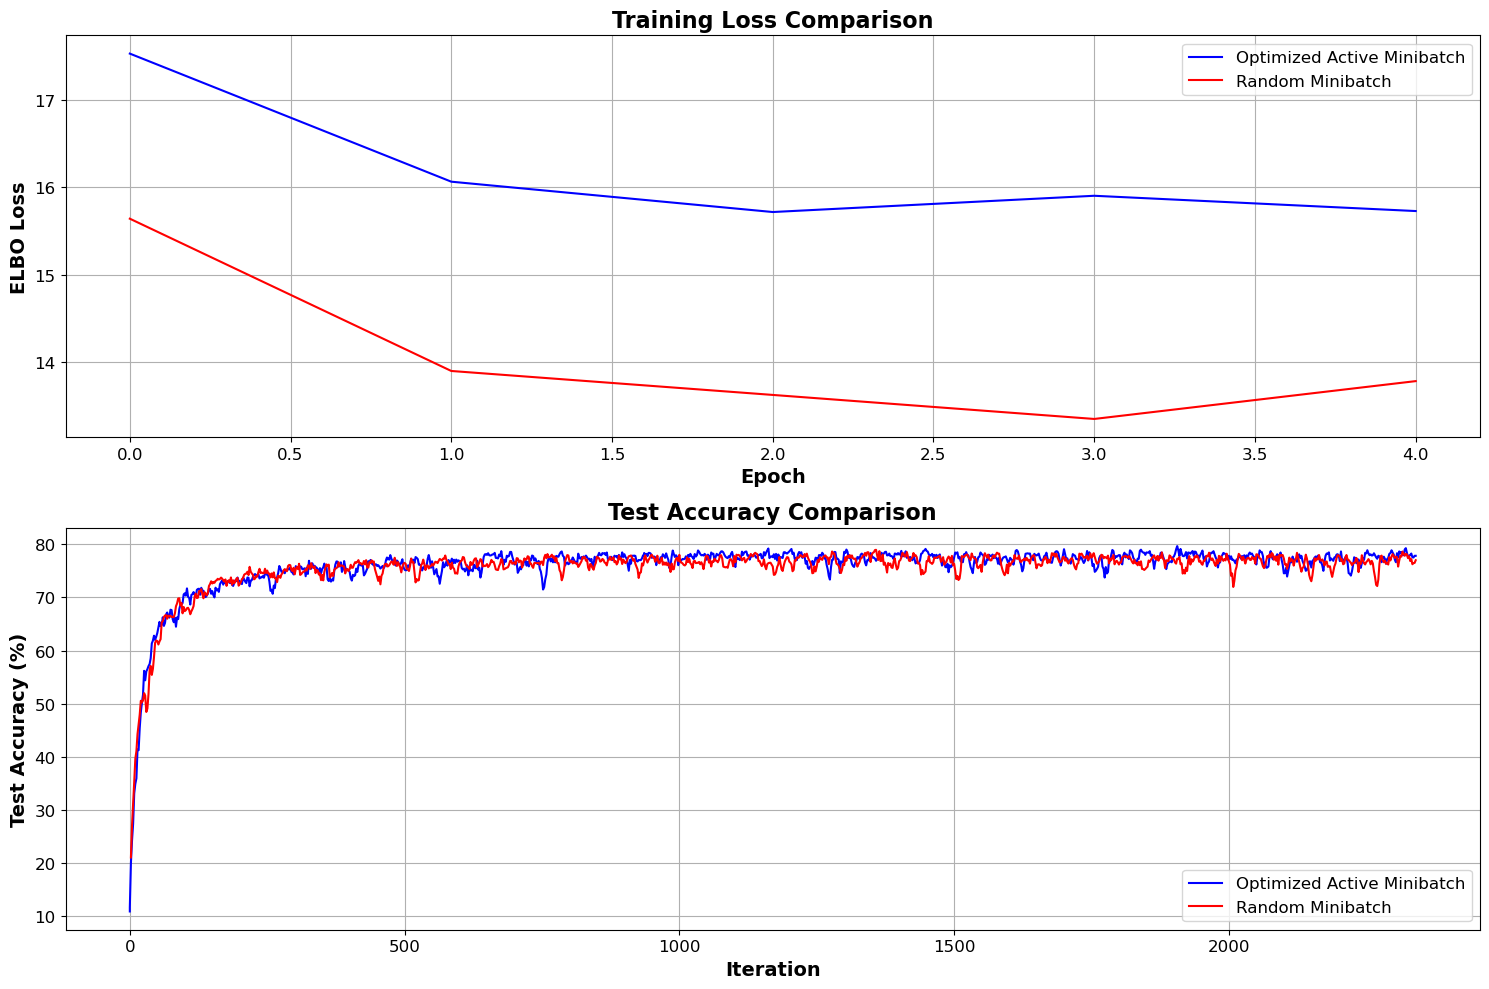

Sample Usage Statistics:
  - Min usage: 1
  - Max usage: 26
  - Mean usage: 9.99
  - Never used: 0 samples (0.00%)


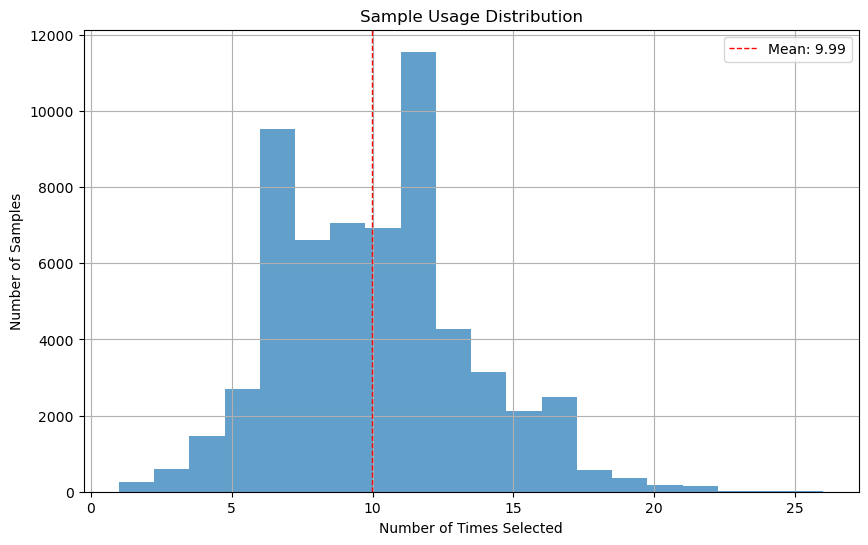

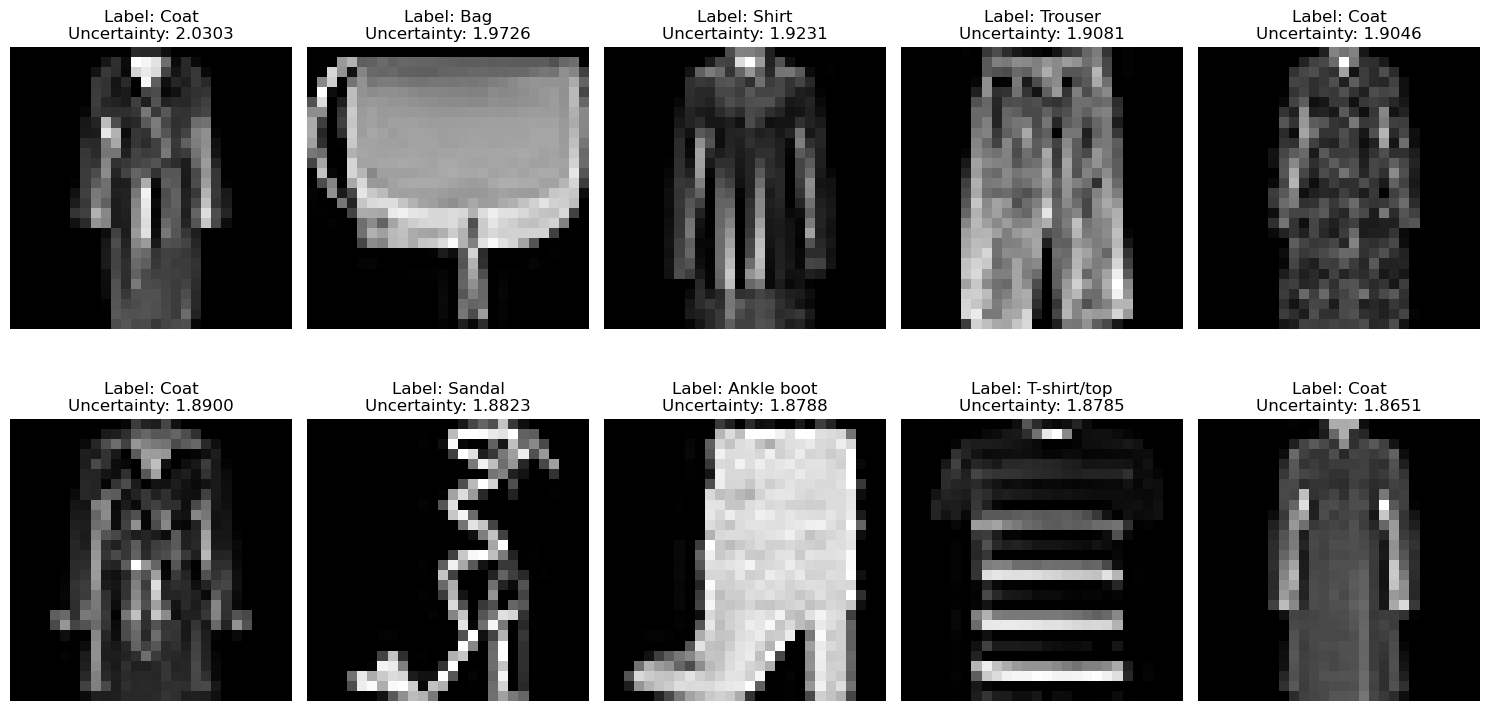


Done!


In [ ]:


# Plot comparison of methods
plot_comparison(
    active_losses, random_losses,
    active_accuracies, random_accuracies
)

# Restore active model for visualization
pyro.clear_param_store()
for name, param in active_model_params.items():
    pyro.param(name, param)

# Compute final uncertainties
all_data = torch.stack([active_dataset[i][0] for i in range(len(active_dataset))]).to(device)
uncertainties = compute_bayesian_uncertainty(
    model, guide, all_data, num_samples=10, uncertainty_type='entropy'
)
active_dataset.update_uncertainties(uncertainties.cpu())

# Analyze dataset usage patterns
analyze_dataset_usage(active_dataset)

# Visualize most uncertain samples
visualize_uncertain_samples(active_dataset)